In [1]:
import mopdbrs2

In [2]:
import pg8000

In [3]:
creds = mopdbrs2.get_creds()

creds['ssl_context']=True

con = pg8000.connect(**creds) 


/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'midway-auth.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,
/home/ukaec/anaconda3/envs/your_env_name/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'iibs-midway.corp.amazon.com'. Adding certificate verification is strongly advised. See: https://urllib3.readth

In [2]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
from dateutil.parser import parse
import math
import random 

In [5]:
sql = """

WITH pka_dosp AS (SELECT trunc(dateadd('day', -1, date_trunc('week', dateadd('day', 1, ship_day)))) AS ship_week
    ,SUBSTRING(shipping_address_postal_code,1,3) AS zipcode
    ,OTM_OBCUST_PKG_REC_ID
    ,warehouse_id
    ,CASE 
      WHEN customer_ship_option like '%%vendor%%' THEN 1000  /* vendor return packages: only captured for calculating UPS total packages */ 
      WHEN marketplace_id in (1,157860,926620) then 1  /* AFN packages */
      WHEN marketplace_id in (1034080,188630,1065810,1119740,190640) then 100  /* Zappos packages */
      WHEN marketplace_id IN (7) THEN 7 /*CA packages*/
      ELSE 999 /* Other Affiliates */
    END AS marketplace_id
    FROM booker.d_outbound_shipment_packages_na
    WHERE region_id = 1
      AND legal_entity_id = 115
      AND customer_ship_option is not null
      AND upper(ship_method) NOT IN ('UNKNOWN', 'MERCHANT', 'CLEANUP', 'LIQUIDATION_VENDOR_PICKUP','INBOUND_FBA_PCP_FEDEX_GROUND','MAGAZINE_SUBSCRIPTION','PICKUP','-1')
      AND upper(warehouse_id) NOT IN ('PTOP')
      AND shipping_address_country_code = 'CA'
      AND ship_week < '2019-12-29'
      AND ship_week >= trunc(dateadd('day', -1, date_trunc('week',dateadd('day', 1, dateadd('week',-212, '2019-12-29' )))))
      AND marketplace_id=7
    )


SELECT ship_week
    ,pka_dosp.zipcode
    ,count(OTM_OBCUST_PKG_REC_ID) as pkgs
FROM pka_dosp
    INNER JOIN trans_dims_ddl.warehouses w
    ON pka_dosp.warehouse_id = w.warehouse_id
    AND w.legal_entity_id = 115
    AND w.is_sortcenter = 'N'                                           
    AND w.is_prime_now = 'N'                                            
    AND w.is_fresh = 'N'
    and zipcode in (select "left"(destination_postal_code,3) as fsa
from perfectmile.d_perfectmile_pkg_attributes_v2_na
where marketplace_id = 7
and not(left(fsa,1) ~ '^[0-9]')
group by 1
having count(*) > 1000)
GROUP BY 1,
         2
ORDER BY 1,2;
    
    """


In [6]:
mod_df=pd.read_sql (sql, con=con, parse_dates=['ship_week'], index_col='ship_week')
mod_df

,zipcode,pkgs
ship_week,,
2015-12-06,A0A,655
2015-12-06,A0B,314
2015-12-06,A0C,195
2015-12-06,A0E,403
2015-12-06,A0G,544
...,...,...
2019-12-22,X0G,4
2019-12-22,X1A,1519
2019-12-22,Y0A,11


In [3]:
mod_df = pd.read_csv(r'Precovid_data/mod_df_pre.csv', parse_dates=['ship_week'], index_col='ship_week')
print(mod_df)

           zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-06     A0B   314
2015-12-06     A0C   195
2015-12-06     A0E   403
2015-12-06     A0G   544
...            ...   ...
2019-12-22     X0G     4
2019-12-22     X1A  1519
2019-12-22     Y0A    11
2019-12-22     Y0B    34
2019-12-22     Y1A  1997

[347671 rows x 2 columns]


In [4]:
mod_8 = mod_df[(mod_df['zipcode'].isin(['H0M', 'G7Z', 'G8J', 'R0K', 'V4B', 'H3C', 'N0B', 'K0K']))]
mod_8

,zipcode,pkgs
ship_week,,
2015-12-06,G7Z,24
2015-12-06,G8J,27
2015-12-06,H0M,1
2015-12-06,H3C,709
2015-12-06,K0K,3086
...,...,...
2019-12-22,H3C,2270
2019-12-22,K0K,9215
2019-12-22,N0B,7085


In [5]:
from fbprophet import Prophet 
from datetime import datetime

In [6]:
#extract M5K data for analysis
post_code = mod_df[mod_df.zipcode == 'R0K']
#post_code

In [7]:
#train
train_data = post_code[-4*212:160]

#test
test_data = post_code[-52:]

#forecast
fcst_data = post_code[-3*52:]

In [8]:
train = train_data.iloc[:,1]
train

ship_week
2015-12-06     704
2015-12-13     584
2015-12-20     274
2015-12-27     355
2016-01-03     335
              ... 
2018-11-25    1760
2018-12-02    1697
2018-12-09    1504
2018-12-16    1098
2018-12-23     898
Name: pkgs, Length: 160, dtype: int64

In [12]:
test_data = post_code[-52:]
test = test_data.iloc[:,1]
#test

In [14]:
test_rst = test.reset_index()
#test_rst

In [17]:
#dir(Prophet)

In [13]:
data = train.to_frame()
data_train = data.reset_index()
data_train.columns =['ship_week', 'pkgs_num']
data_train.head()

,ship_week,pkgs_num
0,2015-12-06,704
1,2015-12-13,584
2,2015-12-20,274
3,2015-12-27,355
4,2016-01-03,335


In [16]:
data_train.columns = ['ds', 'y']
data_train.head()

,ds,y
0,2015-12-06,704
1,2015-12-13,584
2,2015-12-20,274
3,2015-12-27,355
4,2016-01-03,335


In [17]:
#perform Box-Cox transformation on original data
from scipy.stats import boxcox

transformed_data, best_lambda = boxcox(data_train['y']) 

data_train['y'], lam = boxcox(data_train['y'])

In [24]:
# data_train

In [18]:
#new_model_test = prophet()
#new_model_test.fit(data_train)
#rom fbprophet import prophet
m = Prophet(interval_width=0.95, weekly_seasonality=True)
model = m.fit(data_train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [19]:
future = m.make_future_dataframe(periods=52, freq='W')
#future = model.predict(test_rst \ .rename(columns={'ship_week':'ds', 'pkgs': 'y'}))

In [26]:
# pred1 = m.make_future_dataframe(start=160, end=160+52-1)
# pred1.head(10)

In [20]:
forecast = m.predict(future)

In [21]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-06,2.804711,2.779483,2.852721,2.804711,2.804711,0.012003,0.012003,0.012003,-0.087422,-0.087422,-0.087422,0.099425,0.099425,0.099425,0.0,0.0,0.0,2.816714
1,2015-12-13,2.804793,2.740642,2.815826,2.804793,2.804793,-0.025573,-0.025573,-0.025573,-0.087422,-0.087422,-0.087422,0.061849,0.061849,0.061849,0.0,0.0,0.0,2.779220
2,2015-12-20,2.804875,2.704327,2.777812,2.804875,2.804875,-0.065294,-0.065294,-0.065294,-0.087422,-0.087422,-0.087422,0.022128,0.022128,0.022128,0.0,0.0,0.0,2.739581
3,2015-12-27,2.804957,2.679147,2.754305,2.804957,2.804957,-0.086694,-0.086694,-0.086694,-0.087422,-0.087422,-0.087422,0.000728,0.000728,0.000728,0.0,0.0,0.0,2.718263
4,2016-01-03,2.805039,2.680637,2.753730,2.805039,2.805039,-0.087571,-0.087571,-0.087571,-0.087422,-0.087422,-0.087422,-0.000149,-0.000149,-0.000149,0.0,0.0,0.0,2.717468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2019-11-24,2.989771,2.956025,3.050529,2.962037,3.017307,0.013416,0.013416,0.013416,-0.087422,-0.087422,-0.087422,0.100837,0.100837,0.100837,0.0,0.0,0.0,3.003187
208,2019-12-01,2.990566,2.969425,3.061535,2.962054,3.018711,0.024268,0.024268,0.024268,-0.087422,-0.087422,-0.087422,0.111690,0.111690,0.111690,0.0,0.0,0.0,3.014834
209,2019-12-08,2.991361,2.946036,3.043222,2.961913,3.020223,0.003005,0.003005,0.003005,-0.087422,-0.087422,-0.087422,0.090426,0.090426,0.090426,0.0,0.0,0.0,2.994366
210,2019-12-15,2.992156,2.904972,3.003410,2.961660,3.021841,-0.037831,-0.037831,-0.037831,-0.087422,-0.087422,-0.087422,0.049591,0.049591,0.049591,0.0,0.0,0.0,2.954325


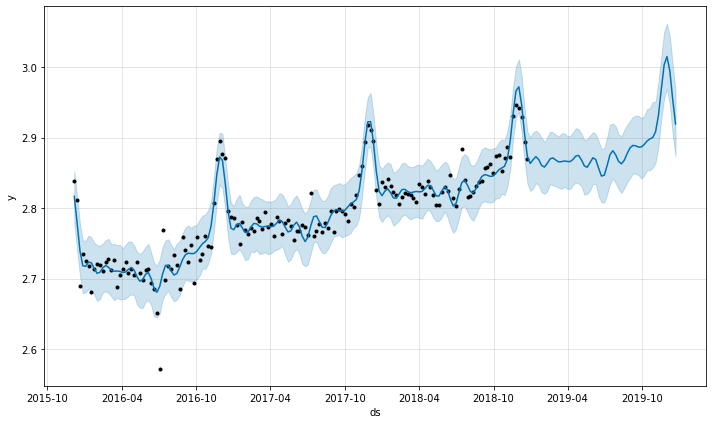

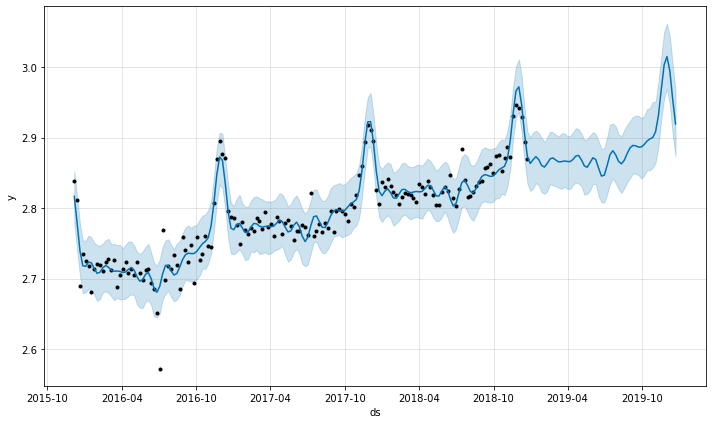

In [22]:
m.plot(forecast)

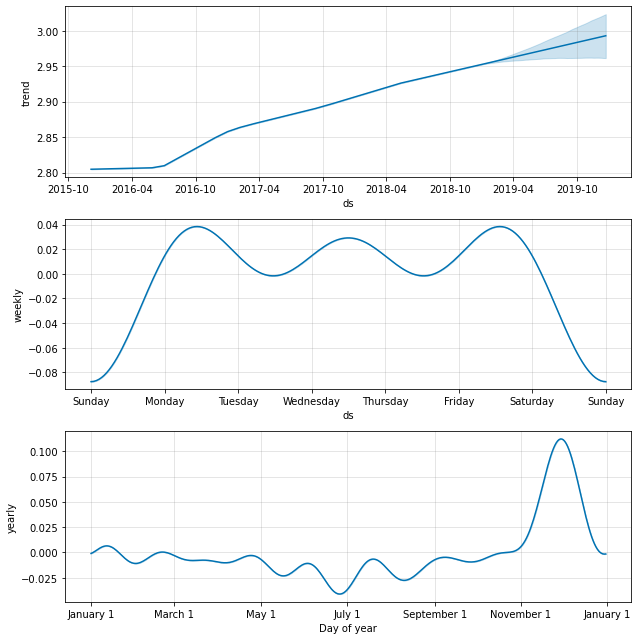

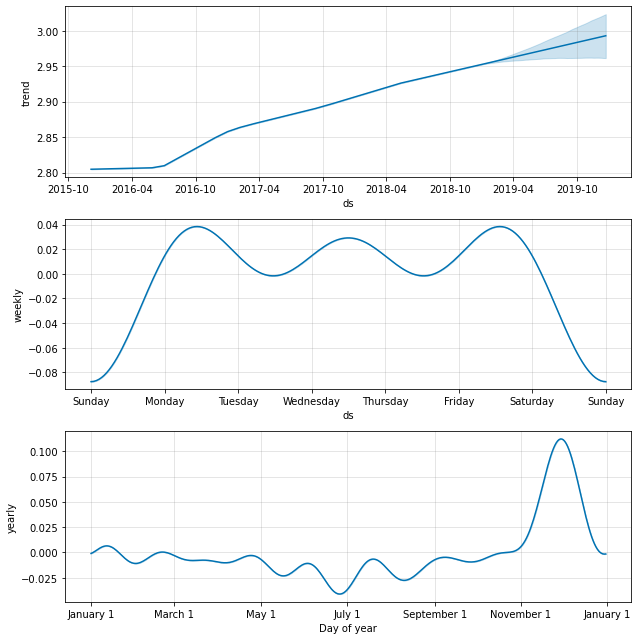

In [23]:
m.plot_components(forecast)

In [24]:
from scipy.special import inv_boxcox

In [25]:
# Apply inverse Box-Cox transform to specific forecast columns
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

In [26]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-06,2.804711,470.244446,787.415345,2.804711,2.804711,0.012003,0.012003,0.012003,-0.087422,-0.087422,-0.087422,0.099425,0.099425,0.099425,0.0,0.0,0.0,604.985100
1,2015-12-13,2.804793,368.528698,601.219284,2.804793,2.804793,-0.025573,-0.025573,-0.025573,-0.087422,-0.087422,-0.087422,0.061849,0.061849,0.061849,0.0,0.0,0.0,469.441183
2,2015-12-20,2.804875,297.947218,465.164160,2.804875,2.804875,-0.065294,-0.065294,-0.065294,-0.087422,-0.087422,-0.087422,0.022128,0.022128,0.022128,0.0,0.0,0.0,366.172117
3,2015-12-27,2.804957,259.094570,400.697068,2.804957,2.804957,-0.086694,-0.086694,-0.086694,-0.087422,-0.087422,-0.087422,0.000728,0.000728,0.000728,0.0,0.0,0.0,322.750935
4,2016-01-03,2.805039,261.202391,399.272599,2.805039,2.805039,-0.087571,-0.087571,-0.087571,-0.087422,-0.087422,-0.087422,-0.000149,-0.000149,-0.000149,0.0,0.0,0.0,321.265176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2019-11-24,2.989771,1937.040704,5923.803110,2.962037,3.017307,0.013416,0.013416,0.013416,-0.087422,-0.087422,-0.087422,0.100837,0.100837,0.100837,0.0,0.0,0.0,3227.398292
208,2019-12-01,2.990566,2221.811174,6943.741891,2.962054,3.018711,0.024268,0.024268,0.024268,-0.087422,-0.087422,-0.087422,0.111690,0.111690,0.111690,0.0,0.0,0.0,3709.889410
209,2019-12-08,2.991361,1755.081836,5352.689612,2.961913,3.020223,0.003005,0.003005,0.003005,-0.087422,-0.087422,-0.087422,0.090426,0.090426,0.090426,0.0,0.0,0.0,2915.257012
210,2019-12-15,2.992156,1203.852728,3235.838711,2.961660,3.021841,-0.037831,-0.037831,-0.037831,-0.087422,-0.087422,-0.087422,0.049591,0.049591,0.049591,0.0,0.0,0.0,1904.395933


In [27]:
fct = forecast[['ds', 'yhat']]
fct

,ds,yhat
0,2015-12-06,604.985100
1,2015-12-13,469.441183
2,2015-12-20,366.172117
3,2015-12-27,322.750935
4,2016-01-03,321.265176
...,...,...
207,2019-11-24,3227.398292
208,2019-12-01,3709.889410
209,2019-12-08,2915.257012
210,2019-12-15,1904.395933


In [28]:
fct_set = fct.set_index('ds')

In [31]:
fct_mask= fct_set[fct_set.index >='2018-12-04']
# fct_mask

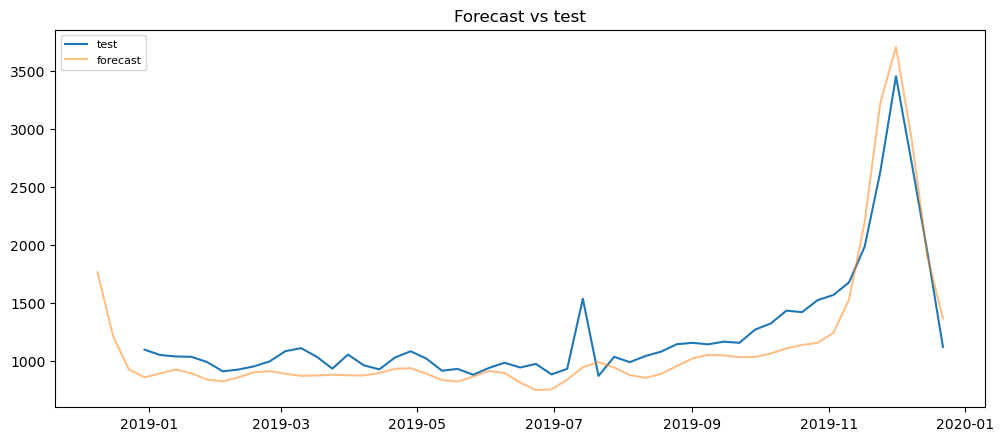

In [32]:
# Plot forecast vs actuals 
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='test')
#plt.plot(pred, label='pred')
plt.plot(fct_mask, label='forecast', alpha=.5)
plt.title('Forecast vs test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [33]:
data = train.to_frame()
train_new = data.reset_index()
train_new.columns =['ship_week', 'pkgs_num']
train_new.head()

,ship_week,pkgs_num
0,2015-12-06,704
1,2015-12-13,584
2,2015-12-20,274
3,2015-12-27,355
4,2016-01-03,335


In [34]:
train_new.columns = ['ds', 'y']
train_new.head()

,ds,y
0,2015-12-06,704
1,2015-12-13,584
2,2015-12-20,274
3,2015-12-27,355
4,2016-01-03,335


In [35]:
m = Prophet(interval_width=0.95, weekly_seasonality=True)
model = m.fit(train_new)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [36]:
fct = m.make_future_dataframe(periods=52, freq='W')
# fct

In [37]:
forecast1 = m.predict(fct)
forecast1

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-12-06,599.279233,738.914954,1001.429780,599.279233,599.279233,268.664825,268.664825,268.664825,-311.634773,-311.634773,-311.634773,580.299597,580.299597,580.299597,0.0,0.0,0.0,867.944057
1,2015-12-13,602.397403,457.230219,723.789971,602.397403,602.397403,-4.573996,-4.573996,-4.573996,-311.634773,-311.634773,-311.634773,307.060776,307.060776,307.060776,0.0,0.0,0.0,597.823407
2,2015-12-20,605.515573,225.415732,481.911358,605.515573,605.515573,-253.317176,-253.317176,-253.317176,-311.634773,-311.634773,-311.634773,58.317596,58.317596,58.317596,0.0,0.0,0.0,352.198397
3,2015-12-27,608.633743,125.676704,381.534168,608.633743,608.633743,-351.506962,-351.506962,-351.506962,-311.634773,-311.634773,-311.634773,-39.872190,-39.872190,-39.872190,0.0,0.0,0.0,257.126781
4,2016-01-03,611.751913,164.289235,422.673059,611.751913,611.751913,-318.144960,-318.144960,-318.144960,-311.634773,-311.634773,-311.634773,-6.510187,-6.510187,-6.510187,0.0,0.0,0.0,293.606954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2019-11-24,1623.993069,1815.428528,2075.487508,1588.833764,1661.602044,325.509474,325.509474,325.509474,-311.634773,-311.634773,-311.634773,637.144247,637.144247,637.144247,0.0,0.0,0.0,1949.502543
208,2019-12-01,1631.306821,1878.891003,2135.385116,1595.256033,1669.856971,376.664118,376.664118,376.664118,-311.634773,-311.634773,-311.634773,688.298891,688.298891,688.298891,0.0,0.0,0.0,2007.970939
209,2019-12-08,1638.620573,1706.928379,1963.115728,1601.605355,1678.093083,199.213372,199.213372,199.213372,-311.634773,-311.634773,-311.634773,510.848144,510.848144,510.848144,0.0,0.0,0.0,1837.833944
210,2019-12-15,1645.934325,1430.046861,1687.612926,1607.457420,1686.651671,-85.954135,-85.954135,-85.954135,-311.634773,-311.634773,-311.634773,225.680638,225.680638,225.680638,0.0,0.0,0.0,1559.980190


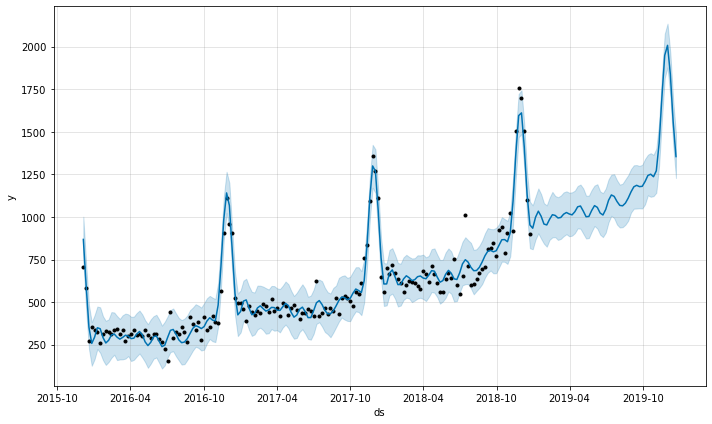

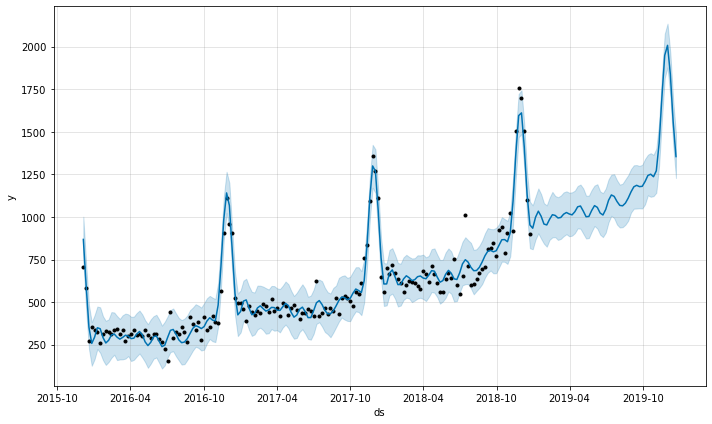

In [38]:
m.plot(forecast1)

In [39]:
fct_new = forecast1[['ds', 'yhat']]
fct_new

,ds,yhat
0,2015-12-06,867.944057
1,2015-12-13,597.823407
2,2015-12-20,352.198397
3,2015-12-27,257.126781
4,2016-01-03,293.606954
...,...,...
207,2019-11-24,1949.502543
208,2019-12-01,2007.970939
209,2019-12-08,1837.833944
210,2019-12-15,1559.980190


In [40]:
fct_new_set = fct_new.set_index('ds')

In [41]:
fct_mask_upd= fct_new_set[fct_new_set.index >='2018-12-04']
#fct_mask_upd

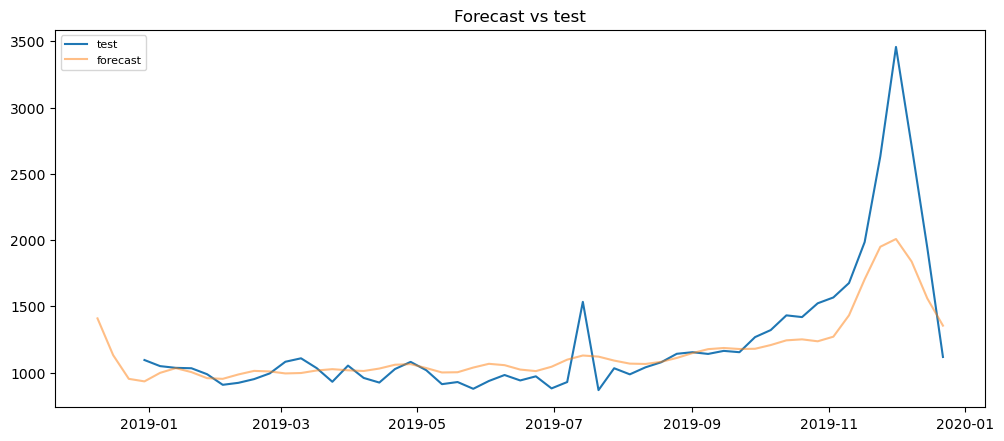

In [42]:
# Plot forecast vs actuals 
plt.figure(figsize=(12,5), dpi=100)
plt.plot(test, label='test')
#plt.plot(mask_mod, label='test')
#plt.plot(pred, label='pred')
plt.plot(fct_mask_upd, label='forecast', alpha=.5)
plt.title('Forecast vs test')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [9]:
import warnings;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import multiprocessing as mp
from itertools import zip_longest
import time

In [10]:
from tqdm import tqdm_notebook
from itertools import product
import warnings;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [11]:
import pandas as pd
from matplotlib import pyplot
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statistics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA 

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools 
import pmdarima as pm

In [58]:
# def run_V3_models(df):
    
#         #zipcode = df[0]
#         #df = df[1]
#         #print(df)
#     #input from the model 
#     #try:
    
#         #training the model
#         train_data = df[-4*212:160]
#         print(train_data)
#         train = train_data.iloc[:,1]
#         data = train.to_frame()
#         data_train = data.reset_index()
#         data_train.columns =['ship_week', 'pkgs_num']
        
#         #change the column names 
#         data_train.columns = ['ds', 'y']
        
#         #fit model
#         m = Prophet(interval_width=0.95, weekly_seasonality=True)
#         model = m.fit(data_train)
#         future = m.make_future_dataframe(periods=52, freq='W')
        
#         forecast = m.predict(future)
#         forecast = pd.DataFrame(forecast)
#        # forecast.columns= ['pred_V3']
#         forecast['zipcode'] = df['zipcode'].unique()[0]
    
    
#         return forecast

In [24]:
#extract R0K from the fxn 
# result = run_V3_models(mod_df[mod_df['zipcode']=='R0K'])
# result

In [59]:
# zipcodes = list(mod_df.zipcode.unique())
#len(zipcodes)

In [50]:
# fct_v3=[]

# for zipcode in zipcodes:
#     sub_df = mod_df[mod_df['zipcode']==zipcode]
    
#     forecast = run_V3_models(sub_df)
#     fct_v3.append(forecast)

In [51]:
# fct_v3[0]

## Multiprocessing 

In [13]:
def run_V3_models(df):
    
        zipcode = df[0]
        df = df[1]
        
    #input from the model 
        #training the model
        
        train_data = df[-4*212:160]
        print(train_data)
        train = train_data.iloc[:,1]
        data = train.to_frame()
        data_train = data.reset_index()
        data_train.columns =['ship_week', 'pkgs_num']
        
        #change the column names 
        data_train.columns = ['ds', 'y']
        
        #fit model
        m = Prophet(interval_width=0.95, weekly_seasonality=True)
        model = m.fit(data_train)
        future = m.make_future_dataframe(periods=52, freq='W')
        
        forecast = m.predict(future)
        forecast = pd.DataFrame(forecast)
       # forecast.columns= ['pred_V3']
        forecast['zipcode'] = df['zipcode'].unique()[0]
    
        return forecast

In [14]:
p = mp.Pool(mp.cpu_count())

           zipcode  pkgs
ship_week               
2015-12-06     A0A   655
2015-12-13     A0A   433
2015-12-20     A0A   166
2015-12-27     A0A   302
2016-01-03     A0A   298
...            ...   ...
2018-11-25     A0A  1560
2018-12-02     A0A  1378
2018-12-09     A0A   981
2018-12-16     A0A   778
2018-12-23     A0A   818

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1E    30
2015-12-13     B1E    17
2015-12-20     B1E    12
2015-12-27     B1E    13
2016-01-03     B1E    14
...            ...   ...
2018-11-25     B1E    97
2018-12-02     B1E   107
2018-12-09     B1E    95
2018-12-16     B1E    73
2018-12-23     B1E    67

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B4P   329
2015-12-13     B4P   356
2015-12-20     B4P   162
2015-12-27     B4P   170
2016-01-03     B4P   199
...            ...   ...
2018-11-25     B4P   765
2018-12-02     B4P   760
2018-12-09     B4P   749
2018-12-16     B4P   573
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0B   314
2015-12-13     A0B   209
2015-12-20     A0B    75
2015-12-27     A0B   139
2016-01-03     A0B   157
...            ...   ...
2018-11-25     A0B   811
2018-12-02     A0B   680
2018-12-09     A0B   486
2018-12-16     A0B   358
2018-12-23     A0B   389

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B4R   105
2015-12-13     B4R   104
2015-12-20     B4R    45
2015-12-27     B4R    73
2016-01-03     B4R    50
...            ...   ...
2018-11-25     B4R   300
2018-12-02     B4R   337
2018-12-09     B4R   317
2018-12-16     B4R   178
2018-12-23     B4R   133

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4J   100
2015-12-13     E4J    91
2015-12-20     E4J    44
2015-12-27     E4J    61
2016-01-03     E4J    53
...            ...   ...
2018-11-25     E4J   416
2018-12-02     E4J   381
2018-12-09     E4J   407
2018-12-16     E4J   340
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6E   119
2015-12-13     G6E   131
2015-12-20     G6E    63
2015-12-27     G6E    76
2016-01-03     G6E    73
...            ...   ...
2018-11-25     G6E   655
2018-12-02     G6E   576
2018-12-09     G6E   586
2018-12-16     G6E   548
2018-12-23     G6E   342

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G1V   532
2015-12-13     G1V   464
2015-12-20     G1V   235
2015-12-27     G1V   279
2016-01-03     G1V   376
...            ...   ...
2018-11-25     G1V  1777
2018-12-02     G1V  1537
2018-12-09     G1V  1549
2018-12-16     G1V  1345
2018-12-23     G1V   886

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E8B    34
2015-12-13     E8B    29
2015-12-20     E8B    13
2015-12-27     E8B    20
2016-01-03     E8B    13
...            ...   ...
2018-11-25     E8B   132
2018-12-02     E8B   110
2018-12-09     E8B   136
2018-12-16     E8B    81
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9T    92
2015-12-13     G9T   104
2015-12-20     G9T    68
2015-12-27     G9T    81
2016-01-03     G9T    86
...            ...   ...
2018-11-25     G9T   464
2018-12-02     G9T   487
2018-12-09     G9T   475
2018-12-16     G9T   452
2018-12-23     G9T   294

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1G    32
2015-12-13     B1G    51
2015-12-20     B1G    27
2015-12-27     B1G    29
2016-01-03     B1G    29
...            ...   ...
2018-11-25     B1G   141
2018-12-02     B1G   153
2018-12-09     B1G   154
2018-12-16     B1G    95
2018-12-23     B1G    54

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0C   195
2015-12-13     A0C    93
2015-12-20     A0C    52
2015-12-27     A0C    88
2016-01-03     A0C    78
...            ...   ...
2018-11-25     A0C   376
2018-12-02     A0C   363
2018-12-09     A0C   275
2018-12-16     A0C   188
2018-12-23     A0C   205

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B4V   644
2015-12-13     B4V   605
2015-12-20     B4V   230
2015-12-27     B4V   305
2016-01-03     B4V   270
...            ...   ...
2018-11-25     B4V  1532
2018-12-02     B4V  1608
2018-12-09     B4V  1582
2018-12-16     B4V  1087
2018-12-23     B4V   789

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4K   104
2015-12-13     E4K    91
2015-12-20     E4K    45
2015-12-27     E4K    66
2016-01-03     E4K    68
...            ...   ...
2018-11-25     E4K   366
2018-12-02     E4K   424
2018-12-09     E4K   387
2018-12-16     E4K   339
2018-12-23     E4K   196

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     G1W   417
2015-12-13     G1W   380
2015-12-20     G1W   232
2015-12-27     G1W   284
2016-01-03     G1W   243
...            ...   ...
2018-11-25     G1W  1309
2018-12-02     G1W  1092
2018-12-09     G1W  1322
2018-12-16     G1W  1240
2018-12-23     G1W   845

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     G9X    87
2015-12-13     G9X    99
2015-12-20     G9X    49
2015-12-27     G9X    77
2016-01-03     G9X    65
...            ...   ...
2018-11-25     G9X   417
2018-12-02     G9X   455
2018-12-09     G9X   492
2018-12-16     G9X   427
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0E   403
2015-12-13     A0E   207
2015-12-20     A0E   112
2015-12-27     A0E   208
2016-01-03     A0E   178
...            ...   ...
2018-11-25     A0E   827
2018-12-02     A0E   859
2018-12-09     A0E   545
2018-12-16     A0E   361
2018-12-23     A0E   418

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B5A   476
2015-12-13     B5A   423
2015-12-20     B5A   151
2015-12-27     B5A   241
2016-01-03     B5A   234
...            ...   ...
2018-11-25     B5A  1193
2018-12-02     B5A  1239
2018-12-09     B5A  1388
2018-12-16     B5A   914
2018-12-23     B5A   702

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4L   331
2015-12-13     E4L   343
2015-12-20     E4L   112
2015-12-27     E4L   150
2016-01-03     E4L   209
...            ...   ...
2018-11-25     E4L   889
2018-12-02     E4L   862
2018-12-09     E4L   806
2018-12-16     E4L   727
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1X   455
2015-12-13     G1X   444
2015-12-20     G1X   274
2015-12-27     G1X   315
2016-01-03     G1X   279
...            ...   ...
2018-11-25     G1X  1527
2018-12-02     G1X  1367
2018-12-09     G1X  1527
2018-12-16     G1X  1387
2018-12-23     G1X   961

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     H0M     1
2015-12-20     H0M     4
2015-12-27     H0M     1
2016-01-03     H0M     2
2016-01-10     H0M     2
...            ...   ...
2019-06-23     H0M    10
2019-06-30     H0M    10
2019-07-07     H0M     5
2019-07-14     H0M     7
2019-07-21     H0M     3

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8E    92
2015-12-13     E8E    85
2015-12-20     E8E    35
2015-12-27     E8E    57
2016-01-03     E8E    60
...            ...   ...
2018-11-25     E8E   406
2018-12-02     E8E   375
2018-12-09     E8E   360
2018-12-16     E8E   264
2018-12-23     E8E   218

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1J    23
2015-12-13     B1J    26
2015-12-20     B1J    11
2015-12-27     B1J    13
2016-01-03     B1J    20
...            ...   ...
2018-11-25     B1J    63
2018-12-02     B1J    76
2018-12-09     B1J    78
2018-12-16     B1J    60
2018-12-23     B1J    35

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6H    51
2015-12-13     G6H    50
2015-12-20     G6H    18
2015-12-27     G6H    37
2016-01-03     G6H    31
...            ...   ...
2018-11-25     G6H   255
2018-12-02     G6H   181
2018-12-09     G6H   222
2018-12-16     G6H   216
2018-12-23     G6H   154

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0G   544
2015-12-13     A0G   348
2015-12-20     A0G   139
2015-12-27     A0G   286
2016-01-03     A0G   229
...            ...   ...
2018-11-25     A0G  1736
2018-12-02     A0G  1396
2018-12-09     A0G  1043
2018-12-16     A0G   656
2018-12-23     A0G   839

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4M    28
2015-12-13     E4M    24
2015-12-20     E4M    14
2015-12-27     E4M    24
2016-01-03     E4M    21
...            ...   ...
2018-11-25     E4M   100
2018-12-02     E4M   108
2018-12-09     E4M   139
2018-12-16     E4M   113
2018-12-23     E4M    59

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B6L   352
2015-12-13     B6L   385
2015-12-20     B6L   132
2015-12-27     B6L   140
2016-01-03     B6L   157
...            ...   ...
2018-11-25     B6L  1014
2018-12-02     B6L  1126
2018-12-09     B6L  1059
2018-12-16     B6L   773
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1Y   268
2015-12-13     G1Y   293
2015-12-20     G1Y   147
2015-12-27     G1Y   154
2016-01-03     G1Y   172
...            ...   ...
2018-11-25     G1Y   834
2018-12-02     G1Y   739
2018-12-09     G1Y   827
2018-12-16     G1Y   775
2018-12-23     G1Y   495

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     E8G    47
2015-12-13     E8G    43
2015-12-20     E8G    23
2015-12-27     E8G    37
2016-01-03     E8G    25
...            ...   ...
2018-11-25     E8G   144
2018-12-02     E8G   170
2018-12-09     E8G   147
2018-12-16     E8G   129
2018-12-23     E8G    79

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1K    75
2015-12-13     B1K    68
2015-12-20     B1K    31
2015-12-27     B1K    36
2016-01-03     B1K    39
...            ...   ...
2018-11-25     B1K   220
2018-12-02     B1K   264
2018-12-09     B1K   240
2018-12-16     B1K   156
2018-12-23     B1K   113

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G6J   102
2015-12-13     G6J   122
2015-12-20     G6J    65
2015-12-27     G6J    92
2016-01-03     G6J    86
...            ...   ...
2018-11-25     G6J   643
2018-12-02     G6J   527
2018-12-09     G6J   576
2018-12-16     G6J   538
2018-12-23     G6J   398

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0H   304
2015-12-13     A0H   207
2015-12-20     A0H    94
2015-12-27     A0H   151
2016-01-03     A0H   146
...            ...   ...
2018-11-25     A0H   775
2018-12-02     A0H   720
2018-12-09     A0H   569
2018-12-16     A0H   390
2018-12-23     A0H   411

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E8J    90
2015-12-13     E8J    80
2015-12-20     E8J    43
2015-12-27     E8J    58
2016-01-03     E8J    45
...            ...   ...
2018-11-25     E8J   383
2018-12-02     E8J   354
2018-12-09     E8J   358
2018-12-16     E8J   272
2018-12-23     E8J   185

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     E4N    28
2015-12-13     E4N    45
2015-12-20     E4N    22
2015-12-27     E4N    26
2016-01-03     E4N    17
...            ...   ...
2018-11-25     E4N   181
2018-12-02     E4N   204
2018-12-09     E4N   192
2018-12-16     E4N   208
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B9A   164
2015-12-13     B9A   136
2015-12-20     B9A    54
2015-12-27     B9A    74
2016-01-03     B9A    65
...            ...   ...
2018-11-25     B9A   343
2018-12-02     B9A   368
2018-12-09     B9A   356
2018-12-16     B9A   224
2018-12-23     B9A   186

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G2A   216
2015-12-13     G2A   224
2015-12-20     G2A   118
2015-12-27     G2A   148
2016-01-03     G2A   154
...            ...   ...
2018-11-25     G2A   921
2018-12-02     G2A   803
2018-12-09     G2A   927
2018-12-16     G2A   879
2018-12-23     G2A   603

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1L   142
2015-12-13     B1L   178
2015-12-20     B1L    64
2015-12-27     B1L    72
2016-01-03     B1L    59
...            ...   ...
2018-11-25     B1L   389
2018-12-02     B1L   387
2018-12-09     B1L   426
2018-12-16     B1L   278
2018-12-23     B1L   173

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     G6K   101
2015-12-13     G6K    96
2015-12-20     G6K    70
2015-12-27     G6K    72
2016-01-03     G6K    78
...            ...   ...
2018-11-25     G6K   500
2018-12-02     G6K   469
2018-12-09     G6K   464
2018-12-16     G6K   476
2018-12-23     G6K   307

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8K   184
2015-12-13     E8K   171
2015-12-20     E8K    77
2015-12-27     E8K   100
2016-01-03     E8K    82
...            ...   ...
2018-11-25     E8K   628
2018-12-02     E8K   585
2018-12-09     E8K   600
2018-12-16     E8K   422
2018-12-23     E8K   329

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     E4P   308
2015-12-13     E4P   305
2015-12-20     E4P   125
2015-12-27     E4P   156
2016-01-03     E4P   162
...            ...   ...
2018-11-25     E4P   984
2018-12-02     E4P   968
2018-12-09     E4P  1023
2018-12-16     E4P   877
2018-12-23     E4P   549

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     A0J   178
2015-12-13     A0J    96
2015-12-20     A0J    51
2015-12-27     A0J   100
2016-01-03     A0J    86
...            ...   ...
2018-11-25     A0J   441
2018-12-02     A0J   376
2018-12-09     A0J   305
2018-12-16     A0J   238
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2B   311
2015-12-13     G2B   334
2015-12-20     G2B   181
2015-12-27     G2B   217
2016-01-03     G2B   217
...            ...   ...
2018-11-25     G2B  1385
2018-12-02     G2B  1239
2018-12-09     G2B  1374
2018-12-16     G2B  1281
2018-12-23     G2B   901

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     C0A  1073
2015-12-13     C0A  1063
2015-12-20     C0A   457
2015-12-27     C0A   560
2016-01-03     C0A   535
...            ...   ...
2018-11-25     C0A  3430
2018-12-02     C0A  3825
2018-12-09     C0A  3764
2018-12-16     C0A  2631
2018-12-23     C0A  1957

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6L    99
2015-12-13     G6L   105
2015-12-20     G6L    49
2015-12-27     G6L    76
2016-01-03     G6L    59
...            ...   ...
2018-11-25     G6L   564
2018-12-02     G6L   509
2018-12-09     G6L   494
2018-12-16     G6L   439
2018-12-23     G6L   304

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1M    37
2015-12-13     B1M    42
2015-12-20     B1M    14
2015-12-27     B1M    18
2016-01-03     B1M    28
...            ...   ...
2018-11-25     B1M   126
2018-12-02     B1M   142
2018-12-09     B1M   126
2018-12-16     B1M    82
2018-12-23     B1M    75

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8L    25
2015-12-13     E8L    19
2015-12-20     E8L    12
2015-12-27     E8L    22
2016-01-03     E8L     7
...            ...   ...
2018-11-25     E8L   146
2018-12-02     E8L   132
2018-12-09     E8L   113
2018-12-16     E8L    80
2018-12-23     E8L    55

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4R   139
2015-12-13     E4R   124
2015-12-20     E4R    47
2015-12-27     E4R    57
2016-01-03     E4R    66
...            ...   ...
2018-11-25     E4R   443
2018-12-02     E4R   384
2018-12-09     E4R   442
2018-12-16     E4R   383
2018-12-23     E4R   215

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0K   309
2015-12-13     A0K   174
2015-12-20     A0K    86
2015-12-27     A0K   155
2016-01-03     A0K   143
...            ...   ...
2018-11-25     A0K   818
2018-12-02     A0K   705
2018-12-09     A0K   504
2018-12-16     A0K   379
2018-12-23     A0K   425

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G2C   247
2015-12-13     G2C   220
2015-12-20     G2C   102
2015-12-27     G2C   131
2016-01-03     G2C   114
...            ...   ...
2018-11-25     G2C   879
2018-12-02     G2C   718
2018-12-09     G2C   869
2018-12-16     G2C   823
2018-12-23     G2C   562

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     C0B   605
2015-12-13     C0B   658
2015-12-20     C0B   297
2015-12-27     C0B   356
2016-01-03     C0B   314
...            ...   ...
2018-11-25     C0B  2174
2018-12-02     C0B  2438
2018-12-09     C0B  2408
2018-12-16     C0B  1600
2018-12-23     C0B  1347

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1E   546
2015-12-13     H1E   600
2015-12-20     H1E   387
2015-12-27     H1E   419
2016-01-03     H1E   376
...            ...   ...
2018-11-25     H1E  2407
2018-12-02     H1E  2161
2018-12-09     H1E  2389
2018-12-16     H1E  2917
2018-12-23     H1E  1715

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1N   110
2015-12-13     B1N   124
2015-12-20     B1N    45
2015-12-27     B1N    53
2016-01-03     B1N    46
...            ...   ...
2018-11-25     B1N   333
2018-12-02     B1N   383
2018-12-09     B1N   415
2018-12-16     B1N   265
2018-12-23     B1N   208

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G6P   196
2015-12-13     G6P   210
2015-12-20     G6P   150
2015-12-27     G6P   155
2016-01-03     G6P   129
...            ...   ...
2018-11-25     G6P   878
2018-12-02     G6P   801
2018-12-09     G6P   798
2018-12-16     G6P   811
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8M    12
2015-12-13     E8M    18
2015-12-20     E8M     3
2015-12-27     E8M     9
2016-01-03     E8M     6
...            ...   ...
2018-11-25     E8M    88
2018-12-02     E8M    80
2018-12-09     E8M    97
2018-12-16     E8M    45
2018-12-23     E8M    55

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4S   103
2015-12-13     E4S    86
2015-12-20     E4S    41
2015-12-27     E4S    54
2016-01-03     E4S    55
...            ...   ...
2018-11-25     E4S   432
2018-12-02     E4S   381
2018-12-09     E4S   414
2018-12-16     E4S   352
2018-12-23     E4S   228

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0L   184
2015-12-13     A0L   111
2015-12-20     A0L    67
2015-12-27     A0L    97
2016-01-03     A0L    84
...            ...   ...
2018-11-25     A0L   491
2018-12-02     A0L   444
2018-12-09     A0L   339
2018-12-16     A0L   228
2018-12-23     A0L   205

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2E   351
2015-12-13     G2E   315
2015-12-20     G2E   182
2015-12-27     G2E   245
2016-01-03     G2E   192
...            ...   ...
2018-11-25     G2E  1314
2018-12-02     G2E  1119
2018-12-09     G2E  1386
2018-12-16     G2E  1245
2018-12-23     G2E   943

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     C1A   920
2015-12-13     C1A   965
2015-12-20     C1A   411
2015-12-27     C1A   555
2016-01-03     C1A   533
...            ...   ...
2018-11-25     C1A  2369
2018-12-02     C1A  2444
2018-12-09     C1A  2585
2018-12-16     C1A  1795
2018-12-23     C1A  1268

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H1G   358
2015-12-13     H1G   343
2015-12-20     H1G   223
2015-12-27     H1G   259
2016-01-03     H1G   221
...            ...   ...
2018-11-25     H1G  1519
2018-12-02     H1G  1408
2018-12-09     H1G  1414
2018-12-16     H1G  1729
2018-12-23     H1G  1137

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1P   433
2015-12-13     B1P   487
2015-12-20     B1P   177
2015-12-27     B1P   189
2016-01-03     B1P   237
...            ...   ...
2018-11-25     B1P  1141
2018-12-02     B1P  1107
2018-12-09     B1P  1185
2018-12-16     B1P   898
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     G6R    27
2015-12-13     G6R    21
2015-12-20     G6R    22
2015-12-27     G6R    27
2016-01-03     G6R    28
...            ...   ...
2018-11-25     G6R   171
2018-12-02     G6R   174
2018-12-09     G6R   204
2018-12-16     G6R   178
2018-12-23     G6R    98

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8N    41
2015-12-13     E8N    25
2015-12-20     E8N    13
2015-12-27     E8N    26
2016-01-03     E8N    17
...            ...   ...
2018-11-25     E8N   127
2018-12-02     E8N   113
2018-12-09     E8N   128
2018-12-16     E8N    92
2018-12-23     E8N    62

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4T    28
2015-12-13     E4T    29
2015-12-20     E4T     5
2015-12-27     E4T    13
2016-01-03     E4T    10
...            ...   ...
2018-11-25     E4T   107
2018-12-02     E4T    98
2018-12-09     E4T   120
2018-12-16     E4T    81
2018-12-23     E4T    45

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0M   138
2015-12-13     A0M    78
2015-12-20     A0M    41
2015-12-27     A0M    75
2016-01-03     A0M    69
...            ...   ...
2018-11-25     A0M   390
2018-12-02     A0M   334
2018-12-09     A0M   264
2018-12-16     A0M   172
2018-12-23     A0M   188

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2G   169
2015-12-13     G2G   172
2015-12-20     G2G    98
2015-12-27     G2G   130
2016-01-03     G2G    98
...            ...   ...
2018-11-25     G2G   722
2018-12-02     G2G   615
2018-12-09     G2G   743
2018-12-16     G2G   707
2018-12-23     G2G   454

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     C1B   473
2015-12-13     C1B   516
2015-12-20     C1B   244
2015-12-27     C1B   228
2016-01-03     C1B   199
...            ...   ...
2018-11-25     C1B  1349
2018-12-02     C1B  1394
2018-12-09     C1B  1542
2018-12-16     C1B   995
2018-12-23     C1B   690

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H1H   246
2015-12-13     H1H   260
2015-12-20     H1H   141
2015-12-27     H1H   185
2016-01-03     H1H   183
...            ...   ...
2018-11-25     H1H  1137
2018-12-02     H1H   995
2018-12-09     H1H  1156
2018-12-16     H1H  1244
2018-12-23     H1H   800

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1R   136
2015-12-13     B1R   137
2015-12-20     B1R    63
2015-12-27     B1R    83
2016-01-03     B1R    66
...            ...   ...
2018-11-25     B1R   390
2018-12-02     B1R   381
2018-12-09     B1R   434
2018-12-16     B1R   289
2018-12-23     B1R   187

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6S    39
2015-12-13     G6S    51
2015-12-20     G6S    43
2015-12-27     G6S    32
2016-01-03     G6S    20
...            ...   ...
2018-11-25     G6S   198
2018-12-02     G6S   184
2018-12-09     G6S   170
2018-12-16     G6S   178
2018-12-23     G6S   114

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8P    39
2015-12-13     E8P    37
2015-12-20     E8P    22
2015-12-27     E8P    33
2016-01-03     E8P    29
...            ...   ...
2018-11-25     E8P   165
2018-12-02     E8P   149
2018-12-09     E8P   163
2018-12-16     E8P   114
2018-12-23     E8P   109

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4V    71
2015-12-13     E4V    62
2015-12-20     E4V    32
2015-12-27     E4V    35
2016-01-03     E4V    36
...            ...   ...
2018-11-25     E4V   294
2018-12-02     E4V   271
2018-12-09     E4V   296
2018-12-16     E4V   221
2018-12-23     E4V   154

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0N   290
2015-12-13     A0N   173
2015-12-20     A0N    81
2015-12-27     A0N   134
2016-01-03     A0N   116
...            ...   ...
2018-11-25     A0N   695
2018-12-02     A0N   667
2018-12-09     A0N   451
2018-12-16     A0N   324
2018-12-23     A0N   283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2J    77
2015-12-13     G2J    88
2015-12-20     G2J    26
2015-12-27     G2J    54
2016-01-03     G2J    51
...            ...   ...
2018-11-25     G2J   288
2018-12-02     G2J   270
2018-12-09     G2J   303
2018-12-16     G2J   234
2018-12-23     G2J    89

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     C1C   130
2015-12-13     C1C   135
2015-12-20     C1C    66
2015-12-27     C1C    64
2016-01-03     C1C    59
...            ...   ...
2018-11-25     C1C   361
2018-12-02     C1C   403
2018-12-09     C1C   423
2018-12-16     C1C   275
2018-12-23     C1C   211

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H1J   220
2015-12-13     H1J   218
2015-12-20     H1J    93
2015-12-27     H1J   108
2016-01-03     H1J   127
...            ...   ...
2018-11-25     H1J   860
2018-12-02     H1J   757
2018-12-09     H1J   772
2018-12-16     H1J   798
2018-12-23     H1J   413

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1S   243
2015-12-13     B1S   279
2015-12-20     B1S   104
2015-12-27     B1S    90
2016-01-03     B1S   100
...            ...   ...
2018-11-25     B1S   649
2018-12-02     B1S   630
2018-12-09     B1S   677
2018-12-16     B1S   452
2018-12-23     B1S   285

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6T    94
2015-12-13     G6T    97
2015-12-20     G6T    46
2015-12-27     G6T    50
2016-01-03     G6T    41
...            ...   ...
2018-11-25     G6T   505
2018-12-02     G6T   473
2018-12-09     G6T   516
2018-12-16     G6T   413
2018-12-23     G6T   279

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E8R    23
2015-12-13     E8R    29
2015-12-20     E8R    13
2015-12-27     E8R    12
2016-01-03     E8R    17
...            ...   ...
2018-11-25     E8R    95
2018-12-02     E8R   112
2018-12-09     E8R   100
2018-12-16     E8R    87
2018-12-23     E8R    70

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4W   139
2015-12-13     E4W   121
2015-12-20     E4W    62
2015-12-27     E4W    65
2016-01-03     E4W    65
...            ...   ...
2018-11-25     E4W   490
2018-12-02     E4W   443
2018-12-09     E4W   480
2018-12-16     E4W   395
2018-12-23     E4W   226

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0P   668
2015-12-13     A0P   439
2015-12-20     A0P   194
2015-12-27     A0P   377
2016-01-03     A0P   332
...            ...   ...
2018-11-25     A0P  1662
2018-12-02     A0P  1511
2018-12-09     A0P  1119
2018-12-16     A0P   684
2018-12-23     A0P   887

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2K   199
2015-12-13     G2K   183
2015-12-20     G2K   109
2015-12-27     G2K   114
2016-01-03     G2K   110
...            ...   ...
2018-11-25     G2K   805
2018-12-02     G2K   710
2018-12-09     G2K   803
2018-12-16     G2K   768
2018-12-23     G2K   441

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     C1E   365
2015-12-13     C1E   376
2015-12-20     C1E   158
2015-12-27     C1E   216
2016-01-03     C1E   237
...            ...   ...
2018-11-25     C1E  1105
2018-12-02     C1E  1121
2018-12-09     C1E  1224
2018-12-16     C1E   785
2018-12-23     C1E   600

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H1K   415
2015-12-13     H1K   430
2015-12-20     H1K   272
2015-12-27     H1K   309
2016-01-03     H1K   261
...            ...   ...
2018-11-25     H1K  1701
2018-12-02     H1K  1507
2018-12-09     H1K  1600
2018-12-16     H1K  1935
2018-12-23     H1K  1269

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1T     8
2015-12-13     B1T     6
2015-12-27     B1T     7
2016-01-03     B1T     4
2016-01-10     B1T    11
...            ...   ...
2018-12-09     B1T    16
2018-12-16     B1T    14
2018-12-23     B1T     3
2018-12-30     B1T     9
2019-01-06     B1T     9

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6V   438
2015-12-13     G6V   432
2015-12-20     G6V   202
2015-12-27     G6V   274
2016-01-03     G6V   239
...            ...   ...
2018-11-25     G6V  1415
2018-12-02     G6V  1254
2018-12-09     G6V  1373
2018-12-16     G6V  1363
2018-12-23     G6V   895

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4X    29
2015-12-13     E4X    43
2015-12-20     E4X    15
2015-12-27     E4X    21
2016-01-03     E4X    18
...            ...   ...
2018-11-25     E4X   135
2018-12-02     E4X   124
2018-12-09     E4X   141
2018-12-16     E4X    87
2018-12-23     E4X    76

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     E8S    96
2015-12-13     E8S    74
2015-12-20     E8S    27
2015-12-27     E8S    58
2016-01-03     E8S    50
...            ...   ...
2018-11-25     E8S   246
2018-12-02     E8S   286
2018-12-09     E8S   276
2018-12-16     E8S   183
2018-12-23     E8S   166

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A0R   129
2015-12-13     A0R    80
2015-12-20     A0R    37
2015-12-27     A0R    82
2016-01-03     A0R    80
...            ...   ...
2018-11-25     A0R   455
2018-12-02     A0R   291
2018-12-09     A0R   298
2018-12-16     A0R   170
2018-12-23     A0R   201

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2L   201
2015-12-13     G2L   195
2015-12-20     G2L   105
2015-12-27     G2L   128
2016-01-03     G2L    99
...            ...   ...
2018-11-25     G2L   761
2018-12-02     G2L   714
2018-12-09     G2L   783
2018-12-16     G2L   698
2018-12-23     G2L   580

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     C1N   462
2015-12-13     C1N   433
2015-12-20     C1N   200
2015-12-27     C1N   239
2016-01-03     C1N   246
...            ...   ...
2018-11-25     C1N  1346
2018-12-02     C1N  1604
2018-12-09     C1N  1491
2018-12-16     C1N  1002
2018-12-23     C1N   723

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1L   396
2015-12-13     H1L   362
2015-12-20     H1L   246
2015-12-27     H1L   245
2016-01-03     H1L   250
...            ...   ...
2018-11-25     H1L  1594
2018-12-02     H1L  1481
2018-12-09     H1L  1544
2018-12-16     H1L  1769
2018-12-23     H1L  1098

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1V   147
2015-12-13     B1V   177
2015-12-20     B1V    60
2015-12-27     B1V    67
2016-01-03     B1V    72
...            ...   ...
2018-11-25     B1V   393
2018-12-02     B1V   455
2018-12-09     B1V   474
2018-12-16     B1V   358
2018-12-23     B1V   232

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6W   347
2015-12-13     G6W   291
2015-12-20     G6W   176
2015-12-27     G6W   213
2016-01-03     G6W   201
...            ...   ...
2018-11-25     G6W  1397
2018-12-02     G6W  1172
2018-12-09     G6W  1412
2018-12-16     G6W  1276
2018-12-23     G6W   780

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4Y    26
2015-12-13     E4Y    34
2015-12-20     E4Y    16
2015-12-27     E4Y    16
2016-01-03     E4Y    13
...            ...   ...
2018-11-25     E4Y   176
2018-12-02     E4Y   152
2018-12-09     E4Y   167
2018-12-16     E4Y   120
2018-12-23     E4Y   101

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E8T    66
2015-12-13     E8T    55
2015-12-20     E8T    41
2015-12-27     E8T    41
2016-01-03     E8T    43
...            ...   ...
2018-11-25     E8T   297
2018-12-02     E8T   278
2018-12-09     E8T   296
2018-12-16     E8T   163
2018-12-23     E8T   179

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1A  1077
2015-12-13     A1A   797
2015-12-20     A1A   324
2015-12-27     A1A   446
2016-01-03     A1A   447
...            ...   ...
2018-11-25     A1A  2207
2018-12-02     A1A  1902
2018-12-09     A1A  1667
2018-12-16     A1A  1196
2018-12-23     A1A  1025

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E1A  1122
2015-12-13     E1A  1105
2015-12-20     E1A   540
2015-12-27     E1A   666
2016-01-03     E1A   641
...            ...   ...
2018-11-25     E1A  4051
2018-12-02     E1A  3705
2018-12-09     E1A  3758
2018-12-16     E1A  2951
2018-12-23     E1A  1886

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     G2M    89
2015-12-13     G2M    69
2015-12-20     G2M    60
2015-12-27     G2M    69
2016-01-03     G2M    33
...            ...   ...
2018-11-25     G2M   343
2018-12-02     G2M   297
2018-12-09     G2M   337
2018-12-16     G2M   348
2018-12-23     G2M   259

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1M   394
2015-12-13     H1M   387
2015-12-20     H1M   276
2015-12-27     H1M   284
2016-01-03     H1M   270
...            ...   ...
2018-11-25     H1M  1416
2018-12-02     H1M  1295
2018-12-09     H1M  1363
2018-12-16     H1M  1664
2018-12-23     H1M  1039

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1W    25
2015-12-13     B1W    25
2015-12-20     B1W    14
2015-12-27     B1W    14
2016-01-03     B1W    23
...            ...   ...
2018-11-25     B1W    71
2018-12-02     B1W    73
2018-12-09     B1W   115
2018-12-16     B1W    91
2018-12-23     B1W    44

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6X   144
2015-12-13     G6X   140
2015-12-20     G6X    61
2015-12-27     G6X    82
2016-01-03     G6X    49
...            ...   ...
2018-11-25     G6X   511
2018-12-02     G6X   519
2018-12-09     G6X   585
2018-12-16     G6X   545
2018-12-23     G6X   346

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E9A    26
2015-12-13     E9A    28
2015-12-20     E9A    15
2015-12-27     E9A    23
2016-01-03     E9A    18
...            ...   ...
2018-11-25     E9A    91
2018-12-02     E9A   101
2018-12-09     E9A    75
2018-12-16     E9A    66
2018-12-23     E9A    48

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E4Z   124
2015-12-13     E4Z   131
2015-12-20     E4Z    50
2015-12-27     E4Z    65
2016-01-03     E4Z    56
...            ...   ...
2018-11-25     E4Z   390
2018-12-02     E4Z   384
2018-12-09     E4Z   386
2018-12-16     E4Z   312
2018-12-23     E4Z   189

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A1B   838
2015-12-13     A1B   617
2015-12-20     A1B   312
2015-12-27     A1B   433
2016-01-03     A1B   520
...            ...   ...
2018-11-25     A1B  1795
2018-12-02     A1B  1641
2018-12-09     A1B  1284
2018-12-16     A1B   935
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G2N    97
2015-12-13     G2N    99
2015-12-20     G2N    59
2015-12-27     G2N    63
2016-01-03     G2N    72
...            ...   ...
2018-11-25     G2N   570
2018-12-02     G2N   459
2018-12-09     G2N   502
2018-12-16     G2N   553
2018-12-23     G2N   352

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E1B   699
2015-12-13     E1B   666
2015-12-20     E1B   324
2015-12-27     E1B   378
2016-01-03     E1B   361
...            ...   ...
2018-11-25     E1B  2006
2018-12-02     E1B  1788
2018-12-09     E1B  1958
2018-12-16     E1B  1748
2018-12-23     E1B   876

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B1X    32
2015-12-13     B1X    20
2015-12-20     B1X    12
2015-12-27     B1X     7
2016-01-03     B1X    21
...            ...   ...
2018-11-25     B1X    62
2018-12-02     B1X   100
2018-12-09     B1X    76
2018-12-16     B1X    48
2018-12-23     B1X    30

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H1N   374
2015-12-13     H1N   381
2015-12-20     H1N   214
2015-12-27     H1N   254
2016-01-03     H1N   241
...            ...   ...
2018-11-25     H1N  1378
2018-12-02     H1N  1309
2018-12-09     H1N  1327
2018-12-16     H1N  1371
2018-12-23     H1N   881

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6Y    69
2015-12-13     G6Y    56
2015-12-20     G6Y    32
2015-12-27     G6Y    45
2016-01-03     G6Y    38
...            ...   ...
2018-11-25     G6Y   447
2018-12-02     G6Y   363
2018-12-09     G6Y   485
2018-12-16     G6Y   414
2018-12-23     G6Y   369

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5A    29
2015-12-13     E5A    16
2015-12-20     E5A     4
2015-12-27     E5A    11
2016-01-03     E5A    13
...            ...   ...
2018-11-25     E5A    42
2018-12-02     E5A    51
2018-12-09     E5A    63
2018-12-16     E5A    26
2018-12-23     E5A    33

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A1C   547
2015-12-13     A1C   428
2015-12-20     A1C   194
2015-12-27     A1C   228
2016-01-03     A1C   294
...            ...   ...
2018-11-25     A1C   962
2018-12-02     A1C   869
2018-12-09     A1C   745
2018-12-16     A1C   512
2018-12-23     A1C   472

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E9B    39
2015-12-13     E9B    33
2015-12-20     E9B    13
2015-12-27     E9B    17
2016-01-03     E9B     7
...            ...   ...
2018-11-25     E9B   160
2018-12-02     E9B   161
2018-12-09     E9B   163
2018-12-16     E9B   109
2018-12-23     E9B    62

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3A   319
2015-12-13     G3A   345
2015-12-20     G3A   174
2015-12-27     G3A   218
2016-01-03     G3A   179
...            ...   ...
2018-11-25     G3A  1260
2018-12-02     G3A  1094
2018-12-09     G3A  1303
2018-12-16     G3A  1307
2018-12-23     G3A   704

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E1C   703
2015-12-13     E1C   677
2015-12-20     E1C   303
2015-12-27     E1C   373
2016-01-03     E1C   376
...            ...   ...
2018-11-25     E1C  1974
2018-12-02     E1C  1766
2018-12-09     E1C  1932
2018-12-16     E1C  1543
2018-12-23     E1C   937

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1P   278
2015-12-13     H1P   256
2015-12-20     H1P   148
2015-12-27     H1P   153
2016-01-03     H1P   147
...            ...   ...
2018-11-25     H1P  1159
2018-12-02     H1P   999
2018-12-09     H1P  1022
2018-12-16     H1P  1240
2018-12-23     H1P   634

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1Y   110
2015-12-13     B1Y   139
2015-12-20     B1Y    66
2015-12-27     B1Y    77
2016-01-03     B1Y    55
...            ...   ...
2018-11-25     B1Y   414
2018-12-02     B1Y   356
2018-12-09     B1Y   404
2018-12-16     B1Y   288
2018-12-23     B1Y   171

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6Z   327
2015-12-13     G6Z   303
2015-12-20     G6Z   148
2015-12-27     G6Z   207
2016-01-03     G6Z   213
...            ...   ...
2018-11-25     G6Z  1504
2018-12-02     G6Z  1286
2018-12-09     G6Z  1480
2018-12-16     G6Z  1368
2018-12-23     G6Z  1005

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5B   144
2015-12-13     E5B   133
2015-12-20     E5B    49
2015-12-27     E5B    73
2016-01-03     E5B    57
...            ...   ...
2018-11-25     E5B   337
2018-12-02     E5B   334
2018-12-09     E5B   360
2018-12-16     E5B   309
2018-12-23     E5B   119

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A1E   921
2015-12-13     A1E   627
2015-12-20     A1E   256
2015-12-27     A1E   367
2016-01-03     A1E   367
...            ...   ...
2018-11-25     A1E  1695
2018-12-02     A1E  1513
2018-12-09     A1E  1290
2018-12-16     A1E   941
2018-12-23     A1E   861

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E9C    31
2015-12-13     E9C    34
2015-12-20     E9C     7
2015-12-27     E9C    18
2016-01-03     E9C    17
...            ...   ...
2018-11-25     E9C   142
2018-12-02     E9C   127
2018-12-09     E9C   142
2018-12-16     E9C   104
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3B   142
2015-12-13     G3B   131
2015-12-20     G3B    52
2015-12-27     G3B    74
2016-01-03     G3B    72
...            ...   ...
2018-11-25     G3B   453
2018-12-02     G3B   397
2018-12-09     G3B   458
2018-12-16     G3B   424
2018-12-23     G3B   245

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E1E   362
2015-12-13     E1E   416
2015-12-20     E1E   209
2015-12-27     E1E   187
2016-01-03     E1E   183
...            ...   ...
2018-11-25     E1E  1318
2018-12-02     E1E  1178
2018-12-09     E1E  1252
2018-12-16     E1E   968
2018-12-23     E1E   569

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1R   297
2015-12-13     H1R   321
2015-12-20     H1R   239
2015-12-27     H1R   232
2016-01-03     H1R   209
...            ...   ...
2018-11-25     H1R  1517
2018-12-02     H1R  1330
2018-12-09     H1R  1407
2018-12-16     H1R  1677
2018-12-23     H1R  1062

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2A   184
2015-12-13     B2A   223
2015-12-20     B2A    53
2015-12-27     B2A    82
2016-01-03     B2A    83
...            ...   ...
2018-11-25     B2A   504
2018-12-02     B2A   546
2018-12-09     B2A   552
2018-12-16     B2A   382
2018-12-23     B2A   279

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7A   371
2015-12-13     G7A   364
2015-12-20     G7A   210
2015-12-27     G7A   218
2016-01-03     G7A   209
...            ...   ...
2018-11-25     G7A  1828
2018-12-02     G7A  1434
2018-12-09     G7A  1784
2018-12-16     G7A  1608
2018-12-23     G7A  1022

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5C   153
2015-12-13     E5C   128
2015-12-20     E5C    40
2015-12-27     E5C    51
2016-01-03     E5C    50
...            ...   ...
2018-11-25     E5C   371
2018-12-02     E5C   420
2018-12-09     E5C   389
2018-12-16     E5C   284
2018-12-23     E5C   147

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E9E    87
2015-12-13     E9E    67
2015-12-20     E9E    31
2015-12-27     E9E    31
2016-01-03     E9E    32
...            ...   ...
2018-11-25     E9E   231
2018-12-02     E9E   224
2018-12-09     E9E   260
2018-12-16     E9E   155
2018-12-23     E9E   118

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A1G   134
2015-12-13     A1G   103
2015-12-20     A1G    35
2015-12-27     A1G    60
2016-01-03     A1G    61
...            ...   ...
2018-11-25     A1G   359
2018-12-02     A1G   354
2018-12-09     A1G   274
2018-12-16     A1G   174
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3C   117
2015-12-13     G3C   134
2015-12-20     G3C    51
2015-12-27     G3C    63
2016-01-03     G3C    88
...            ...   ...
2018-11-25     G3C   579
2018-12-02     G3C   503
2018-12-09     G3C   526
2018-12-16     G3C   457
2018-12-23     G3C   337

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E1G   694
2015-12-13     E1G   692
2015-12-20     E1G   388
2015-12-27     E1G   408
2016-01-03     E1G   386
...            ...   ...
2018-11-25     E1G  2415
2018-12-02     E1G  2127
2018-12-09     E1G  2240
2018-12-16     E1G  1689
2018-12-23     E1G  1066

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1S   264
2015-12-13     H1S   257
2015-12-20     H1S   171
2015-12-27     H1S   182
2016-01-03     H1S   168
...            ...   ...
2018-11-25     H1S  1131
2018-12-02     H1S   965
2018-12-09     H1S  1083
2018-12-16     H1S  1302
2018-12-23     H1S   813

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2C     9
2015-12-13     B2C    10
2015-12-20     B2C     2
2015-12-27     B2C     6
2016-01-03     B2C     8
...            ...   ...
2018-11-25     B2C    16
2018-12-02     B2C    16
2018-12-09     B2C    24
2018-12-16     B2C    10
2018-12-23     B2C     5

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7B   135
2015-12-13     G7B    97
2015-12-20     G7B    66
2015-12-27     G7B    92
2016-01-03     G7B    65
...            ...   ...
2018-11-25     G7B   649
2018-12-02     G7B   588
2018-12-09     G7B   568
2018-12-16     G7B   505
2018-12-23     G7B   364

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5E    46
2015-12-13     E5E    25
2015-12-20     E5E     2
2015-12-27     E5E     5
2016-01-03     E5E    15
...            ...   ...
2018-11-25     E5E    65
2018-12-02     E5E    57
2018-12-09     E5E    48
2018-12-16     E5E    27
2018-12-23     E5E    30

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E9G    51
2015-12-13     E9G    45
2015-12-20     E9G    20
2015-12-27     E9G    21
2016-01-03     E9G    25
...            ...   ...
2018-11-25     E9G   217
2018-12-02     E9G   210
2018-12-09     E9G   235
2018-12-16     E9G   162
2018-12-23     E9G   120

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1H   186
2015-12-13     A1H   122
2015-12-20     A1H    45
2015-12-27     A1H    76
2016-01-03     A1H    86
...            ...   ...
2018-11-25     A1H   492
2018-12-02     A1H   466
2018-12-09     A1H   377
2018-12-16     A1H   237
2018-12-23     A1H   237

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3E   194
2015-12-13     G3E   223
2015-12-20     G3E   108
2015-12-27     G3E   144
2016-01-03     G3E   117
...            ...   ...
2018-11-25     G3E   910
2018-12-02     G3E   774
2018-12-09     G3E   847
2018-12-16     G3E   752
2018-12-23     G3E   530

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E1H   184
2015-12-13     E1H   153
2015-12-20     E1H    94
2015-12-27     E1H   102
2016-01-03     E1H    79
...            ...   ...
2018-11-25     E1H   745
2018-12-02     E1H   691
2018-12-09     E1H   664
2018-12-16     E1H   529
2018-12-23     E1H   336

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1T   423
2015-12-13     H1T   447
2015-12-20     H1T   263
2015-12-27     H1T   271
2016-01-03     H1T   275
...            ...   ...
2018-11-25     H1T  1520
2018-12-02     H1T  1282
2018-12-09     H1T  1354
2018-12-16     H1T  1657
2018-12-23     H1T  1052

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2G   537
2015-12-13     B2G   521
2015-12-20     B2G   199
2015-12-27     B2G   275
2016-01-03     B2G   361
...            ...   ...
2018-11-25     B2G  1443
2018-12-02     B2G  1393
2018-12-09     B2G  1384
2018-12-16     B2G   907
2018-12-23     B2G   621

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7G   114
2015-12-13     G7G   100
2015-12-20     G7G    56
2015-12-27     G7G    56
2016-01-03     G7G    77
...            ...   ...
2018-11-25     G7G   656
2018-12-02     G7G   530
2018-12-09     G7G   557
2018-12-16     G7G   491
2018-12-23     G7G   377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5G   155
2015-12-13     E5G   135
2015-12-20     E5G    45
2015-12-27     E5G    63
2016-01-03     E5G    61
...            ...   ...
2018-11-25     E5G   367
2018-12-02     E5G   407
2018-12-09     E5G   383
2018-12-16     E5G   213
2018-12-23     E5G   178

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E9H    18
2015-12-13     E9H    18
2015-12-20     E9H     5
2015-12-27     E9H    17
2016-01-03     E9H     7
...            ...   ...
2018-11-25     E9H    86
2018-12-02     E9H    84
2018-12-09     E9H    86
2018-12-16     E9H    53
2018-12-23     E9H    36

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1K   328
2015-12-13     A1K   182
2015-12-20     A1K   106
2015-12-27     A1K   124
2016-01-03     A1K   146
...            ...   ...
2018-11-25     A1K   864
2018-12-02     A1K   767
2018-12-09     A1K   631
2018-12-16     A1K   420
2018-12-23     A1K   369

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E1J   101
2015-12-13     E1J   100
2015-12-20     E1J    41
2015-12-27     E1J    42
2016-01-03     E1J    49
...            ...   ...
2018-11-25     E1J   347
2018-12-02     E1J   303
2018-12-09     E1J   347
2018-12-16     E1J   254
2018-12-23     E1J   182

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G3G   131
2015-12-13     G3G   148
2015-12-20     G3G    60
2015-12-27     G3G    74
2016-01-03     G3G    92
...            ...   ...
2018-11-25     G3G   567
2018-12-02     G3G   488
2018-12-09     G3G   556
2018-12-16     G3G   536
2018-12-23     G3G   356

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1V   445
2015-12-13     H1V   439
2015-12-20     H1V   230
2015-12-27     H1V   314
2016-01-03     H1V   298
...            ...   ...
2018-11-25     H1V  1675
2018-12-02     H1V  1393
2018-12-09     H1V  1556
2018-12-16     H1V  1766
2018-12-23     H1V   996

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2H   425
2015-12-13     B2H   410
2015-12-20     B2H   176
2015-12-27     B2H   212
2016-01-03     B2H   202
...            ...   ...
2018-11-25     B2H  1108
2018-12-02     B2H  1169
2018-12-09     B2H  1207
2018-12-16     B2H   816
2018-12-23     B2H   555

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     G7H   287
2015-12-13     G7H   246
2015-12-20     G7H   139
2015-12-27     G7H   189
2016-01-03     G7H   195
...            ...   ...
2018-11-25     G7H  1175
2018-12-02     G7H  1016
2018-12-09     G7H  1031
2018-12-16     G7H   853
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5H    84
2015-12-13     E5H    58
2015-12-20     E5H    24
2015-12-27     E5H    37
2016-01-03     E5H    34
...            ...   ...
2018-11-25     E5H   250
2018-12-02     E5H   234
2018-12-09     E5H   218
2018-12-16     E5H   134
2018-12-23     E5H    88

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0A   982
2015-12-13     G0A   852
2015-12-20     G0A   439
2015-12-27     G0A   593
2016-01-03     G0A   550
...            ...   ...
2018-11-25     G0A  4175
2018-12-02     G0A  3756
2018-12-09     G0A  3930
2018-12-16     G0A  3700
2018-12-23     G0A  2534

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1L   722
2015-12-13     A1L   409
2015-12-20     A1L   167
2015-12-27     A1L   306
2016-01-03     A1L   293
...            ...   ...
2018-11-25     A1L  2038
2018-12-02     A1L  1747
2018-12-09     A1L  1294
2018-12-16     A1L   879
2018-12-23     A1L   861

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E1N   288
2015-12-13     E1N   260
2015-12-20     E1N   116
2015-12-27     E1N   145
2016-01-03     E1N   119
...            ...   ...
2018-11-25     E1N   855
2018-12-02     E1N   900
2018-12-09     E1N   916
2018-12-16     E1N   685
2018-12-23     E1N   405

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G3H   105
2015-12-13     G3H    97
2015-12-20     G3H    57
2015-12-27     G3H    37
2016-01-03     G3H    70
...            ...   ...
2018-11-25     G3H   531
2018-12-02     G3H   559
2018-12-09     G3H   555
2018-12-16     G3H   519
2018-12-23     G3H   355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1W   530
2015-12-13     H1W   604
2015-12-20     H1W   326
2015-12-27     H1W   393
2016-01-03     H1W   420
...            ...   ...
2018-11-25     H1W  2334
2018-12-02     H1W  1998
2018-12-09     H1W  2103
2018-12-16     H1W  2269
2018-12-23     H1W  1340

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7J   138
2015-12-13     G7J   132
2015-12-20     G7J    53
2015-12-27     G7J    92
2016-01-03     G7J    86
...            ...   ...
2018-11-25     G7J   593
2018-12-02     G7J   546
2018-12-09     G7J   527
2018-12-16     G7J   452
2018-12-23     G7J   335

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2N   638
2015-12-13     B2N   682
2015-12-20     B2N   254
2015-12-27     B2N   289
2016-01-03     B2N   305
...            ...   ...
2018-11-25     B2N  1513
2018-12-02     B2N  1582
2018-12-09     B2N  1560
2018-12-16     B2N  1033
2018-12-23     B2N   726

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5J    48
2015-12-13     E5J    53
2015-12-20     E5J    13
2015-12-27     E5J    23
2016-01-03     E5J    28
...            ...   ...
2018-11-25     E5J   162
2018-12-02     E5J   159
2018-12-09     E5J   174
2018-12-16     E5J   108
2018-12-23     E5J    69

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1M   277
2015-12-13     A1M   152
2015-12-20     A1M    78
2015-12-27     A1M   105
2016-01-03     A1M    96
...            ...   ...
2018-11-25     A1M   630
2018-12-02     A1M   602
2018-12-09     A1M   494
2018-12-16     A1M   396
2018-12-23     A1M   299

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0C   574
2015-12-13     G0C   500
2015-12-20     G0C   228
2015-12-27     G0C   264
2016-01-03     G0C   298
...            ...   ...
2018-11-25     G0C  2122
2018-12-02     G0C  1993
2018-12-09     G0C  1871
2018-12-16     G0C  1381
2018-12-23     G0C   998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E1V   422
2015-12-13     E1V   421
2015-12-20     E1V   157
2015-12-27     E1V   222
2016-01-03     E1V   168
...            ...   ...
2018-11-25     E1V  1173
2018-12-02     E1V  1158
2018-12-09     E1V  1282
2018-12-16     E1V   793
2018-12-23     E1V   547

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3J   146
2015-12-13     G3J   140
2015-12-20     G3J    69
2015-12-27     G3J   107
2016-01-03     G3J   108
...            ...   ...
2018-11-25     G3J   706
2018-12-02     G3J   609
2018-12-09     G3J   659
2018-12-16     G3J   646
2018-12-23     G3J   491

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1X   501
2015-12-13     H1X   491
2015-12-20     H1X   299
2015-12-27     H1X   359
2016-01-03     H1X   339
...            ...   ...
2018-11-25     H1X  1866
2018-12-02     H1X  1605
2018-12-09     H1X  1698
2018-12-16     H1X  1931
2018-12-23     H1X  1144

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7K    20
2015-12-13     G7K    13
2015-12-20     G7K     2
2015-12-27     G7K     7
2016-01-03     G7K    12
...            ...   ...
2018-11-25     G7K    71
2018-12-02     G7K    67
2018-12-09     G7K    51
2018-12-16     G7K    53
2018-12-23     G7K    27

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2R    89
2015-12-13     B2R    84
2015-12-20     B2R    32
2015-12-27     B2R    57
2016-01-03     B2R    48
...            ...   ...
2018-11-25     B2R   277
2018-12-02     B2R   253
2018-12-09     B2R   275
2018-12-16     B2R   195
2018-12-23     B2R   111

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5K   155
2015-12-13     E5K   194
2015-12-20     E5K    70
2015-12-27     E5K    79
2016-01-03     E5K   101
...            ...   ...
2018-11-25     E5K   652
2018-12-02     E5K   623
2018-12-09     E5K   626
2018-12-16     E5K   514
2018-12-23     E5K   258

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0E    42
2015-12-13     G0E    37
2015-12-20     G0E    19
2015-12-27     G0E    32
2016-01-03     G0E    23
...            ...   ...
2018-11-25     G0E   180
2018-12-02     G0E   190
2018-12-09     G0E   169
2018-12-16     G0E   123
2018-12-23     G0E    85

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A1N   738
2015-12-13     A1N   491
2015-12-20     A1N   224
2015-12-27     A1N   321
2016-01-03     A1N   290
...            ...   ...
2018-11-25     A1N  1712
2018-12-02     A1N  1478
2018-12-09     A1N  1251
2018-12-16     A1N   837
2018-12-23     A1N   763

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E1W   125
2015-12-13     E1W   114
2015-12-20     E1W    43
2015-12-27     E1W    80
2016-01-03     E1W    52
...            ...   ...
2018-11-25     E1W   403
2018-12-02     E1W   443
2018-12-09     E1W   433
2018-12-16     E1W   273
2018-12-23     E1W   254

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3K   275
2015-12-13     G3K   235
2015-12-20     G3K   160
2015-12-27     G3K   171
2016-01-03     G3K   160
...            ...   ...
2018-11-25     G3K  1275
2018-12-02     G3K  1042
2018-12-09     G3K  1171
2018-12-16     G3K  1162
2018-12-23     G3K   786

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1Y   554
2015-12-13     H1Y   561
2015-12-20     H1Y   273
2015-12-27     H1Y   344
2016-01-03     H1Y   345
...            ...   ...
2018-11-25     H1Y  1832
2018-12-02     H1Y  1616
2018-12-09     H1Y  1811
2018-12-16     H1Y  2016
2018-12-23     H1Y  1151

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7N    52
2015-12-13     G7N    43
2015-12-20     G7N    28
2015-12-27     G7N    36
2016-01-03     G7N    36
...            ...   ...
2018-11-25     G7N   285
2018-12-02     G7N   219
2018-12-09     G7N   263
2018-12-16     G7N   186
2018-12-23     G7N   176

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2S   228
2015-12-13     B2S   263
2015-12-20     B2S    75
2015-12-27     B2S   115
2016-01-03     B2S   104
...            ...   ...
2018-11-25     B2S   667
2018-12-02     B2S   697
2018-12-09     B2S   670
2018-12-16     B2S   440
2018-12-23     B2S   330

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5L    53
2015-12-13     E5L    39
2015-12-20     E5L    14
2015-12-27     E5L    23
2016-01-03     E5L    28
...            ...   ...
2018-11-25     E5L   136
2018-12-02     E5L   135
2018-12-09     E5L   119
2018-12-16     E5L    89
2018-12-23     E5L    67

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0G   115
2015-12-13     G0G    94
2015-12-20     G0G    31
2015-12-27     G0G    57
2016-01-03     G0G    67
...            ...   ...
2018-11-25     G0G   495
2018-12-02     G0G   402
2018-12-09     G0G   322
2018-12-16     G0G   245
2018-12-23     G0G   239

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1S   126
2015-12-13     A1S   102
2015-12-20     A1S    33
2015-12-27     A1S    65
2016-01-03     A1S    44
...            ...   ...
2018-11-25     A1S   316
2018-12-02     A1S   285
2018-12-09     A1S   222
2018-12-16     A1S   138
2018-12-23     A1S   136

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E1X   166
2015-12-13     E1X   165
2015-12-20     E1X    53
2015-12-27     E1X    91
2016-01-03     E1X    87
...            ...   ...
2018-11-25     E1X   627
2018-12-02     E1X   678
2018-12-09     E1X   772
2018-12-16     E1X   492
2018-12-23     E1X   393

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3L    88
2015-12-13     G3L    73
2015-12-20     G3L    49
2015-12-27     G3L    47
2016-01-03     G3L    50
...            ...   ...
2018-11-25     G3L   451
2018-12-02     G3L   424
2018-12-09     G3L   436
2018-12-16     G3L   450
2018-12-23     G3L   264

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H1Z   239
2015-12-13     H1Z   283
2015-12-20     H1Z   178
2015-12-27     H1Z   214
2016-01-03     H1Z   195
...            ...   ...
2018-11-25     H1Z  1268
2018-12-02     H1Z  1046
2018-12-09     H1Z  1182
2018-12-16     H1Z  1386
2018-12-23     H1Z   893

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G7P    48
2015-12-13     G7P    59
2015-12-20     G7P    18
2015-12-27     G7P    29
2016-01-03     G7P    21
...            ...   ...
2018-11-25     G7P   306
2018-12-02     G7P   273
2018-12-09     G7P   263
2018-12-16     G7P   264
2018-12-23     G7P   158

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2T   584
2015-12-13     B2T   592
2015-12-20     B2T   236
2015-12-27     B2T   249
2016-01-03     B2T   277
...            ...   ...
2018-11-25     B2T  1577
2018-12-02     B2T  1724
2018-12-09     B2T  1722
2018-12-16     B2T  1329
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5M    39
2015-12-13     E5M    32
2015-12-20     E5M    11
2015-12-27     E5M    16
2016-01-03     E5M    14
...            ...   ...
2018-11-25     E5M    75
2018-12-02     E5M   114
2018-12-09     E5M    98
2018-12-16     E5M    64
2018-12-23     E5M    38

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0H    37
2015-12-13     G0H    46
2015-12-20     G0H    24
2015-12-27     G0H    34
2016-01-03     G0H    26
...            ...   ...
2018-11-25     G0H   229
2018-12-02     G0H   189
2018-12-09     G0H   200
2018-12-16     G0H   155
2018-12-23     G0H   113

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A1V   388
2015-12-13     A1V   241
2015-12-20     A1V   107
2015-12-27     A1V   201
2016-01-03     A1V   132
...            ...   ...
2018-11-25     A1V  1046
2018-12-02     A1V   930
2018-12-09     A1V   724
2018-12-16     A1V   495
2018-12-23     A1V   508

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2A   452
2015-12-13     E2A   399
2015-12-20     E2A   165
2015-12-27     E2A   263
2016-01-03     E2A   195
...            ...   ...
2018-11-25     E2A  1316
2018-12-02     E2A  1274
2018-12-09     E2A  1335
2018-12-16     E2A   945
2018-12-23     E2A   691

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3M    70
2015-12-13     G3M    56
2015-12-20     G3M    32
2015-12-27     G3M    30
2016-01-03     G3M    54
...            ...   ...
2018-11-25     G3M   396
2018-12-02     G3M   343
2018-12-09     G3M   300
2018-12-16     G3M   370
2018-12-23     G3M   200

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B2V   379
2015-12-13     B2V   437
2015-12-20     B2V   214
2015-12-27     B2V   198
2016-01-03     B2V   171
...            ...   ...
2018-11-25     B2V  1064
2018-12-02     B2V  1081
2018-12-09     B2V  1258
2018-12-16     B2V   817
2018-12-23     B2V   571

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G7S   174
2015-12-13     G7S   158
2015-12-20     G7S    76
2015-12-27     G7S   115
2016-01-03     G7S    99
...            ...   ...
2018-11-25     G7S   826
2018-12-02     G7S   721
2018-12-09     G7S   760
2018-12-16     G7S   623
2018-12-23     G7S   480

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H2A   203
2015-12-13     H2A   251
2015-12-20     H2A   144
2015-12-27     H2A   171
2016-01-03     H2A   179
...            ...   ...
2018-11-25     H2A   871
2018-12-02     H2A   757
2018-12-09     H2A   816
2018-12-16     H2A  1051
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5N   331
2015-12-13     E5N   327
2015-12-20     E5N   115
2015-12-27     E5N   136
2016-01-03     E5N   131
...            ...   ...
2018-11-25     E5N   979
2018-12-02     E5N  1001
2018-12-09     E5N  1054
2018-12-16     E5N   733
2018-12-23     E5N   400

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0J   191
2015-12-13     G0J   149
2015-12-20     G0J    79
2015-12-27     G0J   112
2016-01-03     G0J   103
...            ...   ...
2018-11-25     G0J   720
2018-12-02     G0J   621
2018-12-09     G0J   668
2018-12-16     G0J   539
2018-12-23     G0J   441

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1W   313
2015-12-13     A1W   214
2015-12-20     A1W    90
2015-12-27     A1W   138
2016-01-03     A1W   126
...            ...   ...
2018-11-25     A1W   851
2018-12-02     A1W   730
2018-12-09     A1W   545
2018-12-16     A1W   469
2018-12-23     A1W   388

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2E   839
2015-12-13     E2E   802
2015-12-20     E2E   357
2015-12-27     E2E   394
2016-01-03     E2E   319
...            ...   ...
2018-11-25     E2E  2061
2018-12-02     E2E  2129
2018-12-09     E2E  2236
2018-12-16     E2E  1454
2018-12-23     E2E   887

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3N   137
2015-12-13     G3N    99
2015-12-20     G3N    68
2015-12-27     G3N    61
2016-01-03     G3N    89
...            ...   ...
2018-11-25     G3N   729
2018-12-02     G3N   646
2018-12-09     G3N   667
2018-12-16     G3N   656
2018-12-23     G3N   452

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7T     3
2015-12-13     G7T     7
2015-12-20     G7T     1
2015-12-27     G7T     4
2016-01-03     G7T     2
...            ...   ...
2018-12-09     G7T    46
2018-12-16     G7T    27
2018-12-23     G7T    20
2018-12-30     G7T    29
2019-01-06     G7T    22

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H2B   243
2015-12-13     H2B   243
2015-12-20     H2B   160
2015-12-27     H2B   175
2016-01-03     H2B   166
...            ...   ...
2018-11-25     H2B   898
2018-12-02     H2B   793
2018-12-09     H2B   897
2018-12-16     H2B  1050
2018-12-23     H2B   670

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B2W   994
2015-12-13     B2W  1012
2015-12-20     B2W   507
2015-12-27     B2W   507
2016-01-03     B2W   524
...            ...   ...
2018-11-25     B2W  2520
2018-12-02     B2W  2421
2018-12-09     B2W  2862
2018-12-16     B2W  1980
2018-12-23     B2W  1357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5P    68
2015-12-13     E5P    54
2015-12-20     E5P    19
2015-12-27     E5P    40
2016-01-03     E5P    25
...            ...   ...
2018-11-25     E5P   147
2018-12-02     E5P   163
2018-12-09     E5P   156
2018-12-16     E5P    99
2018-12-23     E5P    73

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0K    73
2015-12-13     G0K    55
2015-12-20     G0K    35
2015-12-27     G0K    52
2016-01-03     G0K    32
...            ...   ...
2018-11-25     G0K   297
2018-12-02     G0K   243
2018-12-09     G0K   270
2018-12-16     G0K   246
2018-12-23     G0K   167

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A1X   350
2015-12-13     A1X   196
2015-12-20     A1X    96
2015-12-27     A1X   152
2016-01-03     A1X   170
...            ...   ...
2018-11-25     A1X  1009
2018-12-02     A1X   867
2018-12-09     A1X   677
2018-12-16     A1X   487
2018-12-23     A1X   409

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E2G   184
2015-12-13     E2G   202
2015-12-20     E2G    70
2015-12-27     E2G    89
2016-01-03     E2G    92
...            ...   ...
2018-11-25     E2G   629
2018-12-02     E2G   581
2018-12-09     E2G   616
2018-12-16     E2G   463
2018-12-23     E2G   251

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-08-12     G3S     1
2018-08-19     G3S     1
2018-08-26     G3S     3
2018-09-02     G3S    10
2018-09-09     G3S    23
...            ...   ...
2019-11-24     G3S   492
2019-12-01     G3S   680
2019-12-08     G3S   487
2019-12-15     G3S   453
2019-12-22     G3S   274

[72 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G7X   166
2015-12-13     G7X   191
2015-12-20     G7X    75
2015-12-27     G7X   117
2016-01-03     G7X   115
...            ...   ...
2018-11-25     G7X   806
2018-12-02     G7X   729
2018-12-09     G7X   760
2018-12-16     G7X   653
2018-12-23     G7X   539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2C   307
2015-12-13     H2C   341
2015-12-20     H2C   188
2015-12-27     H2C   180
2016-01-03     H2C   203
...            ...   ...
2018-11-25     H2C  1067
2018-12-02     H2C   898
2018-12-09     H2C   909
2018-12-16     H2C  1150
2018-12-23     H2C   648

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B2X   329
2015-12-13     B2X   365
2015-12-20     B2X   196
2015-12-27     B2X   194
2016-01-03     B2X   148
...            ...   ...
2018-11-25     B2X   887
2018-12-02     B2X   908
2018-12-09     B2X  1005
2018-12-16     B2X   749
2018-12-23     B2X   448

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E5R    20
2015-12-13     E5R    18
2015-12-20     E5R     7
2015-12-27     E5R     9
2016-01-03     E5R     9
...            ...   ...
2018-11-25     E5R    82
2018-12-02     E5R    62
2018-12-09     E5R    55
2018-12-16     E5R    30
2018-12-23     E5R    22

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0L   357
2015-12-13     G0L   340
2015-12-20     G0L   198
2015-12-27     G0L   211
2016-01-03     G0L   245
...            ...   ...
2018-11-25     G0L  1789
2018-12-02     G0L  1510
2018-12-09     G0L  1634
2018-12-16     G0L  1274
2018-12-23     G0L   926

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     A1Y    85
2015-12-13     A1Y    64
2015-12-20     A1Y    19
2015-12-27     A1Y    43
2016-01-03     A1Y    36
...            ...   ...
2018-11-25     A1Y   291
2018-12-02     A1Y   246
2018-12-09     A1Y   173
2018-12-16     A1Y   146
2018-12-23     A1Y   133

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2H   172
2015-12-13     E2H   144
2015-12-20     E2H    81
2015-12-27     E2H    66
2016-01-03     E2H    60
...            ...   ...
2018-11-25     E2H   381
2018-12-02     E2H   462
2018-12-09     E2H   475
2018-12-16     E2H   369
2018-12-23     E2H   185

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G3Z    49
2015-12-13     G3Z    51
2015-12-20     G3Z    30
2015-12-27     G3Z    38
2016-01-03     G3Z    50
...            ...   ...
2018-11-25     G3Z   293
2018-12-02     G3Z   248
2018-12-09     G3Z   272
2018-12-16     G3Z   209
2018-12-23     G3Z   138

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G7Y     1
2015-12-13     G7Y     2
2015-12-20     G7Y     3
2015-12-27     G7Y     5
2016-01-10     G7Y     1
...            ...   ...
2019-02-10     G7Y    17
2019-02-17     G7Y    19
2019-02-24     G7Y    12
2019-03-03     G7Y    15
2019-03-10     G7Y    21

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2E   399
2015-12-13     H2E   414
2015-12-20     H2E   232
2015-12-27     H2E   260
2016-01-03     H2E   279
...            ...   ...
2018-11-25     H2E  1430
2018-12-02     H2E  1213
2018-12-09     H2E  1419
2018-12-16     H2E  1649
2018-12-23     H2E   996

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B2Y   506
2015-12-13     B2Y   498
2015-12-20     B2Y   253
2015-12-27     B2Y   250
2016-01-03     B2Y   264
...            ...   ...
2018-11-25     B2Y  1180
2018-12-02     B2Y  1202
2018-12-09     B2Y  1406
2018-12-16     B2Y   955
2018-12-23     B2Y   617

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0M   183
2015-12-13     G0M   169
2015-12-20     G0M    92
2015-12-27     G0M   118
2016-01-03     G0M    96
...            ...   ...
2018-11-25     G0M  1127
2018-12-02     G0M   973
2018-12-09     G0M   947
2018-12-16     G0M   806
2018-12-23     G0M   625

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E5S    38
2015-12-13     E5S    32
2015-12-20     E5S    15
2015-12-27     E5S    21
2016-01-03     E5S    19
...            ...   ...
2018-11-25     E5S   133
2018-12-02     E5S   128
2018-12-09     E5S   105
2018-12-16     E5S    95
2018-12-23     E5S    53

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A2A   398
2015-12-13     A2A   227
2015-12-20     A2A   113
2015-12-27     A2A   156
2016-01-03     A2A   175
...            ...   ...
2018-11-25     A2A   761
2018-12-02     A2A   656
2018-12-09     A2A   559
2018-12-16     A2A   325
2018-12-23     A2A   348

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E2J   325
2015-12-13     E2J   333
2015-12-20     E2J   164
2015-12-27     E2J   200
2016-01-03     E2J   177
...            ...   ...
2018-11-25     E2J  1244
2018-12-02     E2J  1182
2018-12-09     E2J  1195
2018-12-16     E2J  1030
2018-12-23     E2J   582

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4A    17
2015-12-13     G4A    20
2015-12-20     G4A    13
2015-12-27     G4A    13
2016-01-03     G4A    15
...            ...   ...
2018-11-25     G4A   111
2018-12-02     G4A   104
2018-12-09     G4A   116
2018-12-16     G4A   103
2018-12-23     G4A    71

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G7Z    24
2015-12-13     G7Z    16
2015-12-20     G7Z    12
2015-12-27     G7Z    13
2016-01-03     G7Z    13
...            ...   ...
2018-11-25     G7Z    98
2018-12-02     G7Z    83
2018-12-09     G7Z    91
2018-12-16     G7Z    90
2018-12-23     G7Z    64

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2G   448
2015-12-13     H2G   505
2015-12-20     H2G   288
2015-12-27     H2G   302
2016-01-03     H2G   365
...            ...   ...
2018-11-25     H2G  1643
2018-12-02     H2G  1492
2018-12-09     H2G  1600
2018-12-16     H2G  1714
2018-12-23     H2G   951

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B2Z   224
2015-12-13     B2Z   163
2015-12-20     B2Z    80
2015-12-27     B2Z   112
2016-01-03     B2Z   108
...            ...   ...
2018-11-25     B2Z   554
2018-12-02     B2Z   610
2018-12-09     B2Z   689
2018-12-16     B2Z   446
2018-12-23     B2Z   300

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0N   125
2015-12-13     G0N    88
2015-12-20     G0N    64
2015-12-27     G0N    66
2016-01-03     G0N    78
...            ...   ...
2018-11-25     G0N   612
2018-12-02     G0N   524
2018-12-09     G0N   569
2018-12-16     G0N   436
2018-12-23     G0N   344

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E5T    65
2015-12-13     E5T    63
2015-12-20     E5T    24
2015-12-27     E5T    18
2016-01-03     E5T    28
...            ...   ...
2018-11-25     E5T   174
2018-12-02     E5T   186
2018-12-09     E5T   160
2018-12-16     E5T   128
2018-12-23     E5T    77

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2K   476
2015-12-13     E2K   445
2015-12-20     E2K   214
2015-12-27     E2K   233
2016-01-03     E2K   249
...            ...   ...
2018-11-25     E2K  1396
2018-12-02     E2K  1249
2018-12-09     E2K  1340
2018-12-16     E2K  1102
2018-12-23     E2K   638

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     A2B   108
2015-12-13     A2B    71
2015-12-20     A2B    22
2015-12-27     A2B    34
2016-01-03     A2B    43
...            ...   ...
2018-11-25     A2B   301
2018-12-02     A2B   259
2018-12-09     A2B   226
2018-12-16     A2B   123
2018-12-23     A2B   112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4R   207
2015-12-13     G4R   202
2015-12-20     G4R    79
2015-12-27     G4R   142
2016-01-03     G4R   133
...            ...   ...
2018-11-25     G4R   615
2018-12-02     G4R   568
2018-12-09     G4R   499
2018-12-16     G4R   467
2018-12-23     G4R   351

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8A    53
2015-12-13     G8A    41
2015-12-20     G8A    19
2015-12-27     G8A    33
2016-01-03     G8A    21
...            ...   ...
2018-11-25     G8A   186
2018-12-02     G8A   159
2018-12-09     G8A   180
2018-12-16     G8A   132
2018-12-23     G8A   143

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H2H   423
2015-12-13     H2H   465
2015-12-20     H2H   277
2015-12-27     H2H   271
2016-01-03     H2H   311
...            ...   ...
2018-11-25     H2H  1336
2018-12-02     H2H  1202
2018-12-09     H2H  1262
2018-12-16     H2H  1411
2018-12-23     H2H   727

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     B3A   541
2015-12-13     B3A   602
2015-12-20     B3A   292
2015-12-27     B3A   293
2016-01-03     B3A   279
...            ...   ...
2018-11-25     B3A  1322
2018-12-02     B3A  1233
2018-12-09     B3A  1460
2018-12-16     B3A  1029
2018-12-23     B3A   717

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0P    53
2015-12-13     G0P    47
2015-12-20     G0P    24
2015-12-27     G0P    19
2016-01-03     G0P    32
...            ...   ...
2018-11-25     G0P   184
2018-12-02     G0P   178
2018-12-09     G0P   195
2018-12-16     G0P   195
2018-12-23     G0P   127

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E5V    44
2015-12-13     E5V    26
2015-12-20     E5V     6
2015-12-27     E5V     9
2016-01-03     E5V    18
...            ...   ...
2018-12-02     E5V    61
2018-12-09     E5V    49
2018-12-16     E5V    31
2018-12-23     E5V    19
2018-12-30     E5V    27

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2L   379
2015-12-13     E2L   365
2015-12-20     E2L   132
2015-12-27     E2L   171
2016-01-03     E2L   177
...            ...   ...
2018-11-25     E2L   933
2018-12-02     E2L   834
2018-12-09     E2L   819
2018-12-16     E2L   643
2018-12-23     E2L   321

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A2H   773
2015-12-13     A2H   484
2015-12-20     A2H   197
2015-12-27     A2H   353
2016-01-03     A2H   361
...            ...   ...
2018-11-25     A2H  1837
2018-12-02     A2H  1567
2018-12-09     A2H  1319
2018-12-16     A2H   907
2018-12-23     A2H   777

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4S    31
2015-12-13     G4S    29
2015-12-20     G4S    13
2015-12-27     G4S    28
2016-01-03     G4S    22
...            ...   ...
2018-11-25     G4S   185
2018-12-02     G4S   145
2018-12-09     G4S   143
2018-12-16     G4S   113
2018-12-23     G4S    92

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8B   173
2015-12-13     G8B   144
2015-12-20     G8B    81
2015-12-27     G8B   126
2016-01-03     G8B    97
...            ...   ...
2018-11-25     G8B   810
2018-12-02     G8B   649
2018-12-09     G8B   699
2018-12-16     G8B   567
2018-12-23     G8B   435

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2J   912
2015-12-13     H2J   983
2015-12-20     H2J   558
2015-12-27     H2J   556
2016-01-03     H2J   637
...            ...   ...
2018-11-25     H2J  2860
2018-12-02     H2J  2318
2018-12-09     H2J  2532
2018-12-16     H2J  2788
2018-12-23     H2J  1500

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B3B   335
2015-12-13     B3B   317
2015-12-20     B3B    99
2015-12-27     B3B   113
2016-01-03     B3B   167
...            ...   ...
2018-11-25     B3B   926
2018-12-02     B3B   873
2018-12-09     B3B  1039
2018-12-16     B3B   510
2018-12-23     B3B   380

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0R   584
2015-12-13     G0R   547
2015-12-20     G0R   282
2015-12-27     G0R   344
2016-01-03     G0R   329
...            ...   ...
2018-11-25     G0R  2960
2018-12-02     G0R  2645
2018-12-09     G0R  2723
2018-12-16     G0R  2166
2018-12-23     G0R  1632

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E6A    21
2015-12-13     E6A    26
2015-12-20     E6A    14
2015-12-27     E6A     6
2016-01-03     E6A     9
...            ...   ...
2018-11-25     E6A    99
2018-12-02     E6A    74
2018-12-09     E6A    75
2018-12-16     E6A    51
2018-12-23     E6A    23

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2M   557
2015-12-13     E2M   500
2015-12-20     E2M   224
2015-12-27     E2M   245
2016-01-03     E2M   222
...            ...   ...
2018-11-25     E2M  1591
2018-12-02     E2M  1494
2018-12-09     E2M  1454
2018-12-16     E2M  1306
2018-12-23     E2M   694

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A2N   297
2015-12-13     A2N   199
2015-12-20     A2N    68
2015-12-27     A2N   112
2016-01-03     A2N   118
...            ...   ...
2018-11-25     A2N   660
2018-12-02     A2N   657
2018-12-09     A2N   538
2018-12-16     A2N   375
2018-12-23     A2N   343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4T    93
2015-12-13     G4T    72
2015-12-20     G4T    47
2015-12-27     G4T    73
2016-01-03     G4T    59
...            ...   ...
2018-11-25     G4T   392
2018-12-02     G4T   364
2018-12-09     G4T   293
2018-12-16     G4T   241
2018-12-23     G4T   222

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G8C    28
2015-12-13     G8C    27
2015-12-20     G8C    17
2015-12-27     G8C    27
2016-01-03     G8C    23
...            ...   ...
2018-11-25     G8C   155
2018-12-02     G8C   152
2018-12-09     G8C   145
2018-12-16     G8C   110
2018-12-23     G8C    86

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3E   202
2015-12-13     B3E   195
2015-12-20     B3E    84
2015-12-27     B3E    94
2016-01-03     B3E   104
...            ...   ...
2018-11-25     B3E   650
2018-12-02     B3E   629
2018-12-09     B3E   696
2018-12-16     B3E   472
2018-12-23     B3E   314

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     H2K   644
2015-12-13     H2K   629
2015-12-20     H2K   388
2015-12-27     H2K   437
2016-01-03     H2K   522
...            ...   ...
2018-11-25     H2K  2608
2018-12-02     H2K  2183
2018-12-09     H2K  2216
2018-12-16     H2K  2520
2018-12-23     H2K  1502

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E6B    42
2015-12-13     E6B    25
2015-12-20     E6B     9
2015-12-27     E6B    14
2016-01-03     E6B    15
...            ...   ...
2018-11-25     E6B   117
2018-12-02     E6B   124
2018-12-09     E6B   100
2018-12-16     E6B    72
2018-12-23     E6B    61

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0S   523
2015-12-13     G0S   527
2015-12-20     G0S   274
2015-12-27     G0S   349
2016-01-03     G0S   313
...            ...   ...
2018-11-25     G0S  2924
2018-12-02     G0S  2546
2018-12-09     G0S  2665
2018-12-16     G0S  2226
2018-12-23     G0S  1545

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2N   107
2015-12-13     E2N   103
2015-12-20     E2N    32
2015-12-27     E2N    53
2016-01-03     E2N    41
...            ...   ...
2018-11-25     E2N   422
2018-12-02     E2N   352
2018-12-09     E2N   355
2018-12-16     E2N   303
2018-12-23     E2N   157

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A2V   287
2015-12-13     A2V   193
2015-12-20     A2V    84
2015-12-27     A2V   162
2016-01-03     A2V   134
...            ...   ...
2018-11-25     A2V  1063
2018-12-02     A2V   882
2018-12-09     A2V   740
2018-12-16     A2V   426
2018-12-23     A2V   438

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4V    77
2015-12-13     G4V    44
2015-12-20     G4V    22
2015-12-27     G4V    31
2016-01-03     G4V    31
...            ...   ...
2018-11-25     G4V   244
2018-12-02     G4V   206
2018-12-09     G4V   217
2018-12-16     G4V   203
2018-12-23     G4V   134

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G8E    20
2015-12-13     G8E    26
2015-12-20     G8E     6
2015-12-27     G8E    14
2016-01-03     G8E    14
...            ...   ...
2018-11-25     G8E   138
2018-12-02     G8E   103
2018-12-09     G8E   115
2018-12-16     G8E    90
2018-12-23     G8E    69

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3G   310
2015-12-13     B3G   312
2015-12-20     B3G   136
2015-12-27     B3G   164
2016-01-03     B3G   152
...            ...   ...
2018-11-25     B3G   879
2018-12-02     B3G   920
2018-12-09     B3G   800
2018-12-16     B3G   645
2018-12-23     B3G   434

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H2L   771
2015-12-13     H2L   814
2015-12-20     H2L   495
2015-12-27     H2L   545
2016-01-03     H2L   628
...            ...   ...
2018-11-25     H2L  2825
2018-12-02     H2L  2379
2018-12-09     H2L  2313
2018-12-16     H2L  2548
2018-12-23     H2L  1553

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0T    88
2015-12-13     G0T    85
2015-12-20     G0T    37
2015-12-27     G0T    48
2016-01-03     G0T    47
...            ...   ...
2018-11-25     G0T   344
2018-12-02     G0T   376
2018-12-09     G0T   353
2018-12-16     G0T   248
2018-12-23     G0T   224

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E2P    29
2015-12-13     E2P    32
2015-12-20     E2P    12
2015-12-27     E2P    18
2016-01-03     E2P    20
...            ...   ...
2018-11-25     E2P   127
2018-12-02     E2P   109
2018-12-09     E2P    98
2018-12-16     E2P    89
2018-12-23     E2P    56

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E6C    31
2015-12-13     E6C    19
2015-12-20     E6C    16
2015-12-27     E6C    11
2016-01-03     E6C    13
...            ...   ...
2018-11-25     E6C   110
2018-12-02     E6C   113
2018-12-09     E6C   108
2018-12-16     E6C    88
2018-12-23     E6C    45

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A5A   264
2015-12-13     A5A   152
2015-12-20     A5A    67
2015-12-27     A5A    90
2016-01-03     A5A    81
...            ...   ...
2018-11-25     A5A   571
2018-12-02     A5A   514
2018-12-09     A5A   406
2018-12-16     A5A   242
2018-12-23     A5A   274

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4W   113
2015-12-13     G4W   106
2015-12-20     G4W    70
2015-12-27     G4W    57
2016-01-03     G4W    61
...            ...   ...
2018-11-25     G4W   496
2018-12-02     G4W   371
2018-12-09     G4W   409
2018-12-16     G4W   371
2018-12-23     G4W   233

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G8G    18
2015-12-13     G8G    24
2015-12-20     G8G    11
2015-12-27     G8G    12
2016-01-03     G8G    14
...            ...   ...
2018-11-25     G8G   145
2018-12-02     G8G   117
2018-12-09     G8G   143
2018-12-16     G8G   103
2018-12-23     G8G    70

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3H  1179
2015-12-13     B3H  1039
2015-12-20     B3H   567
2015-12-27     B3H   721
2016-01-03     B3H  1028
...            ...   ...
2018-11-25     B3H  2422
2018-12-02     B3H  2258
2018-12-09     B3H  2177
2018-12-16     B3H  1399
2018-12-23     B3H  1142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2M   362
2015-12-13     H2M   357
2015-12-20     H2M   213
2015-12-27     H2M   224
2016-01-03     H2M   253
...            ...   ...
2018-11-25     H2M  1142
2018-12-02     H2M  1052
2018-12-09     H2M  1118
2018-12-16     H2M  1283
2018-12-23     H2M   774

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0V   116
2015-12-13     G0V   114
2015-12-20     G0V    62
2015-12-27     G0V    86
2016-01-03     G0V    80
...            ...   ...
2018-11-25     G0V   667
2018-12-02     G0V   669
2018-12-09     G0V   593
2018-12-16     G0V   513
2018-12-23     G0V   362

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E2R     8
2015-12-13     E2R     5
2015-12-20     E2R     1
2015-12-27     E2R     2
2016-01-03     E2R     3
...            ...   ...
2019-08-11     E2R     3
2019-08-18     E2R    18
2019-08-25     E2R     3
2019-09-01     E2R     7
2019-09-08     E2R     7

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E6E    19
2015-12-13     E6E    20
2015-12-20     E6E     7
2015-12-27     E6E    15
2016-01-03     E6E    13
...            ...   ...
2018-11-25     E6E    61
2018-12-02     E6E    54
2018-12-09     E6E    52
2018-12-16     E6E    40
2018-12-23     E6E    34

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     A8A   189
2015-12-13     A8A   130
2015-12-20     A8A    53
2015-12-27     A8A    89
2016-01-03     A8A    68
...            ...   ...
2018-11-25     A8A   525
2018-12-02     A8A   471
2018-12-09     A8A   377
2018-12-16     A8A   241
2018-12-23     A8A   233

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4X   214
2015-12-13     G4X   223
2015-12-20     G4X    80
2015-12-27     G4X    94
2016-01-03     G4X   114
...            ...   ...
2018-11-25     G4X   783
2018-12-02     G4X   689
2018-12-09     G4X   722
2018-12-16     G4X   428
2018-12-23     G4X   327

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8H    90
2015-12-13     G8H    68
2015-12-20     G8H    29
2015-12-27     G8H    53
2016-01-03     G8H    41
...            ...   ...
2018-11-25     G8H   382
2018-12-02     G8H   325
2018-12-09     G8H   331
2018-12-16     G8H   303
2018-12-23     G8H   194

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3J   693
2015-12-13     B3J   545
2015-12-20     B3J   269
2015-12-27     B3J   359
2016-01-03     B3J   523
...            ...   ...
2018-11-25     B3J  1678
2018-12-02     B3J  1464
2018-12-09     B3J  1448
2018-12-16     B3J   895
2018-12-23     B3J   690

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2N   177
2015-12-13     H2N   194
2015-12-20     H2N   100
2015-12-27     H2N   104
2016-01-03     H2N   147
...            ...   ...
2018-11-25     H2N   791
2018-12-02     H2N   738
2018-12-09     H2N   757
2018-12-16     H2N   748
2018-12-23     H2N   302

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0W   156
2015-12-13     G0W   156
2015-12-20     G0W    86
2015-12-27     G0W   112
2016-01-03     G0W   116
...            ...   ...
2018-11-25     G0W   910
2018-12-02     G0W   862
2018-12-09     G0W   821
2018-12-16     G0W   741
2018-12-23     G0W   535

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E2S   178
2015-12-13     E2S   158
2015-12-20     E2S    88
2015-12-27     E2S   104
2016-01-03     E2S    78
...            ...   ...
2018-11-25     E2S   501
2018-12-02     E2S   578
2018-12-09     E2S   530
2018-12-16     E2S   369
2018-12-23     E2S   218

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E6G    72
2015-12-13     E6G    61
2015-12-20     E6G    20
2015-12-27     E6G    21
2016-01-03     E6G    22
...            ...   ...
2018-11-25     E6G   152
2018-12-02     E6G   165
2018-12-09     E6G   167
2018-12-16     E6G   110
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0C    99
2015-12-13     B0C    73
2015-12-20     B0C    29
2015-12-27     B0C    47
2016-01-03     B0C    46
...            ...   ...
2018-11-25     B0C   300
2018-12-02     B0C   266
2018-12-09     B0C   253
2018-12-16     B0C   144
2018-12-23     B0C   123

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G4Z   104
2015-12-13     G4Z    80
2015-12-20     G4Z    32
2015-12-27     G4Z    41
2016-01-03     G4Z    53
...            ...   ...
2018-11-25     G4Z   250
2018-12-02     G4Z   239
2018-12-09     G4Z   250
2018-12-16     G4Z   188
2018-12-23     G4Z   167

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8J    27
2015-12-13     G8J    17
2015-12-20     G8J    15
2015-12-27     G8J    11
2016-01-03     G8J     9
...            ...   ...
2018-11-25     G8J   134
2018-12-02     G8J   137
2018-12-09     G8J   162
2018-12-16     G8J   110
2018-12-23     G8J    83

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3K   915
2015-12-13     B3K   872
2015-12-20     B3K   429
2015-12-27     B3K   461
2016-01-03     B3K   535
...            ...   ...
2018-11-25     B3K  2004
2018-12-02     B3K  1965
2018-12-09     B3K  2126
2018-12-16     B3K  1551
2018-12-23     B3K  1113

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2P   378
2015-12-13     H2P   411
2015-12-20     H2P   237
2015-12-27     H2P   256
2016-01-03     H2P   292
...            ...   ...
2018-11-25     H2P  1381
2018-12-02     H2P  1284
2018-12-09     H2P  1346
2018-12-16     H2P  1511
2018-12-23     H2P   827

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0X   431
2015-12-13     G0X   429
2015-12-20     G0X   251
2015-12-27     G0X   247
2016-01-03     G0X   264
...            ...   ...
2018-11-25     G0X  1947
2018-12-02     G0X  1985
2018-12-09     G0X  2040
2018-12-16     G0X  1821
2018-12-23     G0X  1266

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E2V   382
2015-12-13     E2V   363
2015-12-20     E2V   164
2015-12-27     E2V   240
2016-01-03     E2V   255
...            ...   ...
2018-11-25     E2V  1475
2018-12-02     E2V  1463
2018-12-09     E2V  1265
2018-12-16     E2V   964
2018-12-23     E2V   613

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E6H    25
2015-12-13     E6H    26
2015-12-20     E6H    10
2015-12-27     E6H    11
2016-01-03     E6H    14
...            ...   ...
2018-11-25     E6H    59
2018-12-02     E6H    41
2018-12-09     E6H    46
2018-12-16     E6H    38
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0E   753
2015-12-13     B0E   731
2015-12-20     B0E   304
2015-12-27     B0E   401
2016-01-03     B0E   379
...            ...   ...
2018-11-25     B0E  1922
2018-12-02     B0E  1884
2018-12-09     B0E  1889
2018-12-16     B0E  1313
2018-12-23     B0E  1060

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5A    84
2015-12-13     G5A    73
2015-12-20     G5A    35
2015-12-27     G5A    41
2016-01-03     G5A    44
...            ...   ...
2018-11-25     G5A   299
2018-12-02     G5A   313
2018-12-09     G5A   334
2018-12-16     G5A   246
2018-12-23     G5A   198

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8K    94
2015-12-13     G8K    93
2015-12-20     G8K    46
2015-12-27     G8K    67
2016-01-03     G8K    41
...            ...   ...
2018-11-25     G8K   429
2018-12-02     G8K   410
2018-12-09     G8K   390
2018-12-16     G8K   324
2018-12-23     G8K   248

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3L   784
2015-12-13     B3L   750
2015-12-20     B3L   387
2015-12-27     B3L   384
2016-01-03     B3L   498
...            ...   ...
2018-11-25     B3L  1720
2018-12-02     B3L  1675
2018-12-09     B3L  1768
2018-12-16     B3L  1302
2018-12-23     B3L   938

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2R   703
2015-12-13     H2R   650
2015-12-20     H2R   375
2015-12-27     H2R   432
2016-01-03     H2R   490
...            ...   ...
2018-11-25     H2R  2215
2018-12-02     H2R  1904
2018-12-09     H2R  2039
2018-12-16     H2R  2234
2018-12-23     H2R  1193

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E6J    26
2015-12-13     E6J    10
2015-12-20     E6J     8
2015-12-27     E6J    16
2016-01-03     E6J    13
...            ...   ...
2018-11-25     E6J    97
2018-12-02     E6J    92
2018-12-09     E6J    72
2018-12-16     E6J    59
2018-12-23     E6J    36

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G0Y    84
2015-12-13     G0Y    95
2015-12-20     G0Y    66
2015-12-27     G0Y    55
2016-01-03     G0Y    50
...            ...   ...
2018-11-25     G0Y   308
2018-12-02     G0Y   238
2018-12-09     G0Y   275
2018-12-16     G0Y   252
2018-12-23     G0Y   183

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E3A   899
2015-12-13     E3A   901
2015-12-20     E3A   421
2015-12-27     E3A   478
2016-01-03     E3A   423
...            ...   ...
2018-11-25     E3A  2645
2018-12-02     E3A  2662
2018-12-09     E3A  2625
2018-12-16     E3A  1874
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0H   205
2015-12-13     B0H   211
2015-12-20     B0H    90
2015-12-27     B0H    89
2016-01-03     B0H    85
...            ...   ...
2018-11-25     B0H   608
2018-12-02     B0H   665
2018-12-09     B0H   630
2018-12-16     B0H   424
2018-12-23     B0H   368

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5B    74
2015-12-13     G5B    67
2015-12-20     G5B    31
2015-12-27     G5B    46
2016-01-03     G5B    50
...            ...   ...
2018-11-25     G5B   272
2018-12-02     G5B   219
2018-12-09     G5B   201
2018-12-16     G5B   168
2018-12-23     G5B   138

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8L   100
2015-12-13     G8L   124
2015-12-20     G8L    51
2015-12-27     G8L    76
2016-01-03     G8L    38
...            ...   ...
2018-11-25     G8L   495
2018-12-02     G8L   438
2018-12-09     G8L   501
2018-12-16     G8L   397
2018-12-23     G8L   296

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3M   971
2015-12-13     B3M  1035
2015-12-20     B3M   476
2015-12-27     B3M   571
2016-01-03     B3M   565
...            ...   ...
2018-11-25     B3M  2501
2018-12-02     B3M  2438
2018-12-09     B3M  2656
2018-12-16     B3M  1874
2018-12-23     B3M  1518

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2S   783
2015-12-13     H2S   848
2015-12-20     H2S   503
2015-12-27     H2S   554
2016-01-03     H2S   602
...            ...   ...
2018-11-25     H2S  2804
2018-12-02     H2S  2402
2018-12-09     H2S  2718
2018-12-16     H2S  2887
2018-12-23     H2S  1453

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G0Z    45
2015-12-13     G0Z    51
2015-12-20     G0Z    23
2015-12-27     G0Z    32
2016-01-03     G0Z    19
...            ...   ...
2018-11-25     G0Z   269
2018-12-02     G0Z   310
2018-12-09     G0Z   281
2018-12-16     G0Z   253
2018-12-23     G0Z   199

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E6K    75
2015-12-13     E6K    75
2015-12-20     E6K    27
2015-12-27     E6K    37
2016-01-03     E6K    31
...            ...   ...
2018-11-25     E6K   296
2018-12-02     E6K   294
2018-12-09     E6K   271
2018-12-16     E6K   220
2018-12-23     E6K   130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0J  1126
2015-12-13     B0J  1080
2015-12-20     B0J   474
2015-12-27     B0J   528
2016-01-03     B0J   559
...            ...   ...
2018-11-25     B0J  2968
2018-12-02     B0J  3081
2018-12-09     B0J  3094
2018-12-16     B0J  2142
2018-12-23     B0J  1526

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E3B  1624
2015-12-13     E3B  1569
2015-12-20     E3B   711
2015-12-27     E3B   859
2016-01-03     E3B   955
...            ...   ...
2018-11-25     E3B  4448
2018-12-02     E3B  4178
2018-12-09     E3B  4280
2018-12-16     E3B  2788
2018-12-23     E3B  1848

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5C    81
2015-12-13     G5C    80
2015-12-20     G5C    28
2015-12-27     G5C    44
2016-01-03     G5C    57
...            ...   ...
2018-11-25     G5C   319
2018-12-02     G5C   252
2018-12-09     G5C   277
2018-12-16     G5C   226
2018-12-23     G5C   171

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8M    45
2015-12-13     G8M    38
2015-12-20     G8M    13
2015-12-27     G8M    19
2016-01-03     G8M    21
...            ...   ...
2018-11-25     G8M   217
2018-12-02     G8M   190
2018-12-09     G8M   202
2018-12-16     G8M   173
2018-12-23     G8M   124

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3N   401
2015-12-13     B3N   432
2015-12-20     B3N   230
2015-12-27     B3N   221
2016-01-03     B3N   199
...            ...   ...
2018-11-25     B3N   979
2018-12-02     B3N  1039
2018-12-09     B3N  1099
2018-12-16     B3N   818
2018-12-23     B3N   572

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2T   878
2015-12-13     H2T   860
2015-12-20     H2T   441
2015-12-27     H2T   413
2016-01-03     H2T   639
...            ...   ...
2018-11-25     H2T  3203
2018-12-02     H2T  2814
2018-12-09     H2T  2899
2018-12-16     H2T  2802
2018-12-23     H2T  1100

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1B   167
2015-12-13     G1B   182
2015-12-20     G1B   103
2015-12-27     G1B   136
2016-01-03     G1B    93
...            ...   ...
2018-11-25     G1B   943
2018-12-02     G1B   854
2018-12-09     G1B   968
2018-12-16     G1B   921
2018-12-23     G1B   657

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E6L   137
2015-12-13     E6L   112
2015-12-20     E6L    59
2015-12-27     E6L    56
2016-01-03     E6L    59
...            ...   ...
2018-11-25     E6L   372
2018-12-02     E6L   353
2018-12-09     E6L   372
2018-12-16     E6L   305
2018-12-23     E6L   154

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0K   811
2015-12-13     B0K   820
2015-12-20     B0K   330
2015-12-27     B0K   387
2016-01-03     B0K   405
...            ...   ...
2018-11-25     B0K  2077
2018-12-02     B0K  2262
2018-12-09     B0K  2312
2018-12-16     B0K  1550
2018-12-23     B0K  1079

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E3C   535
2015-12-13     E3C   508
2015-12-20     E3C   232
2015-12-27     E3C   264
2016-01-03     E3C   273
...            ...   ...
2018-11-25     E3C  1512
2018-12-02     E3C  1459
2018-12-09     E3C  1467
2018-12-16     E3C  1064
2018-12-23     E3C   641

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5H    54
2015-12-13     G5H    39
2015-12-20     G5H    21
2015-12-27     G5H    29
2016-01-03     G5H    17
...            ...   ...
2018-11-25     G5H   163
2018-12-02     G5H   138
2018-12-09     G5H   142
2018-12-16     G5H   146
2018-12-23     G5H    91

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G8N    16
2015-12-13     G8N    11
2015-12-20     G8N     4
2015-12-27     G8N     7
2016-01-03     G8N    10
...            ...   ...
2018-11-25     G8N    80
2018-12-02     G8N    68
2018-12-09     G8N    70
2018-12-16     G8N    49
2018-12-23     G8N    40

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3P   291
2015-12-13     B3P   320
2015-12-20     B3P   173
2015-12-27     B3P   144
2016-01-03     B3P   130
...            ...   ...
2018-11-25     B3P   790
2018-12-02     B3P   812
2018-12-09     B3P   808
2018-12-16     B3P   560
2018-12-23     B3P   422

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2V  1019
2015-12-13     H2V  1132
2015-12-20     H2V   697
2015-12-27     H2V   565
2016-01-03     H2V   772
...            ...   ...
2018-11-25     H2V  3040
2018-12-02     H2V  2752
2018-12-09     H2V  2993
2018-12-16     H2V  3282
2018-12-23     H2V  1540

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1C   514
2015-12-13     G1C   483
2015-12-20     G1C   305
2015-12-27     G1C   297
2016-01-03     G1C   261
...            ...   ...
2018-11-25     G1C  1952
2018-12-02     G1C  1725
2018-12-09     G1C  1917
2018-12-16     G1C  2074
2018-12-23     G1C  1402

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E7A    40
2015-12-13     E7A    35
2015-12-20     E7A    14
2015-12-27     E7A    23
2016-01-03     E7A    18
...            ...   ...
2018-11-25     E7A   130
2018-12-02     E7A   129
2018-12-09     E7A   142
2018-12-16     E7A    90
2018-12-23     E7A    71

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0L    32
2015-12-13     B0L    41
2015-12-20     B0L    14
2015-12-27     B0L    21
2016-01-03     B0L    13
...            ...   ...
2018-11-25     B0L   100
2018-12-02     B0L    97
2018-12-09     B0L   137
2018-12-16     B0L    77
2018-12-23     B0L    57

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E3E   169
2015-12-13     E3E   139
2015-12-20     E3E    53
2015-12-27     E3E    82
2016-01-03     E3E    81
...            ...   ...
2018-11-25     E3E   496
2018-12-02     E3E   427
2018-12-09     E3E   479
2018-12-16     E3E   336
2018-12-23     E3E   198

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8P    87
2015-12-13     G8P    74
2015-12-20     G8P    43
2015-12-27     G8P    52
2016-01-03     G8P    62
...            ...   ...
2018-11-25     G8P   348
2018-12-02     G8P   274
2018-12-09     G8P   290
2018-12-16     G8P   249
2018-12-23     G8P   161

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5J    42
2015-12-13     G5J    41
2015-12-20     G5J    19
2015-12-27     G5J    29
2016-01-03     G5J    25
...            ...   ...
2018-11-25     G5J   226
2018-12-02     G5J   194
2018-12-09     G5J   194
2018-12-16     G5J   165
2018-12-23     G5J   123

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3R   164
2015-12-13     B3R   189
2015-12-20     B3R    90
2015-12-27     B3R   110
2016-01-03     B3R    98
...            ...   ...
2018-11-25     B3R   485
2018-12-02     B3R   488
2018-12-09     B3R   560
2018-12-16     B3R   386
2018-12-23     B3R   293

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2W   576
2015-12-13     H2W   562
2015-12-20     H2W   294
2015-12-27     H2W   332
2016-01-03     H2W   493
...            ...   ...
2018-11-25     H2W  1822
2018-12-02     H2W  1587
2018-12-09     H2W  1498
2018-12-16     H2W  1556
2018-12-23     H2W   745

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7B    88
2015-12-13     E7B    64
2015-12-20     E7B    24
2015-12-27     E7B    58
2016-01-03     E7B    48
...            ...   ...
2018-11-25     E7B   309
2018-12-02     E7B   235
2018-12-09     E7B   218
2018-12-16     E7B   171
2018-12-23     E7B   163

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B0M   459
2015-12-13     B0M   390
2015-12-20     B0M   171
2015-12-27     B0M   202
2016-01-03     B0M   191
...            ...   ...
2018-11-25     B0M  1038
2018-12-02     B0M  1205
2018-12-09     B0M  1133
2018-12-16     B0M   771
2018-12-23     B0M   551

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G1E   241
2015-12-13     G1E   275
2015-12-20     G1E   139
2015-12-27     G1E   197
2016-01-03     G1E   197
...            ...   ...
2018-11-25     G1E  1292
2018-12-02     G1E  1119
2018-12-09     G1E  1234
2018-12-16     G1E  1380
2018-12-23     G1E   902

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E3G   291
2015-12-13     E3G   274
2015-12-20     E3G   137
2015-12-27     E3G   164
2016-01-03     E3G   134
...            ...   ...
2018-11-25     E3G   912
2018-12-02     E3G   855
2018-12-09     E3G   862
2018-12-16     E3G   578
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5L   320
2015-12-13     G5L   322
2015-12-20     G5L   145
2015-12-27     G5L   228
2016-01-03     G5L   234
...            ...   ...
2018-11-25     G5L  1102
2018-12-02     G5L   914
2018-12-09     G5L  1006
2018-12-16     G5L   794
2018-12-23     G5L   582

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     G8T   196
2015-12-13     G8T   194
2015-12-20     G8T   112
2015-12-27     G8T   143
2016-01-03     G8T   138
...            ...   ...
2018-11-25     G8T   858
2018-12-02     G8T   813
2018-12-09     G8T   852
2018-12-16     G8T   820
2018-12-23     G8T   555

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3S   474
2015-12-13     B3S   465
2015-12-20     B3S   194
2015-12-27     B3S   284
2016-01-03     B3S   264
...            ...   ...
2018-11-25     B3S  1079
2018-12-02     B3S  1127
2018-12-09     B3S  1117
2018-12-16     B3S   743
2018-12-23     B3S   587

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2X  1037
2015-12-13     H2X   875
2015-12-20     H2X   473
2015-12-27     H2X   555
2016-01-03     H2X   887
...            ...   ...
2018-11-25     H2X  3582
2018-12-02     H2X  2786
2018-12-09     H2X  2632
2018-12-16     H2X  2453
2018-12-23     H2X  1369

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7C    71
2015-12-13     E7C    62
2015-12-20     E7C    33
2015-12-27     E7C    53
2016-01-03     E7C    41
...            ...   ...
2018-11-25     E7C   257
2018-12-02     E7C   250
2018-12-09     E7C   239
2018-12-16     E7C   172
2018-12-23     E7C   166

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B0N   905
2015-12-13     B0N   891
2015-12-20     B0N   378
2015-12-27     B0N   453
2016-01-03     B0N   431
...            ...   ...
2018-11-25     B0N  2506
2018-12-02     B0N  2764
2018-12-09     B0N  2832
2018-12-16     B0N  1671
2018-12-23     B0N  1358

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G1G   287
2015-12-13     G1G   357
2015-12-20     G1G   183
2015-12-27     G1G   216
2016-01-03     G1G   197
...            ...   ...
2018-11-25     G1G  1371
2018-12-02     G1G  1254
2018-12-09     G1G  1402
2018-12-16     G1G  1248
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E3L   256
2015-12-13     E3L   242
2015-12-20     E3L    69
2015-12-27     E3L   140
2016-01-03     E3L    95
...            ...   ...
2018-11-25     E3L   585
2018-12-02     E3L   548
2018-12-09     E3L   548
2018-12-16     E3L   430
2018-12-23     E3L   255

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8V    92
2015-12-13     G8V   105
2015-12-20     G8V    58
2015-12-27     G8V    67
2016-01-03     G8V    60
...            ...   ...
2018-11-25     G8V   386
2018-12-02     G8V   418
2018-12-09     G8V   413
2018-12-16     G8V   409
2018-12-23     G8V   266

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G5M    88
2015-12-13     G5M   100
2015-12-20     G5M    51
2015-12-27     G5M    53
2016-01-03     G5M    59
...            ...   ...
2018-11-25     G5M   406
2018-12-02     G5M   385
2018-12-09     G5M   324
2018-12-16     G5M   246
2018-12-23     G5M   212

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3T   539
2015-12-13     B3T   529
2015-12-20     B3T   213
2015-12-27     B3T   266
2016-01-03     B3T   254
...            ...   ...
2018-11-25     B3T  1516
2018-12-02     B3T  1474
2018-12-09     B3T  1713
2018-12-16     B3T  1036
2018-12-23     B3T   734

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2Y   616
2015-12-13     H2Y   543
2015-12-20     H2Y   249
2015-12-27     H2Y   194
2016-01-03     H2Y   396
...            ...   ...
2018-11-25     H2Y  1964
2018-12-02     H2Y  1854
2018-12-09     H2Y  1797
2018-12-16     H2Y  1523
2018-12-23     H2Y   513

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7E    39
2015-12-13     E7E    48
2015-12-20     E7E    21
2015-12-27     E7E    33
2016-01-03     E7E    35
...            ...   ...
2018-11-25     E7E   155
2018-12-02     E7E   158
2018-12-09     E7E   124
2018-12-16     E7E    95
2018-12-23     E7E    86

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B0P  1272
2015-12-13     B0P  1255
2015-12-20     B0P   544
2015-12-27     B0P   644
2016-01-03     B0P   624
...            ...   ...
2018-11-25     B0P  3187
2018-12-02     B0P  3376
2018-12-09     B0P  3298
2018-12-16     B0P  2192
2018-12-23     B0P  1633

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E3N   284
2015-12-13     E3N   230
2015-12-20     E3N   134
2015-12-27     E3N   171
2016-01-03     E3N   144
...            ...   ...
2018-11-25     E3N   938
2018-12-02     E3N   918
2018-12-09     E3N   901
2018-12-16     E3N   603
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1H   345
2015-12-13     G1H   331
2015-12-20     G1H   201
2015-12-27     G1H   241
2016-01-03     G1H   229
...            ...   ...
2018-11-25     G1H  1446
2018-12-02     G1H  1282
2018-12-09     G1H  1341
2018-12-16     G1H  1384
2018-12-23     G1H   994

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8W    93
2015-12-13     G8W    86
2015-12-20     G8W    52
2015-12-27     G8W    59
2016-01-03     G8W    45
...            ...   ...
2018-11-25     G8W   347
2018-12-02     G8W   318
2018-12-09     G8W   400
2018-12-16     G8W   414
2018-12-23     G8W   276

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G5N    91
2015-12-13     G5N    94
2015-12-20     G5N    44
2015-12-27     G5N    40
2016-01-03     G5N    51
...            ...   ...
2018-11-25     G5N   283
2018-12-02     G5N   231
2018-12-09     G5N   301
2018-12-16     G5N   223
2018-12-23     G5N   201

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3V   202
2015-12-13     B3V   183
2015-12-20     B3V    77
2015-12-27     B3V    83
2016-01-03     B3V    90
...            ...   ...
2018-11-25     B3V   432
2018-12-02     B3V   463
2018-12-09     B3V   513
2018-12-16     B3V   391
2018-12-23     B3V   228

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H2Z   201
2015-12-13     H2Z   163
2015-12-20     H2Z    94
2015-12-27     H2Z    78
2016-01-03     H2Z   127
...            ...   ...
2018-11-25     H2Z   781
2018-12-02     H2Z   708
2018-12-09     H2Z   683
2018-12-16     H2Z   622
2018-12-23     H2Z   323

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E3V   212
2015-12-13     E3V   174
2015-12-20     E3V   109
2015-12-27     E3V   150
2016-01-03     E3V   119
...            ...   ...
2018-11-25     E3V   612
2018-12-02     E3V   580
2018-12-09     E3V   563
2018-12-16     E3V   397
2018-12-23     E3V   331

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     B0R   127
2015-12-13     B0R   125
2015-12-20     B0R    68
2015-12-27     B0R    60
2016-01-03     B0R    61
...            ...   ...
2018-11-25     B0R   325
2018-12-02     B0R   306
2018-12-09     B0R   336
2018-12-16     B0R   227
2018-12-23     B0R   161

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     E7G    64
2015-12-13     E7G    80
2015-12-20     E7G    30
2015-12-27     E7G    41
2016-01-03     E7G    32
...            ...   ...
2018-11-25     E7G   198
2018-12-02     E7G   177
2018-12-09     E7G   197
2018-12-16     E7G   126
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1J   280
2015-12-13     G1J   271
2015-12-20     G1J   163
2015-12-27     G1J   178
2016-01-03     G1J   176
...            ...   ...
2018-11-25     G1J   969
2018-12-02     G1J   925
2018-12-09     G1J   956
2018-12-16     G1J   994
2018-12-23     G1J   681

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8Y   350
2015-12-13     G8Y   381
2015-12-20     G8Y   200
2015-12-27     G8Y   234
2016-01-03     G8Y   242
...            ...   ...
2018-11-25     G8Y  1345
2018-12-02     G8Y  1070
2018-12-09     G8Y  1149
2018-12-16     G8Y  1142
2018-12-23     G8Y   718

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G5R   181
2015-12-13     G5R   160
2015-12-20     G5R    82
2015-12-27     G5R   102
2016-01-03     G5R   101
...            ...   ...
2018-11-25     G5R   741
2018-12-02     G5R   699
2018-12-09     G5R   687
2018-12-16     G5R   595
2018-12-23     G5R   394

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B3Z   691
2015-12-13     B3Z   633
2015-12-20     B3Z   265
2015-12-27     B3Z   327
2016-01-03     B3Z   314
...            ...   ...
2018-11-25     B3Z  1700
2018-12-02     B3Z  1701
2018-12-09     B3Z  1820
2018-12-16     B3Z  1254
2018-12-23     B3Z   762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3A  1061
2015-12-13     H3A   885
2015-12-20     H3A   399
2015-12-27     H3A   362
2016-01-03     H3A   726
...            ...   ...
2018-11-25     H3A  3173
2018-12-02     H3A  2676
2018-12-09     H3A  2605
2018-12-16     H3A  2147
2018-12-23     H3A   761

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7H   106
2015-12-13     E7H   114
2015-12-20     E7H    35
2015-12-27     E7H    56
2016-01-03     E7H    41
...            ...   ...
2018-11-25     E7H   339
2018-12-02     E7H   328
2018-12-09     E7H   371
2018-12-16     E7H   189
2018-12-23     E7H   146

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     E3Y   122
2015-12-13     E3Y   106
2015-12-20     E3Y    57
2015-12-27     E3Y    77
2016-01-03     E3Y    73
...            ...   ...
2018-11-25     E3Y   355
2018-12-02     E3Y   357
2018-12-09     E3Y   330
2018-12-16     E3Y   255
2018-12-23     E3Y   202

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     B0S   559
2015-12-13     B0S   538
2015-12-20     B0S   225
2015-12-27     B0S   269
2016-01-03     B0S   283
...            ...   ...
2018-11-25     B0S  1322
2018-12-02     B0S  1434
2018-12-09     B0S  1495
2018-12-16     B0S   994
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1K   488
2015-12-13     G1K   437
2015-12-20     G1K   171
2015-12-27     G1K   226
2016-01-03     G1K   343
...            ...   ...
2018-11-25     G1K  1623
2018-12-02     G1K  1323
2018-12-09     G1K  1474
2018-12-16     G1K  1272
2018-12-23     G1K   701

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G8Z   146
2015-12-13     G8Z   144
2015-12-20     G8Z    70
2015-12-27     G8Z   104
2016-01-03     G8Z   120
...            ...   ...
2018-11-25     G8Z   570
2018-12-02     G8Z   459
2018-12-09     G8Z   522
2018-12-16     G8Z   487
2018-12-23     G8Z   300

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G5T    28
2015-12-13     G5T    20
2015-12-20     G5T     9
2015-12-27     G5T    10
2016-01-03     G5T    13
...            ...   ...
2018-11-25     G5T    78
2018-12-02     G5T    67
2018-12-09     G5T    83
2018-12-16     G5T    65
2018-12-23     G5T    47

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B4A   739
2015-12-13     B4A   827
2015-12-20     B4A   384
2015-12-27     B4A   400
2016-01-03     B4A   357
...            ...   ...
2018-11-25     B4A  1739
2018-12-02     B4A  1772
2018-12-09     B4A  2060
2018-12-16     B4A  1359
2018-12-23     B4A   867

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3B   812
2015-12-13     H3B   763
2015-12-20     H3B   337
2015-12-27     H3B   276
2016-01-03     H3B   481
...            ...   ...
2018-11-25     H3B  2318
2018-12-02     H3B  2172
2018-12-09     H3B  2106
2018-12-16     H3B  1918
2018-12-23     H3B   600

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7J    64
2015-12-13     E7J    51
2015-12-20     E7J    16
2015-12-27     E7J    22
2016-01-03     E7J    19
...            ...   ...
2018-11-25     E7J   112
2018-12-02     E7J   111
2018-12-09     E7J   131
2018-12-16     E7J    63
2018-12-23     E7J    52

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E3Z    76
2015-12-13     E3Z    77
2015-12-20     E3Z    45
2015-12-27     E3Z    58
2016-01-03     E3Z    28
...            ...   ...
2018-11-25     E3Z   223
2018-12-02     E3Z   234
2018-12-09     E3Z   206
2018-12-16     E3Z   142
2018-12-23     E3Z   107

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B0T   400
2015-12-13     B0T   374
2015-12-20     B0T   146
2015-12-27     B0T   198
2016-01-03     B0T   183
...            ...   ...
2018-11-25     B0T  1096
2018-12-02     B0T  1003
2018-12-09     B0T  1031
2018-12-16     B0T   693
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1L   273
2015-12-13     G1L   298
2015-12-20     G1L   197
2015-12-27     G1L   222
2016-01-03     G1L   178
...            ...   ...
2018-11-25     G1L  1040
2018-12-02     G1L   916
2018-12-09     G1L  1161
2018-12-16     G1L  1057
2018-12-23     G1L   684

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9A   193
2015-12-13     G9A   209
2015-12-20     G9A    64
2015-12-27     G9A   130
2016-01-03     G9A   109
...            ...   ...
2018-11-25     G9A   766
2018-12-02     G9A   666
2018-12-09     G9A   724
2018-12-16     G9A   666
2018-12-23     G9A   391

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5V    88
2015-12-13     G5V    81
2015-12-20     G5V    44
2015-12-27     G5V    64
2016-01-03     G5V    49
...            ...   ...
2018-11-25     G5V   402
2018-12-02     G5V   347
2018-12-09     G5V   383
2018-12-16     G5V   354
2018-12-23     G5V   253

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B4B   510
2015-12-13     B4B   518
2015-12-20     B4B   220
2015-12-27     B4B   264
2016-01-03     B4B   242
...            ...   ...
2018-11-25     B4B  1603
2018-12-02     B4B  1624
2018-12-09     B4B  1718
2018-12-16     B4B  1203
2018-12-23     B4B   808

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3C   709
2015-12-13     H3C   622
2015-12-20     H3C   358
2015-12-27     H3C   350
2016-01-03     H3C   522
...            ...   ...
2018-11-25     H3C  3319
2018-12-02     H3C  2642
2018-12-09     H3C  2658
2018-12-16     H3C  2709
2018-12-23     H3C  1339

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4A    65
2015-12-13     E4A    62
2015-12-20     E4A    13
2015-12-27     E4A    34
2016-01-03     E4A    29
...            ...   ...
2018-11-25     E4A   212
2018-12-02     E4A   249
2018-12-09     E4A   212
2018-12-16     E4A   157
2018-12-23     E4A    99

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B0V   147
2015-12-13     B0V   130
2015-12-20     B0V    43
2015-12-27     B0V    87
2016-01-03     B0V    85
...            ...   ...
2018-11-25     B0V   364
2018-12-02     B0V   367
2018-12-09     B0V   441
2018-12-16     B0V   281
2018-12-23     B0V   209

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E7K    64
2015-12-13     E7K    75
2015-12-20     E7K    21
2015-12-27     E7K    18
2016-01-03     E7K    19
...            ...   ...
2018-11-25     E7K   175
2018-12-02     E7K   170
2018-12-09     E7K   160
2018-12-16     E7K    93
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1M   228
2015-12-13     G1M   234
2015-12-20     G1M   123
2015-12-27     G1M   167
2016-01-03     G1M   161
...            ...   ...
2018-11-25     G1M   997
2018-12-02     G1M   836
2018-12-09     G1M  1046
2018-12-16     G1M   956
2018-12-23     G1M   658

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9B   161
2015-12-13     G9B   203
2015-12-20     G9B   101
2015-12-27     G9B   124
2016-01-03     G9B   122
...            ...   ...
2018-11-25     G9B   807
2018-12-02     G9B   717
2018-12-09     G9B   793
2018-12-16     G9B   715
2018-12-23     G9B   424

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5X    43
2015-12-13     G5X    43
2015-12-20     G5X    21
2015-12-27     G5X    22
2016-01-03     G5X    25
...            ...   ...
2018-11-25     G5X   206
2018-12-02     G5X   181
2018-12-09     G5X   185
2018-12-16     G5X   143
2018-12-23     G5X    97

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B4C   539
2015-12-13     B4C   552
2015-12-20     B4C   265
2015-12-27     B4C   291
2016-01-03     B4C   234
...            ...   ...
2018-11-25     B4C  1371
2018-12-02     B4C  1471
2018-12-09     B4C  1549
2018-12-16     B4C  1035
2018-12-23     B4C   780

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3E   625
2015-12-13     H3E   692
2015-12-20     H3E   418
2015-12-27     H3E   403
2016-01-03     H3E   451
...            ...   ...
2018-11-25     H3E  2161
2018-12-02     H3E  1820
2018-12-09     H3E  1928
2018-12-16     H3E  2095
2018-12-23     H3E  1112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4B    96
2015-12-13     E4B    95
2015-12-20     E4B    42
2015-12-27     E4B    43
2016-01-03     E4B    42
...            ...   ...
2018-11-25     E4B   401
2018-12-02     E4B   356
2018-12-09     E4B   399
2018-12-16     E4B   309
2018-12-23     E4B   160

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B0W   585
2015-12-13     B0W   592
2015-12-20     B0W   269
2015-12-27     B0W   361
2016-01-03     B0W   353
...            ...   ...
2018-11-25     B0W  1490
2018-12-02     B0W  1495
2018-12-09     B0W  1470
2018-12-16     B0W  1114
2018-12-23     B0W   950

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7L   195
2015-12-13     E7L   180
2015-12-20     E7L    54
2015-12-27     E7L    79
2016-01-03     E7L    94
...            ...   ...
2018-11-25     E7L   476
2018-12-02     E7L   431
2018-12-09     E7L   445
2018-12-16     E7L   281
2018-12-23     E7L   153

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1N   159
2015-12-13     G1N   155
2015-12-20     G1N    61
2015-12-27     G1N    75
2016-01-03     G1N    97
...            ...   ...
2018-11-25     G1N   770
2018-12-02     G1N   649
2018-12-09     G1N   797
2018-12-16     G1N   619
2018-12-23     G1N   349

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9C    17
2015-12-13     G9C    24
2015-12-20     G9C    10
2015-12-27     G9C    18
2016-01-03     G9C    19
...            ...   ...
2018-11-25     G9C   157
2018-12-02     G9C   152
2018-12-09     G9C   185
2018-12-16     G9C   112
2018-12-23     G9C   126

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     G5Y   237
2015-12-13     G5Y   205
2015-12-20     G5Y   125
2015-12-27     G5Y   107
2016-01-03     G5Y   150
...            ...   ...
2018-11-25     G5Y   956
2018-12-02     G5Y   877
2018-12-09     G5Y   918
2018-12-16     G5Y   674
2018-12-23     G5Y   529

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B4E   496
2015-12-13     B4E   478
2015-12-20     B4E   250
2015-12-27     B4E   267
2016-01-03     B4E   259
...            ...   ...
2018-11-25     B4E  1619
2018-12-02     B4E  1647
2018-12-09     B4E  1731
2018-12-16     B4E  1191
2018-12-23     B4E   885

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3G   586
2015-12-13     H3G   525
2015-12-20     H3G   289
2015-12-27     H3G   302
2016-01-03     H3G   502
...            ...   ...
2018-11-25     H3G  2618
2018-12-02     H3G  2247
2018-12-09     H3G  2219
2018-12-16     H3G  1987
2018-12-23     H3G  1128

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4C    32
2015-12-13     E4C    36
2015-12-20     E4C     8
2015-12-27     E4C    14
2016-01-03     E4C    28
...            ...   ...
2018-11-25     E4C    82
2018-12-02     E4C    72
2018-12-09     E4C    74
2018-12-16     E4C    39
2018-12-23     E4C    62

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1A   321
2015-12-13     B1A   382
2015-12-20     B1A   148
2015-12-27     B1A   174
2016-01-03     B1A   173
...            ...   ...
2018-11-25     B1A  1017
2018-12-02     B1A  1077
2018-12-09     B1A  1162
2018-12-16     B1A   752
2018-12-23     B1A   578

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E7M   307
2015-12-13     E7M   312
2015-12-20     E7M   118
2015-12-27     E7M   156
2016-01-03     E7M   158
...            ...   ...
2018-11-25     E7M   790
2018-12-02     E7M   793
2018-12-09     E7M   717
2018-12-16     E7M   546
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1P   298
2015-12-13     G1P   277
2015-12-20     G1P   117
2015-12-27     G1P   153
2016-01-03     G1P   216
...            ...   ...
2018-11-25     G1P  1141
2018-12-02     G1P  1032
2018-12-09     G1P  1164
2018-12-16     G1P  1128
2018-12-23     G1P   664

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9H   114
2015-12-13     G9H   132
2015-12-20     G9H    69
2015-12-27     G9H    89
2016-01-03     G9H    71
...            ...   ...
2018-11-25     G9H   511
2018-12-02     G9H   473
2018-12-09     G9H   503
2018-12-16     G9H   468
2018-12-23     G9H   357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G5Z    70
2015-12-13     G5Z    61
2015-12-20     G5Z    31
2015-12-27     G5Z    28
2016-01-03     G5Z    40
...            ...   ...
2018-11-25     G5Z   266
2018-12-02     G5Z   236
2018-12-09     G5Z   219
2018-12-16     G5Z   178
2018-12-23     G5Z   131

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B4G   177
2015-12-13     B4G   158
2015-12-20     B4G    61
2015-12-27     B4G    94
2016-01-03     B4G    68
...            ...   ...
2018-11-25     B4G   417
2018-12-02     B4G   414
2018-12-09     B4G   445
2018-12-16     B4G   314
2018-12-23     B4G   231

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3H   796
2015-12-13     H3H   744
2015-12-20     H3H   455
2015-12-27     H3H   649
2016-01-03     H3H   665
...            ...   ...
2018-11-25     H3H  3055
2018-12-02     H3H  2355
2018-12-09     H3H  2161
2018-12-16     H3H  2159
2018-12-23     H3H  1539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4E   275
2015-12-13     E4E   229
2015-12-20     E4E    81
2015-12-27     E4E   101
2016-01-03     E4E   124
...            ...   ...
2018-11-25     E4E   751
2018-12-02     E4E   677
2018-12-09     E4E   752
2018-12-16     E4E   685
2018-12-23     E4E   298

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     E7N    67
2015-12-13     E7N    59
2015-12-20     E7N    17
2015-12-27     E7N    30
2016-01-03     E7N    24
...            ...   ...
2018-11-25     E7N   145
2018-12-02     E7N   127
2018-12-09     E7N   149
2018-12-16     E7N   114
2018-12-23     E7N    61

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1R   398
2015-12-13     G1R   394
2015-12-20     G1R   186
2015-12-27     G1R   228
2016-01-03     G1R   245
...            ...   ...
2018-11-25     G1R  1216
2018-12-02     G1R  1013
2018-12-09     G1R  1145
2018-12-16     G1R  1082
2018-12-23     G1R   652

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     B1B    41
2015-12-13     B1B    27
2015-12-20     B1B     7
2015-12-27     B1B    11
2016-01-03     B1B    11
...            ...   ...
2018-11-25     B1B    72
2018-12-02     B1B    71
2018-12-09     B1B    96
2018-12-16     B1B    42
2018-12-23     B1B    53

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9N   120
2015-12-13     G9N   109
2015-12-20     G9N    63
2015-12-27     G9N    86
2016-01-03     G9N    73
...            ...   ...
2018-11-25     G9N   413
2018-12-02     G9N   460
2018-12-09     G9N   471
2018-12-16     G9N   482
2018-12-23     G9N   321

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6A    30
2015-12-13     G6A    34
2015-12-20     G6A    20
2015-12-27     G6A    17
2016-01-03     G6A    27
...            ...   ...
2018-11-25     G6A   158
2018-12-02     G6A   112
2018-12-09     G6A   129
2018-12-16     G6A   101
2018-12-23     G6A    68

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B4H   349
2015-12-13     B4H   371
2015-12-20     B4H   141
2015-12-27     B4H   170
2016-01-03     B4H   119
...            ...   ...
2018-11-25     B4H  1008
2018-12-02     B4H  1063
2018-12-09     B4H  1066
2018-12-16     B4H   834
2018-12-23     B4H   480

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3J   289
2015-12-13     H3J   327
2015-12-20     H3J   176
2015-12-27     H3J   189
2016-01-03     H3J   203
...            ...   ...
2018-11-25     H3J  1017
2018-12-02     H3J   911
2018-12-09     H3J   946
2018-12-16     H3J  1020
2018-12-23     H3J   576

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E4G    57
2015-12-13     E4G    69
2015-12-20     E4G    21
2015-12-27     E4G    41
2016-01-03     E4G    40
...            ...   ...
2018-11-25     E4G   202
2018-12-02     E4G   193
2018-12-09     E4G   226
2018-12-16     E4G   230
2018-12-23     E4G   102

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     E7P   101
2015-12-13     E7P    83
2015-12-20     E7P    24
2015-12-27     E7P    43
2016-01-03     E7P    36
...            ...   ...
2018-11-25     E7P   309
2018-12-02     E7P   300
2018-12-09     E7P   275
2018-12-16     E7P   178
2018-12-23     E7P   116

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G1S   475
2015-12-13     G1S   493
2015-12-20     G1S   306
2015-12-27     G1S   288
2016-01-03     G1S   305
...            ...   ...
2018-11-25     G1S  1457
2018-12-02     G1S  1252
2018-12-09     G1S  1411
2018-12-16     G1S  1320
2018-12-23     G1S   826

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     B1C    20
2015-12-13     B1C    32
2015-12-20     B1C    11
2015-12-27     B1C    14
2016-01-03     B1C    13
...            ...   ...
2018-11-25     B1C   139
2018-12-02     B1C   126
2018-12-09     B1C   107
2018-12-16     B1C    67
2018-12-23     B1C    57

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G9P    97
2015-12-13     G9P    79
2015-12-20     G9P    42
2015-12-27     G9P    77
2016-01-03     G9P    70
...            ...   ...
2018-11-25     G9P   411
2018-12-02     G9P   397
2018-12-09     G9P   386
2018-12-16     G9P   384
2018-12-23     G9P   265

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     G6B    75
2015-12-13     G6B   108
2015-12-20     G6B    45
2015-12-27     G6B    61
2016-01-03     G6B    44
...            ...   ...
2018-11-25     G6B   279
2018-12-02     G6B   267
2018-12-09     G6B   269
2018-12-16     G6B   245
2018-12-23     G6B   154

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     B4N   570
2015-12-13     B4N   583
2015-12-20     B4N   205
2015-12-27     B4N   291
2016-01-03     B4N   231
...            ...   ...
2018-11-25     B4N  1282
2018-12-02     B4N  1443
2018-12-09     B4N  1316
2018-12-16     B4N   909
2018-12-23     B4N   675

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3K   449
2015-12-13     H3K   488
2015-12-20     H3K   281
2015-12-27     H3K   233
2016-01-03     H3K   289
...            ...   ...
2018-11-25     H3K  1630
2018-12-02     H3K  1423
2018-12-09     H3K  1721
2018-12-16     H3K  1724
2018-12-23     H3K   815

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3L   377
2015-12-13     H3L   455
2015-12-20     H3L   241
2015-12-27     H3L   262
2016-01-03     H3L   246
...            ...   ...
2018-11-25     H3L  1390
2018-12-02     H3L  1190
2018-12-09     H3L  1278
2018-12-16     H3L  1472
2018-12-23     H3L   728

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7Y   211
2015-12-13     H7Y   216
2015-12-20     H7Y   156
2015-12-27     H7Y   156
2016-01-03     H7Y   119
...            ...   ...
2018-11-25     H7Y   861
2018-12-02     H7Y   801
2018-12-09     H7Y   948
2018-12-16     H7Y  1074
2018-12-23     H7Y   638

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1S    57
2015-12-13     J1S    61
2015-12-20     J1S    44
2015-12-27     J1S    41
2016-01-03     J1S    48
...            ...   ...
2018-11-25     J1S   288
2018-12-02     J1S   268
2018-12-09     J1S   285
2018-12-16     J1S   296
2018-12-23     J1S   164

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J4Z   519
2015-12-13     J4Z   538
2015-12-20     J4Z   332
2015-12-27     J4Z   367
2016-01-03     J4Z   333
...            ...   ...
2018-11-25     J4Z  2151
2018-12-02     J4Z  1850
2018-12-09     J4Z  2112
2018-12-16     J4Z  2250
2018-12-23     J4Z  1438

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8G    97
2015-12-13     J8G    95
2015-12-20     J8G    55
2015-12-27     J8G    61
2016-01-03     J8G    58
...            ...   ...
2018-11-25     J8G   340
2018-12-02     J8G   328
2018-12-09     J8G   317
2018-12-16     J8G   268
2018-12-23     J8G   190

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1Y  1165
2015-12-13     K1Y  1322
2015-12-20     K1Y   673
2015-12-27     K1Y   606
2016-01-03     K1Y   681
...            ...   ...
2018-11-25     K1Y  2916
2018-12-02     K1Y  3107
2018-12-09     K1Y  3357
2018-12-16     K1Y  3549
2018-12-23     K1Y  1603

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K9J  1343
2015-12-13     K9J  1423
2015-12-20     K9J   822
2015-12-27     K9J   606
2016-01-03     K9J   712
...            ...   ...
2018-11-25     K9J  4273
2018-12-02     K9J  3859
2018-12-09     K9J  4720
2018-12-16     K9J  3862
2018-12-23     K9J  2424

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3C   940
2015-12-13     L3C   993
2015-12-20     L3C   531
2015-12-27     L3C   494
2016-01-03     L3C   526
...            ...   ...
2018-11-25     L3C  2681
2018-12-02     L3C  2828
2018-12-09     L3C  2937
2018-12-16     L3C  3303
2018-12-23     L3C  1587

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3M   218
2015-12-13     H3M   213
2015-12-20     H3M   139
2015-12-27     H3M   141
2016-01-03     H3M   164
...            ...   ...
2018-11-25     H3M   815
2018-12-02     H3M   673
2018-12-09     H3M   771
2018-12-16     H3M   915
2018-12-23     H3M   548

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H8N   494
2015-12-13     H8N   517
2015-12-20     H8N   331
2015-12-27     H8N   369
2016-01-03     H8N   340
...            ...   ...
2018-11-25     H8N  2133
2018-12-02     H8N  1806
2018-12-09     H8N  1999
2018-12-16     H8N  2455
2018-12-23     H8N  1523

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J1T    67
2015-12-13     J1T    54
2015-12-20     J1T    34
2015-12-27     J1T    23
2016-01-03     J1T    34
...            ...   ...
2018-11-25     J1T   234
2018-12-02     J1T   241
2018-12-09     J1T   266
2018-12-16     J1T   239
2018-12-23     J1T   134

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5A   378
2015-12-13     J5A   405
2015-12-20     J5A   233
2015-12-27     J5A   305
2016-01-03     J5A   238
...            ...   ...
2018-11-25     J5A  2144
2018-12-02     J5A  1898
2018-12-09     J5A  1993
2018-12-16     J5A  2242
2018-12-23     J5A  1461

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8H   129
2015-12-13     J8H   130
2015-12-20     J8H    94
2015-12-27     J8H    94
2016-01-03     J8H    82
...            ...   ...
2018-11-25     J8H   576
2018-12-02     J8H   477
2018-12-09     J8H   559
2018-12-16     J8H   499
2018-12-23     J8H   298

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K9K   451
2015-12-13     K9K   458
2015-12-20     K9K   264
2015-12-27     K9K   192
2016-01-03     K9K   236
...            ...   ...
2018-11-25     K9K  1368
2018-12-02     K9K  1081
2018-12-09     K9K  1412
2018-12-16     K9K  1162
2018-12-23     K9K   793

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1Z   973
2015-12-13     K1Z  1005
2015-12-20     K1Z   502
2015-12-27     K1Z   493
2016-01-03     K1Z   533
...            ...   ...
2018-11-25     K1Z  2630
2018-12-02     K1Z  2649
2018-12-09     K1Z  2723
2018-12-16     K1Z  2952
2018-12-23     K1Z  1405

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3K   477
2015-12-13     L3K   534
2015-12-20     L3K   257
2015-12-27     L3K   267
2016-01-03     L3K   230
...            ...   ...
2018-11-25     L3K  1494
2018-12-02     L3K  1631
2018-12-09     L3K  1718
2018-12-16     L3K  2127
2018-12-23     L3K   958

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3N   303
2015-12-13     H3N   343
2015-12-20     H3N   209
2015-12-27     H3N   258
2016-01-03     H3N   239
...            ...   ...
2018-11-25     H3N  1199
2018-12-02     H3N  1019
2018-12-09     H3N  1068
2018-12-16     H3N  1215
2018-12-23     H3N   791

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H8P   369
2015-12-13     H8P   446
2015-12-20     H8P   293
2015-12-27     H8P   276
2016-01-03     H8P   248
...            ...   ...
2018-11-25     H8P  1618
2018-12-02     H8P  1502
2018-12-09     H8P  1615
2018-12-16     H8P  1990
2018-12-23     H8P  1120

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J1X   354
2015-12-13     J1X   377
2015-12-20     J1X   208
2015-12-27     J1X   235
2016-01-03     J1X   206
...            ...   ...
2018-11-25     J1X  1301
2018-12-02     J1X  1148
2018-12-09     J1X  1348
2018-12-16     J1X  1317
2018-12-23     J1X   735

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5B   126
2015-12-13     J5B   131
2015-12-20     J5B    76
2015-12-27     J5B    85
2016-01-03     J5B    72
...            ...   ...
2018-11-25     J5B   605
2018-12-02     J5B   530
2018-12-09     J5B   629
2018-12-16     J5B   673
2018-12-23     J5B   357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8L   277
2015-12-13     J8L   381
2015-12-20     J8L   155
2015-12-27     J8L   163
2016-01-03     J8L   162
...            ...   ...
2018-11-25     J8L  1140
2018-12-02     J8L  1154
2018-12-09     J8L  1205
2018-12-16     J8L  1250
2018-12-23     J8L   690

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2A   861
2015-12-13     K2A   979
2015-12-20     K2A   485
2015-12-27     K2A   389
2016-01-03     K2A   434
...            ...   ...
2018-11-25     K2A  2068
2018-12-02     K2A  2132
2018-12-09     K2A  2365
2018-12-16     K2A  2466
2018-12-23     K2A  1190

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K9L   314
2015-12-13     K9L   283
2015-12-20     K9L   182
2015-12-27     K9L   129
2016-01-03     K9L   183
...            ...   ...
2018-11-25     K9L   949
2018-12-02     K9L   829
2018-12-09     K9L   920
2018-12-16     K9L   782
2018-12-23     K9L   552

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-13     L3L     1
2016-03-27     L3L     2
2016-06-19     L3L     1
2017-01-08     L3L     2
2017-01-15     L3L     1
2017-01-22     L3L     1
2017-02-05     L3L     1
2017-02-12     L3L     1
2017-03-19     L3L     1
2017-04-30     L3L     1
2017-11-19     L3L     1
2018-08-26     L3L     2
2018-12-16     L3L     1
2018-12-23     L3L     1
2019-03-03     L3L     2
2019-04-21     L3L     1
2019-05-12     L3L     3
2019-05-19     L3L     1
2019-05-26     L3L     5
2019-06-02     L3L     4
2019-06-09     L3L     1
2019-06-16     L3L     7
2019-06-23     L3L     2
2019-06-30     L3L     7
2019-07-07     L3L     3
2019-07-14     L3L     9
2019-07-21     L3L     9
2019-07-28     L3L     6
2019-08-04     L3L     8
2019-08-11     L3L     5
2019-08-18     L3L     7
2019-08-25     L3L     9
2019-09-01     L3L    12
2019-09-08     L3L    15
2019-09-15     L3L    17
2019-09-22     L3L    12
2019-09-29     L3L    10
2019-10-06     L3L    19


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3P   342
2015-12-13     H3P   362
2015-12-20     H3P   208
2015-12-27     H3P   163
2016-01-03     H3P   199
...            ...   ...
2018-11-25     H3P   963
2018-12-02     H3P   889
2018-12-09     H3P  1049
2018-12-16     H3P  1172
2018-12-23     H3P   570

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1Z    27
2015-12-13     J1Z    30
2015-12-20     J1Z    23
2015-12-27     J1Z    26
2016-01-03     J1Z    16
...            ...   ...
2018-11-25     J1Z   195
2018-12-02     J1Z   167
2018-12-09     J1Z   156
2018-12-16     J1Z   175
2018-12-23     J1Z    94

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H8R   441
2015-12-13     H8R   514
2015-12-20     H8R   274
2015-12-27     H8R   293
2016-01-03     H8R   267
...            ...   ...
2018-11-25     H8R  1815
2018-12-02     H8R  1662
2018-12-09     H8R  1834
2018-12-16     H8R  2256
2018-12-23     H8R  1293

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5C   198
2015-12-13     J5C   239
2015-12-20     J5C   113
2015-12-27     J5C   153
2016-01-03     J5C   131
...            ...   ...
2018-11-25     J5C  1043
2018-12-02     J5C   934
2018-12-09     J5C  1016
2018-12-16     J5C  1254
2018-12-23     J5C   712

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8M   173
2015-12-13     J8M   171
2015-12-20     J8M   107
2015-12-27     J8M   115
2016-01-03     J8M    94
...            ...   ...
2018-11-25     J8M   762
2018-12-02     J8M   898
2018-12-09     J8M   895
2018-12-16     J8M   974
2018-12-23     J8M   524

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2B   946
2015-12-13     K2B  1026
2015-12-20     K2B   568
2015-12-27     K2B   571
2016-01-03     K2B   583
...            ...   ...
2018-11-25     K2B  2905
2018-12-02     K2B  2780
2018-12-09     K2B  2794
2018-12-16     K2B  3132
2018-12-23     K2B  1762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K9V   822
2015-12-13     K9V   811
2015-12-20     K9V   510
2015-12-27     K9V   426
2016-01-03     K9V   441
...            ...   ...
2018-11-25     K9V  2747
2018-12-02     K9V  2665
2018-12-09     K9V  2745
2018-12-16     K9V  2387
2018-12-23     K9V  1386

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3M   988
2015-12-13     L3M  1145
2015-12-20     L3M   544
2015-12-27     L3M   536
2016-01-03     L3M   479
...            ...   ...
2018-11-25     L3M  3232
2018-12-02     L3M  3347
2018-12-09     L3M  3240
2018-12-16     L3M  4046
2018-12-23     L3M  1949

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3R   313
2015-12-13     H3R   336
2015-12-20     H3R   203
2015-12-27     H3R   151
2016-01-03     H3R   177
...            ...   ...
2018-11-25     H3R  1092
2018-12-02     H3R   964
2018-12-09     H3R  1085
2018-12-16     H3R  1180
2018-12-23     H3R   580

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2A    87
2015-12-13     J2A    88
2015-12-20     J2A    42
2015-12-27     J2A    59
2016-01-03     J2A    51
...            ...   ...
2018-11-25     J2A   414
2018-12-02     J2A   379
2018-12-09     J2A   358
2018-12-16     J2A   393
2018-12-23     J2A   255

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H8S   436
2015-12-13     H8S   438
2015-12-20     H8S   239
2015-12-27     H8S   249
2016-01-03     H8S   286
...            ...   ...
2018-11-25     H8S  1600
2018-12-02     H8S  1465
2018-12-09     H8S  1600
2018-12-16     H8S  1897
2018-12-23     H8S  1142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5J   138
2015-12-13     J5J   135
2015-12-20     J5J    79
2015-12-27     J5J    83
2016-01-03     J5J    88
...            ...   ...
2018-11-25     J5J   797
2018-12-02     J5J   765
2018-12-09     J5J   772
2018-12-16     J5J   869
2018-12-23     J5J   475

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8N   200
2015-12-13     J8N   189
2015-12-20     J8N   120
2015-12-27     J8N   128
2016-01-03     J8N   135
...            ...   ...
2018-11-25     J8N   938
2018-12-02     J8N   890
2018-12-09     J8N   882
2018-12-16     J8N   842
2018-12-23     J8N   494

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2C  1265
2015-12-13     K2C  1179
2015-12-20     K2C   649
2015-12-27     K2C   686
2016-01-03     K2C   787
...            ...   ...
2018-11-25     K2C  3484
2018-12-02     K2C  3561
2018-12-09     K2C  3468
2018-12-16     K2C  3765
2018-12-23     K2C  2002

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L0A   486
2015-12-13     L0A   549
2015-12-20     L0A   298
2015-12-27     L0A   241
2016-01-03     L0A   263
...            ...   ...
2018-11-25     L0A  1700
2018-12-02     L0A  1385
2018-12-09     L0A  1697
2018-12-16     L0A  1610
2018-12-23     L0A   798

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3P  1243
2015-12-13     L3P  1482
2015-12-20     L3P   950
2015-12-27     L3P   835
2016-01-03     L3P   722
...            ...   ...
2018-11-25     L3P  4393
2018-12-02     L3P  4135
2018-12-09     L3P  4696
2018-12-16     L3P  5250
2018-12-23     L3P  3000

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H3S   582
2015-12-13     H3S   618
2015-12-20     H3S   396
2015-12-27     H3S   441
2016-01-03     H3S   464
...            ...   ...
2018-11-25     H3S  2075
2018-12-02     H3S  1716
2018-12-09     H3S  1751
2018-12-16     H3S  2080
2018-12-23     H3S  1437

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2B   175
2015-12-13     J2B   221
2015-12-20     J2B   123
2015-12-27     J2B   148
2016-01-03     J2B   154
...            ...   ...
2018-11-25     J2B   978
2018-12-02     J2B   839
2018-12-09     J2B   951
2018-12-16     J2B   942
2018-12-23     J2B   626

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H8T   508
2015-12-13     H8T   514
2015-12-20     H8T   263
2015-12-27     H8T   262
2016-01-03     H8T   295
...            ...   ...
2018-11-25     H8T  1702
2018-12-02     H8T  1588
2018-12-09     H8T  1632
2018-12-16     H8T  1865
2018-12-23     H8T   894

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J5K   143
2015-12-13     J5K   166
2015-12-20     J5K   105
2015-12-27     J5K   123
2016-01-03     J5K    98
...            ...   ...
2018-11-25     J5K  1003
2018-12-02     J5K   895
2018-12-09     J5K   873
2018-12-16     J5K  1144
2018-12-23     J5K   589

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8P   448
2015-12-13     J8P   497
2015-12-20     J8P   290
2015-12-27     J8P   331
2016-01-03     J8P   315
...            ...   ...
2018-11-25     J8P  2396
2018-12-02     J8P  2508
2018-12-09     J8P  2419
2018-12-16     J8P  2715
2018-12-23     J8P  1551

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0B   474
2015-12-13     L0B   498
2015-12-20     L0B   292
2015-12-27     L0B   192
2016-01-03     L0B   235
...            ...   ...
2018-11-25     L0B  1628
2018-12-02     L0B  1370
2018-12-09     L0B  1596
2018-12-16     L0B  1492
2018-12-23     L0B   788

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K2E   911
2015-12-13     K2E   937
2015-12-20     K2E   456
2015-12-27     K2E   481
2016-01-03     K2E   504
...            ...   ...
2018-11-25     K2E  2453
2018-12-02     K2E  2605
2018-12-09     K2E  2613
2018-12-16     K2E  2661
2018-12-23     K2E  1388

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3R  2331
2015-12-13     L3R  2569
2015-12-20     L3R  1586
2015-12-27     L3R  1667
2016-01-03     L3R  1662
...            ...   ...
2018-11-25     L3R  8870
2018-12-02     L3R  7708
2018-12-09     L3R  7899
2018-12-16     L3R  8255
2018-12-23     L3R  5184

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H3T   392
2015-12-13     H3T   410
2015-12-20     H3T   233
2015-12-27     H3T   275
2016-01-03     H3T   349
...            ...   ...
2018-11-25     H3T  1458
2018-12-02     H3T  1149
2018-12-09     H3T  1104
2018-12-16     H3T  1167
2018-12-23     H3T   700

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2C   266
2015-12-13     J2C   264
2015-12-20     J2C   171
2015-12-27     J2C   184
2016-01-03     J2C   167
...            ...   ...
2018-11-25     J2C  1063
2018-12-02     J2C   871
2018-12-09     J2C   944
2018-12-16     J2C   889
2018-12-23     J2C   574

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H8Y   388
2015-12-13     H8Y   416
2015-12-20     H8Y   267
2015-12-27     H8Y   259
2016-01-03     H8Y   220
...            ...   ...
2018-11-25     H8Y  1412
2018-12-02     H8Y  1265
2018-12-09     H8Y  1365
2018-12-16     H8Y  1718
2018-12-23     H8Y  1020

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J5L   197
2015-12-13     J5L   224
2015-12-20     J5L   124
2015-12-27     J5L   147
2016-01-03     J5L   138
...            ...   ...
2018-11-25     J5L  1143
2018-12-02     J5L  1007
2018-12-09     J5L  1009
2018-12-16     J5L  1251
2018-12-23     J5L   649

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8R   601
2015-12-13     J8R   646
2015-12-20     J8R   359
2015-12-27     J8R   409
2016-01-03     J8R   392
...            ...   ...
2018-11-25     J8R  2547
2018-12-02     J8R  2690
2018-12-09     J8R  2554
2018-12-16     J8R  2669
2018-12-23     J8R  1573

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0C   316
2015-12-13     L0C   329
2015-12-20     L0C   192
2015-12-27     L0C   147
2016-01-03     L0C   167
...            ...   ...
2018-11-25     L0C  1099
2018-12-02     L0C  1045
2018-12-09     L0C  1172
2018-12-16     L0C   995
2018-12-23     L0C   533

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K2G  2026
2015-12-13     K2G  2066
2015-12-20     K2G  1125
2015-12-27     K2G  1129
2016-01-03     K2G  1154
...            ...   ...
2018-11-25     K2G  6226
2018-12-02     K2G  6309
2018-12-09     K2G  6249
2018-12-16     K2G  6973
2018-12-23     K2G  3991

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3S   757
2015-12-13     L3S   924
2015-12-20     L3S   717
2015-12-27     L3S   785
2016-01-03     L3S   687
...            ...   ...
2018-11-25     L3S  3959
2018-12-02     L3S  3429
2018-12-09     L3S  3618
2018-12-16     L3S  4307
2018-12-23     L3S  3273

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3V   170
2015-12-13     H3V   155
2015-12-20     H3V   138
2015-12-27     H3V   139
2016-01-03     H3V   138
...            ...   ...
2018-11-25     H3V   590
2018-12-02     H3V   468
2018-12-09     H3V   458
2018-12-16     H3V   529
2018-12-23     H3V   330

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2E    31
2015-12-13     J2E    33
2015-12-20     J2E    21
2015-12-27     J2E    23
2016-01-03     J2E    25
...            ...   ...
2018-11-25     J2E   137
2018-12-02     J2E   125
2018-12-09     J2E   124
2018-12-16     J2E   128
2018-12-23     J2E    85

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5M   119
2015-12-13     J5M   137
2015-12-20     J5M    67
2015-12-27     J5M    97
2016-01-03     J5M    86
...            ...   ...
2018-11-25     J5M   972
2018-12-02     J5M   926
2018-12-09     J5M   912
2018-12-16     J5M  1120
2018-12-23     J5M   633

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H8Z   361
2015-12-13     H8Z   332
2015-12-20     H8Z   195
2015-12-27     H8Z   206
2016-01-03     H8Z   205
...            ...   ...
2018-11-25     H8Z  1195
2018-12-02     H8Z  1116
2018-12-09     H8Z  1177
2018-12-16     H8Z  1480
2018-12-23     H8Z   864

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8T   678
2015-12-13     J8T   717
2015-12-20     J8T   413
2015-12-27     J8T   397
2016-01-03     J8T   388
...            ...   ...
2018-11-25     J8T  2471
2018-12-02     J8T  2654
2018-12-09     J8T  2682
2018-12-16     J8T  2837
2018-12-23     J8T  1646

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2H  1267
2015-12-13     K2H  1280
2015-12-20     K2H   699
2015-12-27     K2H   641
2016-01-03     K2H   652
...            ...   ...
2018-11-25     K2H  3316
2018-12-02     K2H  3423
2018-12-09     K2H  3458
2018-12-16     K2H  3776
2018-12-23     K2H  1958

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L0E   553
2015-12-13     L0E   680
2015-12-20     L0E   459
2015-12-27     L0E   520
2016-01-03     L0E   337
...            ...   ...
2018-11-25     L0E  2116
2018-12-02     L0E  1812
2018-12-09     L0E  2392
2018-12-16     L0E  2117
2018-12-23     L0E  1292

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3T  1392
2015-12-13     L3T  1553
2015-12-20     L3T  1069
2015-12-27     L3T  1110
2016-01-03     L3T  1006
...            ...   ...
2018-11-25     L3T  5373
2018-12-02     L3T  4832
2018-12-09     L3T  5283
2018-12-16     L3T  5732
2018-12-23     L3T  4024

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H3W   542
2015-12-13     H3W   665
2015-12-20     H3W   387
2015-12-27     H3W   444
2016-01-03     H3W   413
...            ...   ...
2018-11-25     H3W  2237
2018-12-02     H3W  1920
2018-12-09     H3W  2065
2018-12-16     H3W  2313
2018-12-23     H3W  1523

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2G   318
2015-12-13     J2G   274
2015-12-20     J2G   155
2015-12-27     J2G   164
2016-01-03     J2G   171
...            ...   ...
2018-11-25     J2G  1029
2018-12-02     J2G   933
2018-12-09     J2G   957
2018-12-16     J2G   967
2018-12-23     J2G   528

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9A   375
2015-12-13     H9A   385
2015-12-20     H9A   271
2015-12-27     H9A   226
2016-01-03     H9A   242
...            ...   ...
2018-11-25     H9A  1552
2018-12-02     H9A  1294
2018-12-09     H9A  1294
2018-12-16     H9A  1565
2018-12-23     H9A  1014

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2017-07-02     J5N     1
2017-07-09     J5N     1
2017-07-23     J5N     1
2018-12-02     J5N     1
2019-02-10     J5N     2
2019-02-17     J5N     1
2019-02-24     J5N     1
2019-03-03     J5N     1
2019-03-10     J5N     1
2019-04-14     J5N     1
2019-05-05     J5N     1
2019-09-15     J5N     1
2019-12-08     J5N     1


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


           zipcode  pkgs
ship_week               
2015-12-06     J8V   653
2015-12-13     J8V   717
2015-12-20     J8V   362
2015-12-27     J8V   371
2016-01-03     J8V   373
...            ...   ...
2018-11-25     J8V  2516
2018-12-02     J8V  2352
2018-12-09     J8V  2497
2018-12-16     J8V  2705
2018-12-23     J8V  1450

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     K2J   2794
2015-12-13     K2J   2858
2015-12-20     K2J   1499
2015-12-27     K2J   1550
2016-01-03     K2J   1497
...            ...    ...
2018-11-25     K2J   9573
2018-12-02     K2J   9612
2018-12-09     K2J   9715
2018-12-16     K2J  10991
2018-12-23     K2J   6208

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0G  1248
2015-12-13     L0G  1497
2015-12-20     L0G   744
2015-12-27     L0G   700
2016-01-03     L0G   659
...            ...   ...
2018-11-25     L0G  4498
2018-12-02     L0G  3889
2018-12-09     L0G  5003
2018-12-16     L0G  4596
2018-12-23     L0G  2279

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3V  1396
2015-12-13     L3V  1459
2015-12-20     L3V   871
2015-12-27     L3V   636
2016-01-03     L3V   818
...            ...   ...
2018-11-25     L3V  4140
2018-12-02     L3V  3941
2018-12-09     L3V  4452
2018-12-16     L3V  4150
2018-12-23     L3V  2218

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H3X   602
2015-12-13     H3X   607
2015-12-20     H3X   360
2015-12-27     H3X   397
2016-01-03     H3X   417
...            ...   ...
2018-11-25     H3X  2602
2018-12-02     H3X  2205
2018-12-09     H3X  2298
2018-12-16     H3X  2549
2018-12-23     H3X  1448

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2H   257
2015-12-13     J2H   252
2015-12-20     J2H   154
2015-12-27     J2H   178
2016-01-03     J2H   137
...            ...   ...
2018-11-25     J2H   955
2018-12-02     J2H   881
2018-12-09     J2H   944
2018-12-16     J2H   896
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9B   475
2015-12-13     H9B   445
2015-12-20     H9B   346
2015-12-27     H9B   332
2016-01-03     H9B   280
...            ...   ...
2018-11-25     H9B  1814
2018-12-02     H9B  1579
2018-12-09     H9B  1727
2018-12-16     H9B  2031
2018-12-23     H9B  1236

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8X   218
2015-12-13     J8X   208
2015-12-20     J8X   108
2015-12-27     J8X   156
2016-01-03     J8X   172
...            ...   ...
2018-11-25     J8X   847
2018-12-02     J8X   820
2018-12-09     J8X   874
2018-12-16     J8X   816
2018-12-23     J8X   469

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5R   978
2015-12-13     J5R   939
2015-12-20     J5R   531
2015-12-27     J5R   617
2016-01-03     J5R   591
...            ...   ...
2018-11-25     J5R  3994
2018-12-02     J5R  3584
2018-12-09     J5R  3754
2018-12-16     J5R  4331
2018-12-23     J5R  2458

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2K  1308
2015-12-13     K2K  1338
2015-12-20     K2K   780
2015-12-27     K2K   648
2016-01-03     K2K   754
...            ...   ...
2018-11-25     K2K  3785
2018-12-02     K2K  3634
2018-12-09     K2K  3752
2018-12-16     K2K  3911
2018-12-23     K2K  2039

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0H   122
2015-12-13     L0H   128
2015-12-20     L0H    74
2015-12-27     L0H    82
2016-01-03     L0H    69
...            ...   ...
2018-11-25     L0H   200
2018-12-02     L0H   149
2018-12-09     L0H   197
2018-12-16     L0H   181
2018-12-23     L0H   103

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3X  1245
2015-12-13     L3X  1487
2015-12-20     L3X   828
2015-12-27     L3X   841
2016-01-03     L3X   781
...            ...   ...
2018-11-25     L3X  4796
2018-12-02     L3X  4800
2018-12-09     L3X  5340
2018-12-16     L3X  6055
2018-12-23     L3X  3542

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2J   158
2015-12-13     J2J   168
2015-12-20     J2J   101
2015-12-27     J2J   115
2016-01-03     J2J   105
...            ...   ...
2018-11-25     J2J   746
2018-12-02     J2J   625
2018-12-09     J2J   724
2018-12-16     J2J   661
2018-12-23     J2J   423

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H3Y   504
2015-12-13     H3Y   540
2015-12-20     H3Y   317
2015-12-27     H3Y   202
2016-01-03     H3Y   320
...            ...   ...
2018-11-25     H3Y  1470
2018-12-02     H3Y  1369
2018-12-09     H3Y  1488
2018-12-16     H3Y  1531
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9C   338
2015-12-13     H9C   372
2015-12-20     H9C   226
2015-12-27     H9C   206
2016-01-03     H9C   186
...            ...   ...
2018-11-25     H9C  1172
2018-12-02     H9C   975
2018-12-09     H9C  1207
2018-12-16     H9C  1372
2018-12-23     H9C   753

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8Y   426
2015-12-13     J8Y   443
2015-12-20     J8Y   248
2015-12-27     J8Y   232
2016-01-03     J8Y   290
...            ...   ...
2018-11-25     J8Y  1666
2018-12-02     J8Y  1702
2018-12-09     J8Y  1674
2018-12-16     J8Y  1727
2018-12-23     J8Y   972

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5T   123
2015-12-13     J5T    96
2015-12-20     J5T    50
2015-12-27     J5T    77
2016-01-03     J5T    61
...            ...   ...
2018-11-25     J5T   679
2018-12-02     J5T   635
2018-12-09     J5T   595
2018-12-16     J5T   656
2018-12-23     J5T   380

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2L   848
2015-12-13     K2L   888
2015-12-20     K2L   438
2015-12-27     K2L   408
2016-01-03     K2L   417
...            ...   ...
2018-11-25     K2L  2414
2018-12-02     K2L  2388
2018-12-09     K2L  2565
2018-12-16     K2L  2853
2018-12-23     K2L  1436

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L0J   105
2015-12-13     L0J   126
2015-12-20     L0J    61
2015-12-27     L0J    59
2016-01-03     L0J    63
...            ...   ...
2018-11-25     L0J   438
2018-12-02     L0J   447
2018-12-09     L0J   478
2018-12-16     L0J   553
2018-12-23     L0J   267

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3Y  1670
2015-12-13     L3Y  1841
2015-12-20     L3Y   932
2015-12-27     L3Y   833
2016-01-03     L3Y   916
...            ...   ...
2018-11-25     L3Y  5134
2018-12-02     L3Y  5328
2018-12-09     L3Y  5850
2018-12-16     L3Y  6268
2018-12-23     L3Y  3246

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2K   222
2015-12-13     J2K   257
2015-12-20     J2K   114
2015-12-27     J2K   132
2016-01-03     J2K   140
...            ...   ...
2018-11-25     J2K   836
2018-12-02     J2K   733
2018-12-09     J2K   756
2018-12-16     J2K   732
2018-12-23     J2K   393

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H3Z   755
2015-12-13     H3Z   722
2015-12-20     H3Z   438
2015-12-27     H3Z   370
2016-01-03     H3Z   446
...            ...   ...
2018-11-25     H3Z  2091
2018-12-02     H3Z  1895
2018-12-09     H3Z  1920
2018-12-16     H3Z  2071
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9E    79
2015-12-13     H9E    83
2015-12-20     H9E    43
2015-12-27     H9E    48
2016-01-03     H9E    40
...            ...   ...
2018-11-25     H9E   282
2018-12-02     H9E   297
2018-12-09     H9E   314
2018-12-16     H9E   331
2018-12-23     H9E   201

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8Z   321
2015-12-13     J8Z   340
2015-12-20     J8Z   191
2015-12-27     J8Z   205
2016-01-03     J8Z   210
...            ...   ...
2018-11-25     J8Z  1127
2018-12-02     J8Z  1100
2018-12-09     J8Z  1163
2018-12-16     J8Z  1178
2018-12-23     J8Z   636

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5V    24
2015-12-13     J5V    25
2015-12-20     J5V    19
2015-12-27     J5V    31
2016-01-03     J5V    29
...            ...   ...
2018-11-25     J5V   183
2018-12-02     J5V   148
2018-12-09     J5V   172
2018-12-16     J5V   133
2018-12-23     J5V   100

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2M  1310
2015-12-13     K2M  1324
2015-12-20     K2M   756
2015-12-27     K2M   699
2016-01-03     K2M   678
...            ...   ...
2018-11-25     K2M  4145
2018-12-02     K2M  4184
2018-12-09     K2M  4414
2018-12-16     K2M  4766
2018-12-23     K2M  2769

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L0K   853
2015-12-13     L0K   915
2015-12-20     L0K   491
2015-12-27     L0K   428
2016-01-03     L0K   482
...            ...   ...
2018-11-25     L0K  3087
2018-12-02     L0K  3006
2018-12-09     L0K  3253
2018-12-16     L0K  2717
2018-12-23     L0K  1659

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3Z   716
2015-12-13     L3Z   794
2015-12-20     L3Z   476
2015-12-27     L3Z   549
2016-01-03     L3Z   489
...            ...   ...
2018-11-25     L3Z  3562
2018-12-02     L3Z  2825
2018-12-09     L3Z  3243
2018-12-16     L3Z  3364
2018-12-23     L3Z  1863

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2L   161
2015-12-13     J2L   211
2015-12-20     J2L   124
2015-12-27     J2L   124
2016-01-03     J2L   124
...            ...   ...
2018-11-25     J2L   718
2018-12-02     J2L   627
2018-12-09     J2L   718
2018-12-16     J2L   669
2018-12-23     J2L   409

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4A  1174
2015-12-13     H4A  1271
2015-12-20     H4A   747
2015-12-27     H4A   657
2016-01-03     H4A   749
...            ...   ...
2018-11-25     H4A  3298
2018-12-02     H4A  3069
2018-12-09     H4A  3301
2018-12-16     H4A  3955
2018-12-23     H4A  1950

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9G   421
2015-12-13     H9G   447
2015-12-20     H9G   262
2015-12-27     H9G   264
2016-01-03     H9G   282
...            ...   ...
2018-11-25     H9G  1519
2018-12-02     H9G  1230
2018-12-09     H9G  1535
2018-12-16     H9G  1666
2018-12-23     H9G  1067

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9A   614
2015-12-13     J9A   672
2015-12-20     J9A   326
2015-12-27     J9A   342
2016-01-03     J9A   436
...            ...   ...
2018-11-25     J9A  2010
2018-12-02     J9A  2083
2018-12-09     J9A  2003
2018-12-16     J9A  2151
2018-12-23     J9A  1182

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5W   255
2015-12-13     J5W   260
2015-12-20     J5W   173
2015-12-27     J5W   167
2016-01-03     J5W   138
...            ...   ...
2018-11-25     J5W  1265
2018-12-02     J5W  1128
2018-12-09     J5W  1264
2018-12-16     J5W  1413
2018-12-23     J5W   790

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0L  1332
2015-12-13     L0L  1556
2015-12-20     L0L   808
2015-12-27     L0L   678
2016-01-03     L0L   723
...            ...   ...
2018-11-25     L0L  3920
2018-12-02     L0L  3565
2018-12-09     L0L  4271
2018-12-16     L0L  3522
2018-12-23     L0L  1974

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K2P  1215
2015-12-13     K2P  1106
2015-12-20     K2P   512
2015-12-27     K2P   633
2016-01-03     K2P   839
...            ...   ...
2018-11-25     K2P  3038
2018-12-02     K2P  3064
2018-12-09     K2P  3018
2018-12-16     K2P  2838
2018-12-23     K2P  1448

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2M    86
2015-12-13     J2M   111
2015-12-20     J2M    71
2015-12-27     J2M    79
2016-01-03     J2M    66
...            ...   ...
2018-11-25     J2M   322
2018-12-02     J2M   358
2018-12-09     J2M   375
2018-12-16     J2M   339
2018-12-23     J2M   195

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L4A  1302
2015-12-13     L4A  1531
2015-12-20     L4A   808
2015-12-27     L4A   841
2016-01-03     L4A   754
...            ...   ...
2018-11-25     L4A  5229
2018-12-02     L4A  5124
2018-12-09     L4A  5744
2018-12-16     L4A  6311
2018-12-23     L4A  3403

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4B   664
2015-12-13     H4B   704
2015-12-20     H4B   411
2015-12-27     H4B   418
2016-01-03     H4B   425
...            ...   ...
2018-11-25     H4B  2021
2018-12-02     H4B  1716
2018-12-09     H4B  1832
2018-12-16     H4B  2111
2018-12-23     H4B  1168

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9H   788
2015-12-13     H9H   857
2015-12-20     H9H   497
2015-12-27     H9H   431
2016-01-03     H9H   414
...            ...   ...
2018-11-25     H9H  2621
2018-12-02     H9H  2306
2018-12-09     H9H  2693
2018-12-16     H9H  3053
2018-12-23     H9H  1700

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9B   299
2015-12-13     J9B   387
2015-12-20     J9B   198
2015-12-27     J9B   121
2016-01-03     J9B   166
...            ...   ...
2018-11-25     J9B   786
2018-12-02     J9B   707
2018-12-09     J9B   744
2018-12-16     J9B   771
2018-12-23     J9B   364

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5X    59
2015-12-13     J5X    65
2015-12-20     J5X    35
2015-12-27     J5X    44
2016-01-03     J5X    29
...            ...   ...
2018-11-25     J5X   368
2018-12-02     J5X   315
2018-12-09     J5X   332
2018-12-16     J5X   417
2018-12-23     J5X   232

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0M   973
2015-12-13     L0M  1027
2015-12-20     L0M   551
2015-12-27     L0M   523
2016-01-03     L0M   519
...            ...   ...
2018-11-25     L0M  3558
2018-12-02     L0M  3438
2018-12-09     L0M  3689
2018-12-16     L0M  3286
2018-12-23     L0M  1850

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K2R    52
2015-12-13     K2R    59
2015-12-20     K2R    22
2015-12-27     K2R    28
2016-01-03     K2R    32
...            ...   ...
2018-11-25     K2R   167
2018-12-02     K2R   182
2018-12-09     K2R   153
2018-12-16     K2R   236
2018-12-23     K2R    96

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2N    82
2015-12-13     J2N    71
2015-12-20     J2N    58
2015-12-27     J2N    60
2016-01-03     J2N    47
...            ...   ...
2018-11-25     J2N   408
2018-12-02     J2N   347
2018-12-09     J2N   382
2018-12-16     J2N   397
2018-12-23     J2N   201

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L4B  1099
2015-12-13     L4B  1135
2015-12-20     L4B   880
2015-12-27     L4B   860
2016-01-03     L4B   869
...            ...   ...
2018-11-25     L4B  4285
2018-12-02     L4B  3877
2018-12-09     L4B  4186
2018-12-16     L4B  4355
2018-12-23     L4B  2823

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4C   620
2015-12-13     H4C   682
2015-12-20     H4C   336
2015-12-27     H4C   362
2016-01-03     H4C   479
...            ...   ...
2018-11-25     H4C  2358
2018-12-02     H4C  2119
2018-12-09     H4C  2176
2018-12-16     H4C  2408
2018-12-23     H4C  1182

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9J   722
2015-12-13     H9J   673
2015-12-20     H9J   453
2015-12-27     H9J   393
2016-01-03     H9J   337
...            ...   ...
2018-11-25     H9J  2236
2018-12-02     H9J  2132
2018-12-09     H9J  2377
2018-12-16     H9J  2812
2018-12-23     H9J  1455

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9E    61
2015-12-13     J9E    66
2015-12-20     J9E    24
2015-12-27     J9E    34
2016-01-03     J9E    25
...            ...   ...
2018-11-25     J9E   269
2018-12-02     J9E   281
2018-12-09     J9E   276
2018-12-16     J9E   260
2018-12-23     J9E   139

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5Y   322
2015-12-13     J5Y   340
2015-12-20     J5Y   216
2015-12-27     J5Y   253
2016-01-03     J5Y   203
...            ...   ...
2018-11-25     J5Y  1444
2018-12-02     J5Y  1313
2018-12-09     J5Y  1416
2018-12-16     J5Y  1613
2018-12-23     J5Y  1085

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0N    79
2015-12-13     L0N    95
2015-12-20     L0N    49
2015-12-27     L0N    37
2016-01-03     L0N    52
...            ...   ...
2018-11-25     L0N   262
2018-12-02     L0N   223
2018-12-09     L0N   220
2018-12-16     L0N   237
2018-12-23     L0N   123

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     K2S  1430
2015-12-13     K2S  1449
2015-12-20     K2S   808
2015-12-27     K2S   735
2016-01-03     K2S   705
...            ...   ...
2018-11-25     K2S  5162
2018-12-02     K2S  5099
2018-12-09     K2S  5498
2018-12-16     K2S  5882
2018-12-23     K2S  3019

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4C  1776
2015-12-13     L4C  2091
2015-12-20     L4C  1395
2015-12-27     L4C  1393
2016-01-03     L4C  1174
...            ...   ...
2018-11-25     L4C  6949
2018-12-02     L4C  6592
2018-12-09     L4C  6835
2018-12-16     L4C  8023
2018-12-23     L4C  5129

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2R    96
2015-12-13     J2R   108
2015-12-20     J2R    55
2015-12-27     J2R    64
2016-01-03     J2R    74
...            ...   ...
2018-11-25     J2R   465
2018-12-02     J2R   374
2018-12-09     J2R   414
2018-12-16     J2R   438
2018-12-23     J2R   246

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4E   587
2015-12-13     H4E   611
2015-12-20     H4E   406
2015-12-27     H4E   419
2016-01-03     H4E   413
...            ...   ...
2018-11-25     H4E  2476
2018-12-02     H4E  2169
2018-12-09     H4E  2349
2018-12-16     H4E  2593
2018-12-23     H4E  1569

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9K   209
2015-12-13     H9K   240
2015-12-20     H9K   142
2015-12-27     H9K   161
2016-01-03     H9K   120
...            ...   ...
2018-11-25     H9K   727
2018-12-02     H9K   731
2018-12-09     H9K   753
2018-12-16     H9K   870
2018-12-23     H9K   580

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9H   953
2015-12-13     J9H  1069
2015-12-20     J9H   545
2015-12-27     J9H   511
2016-01-03     J9H   479
...            ...   ...
2018-11-25     J9H  3177
2018-12-02     J9H  3213
2018-12-09     J9H  3465
2018-12-16     J9H  3727
2018-12-23     J9H  2064

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J5Z   268
2015-12-13     J5Z   272
2015-12-20     J5Z   134
2015-12-27     J5Z   173
2016-01-03     J5Z   158
...            ...   ...
2018-11-25     J5Z  1414
2018-12-02     J5Z  1222
2018-12-09     J5Z  1366
2018-12-16     J5Z  1528
2018-12-23     J5Z   914

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K2T   364
2015-12-13     K2T   392
2015-12-20     K2T   297
2015-12-27     K2T   282
2016-01-03     K2T   243
...            ...   ...
2018-11-25     K2T  1420
2018-12-02     K2T  1337
2018-12-09     K2T  1310
2018-12-16     K2T  1475
2018-12-23     K2T   910

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L0P   303
2015-12-13     L0P   333
2015-12-20     L0P   192
2015-12-27     L0P   162
2016-01-03     L0P   137
...            ...   ...
2018-11-25     L0P   831
2018-12-02     L0P   815
2018-12-09     L0P   916
2018-12-16     L0P   934
2018-12-23     L0P   450

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4E  1337
2015-12-13     L4E  1608
2015-12-20     L4E  1038
2015-12-27     L4E  1085
2016-01-03     L4E  1016
...            ...   ...
2018-11-25     L4E  5796
2018-12-02     L4E  5376
2018-12-09     L4E  5998
2018-12-16     L4E  6798
2018-12-23     L4E  4553

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2S   288
2015-12-13     J2S   270
2015-12-20     J2S   180
2015-12-27     J2S   178
2016-01-03     J2S   181
...            ...   ...
2018-11-25     J2S  1132
2018-12-02     J2S  1034
2018-12-09     J2S  1017
2018-12-16     J2S  1088
2018-12-23     J2S   622

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H4G   779
2015-12-13     H4G   823
2015-12-20     H4G   530
2015-12-27     H4G   564
2016-01-03     H4G   604
...            ...   ...
2018-11-25     H4G  2909
2018-12-02     H4G  2538
2018-12-09     H4G  2814
2018-12-16     H4G  3212
2018-12-23     H4G  1933

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9P   260
2015-12-13     H9P   320
2015-12-20     H9P   150
2015-12-27     H9P   149
2016-01-03     H9P   172
...            ...   ...
2018-11-25     H9P   954
2018-12-02     H9P   917
2018-12-09     H9P   935
2018-12-16     H9P   989
2018-12-23     H9P   374

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J9J  1094
2015-12-13     J9J  1235
2015-12-20     J9J   643
2015-12-27     J9J   644
2016-01-03     J9J   603
...            ...   ...
2018-11-25     J9J  4168
2018-12-02     J9J  4235
2018-12-09     J9J  4358
2018-12-16     J9J  4618
2018-12-23     J9J  2500

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6A   386
2015-12-13     J6A   432
2015-12-20     J6A   231
2015-12-27     J6A   275
2016-01-03     J6A   237
...            ...   ...
2018-11-25     J6A  1834
2018-12-02     J6A  1651
2018-12-09     J6A  1737
2018-12-16     J6A  1974
2018-12-23     J6A  1192

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L0R  3113
2015-12-13     L0R  3408
2015-12-20     L0R  1821
2015-12-27     L0R  1695
2016-01-03     L0R  1640
...            ...   ...
2018-11-25     L0R  9020
2018-12-02     L0R  7768
2018-12-09     L0R  8764
2018-12-16     L0R  7144
2018-12-23     L0R  4675

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     K2V   101
2015-12-13     K2V   129
2015-12-20     K2V    51
2015-12-27     K2V    68
2016-01-03     K2V    70
...            ...   ...
2018-11-25     K2V   728
2018-12-02     K2V   676
2018-12-09     K2V   815
2018-12-16     K2V   778
2018-12-23     K2V   452

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4G  1934
2015-12-13     L4G  2283
2015-12-20     L4G  1237
2015-12-27     L4G  1152
2016-01-03     L4G  1088
...            ...   ...
2018-11-25     L4G  7298
2018-12-02     L4G  7091
2018-12-09     L4G  7948
2018-12-16     L4G  9165
2018-12-23     L4G  4881

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2T   146
2015-12-13     J2T   147
2015-12-20     J2T    79
2015-12-27     J2T    95
2016-01-03     J2T    87
...            ...   ...
2018-11-25     J2T   591
2018-12-02     J2T   588
2018-12-09     J2T   607
2018-12-16     J2T   660
2018-12-23     J2T   411

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4H   458
2015-12-13     H4H   454
2015-12-20     H4H   290
2015-12-27     H4H   310
2016-01-03     H4H   279
...            ...   ...
2018-11-25     H4H  1610
2018-12-02     H4H  1375
2018-12-09     H4H  1688
2018-12-16     H4H  1780
2018-12-23     H4H   997

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9L   107
2015-12-13     J9L    87
2015-12-20     J9L    51
2015-12-27     J9L    64
2016-01-03     J9L    70
...            ...   ...
2018-11-25     J9L   451
2018-12-02     J9L   414
2018-12-09     J9L   438
2018-12-16     J9L   393
2018-12-23     J9L   247

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9R  1147
2015-12-13     H9R  1200
2015-12-20     H9R   632
2015-12-27     H9R   540
2016-01-03     H9R   555
...            ...   ...
2018-11-25     H9R  3219
2018-12-02     H9R  3013
2018-12-09     H9R  3559
2018-12-16     H9R  3967
2018-12-23     H9R  1923

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     J6E   436
2015-12-13     J6E   427
2015-12-20     J6E   228
2015-12-27     J6E   260
2016-01-03     J6E   247
...            ...   ...
2018-11-25     J6E  1534
2018-12-02     J6E  1357
2018-12-09     J6E  1561
2018-12-16     J6E  1360
2018-12-23     J6E   865

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     K2W   425
2015-12-13     K2W   422
2015-12-20     K2W   246
2015-12-27     K2W   227
2016-01-03     K2W   201
...            ...   ...
2018-11-25     K2W  1283
2018-12-02     K2W  1275
2018-12-09     K2W  1317
2018-12-16     K2W  1340
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L0S  1833
2015-12-13     L0S  1803
2015-12-20     L0S  1029
2015-12-27     L0S   894
2016-01-03     L0S   887
...            ...   ...
2018-11-25     L0S  5102
2018-12-02     L0S  4687
2018-12-09     L0S  5285
2018-12-16     L0S  4241
2018-12-23     L0S  2571

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4H  1287
2015-12-13     L4H  1619
2015-12-20     L4H  1109
2015-12-27     L4H  1083
2016-01-03     L4H  1080
...            ...   ...
2018-11-25     L4H  7468
2018-12-02     L4H  7225
2018-12-09     L4H  7700
2018-12-16     L4H  9131
2018-12-23     L4H  5672

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2W   368
2015-12-13     J2W   399
2015-12-20     J2W   230
2015-12-27     J2W   198
2016-01-03     J2W   206
...            ...   ...
2018-11-25     J2W  1777
2018-12-02     J2W  1565
2018-12-09     J2W  1730
2018-12-16     J2W  2134
2018-12-23     J2W  1103

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H4J   185
2015-12-13     H4J   209
2015-12-20     H4J   139
2015-12-27     H4J   161
2016-01-03     H4J   139
...            ...   ...
2018-11-25     H4J   809
2018-12-02     H4J   658
2018-12-09     H4J   686
2018-12-16     H4J   885
2018-12-23     H4J   563

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9P   395
2015-12-13     J9P   359
2015-12-20     J9P   169
2015-12-27     J9P   233
2016-01-03     J9P   210
...            ...   ...
2018-11-25     J9P  1736
2018-12-02     J9P  1561
2018-12-09     J9P  1694
2018-12-16     J9P  1270
2018-12-23     J9P   871

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6J   475
2015-12-13     J6J   485
2015-12-20     J6J   243
2015-12-27     J6J   286
2016-01-03     J6J   262
...            ...   ...
2018-11-25     J6J  1763
2018-12-02     J6J  1746
2018-12-09     J6J  1873
2018-12-16     J6J  2124
2018-12-23     J6J  1037

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H9S   787
2015-12-13     H9S   966
2015-12-20     H9S   507
2015-12-27     H9S   442
2016-01-03     H9S   395
...            ...   ...
2018-11-25     H9S  2376
2018-12-02     H9S  2343
2018-12-09     H9S  2530
2018-12-16     H9S  2985
2018-12-23     H9S  1342

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     L1A   626
2015-12-13     L1A   642
2015-12-20     L1A   349
2015-12-27     L1A   246
2016-01-03     L1A   318
...            ...   ...
2018-11-25     L1A  1778
2018-12-02     L1A  1635
2018-12-09     L1A  1867
2018-12-16     L1A  1660
2018-12-23     L1A   766

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     K4A  2293
2015-12-13     K4A  2263
2015-12-20     K4A  1211
2015-12-27     K4A  1317
2016-01-03     K4A  1244
...            ...   ...
2018-11-25     K4A  7613
2018-12-02     K4A  7757
2018-12-09     K4A  7991
2018-12-16     K4A  8800
2018-12-23     K4A  4877

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4J  1640
2015-12-13     L4J  1813
2015-12-20     L4J  1460
2015-12-27     L4J  1402
2016-01-03     L4J  1433
...            ...   ...
2018-11-25     L4J  8272
2018-12-02     L4J  7431
2018-12-09     L4J  7109
2018-12-16     L4J  7999
2018-12-23     L4J  5988

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J2X   187
2015-12-13     J2X   192
2015-12-20     J2X   117
2015-12-27     J2X   139
2016-01-03     J2X   135
...            ...   ...
2018-11-25     J2X  1051
2018-12-02     J2X   972
2018-12-09     J2X  1116
2018-12-16     J2X  1190
2018-12-23     J2X   640

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4K   155
2015-12-13     H4K   197
2015-12-20     H4K   136
2015-12-27     H4K   130
2016-01-03     H4K   101
...            ...   ...
2018-11-25     H4K   734
2018-12-02     H4K   665
2018-12-09     H4K   762
2018-12-16     H4K   850
2018-12-23     H4K   510

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9T   180
2015-12-13     J9T   190
2015-12-20     J9T    81
2015-12-27     J9T    99
2016-01-03     J9T    76
...            ...   ...
2018-11-25     J9T   705
2018-12-02     J9T   720
2018-12-09     J9T   695
2018-12-16     J9T   512
2018-12-23     J9T   370

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6K   414
2015-12-13     J6K   449
2015-12-20     J6K   240
2015-12-27     J6K   289
2016-01-03     J6K   217
...            ...   ...
2018-11-25     J6K  1673
2018-12-02     J6K  1540
2018-12-09     J6K  1648
2018-12-16     J6K  1960
2018-12-23     J6K  1136

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9W   943
2015-12-13     H9W  1092
2015-12-20     H9W   571
2015-12-27     H9W   440
2016-01-03     H9W   460
...            ...   ...
2018-11-25     H9W  2647
2018-12-02     H9W  2562
2018-12-09     H9W  2977
2018-12-16     H9W  3543
2018-12-23     H9W  1583

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1B   412
2015-12-13     L1B   438
2015-12-20     L1B   257
2015-12-27     L1B   201
2016-01-03     L1B   215
...            ...   ...
2018-11-25     L1B  1406
2018-12-02     L1B  1377
2018-12-09     L1B  1416
2018-12-16     L1B  1396
2018-12-23     L1B   669

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K4B   196
2015-12-13     K4B   158
2015-12-20     K4B    84
2015-12-27     K4B    79
2016-01-03     K4B    68
...            ...   ...
2018-11-25     K4B   525
2018-12-02     K4B   491
2018-12-09     K4B   496
2018-12-16     K4B   450
2018-12-23     K4B   233

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4K   941
2015-12-13     L4K   968
2015-12-20     L4K   502
2015-12-27     L4K   523
2016-01-03     L4K   664
...            ...   ...
2018-11-25     L4K  3374
2018-12-02     L4K  3501
2018-12-09     L4K  3369
2018-12-16     L4K  3434
2018-12-23     L4K  1886

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J2Y    63
2015-12-13     J2Y    53
2015-12-20     J2Y    36
2015-12-27     J2Y    31
2016-01-03     J2Y    35
...            ...   ...
2018-11-25     J2Y   295
2018-12-02     J2Y   268
2018-12-09     J2Y   308
2018-12-16     J2Y   316
2018-12-23     J2Y   172

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4L   583
2015-12-13     H4L   637
2015-12-20     H4L   361
2015-12-27     H4L   482
2016-01-03     H4L   412
...            ...   ...
2018-11-25     H4L  2104
2018-12-02     H4L  1802
2018-12-09     H4L  1957
2018-12-16     H4L  2322
2018-12-23     H4L  1529

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9V    55
2015-12-13     J9V    66
2015-12-20     J9V    27
2015-12-27     J9V    28
2016-01-03     J9V    25
...            ...   ...
2018-11-25     J9V   175
2018-12-02     J9V   187
2018-12-09     J9V   174
2018-12-16     J9V   168
2018-12-23     J9V    80

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6N   176
2015-12-13     J6N   144
2015-12-20     J6N    95
2015-12-27     J6N   111
2016-01-03     J6N    90
...            ...   ...
2018-11-25     J6N   839
2018-12-02     J6N   693
2018-12-09     J6N   660
2018-12-16     J6N   815
2018-12-23     J6N   457

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H9X   488
2015-12-13     H9X   547
2015-12-20     H9X   281
2015-12-27     H9X   201
2016-01-03     H9X   267
...            ...   ...
2018-11-25     H9X  1372
2018-12-02     H9X  1358
2018-12-09     H9X  1454
2018-12-16     H9X  1624
2018-12-23     H9X   721

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1C  1488
2015-12-13     L1C  1567
2015-12-20     L1C   825
2015-12-27     L1C   844
2016-01-03     L1C   797
...            ...   ...
2018-11-25     L1C  6094
2018-12-02     L1C  5865
2018-12-09     L1C  6082
2018-12-16     L1C  6723
2018-12-23     L1C  3276

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K4C   171
2015-12-13     K4C   179
2015-12-20     K4C   106
2015-12-27     K4C    66
2016-01-03     K4C    70
...            ...   ...
2018-11-25     K4C   535
2018-12-02     K4C   501
2018-12-09     K4C   557
2018-12-16     K4C   486
2018-12-23     K4C   294

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4L  1246
2015-12-13     L4L  1296
2015-12-20     L4L   764
2015-12-27     L4L   858
2016-01-03     L4L   792
...            ...   ...
2018-11-25     L4L  5645
2018-12-02     L4L  5491
2018-12-09     L4L  5948
2018-12-16     L4L  6757
2018-12-23     L4L  3639

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3A    70
2015-12-13     J3A    88
2015-12-20     J3A    50
2015-12-27     J3A    60
2016-01-03     J3A    48
...            ...   ...
2018-11-25     J3A   328
2018-12-02     J3A   335
2018-12-09     J3A   350
2018-12-16     J3A   342
2018-12-23     J3A   217

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H4M   269
2015-12-13     H4M   281
2015-12-20     H4M   172
2015-12-27     H4M   196
2016-01-03     H4M   187
...            ...   ...
2018-11-25     H4M  1170
2018-12-02     H4M  1042
2018-12-09     H4M  1055
2018-12-16     H4M  1193
2018-12-23     H4M   709

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9X   316
2015-12-13     J9X   313
2015-12-20     J9X   143
2015-12-27     J9X   188
2016-01-03     J9X   179
...            ...   ...
2018-11-25     J9X  1300
2018-12-02     J9X  1176
2018-12-09     J9X  1246
2018-12-16     J9X   962
2018-12-23     J9X   672

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6R   192
2015-12-13     J6R   184
2015-12-20     J6R   108
2015-12-27     J6R   136
2016-01-03     J6R   100
...            ...   ...
2018-11-25     J6R   923
2018-12-02     J6R   731
2018-12-09     J6R   833
2018-12-16     J6R   967
2018-12-23     J6R   546

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0A   123
2015-12-13     J0A   134
2015-12-20     J0A    86
2015-12-27     J0A    86
2016-01-03     J0A    80
...            ...   ...
2018-11-25     J0A   627
2018-12-02     J0A   618
2018-12-09     J0A   661
2018-12-16     J0A   602
2018-12-23     J0A   413

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1E   893
2015-12-13     L1E   985
2015-12-20     L1E   530
2015-12-27     L1E   525
2016-01-03     L1E   493
...            ...   ...
2018-11-25     L1E  3537
2018-12-02     L1E  3634
2018-12-09     L1E  3646
2018-12-16     L1E  4016
2018-12-23     L1E  2043

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K4K   467
2015-12-13     K4K   453
2015-12-20     K4K   244
2015-12-27     K4K   218
2016-01-03     K4K   216
...            ...   ...
2018-11-25     K4K  1597
2018-12-02     K4K  1645
2018-12-09     K4K  1619
2018-12-16     K4K  1773
2018-12-23     K4K   961

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4M  1491
2015-12-13     L4M  1572
2015-12-20     L4M   851
2015-12-27     L4M   761
2016-01-03     L4M   924
...            ...   ...
2018-11-25     L4M  4478
2018-12-02     L4M  4012
2018-12-09     L4M  4974
2018-12-16     L4M  4511
2018-12-23     L4M  2214

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J3B   387
2015-12-13     J3B   357
2015-12-20     J3B   224
2015-12-27     J3B   273
2016-01-03     J3B   241
...            ...   ...
2018-11-25     J3B  1837
2018-12-02     J3B  1571
2018-12-09     J3B  1655
2018-12-16     J3B  1876
2018-12-23     J3B  1134

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4N   479
2015-12-13     H4N   468
2015-12-20     H4N   308
2015-12-27     H4N   291
2016-01-03     H4N   364
...            ...   ...
2018-11-25     H4N  1907
2018-12-02     H4N  1494
2018-12-09     H4N  1607
2018-12-16     H4N  1857
2018-12-23     H4N  1195

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9Y   117
2015-12-13     J9Y    96
2015-12-20     J9Y    68
2015-12-27     J9Y    59
2016-01-03     J9Y    63
...            ...   ...
2018-11-25     J9Y   634
2018-12-02     J9Y   488
2018-12-09     J9Y   579
2018-12-16     J9Y   419
2018-12-23     J9Y   302

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J6S   193
2015-12-13     J6S   207
2015-12-20     J6S   104
2015-12-27     J6S   137
2016-01-03     J6S   139
...            ...   ...
2018-11-25     J6S  1033
2018-12-02     J6S   933
2018-12-09     J6S  1014
2018-12-16     J6S  1070
2018-12-23     J6S   612

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0B   918
2015-12-13     J0B   978
2015-12-20     J0B   570
2015-12-27     J0B   430
2016-01-03     J0B   482
...            ...   ...
2018-11-25     J0B  2694
2018-12-02     J0B  2748
2018-12-09     J0B  2811
2018-12-16     J0B  2898
2018-12-23     J0B  1592

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1G  1061
2015-12-13     L1G  1248
2015-12-20     L1G   708
2015-12-27     L1G   732
2016-01-03     L1G   696
...            ...   ...
2018-11-25     L1G  4280
2018-12-02     L1G  4208
2018-12-09     L1G  4298
2018-12-16     L1G  4698
2018-12-23     L1G  2481

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K4M   492
2015-12-13     K4M   553
2015-12-20     K4M   326
2015-12-27     K4M   219
2016-01-03     K4M   255
...            ...   ...
2018-11-25     K4M  1657
2018-12-02     K4M  1613
2018-12-09     K4M  1742
2018-12-16     K4M  1847
2018-12-23     K4M   870

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3E   464
2015-12-13     J3E   469
2015-12-20     J3E   265
2015-12-27     J3E   298
2016-01-03     J3E   289
...            ...   ...
2018-11-25     J3E  1950
2018-12-02     J3E  1868
2018-12-09     J3E  1971
2018-12-16     J3E  2134
2018-12-23     J3E  1257

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L4N   2818
2015-12-13     L4N   3098
2015-12-20     L4N   1824
2015-12-27     L4N   1437
2016-01-03     L4N   1741
...            ...    ...
2018-11-25     L4N   9468
2018-12-02     L4N   9021
2018-12-09     L4N  11164
2018-12-16     L4N  10243
2018-12-23     L4N   4931

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H4P   435
2015-12-13     H4P   489
2015-12-20     H4P   212
2015-12-27     H4P   248
2016-01-03     H4P   296
...            ...   ...
2018-11-25     H4P  1701
2018-12-02     H4P  1445
2018-12-09     H4P  1466
2018-12-16     H4P  1612
2018-12-23     H4P   730

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J9Z    66
2015-12-13     J9Z    77
2015-12-20     J9Z    35
2015-12-27     J9Z    49
2016-01-03     J9Z    46
...            ...   ...
2018-11-25     J9Z   356
2018-12-02     J9Z   311
2018-12-09     J9Z   327
2018-12-16     J9Z   267
2018-12-23     J9Z   213

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6T   152
2015-12-13     J6T   165
2015-12-20     J6T    92
2015-12-27     J6T    94
2016-01-03     J6T    77
...            ...   ...
2018-11-25     J6T   730
2018-12-02     J6T   617
2018-12-09     J6T   703
2018-12-16     J6T   775
2018-12-23     J6T   434

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0C   147
2015-12-13     J0C   170
2015-12-20     J0C    83
2015-12-27     J0C    97
2016-01-03     J0C    93
...            ...   ...
2018-11-25     J0C   748
2018-12-02     J0C   708
2018-12-09     J0C   750
2018-12-16     J0C   690
2018-12-23     J0C   414

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1H   837
2015-12-13     L1H   896
2015-12-20     L1H   444
2015-12-27     L1H   511
2016-01-03     L1H   488
...            ...   ...
2018-11-25     L1H  3171
2018-12-02     L1H  3268
2018-12-09     L1H  3464
2018-12-16     L1H  3633
2018-12-23     L1H  1805

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K4P   400
2015-12-13     K4P   472
2015-12-20     K4P   276
2015-12-27     K4P   211
2016-01-03     K4P   238
...            ...   ...
2018-11-25     K4P  1506
2018-12-02     K4P  1512
2018-12-09     K4P  1569
2018-12-16     K4P  1615
2018-12-23     K4P   850

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4P   819
2015-12-13     L4P   918
2015-12-20     L4P   489
2015-12-27     L4P   452
2016-01-03     L4P   428
...            ...   ...
2018-11-25     L4P  3197
2018-12-02     L4P  3117
2018-12-09     L4P  3632
2018-12-16     L4P  3756
2018-12-23     L4P  1902

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J3G   450
2015-12-13     J3G   531
2015-12-20     J3G   274
2015-12-27     J3G   338
2016-01-03     J3G   300
...            ...   ...
2018-11-25     J3G  2251
2018-12-02     J3G  2069
2018-12-09     J3G  2233
2018-12-16     J3G  2399
2018-12-23     J3G  1480

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H4R   753
2015-12-13     H4R   792
2015-12-20     H4R   533
2015-12-27     H4R   474
2016-01-03     H4R   493
...            ...   ...
2018-11-25     H4R  3247
2018-12-02     H4R  2869
2018-12-09     H4R  3055
2018-12-16     H4R  3427
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     K0A   3708
2015-12-13     K0A   3968
2015-12-20     K0A   2077
2015-12-27     K0A   1808
2016-01-03     K0A   1919
...            ...    ...
2018-11-25     K0A  13122
2018-12-02     K0A  11111
2018-12-09     K0A  11609
2018-12-16     K0A  10243
2018-12-23     K0A   6305

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6V   170
2015-12-13     J6V   151
2015-12-20     J6V    68
2015-12-27     J6V   101
2016-01-03     J6V   103
...            ...   ...
2018-11-25     J6V   768
2018-12-02     J6V   722
2018-12-09     J6V   723
2018-12-16     J6V   786
2018-12-23     J6V   486

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0E   751
2015-12-13     J0E   904
2015-12-20     J0E   460
2015-12-27     J0E   417
2016-01-03     J0E   369
...            ...   ...
2018-11-25     J0E  2265
2018-12-02     J0E  2418
2018-12-09     J0E  2457
2018-12-16     J0E  2323
2018-12-23     J0E  1452

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1J   986
2015-12-13     L1J  1109
2015-12-20     L1J   589
2015-12-27     L1J   596
2016-01-03     L1J   548
...            ...   ...
2018-11-25     L1J  3847
2018-12-02     L1J  3695
2018-12-09     L1J  3906
2018-12-16     L1J  4415
2018-12-23     L1J  2215

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K4R   297
2015-12-13     K4R   370
2015-12-20     K4R   185
2015-12-27     K4R   165
2016-01-03     K4R   187
...            ...   ...
2018-11-25     K4R  1142
2018-12-02     K4R  1218
2018-12-09     K4R  1203
2018-12-16     K4R  1305
2018-12-23     K4R   666

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3H   497
2015-12-13     J3H   504
2015-12-20     J3H   292
2015-12-27     J3H   320
2016-01-03     J3H   321
...            ...   ...
2018-11-25     J3H  1891
2018-12-02     J3H  1703
2018-12-09     J3H  1806
2018-12-16     J3H  2121
2018-12-23     J3H  1194

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H4S   276
2015-12-13     H4S   283
2015-12-20     H4S   121
2015-12-27     H4S    81
2016-01-03     H4S   159
...            ...   ...
2018-11-25     H4S   965
2018-12-02     H4S   905
2018-12-09     H4S   909
2018-12-16     H4S   786
2018-12-23     H4S   213

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L4R   554
2015-12-13     L4R   590
2015-12-20     L4R   304
2015-12-27     L4R   262
2016-01-03     L4R   272
...            ...   ...
2018-11-25     L4R  1800
2018-12-02     L4R  1670
2018-12-09     L4R  1921
2018-12-16     L4R  1706
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0B   496
2015-12-13     K0B   508
2015-12-20     K0B   301
2015-12-27     K0B   256
2016-01-03     K0B   264
...            ...   ...
2018-11-25     K0B  1661
2018-12-02     K0B  1378
2018-12-09     K0B  1548
2018-12-16     K0B  1362
2018-12-23     K0B   869

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6W   406
2015-12-13     J6W   388
2015-12-20     J6W   228
2015-12-27     J6W   218
2016-01-03     J6W   229
...            ...   ...
2018-11-25     J6W  1777
2018-12-02     J6W  1647
2018-12-09     J6W  1721
2018-12-16     J6W  1963
2018-12-23     J6W  1128

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0G    95
2015-12-13     J0G   128
2015-12-20     J0G    53
2015-12-27     J0G    59
2016-01-03     J0G    61
...            ...   ...
2018-11-25     J0G   492
2018-12-02     J0G   482
2018-12-09     J0G   588
2018-12-16     J0G   501
2018-12-23     J0G   301

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1K  1059
2015-12-13     L1K  1251
2015-12-20     L1K   688
2015-12-27     L1K   639
2016-01-03     L1K   608
...            ...   ...
2018-11-25     L1K  4536
2018-12-02     L1K  4376
2018-12-09     L1K  4718
2018-12-16     L1K  5196
2018-12-23     L1K  2690

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K6A   267
2015-12-13     K6A   233
2015-12-20     K6A   160
2015-12-27     K6A   119
2016-01-03     K6A   122
...            ...   ...
2018-11-25     K6A   784
2018-12-02     K6A   633
2018-12-09     K6A   741
2018-12-16     K6A   718
2018-12-23     K6A   435

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4T   338
2015-12-13     H4T   266
2015-12-20     H4T   215
2015-12-27     H4T   102
2016-01-03     H4T   178
...            ...   ...
2018-11-25     H4T   855
2018-12-02     H4T   713
2018-12-09     H4T   885
2018-12-16     H4T   693
2018-12-23     H4T   179

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     J3L   870
2015-12-13     J3L   899
2015-12-20     J3L   523
2015-12-27     J3L   520
2016-01-03     J3L   507
...            ...   ...
2018-11-25     J3L  4156
2018-12-02     J3L  3684
2018-12-09     J3L  3987
2018-12-16     J3L  4505
2018-12-23     J3L  2578

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4S   867
2015-12-13     L4S   909
2015-12-20     L4S   758
2015-12-27     L4S   760
2016-01-03     L4S   633
...            ...   ...
2018-11-25     L4S  3255
2018-12-02     L4S  2946
2018-12-09     L4S  3225
2018-12-16     L4S  3562
2018-12-23     L4S  2711

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0C  1503
2015-12-13     K0C  1605
2015-12-20     K0C   826
2015-12-27     K0C   766
2016-01-03     K0C   709
...            ...   ...
2018-11-25     K0C  4857
2018-12-02     K0C  4167
2018-12-09     K0C  4234
2018-12-16     K0C  3737
2018-12-23     K0C  2333

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6X   260
2015-12-13     J6X   256
2015-12-20     J6X   154
2015-12-27     J6X   188
2016-01-03     J6X   153
...            ...   ...
2018-11-25     J6X  1566
2018-12-02     J6X  1362
2018-12-09     J6X  1459
2018-12-16     J6X  1589
2018-12-23     J6X   954

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J0H   387
2015-12-13     J0H   373
2015-12-20     J0H   227
2015-12-27     J0H   255
2016-01-03     J0H   222
...            ...   ...
2018-11-25     J0H  1876
2018-12-02     J0H  1814
2018-12-09     J0H  1832
2018-12-16     J0H  1725
2018-12-23     J0H  1095

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1L   184
2015-12-13     L1L   188
2015-12-20     L1L   111
2015-12-27     L1L   131
2016-01-03     L1L   109
...            ...   ...
2018-11-25     L1L  1143
2018-12-02     L1L   999
2018-12-09     L1L  1098
2018-12-16     L1L  1241
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K6H   683
2015-12-13     K6H   773
2015-12-20     K6H   411
2015-12-27     K6H   376
2016-01-03     K6H   415
...            ...   ...
2018-11-25     K6H  2388
2018-12-02     K6H  1992
2018-12-09     K6H  1995
2018-12-16     K6H  1721
2018-12-23     K6H  1206

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4V   482
2015-12-13     H4V   456
2015-12-20     H4V   316
2015-12-27     H4V   272
2016-01-03     H4V   345
...            ...   ...
2018-11-25     H4V  1540
2018-12-02     H4V  1277
2018-12-09     H4V  1515
2018-12-16     H4V  1709
2018-12-23     H4V  1018

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J3M   113
2015-12-13     J3M   107
2015-12-20     J3M    56
2015-12-27     J3M    84
2016-01-03     J3M    52
...            ...   ...
2018-11-25     J3M   600
2018-12-02     J3M   551
2018-12-09     J3M   630
2018-12-16     J3M   716
2018-12-23     J3M   426

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4T   444
2015-12-13     L4T   496
2015-12-20     L4T   417
2015-12-27     L4T   417
2016-01-03     L4T   388
...            ...   ...
2018-11-25     L4T  2366
2018-12-02     L4T  2156
2018-12-09     L4T  2387
2018-12-16     L4T  2608
2018-12-23     L4T  2098

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0E   987
2015-12-13     K0E  1043
2015-12-20     K0E   559
2015-12-27     K0E   499
2016-01-03     K0E   505
...            ...   ...
2018-11-25     K0E  3328
2018-12-02     K0E  3032
2018-12-09     K0E  3114
2018-12-16     K0E  2633
2018-12-23     K0E  1631

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6Y   262
2015-12-13     J6Y   221
2015-12-20     J6Y   121
2015-12-27     J6Y   170
2016-01-03     J6Y   185
...            ...   ...
2018-11-25     J6Y  1416
2018-12-02     J6Y  1308
2018-12-09     J6Y  1470
2018-12-16     J6Y  1747
2018-12-23     J6Y  1059

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J0J   464
2015-12-13     J0J   473
2015-12-20     J0J   281
2015-12-27     J0J   317
2016-01-03     J0J   278
...            ...   ...
2018-11-25     J0J  1898
2018-12-02     J0J  1925
2018-12-09     J0J  1892
2018-12-16     J0J  1866
2018-12-23     J0J  1079

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1M   916
2015-12-13     L1M  1012
2015-12-20     L1M   480
2015-12-27     L1M   468
2016-01-03     L1M   472
...            ...   ...
2018-11-25     L1M  3470
2018-12-02     L1M  3294
2018-12-09     L1M  3452
2018-12-16     L1M  3829
2018-12-23     L1M  1713

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K6J   465
2015-12-13     K6J   477
2015-12-20     K6J   239
2015-12-27     K6J   214
2016-01-03     K6J   238
...            ...   ...
2018-11-25     K6J  1357
2018-12-02     K6J  1191
2018-12-09     K6J  1301
2018-12-16     K6J  1097
2018-12-23     K6J   746

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4W   429
2015-12-13     H4W   438
2015-12-20     H4W   305
2015-12-27     H4W   315
2016-01-03     H4W   349
...            ...   ...
2018-11-25     H4W  2462
2018-12-02     H4W  1917
2018-12-09     H4W  1868
2018-12-16     H4W  2126
2018-12-23     H4W  1610

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J3N   305
2015-12-13     J3N   321
2015-12-20     J3N   172
2015-12-27     J3N   196
2016-01-03     J3N   165
...            ...   ...
2018-11-25     J3N  1109
2018-12-02     J3N  1051
2018-12-09     J3N  1146
2018-12-16     J3N  1430
2018-12-23     J3N   802

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     L4V   138
2015-12-13     L4V   129
2015-12-20     L4V    50
2015-12-27     L4V    63
2016-01-03     L4V    77
...            ...   ...
2018-11-25     L4V   498
2018-12-02     L4V   501
2018-12-09     L4V   504
2018-12-16     L4V   401
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0G  1266
2015-12-13     K0G  1319
2015-12-20     K0G   643
2015-12-27     K0G   556
2016-01-03     K0G   573
...            ...   ...
2018-11-25     K0G  4105
2018-12-02     K0G  3522
2018-12-09     K0G  3677
2018-12-16     K0G  3031
2018-12-23     K0G  1850

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0K  1061
2015-12-13     J0K  1088
2015-12-20     J0K   668
2015-12-27     J0K   698
2016-01-03     J0K   647
...            ...   ...
2018-11-25     J0K  4921
2018-12-02     J0K  4783
2018-12-09     J0K  4951
2018-12-16     J0K  4697
2018-12-23     J0K  3218

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J6Z   343
2015-12-13     J6Z   303
2015-12-20     J6Z   207
2015-12-27     J6Z   209
2016-01-03     J6Z   193
...            ...   ...
2018-11-25     J6Z  1434
2018-12-02     J6Z  1259
2018-12-09     J6Z  1414
2018-12-16     J6Z  1657
2018-12-23     J6Z   867

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     L1N  1649
2015-12-13     L1N  1754
2015-12-20     L1N   958
2015-12-27     L1N   890
2016-01-03     L1N   869
...            ...   ...
2018-11-25     L1N  6006
2018-12-02     L1N  5714
2018-12-09     L1N  5843
2018-12-16     L1N  6864
2018-12-23     L1N  3208

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K6K    98
2015-12-13     K6K    84
2015-12-20     K6K    58
2015-12-27     K6K    47
2016-01-03     K6K    51
...            ...   ...
2018-11-25     K6K   317
2018-12-02     K6K   303
2018-12-09     K6K   312
2018-12-16     K6K   253
2018-12-23     K6K   194

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4X   317
2015-12-13     H4X   335
2015-12-20     H4X   177
2015-12-27     H4X   145
2016-01-03     H4X   165
...            ...   ...
2018-11-25     H4X   878
2018-12-02     H4X   839
2018-12-09     H4X   939
2018-12-16     H4X  1159
2018-12-23     H4X   450

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3P   200
2015-12-13     J3P   208
2015-12-20     J3P   120
2015-12-27     J3P   167
2016-01-03     J3P   128
...            ...   ...
2018-11-25     J3P   853
2018-12-02     J3P   807
2018-12-09     J3P   817
2018-12-16     J3P   788
2018-12-23     J3P   503

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4W   978
2015-12-13     L4W  1196
2015-12-20     L4W   598
2015-12-27     L4W   636
2016-01-03     L4W   663
...            ...   ...
2018-11-25     L4W  3690
2018-12-02     L4W  3438
2018-12-09     L4W  3809
2018-12-16     L4W  3545
2018-12-23     L4W  2130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0H  1304
2015-12-13     K0H  1270
2015-12-20     K0H   701
2015-12-27     K0H   644
2016-01-03     K0H   663
...            ...   ...
2018-11-25     K0H  4119
2018-12-02     K0H  3693
2018-12-09     K0H  3887
2018-12-16     K0H  3032
2018-12-23     K0H  2016

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0L   932
2015-12-13     J0L   980
2015-12-20     J0L   553
2015-12-27     J0L   558
2016-01-03     J0L   584
...            ...   ...
2018-11-25     J0L  4107
2018-12-02     J0L  3950
2018-12-09     J0L  3982
2018-12-16     J0L  3935
2018-12-23     J0L  2570

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L1P   500
2015-12-13     L1P   580
2015-12-20     L1P   362
2015-12-27     L1P   303
2016-01-03     L1P   283
...            ...   ...
2018-11-25     L1P  1871
2018-12-02     L1P  1829
2018-12-09     L1P  2059
2018-12-16     L1P  2242
2018-12-23     L1P  1154

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7A   292
2015-12-13     J7A   326
2015-12-20     J7A   212
2015-12-27     J7A   190
2016-01-03     J7A   149
...            ...   ...
2018-11-25     J7A  1095
2018-12-02     J7A  1096
2018-12-09     J7A  1254
2018-12-16     J7A  1331
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K6T    32
2015-12-13     K6T    19
2015-12-20     K6T     7
2015-12-27     K6T    13
2016-01-03     K6T    15
...            ...   ...
2018-11-25     K6T    79
2018-12-02     K6T    54
2018-12-09     K6T    62
2018-12-16     K6T    44
2018-12-23     K6T    34

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4Y    19
2015-12-13     H4Y    18
2015-12-20     H4Y     3
2015-12-27     H4Y     7
2016-01-03     H4Y     7
...            ...   ...
2018-11-25     H4Y    34
2018-12-02     H4Y    44
2018-12-09     H4Y    45
2018-12-16     H4Y    40
2018-12-23     H4Y    10

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J3R   146
2015-12-13     J3R   138
2015-12-20     J3R    75
2015-12-27     J3R    91
2016-01-03     J3R    84
...            ...   ...
2018-11-25     J3R   599
2018-12-02     J3R   508
2018-12-09     J3R   532
2018-12-16     J3R   528
2018-12-23     J3R   265

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4X   348
2015-12-13     L4X   425
2015-12-20     L4X   271
2015-12-27     L4X   258
2016-01-03     L4X   250
...            ...   ...
2018-11-25     L4X  1640
2018-12-02     L4X  1499
2018-12-09     L4X  1658
2018-12-16     L4X  1610
2018-12-23     L4X  1206

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0J  1181
2015-12-13     K0J  1109
2015-12-20     K0J   573
2015-12-27     K0J   529
2016-01-03     K0J   532
...            ...   ...
2018-11-25     K0J  3389
2018-12-02     K0J  2973
2018-12-09     K0J  3086
2018-12-16     K0J  2527
2018-12-23     K0J  1581

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1R  1223
2015-12-13     L1R  1366
2015-12-20     L1R   844
2015-12-27     L1R   814
2016-01-03     L1R   706
...            ...   ...
2018-11-25     L1R  4694
2018-12-02     L1R  4516
2018-12-09     L1R  4893
2018-12-16     L1R  5374
2018-12-23     L1R  2830

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7B   222
2015-12-13     J7B   270
2015-12-20     J7B   132
2015-12-27     J7B   125
2016-01-03     J7B   156
...            ...   ...
2018-11-25     J7B   972
2018-12-02     J7B   904
2018-12-09     J7B   902
2018-12-16     J7B  1136
2018-12-23     J7B   629

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J0M    67
2015-12-13     J0M    69
2015-12-20     J0M    47
2015-12-27     J0M    51
2016-01-03     J0M    68
...            ...   ...
2018-11-25     J0M    88
2018-12-02     J0M    62
2018-12-09     J0M    66
2018-12-16     J0M    59
2018-12-23     J0M    54

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K6V   870
2015-12-13     K6V   954
2015-12-20     K6V   458
2015-12-27     K6V   400
2016-01-03     K6V   416
...            ...   ...
2018-11-25     K6V  2359
2018-12-02     K6V  2324
2018-12-09     K6V  2315
2018-12-16     K6V  2144
2018-12-23     K6V  1195

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H4Z    55
2015-12-13     H4Z    57
2015-12-20     H4Z    20
2015-12-27     H4Z    15
2016-01-03     H4Z    32
...            ...   ...
2018-11-25     H4Z    85
2018-12-02     H4Z    81
2018-12-09     H4Z    88
2018-12-16     H4Z    83
2018-12-23     H4Z    28

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3T    75
2015-12-13     J3T    73
2015-12-20     J3T    41
2015-12-27     J3T    47
2016-01-03     J3T    44
...            ...   ...
2018-11-25     J3T   276
2018-12-02     J3T   283
2018-12-09     J3T   289
2018-12-16     J3T   273
2018-12-23     J3T   139

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4Y   597
2015-12-13     L4Y   637
2015-12-20     L4Y   429
2015-12-27     L4Y   367
2016-01-03     L4Y   369
...            ...   ...
2018-11-25     L4Y  2336
2018-12-02     L4Y  2153
2018-12-09     L4Y  2513
2018-12-16     L4Y  2617
2018-12-23     L4Y  1740

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     K0K   3086
2015-12-13     K0K   3286
2015-12-20     K0K   1695
2015-12-27     K0K   1459
2016-01-03     K0K   1610
...            ...    ...
2018-11-25     K0K  10919
2018-12-02     K0K   9528
2018-12-09     K0K  11060
2018-12-16     K0K   8554
2018-12-23     K0K   6104

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1S  1145
2015-12-13     L1S  1379
2015-12-20     L1S   725
2015-12-27     L1S   686
2016-01-03     L1S   640
...            ...   ...
2018-11-25     L1S  4760
2018-12-02     L1S  4591
2018-12-09     L1S  4934
2018-12-16     L1S  5640
2018-12-23     L1S  2983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7C   663
2015-12-13     J7C   632
2015-12-20     J7C   391
2015-12-27     J7C   442
2016-01-03     J7C   413
...            ...   ...
2018-11-25     J7C  3094
2018-12-02     J7C  2666
2018-12-09     J7C  3043
2018-12-16     J7C  3369
2018-12-23     J7C  1958

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J0N   625
2015-12-13     J0N   628
2015-12-20     J0N   355
2015-12-27     J0N   377
2016-01-03     J0N   342
...            ...   ...
2018-11-25     J0N  3049
2018-12-02     J0N  2606
2018-12-09     J0N  2575
2018-12-16     J0N  2767
2018-12-23     J0N  1725

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7A   475
2015-12-13     K7A   527
2015-12-20     K7A   292
2015-12-27     K7A   232
2016-01-03     K7A   263
...            ...   ...
2018-11-25     K7A  1526
2018-12-02     K7A  1457
2018-12-09     K7A  1500
2018-12-16     K7A  1395
2018-12-23     K7A   783

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H5A    15
2015-12-13     H5A    19
2015-12-20     H5A     5
2015-12-27     H5A     6
2016-01-03     H5A    16
...            ...   ...
2018-11-25     H5A    25
2018-12-02     H5A    24
2018-12-09     H5A    22
2018-12-16     H5A    31
2018-12-23     H5A     8

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3V   664
2015-12-13     J3V   699
2015-12-20     J3V   379
2015-12-27     J3V   324
2016-01-03     J3V   413
...            ...   ...
2018-11-25     J3V  2116
2018-12-02     J3V  2070
2018-12-09     J3V  2268
2018-12-16     J3V  2537
2018-12-23     J3V  1357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L4Z   992
2015-12-13     L4Z  1146
2015-12-20     L4Z   690
2015-12-27     L4Z   783
2016-01-03     L4Z   744
...            ...   ...
2018-11-25     L4Z  4391
2018-12-02     L4Z  4022
2018-12-09     L4Z  4402
2018-12-16     L4Z  4533
2018-12-23     L4Z  3302

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0L  1999
2015-12-13     K0L  2071
2015-12-20     K0L  1145
2015-12-27     K0L   946
2016-01-03     K0L  1086
...            ...   ...
2018-11-25     K0L  6914
2018-12-02     K0L  6094
2018-12-09     K0L  6860
2018-12-16     K0L  5021
2018-12-23     K0L  3385

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1T  1101
2015-12-13     L1T  1292
2015-12-20     L1T   801
2015-12-27     L1T   786
2016-01-03     L1T   691
...            ...   ...
2018-11-25     L1T  4858
2018-12-02     L1T  4639
2018-12-09     L1T  4922
2018-12-16     L1T  5931
2018-12-23     L1T  3426

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7E   375
2015-12-13     J7E   385
2015-12-20     J7E   194
2015-12-27     J7E   258
2016-01-03     J7E   227
...            ...   ...
2018-11-25     J7E  1524
2018-12-02     J7E  1448
2018-12-09     J7E  1460
2018-12-16     J7E  1721
2018-12-23     J7E  1020

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J0P   662
2015-12-13     J0P   816
2015-12-20     J0P   512
2015-12-27     J0P   411
2016-01-03     J0P   382
...            ...   ...
2018-11-25     J0P  2673
2018-12-02     J0P  2488
2018-12-09     J0P  2775
2018-12-16     J0P  2873
2018-12-23     J0P  1406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7C   643
2015-12-13     K7C   705
2015-12-20     K7C   372
2015-12-27     K7C   275
2016-01-03     K7C   284
...            ...   ...
2018-11-25     K7C  2182
2018-12-02     K7C  2357
2018-12-09     K7C  2289
2018-12-16     K7C  2459
2018-12-23     K7C  1253

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H5B    30
2015-12-13     H5B    38
2015-12-20     H5B    16
2015-12-27     H5B    18
2016-01-03     H5B    18
...            ...   ...
2018-11-25     H5B    59
2018-12-02     H5B    72
2018-12-09     H5B    72
2018-12-16     H5B    57
2018-12-23     H5B    23

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3X   350
2015-12-13     J3X   405
2015-12-20     J3X   179
2015-12-27     J3X   215
2016-01-03     J3X   224
...            ...   ...
2018-11-25     J3X  1530
2018-12-02     J3X  1435
2018-12-09     J3X  1473
2018-12-16     J3X  1636
2018-12-23     J3X   896

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5A   824
2015-12-13     L5A  1040
2015-12-20     L5A   708
2015-12-27     L5A   696
2016-01-03     L5A   657
...            ...   ...
2018-11-25     L5A  3877
2018-12-02     L5A  3539
2018-12-09     L5A  3968
2018-12-16     L5A  4262
2018-12-23     L5A  3078

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K0M  1428
2015-12-13     K0M  1525
2015-12-20     K0M   809
2015-12-27     K0M   698
2016-01-03     K0M   741
...            ...   ...
2018-11-25     K0M  4808
2018-12-02     K0M  4265
2018-12-09     K0M  4940
2018-12-16     K0M  3645
2018-12-23     K0M  2469

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1V  1527
2015-12-13     L1V  1707
2015-12-20     L1V  1028
2015-12-27     L1V  1010
2016-01-03     L1V   880
...            ...   ...
2018-11-25     L1V  6190
2018-12-02     L1V  5916
2018-12-09     L1V  6330
2018-12-16     L1V  7379
2018-12-23     L1V  4199

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0R   498
2015-12-13     J0R   578
2015-12-20     J0R   342
2015-12-27     J0R   300
2016-01-03     J0R   305
...            ...   ...
2018-11-25     J0R  2129
2018-12-02     J0R  1817
2018-12-09     J0R  1917
2018-12-16     J0R  1829
2018-12-23     J0R  1076

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7G   236
2015-12-13     J7G   271
2015-12-20     J7G   152
2015-12-27     J7G   134
2016-01-03     J7G   158
...            ...   ...
2018-11-25     J7G  1073
2018-12-02     J7G   945
2018-12-09     J7G  1080
2018-12-16     J7G  1154
2018-12-23     J7G   700

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7A   210
2015-12-13     H7A   206
2015-12-20     H7A   152
2015-12-27     H7A   187
2016-01-03     H7A   143
...            ...   ...
2018-11-25     H7A  1130
2018-12-02     H7A   993
2018-12-09     H7A  1163
2018-12-16     H7A  1222
2018-12-23     H7A   824

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K7G   236
2015-12-13     K7G   295
2015-12-20     K7G   142
2015-12-27     K7G   119
2016-01-03     K7G   128
...            ...   ...
2018-11-25     K7G   770
2018-12-02     K7G   685
2018-12-09     K7G   774
2018-12-16     K7G   654
2018-12-23     K7G   353

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3Y   999
2015-12-13     J3Y  1130
2015-12-20     J3Y   647
2015-12-27     J3Y   683
2016-01-03     J3Y   668
...            ...   ...
2018-11-25     J3Y  4648
2018-12-02     J3Y  4057
2018-12-09     J3Y  4402
2018-12-16     J3Y  5192
2018-12-23     J3Y  3033

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5B  1428
2015-12-13     L5B  1562
2015-12-20     L5B  1025
2015-12-27     L5B  1241
2016-01-03     L5B  1168
...            ...   ...
2018-11-25     L5B  6792
2018-12-02     L5B  6098
2018-12-09     L5B  6504
2018-12-16     L5B  6758
2018-12-23     L5B  5011

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1A   169
2015-12-13     K1A   133
2015-12-20     K1A    86
2015-12-27     K1A    66
2016-01-03     K1A   109
...            ...   ...
2018-11-25     K1A   352
2018-12-02     K1A   374
2018-12-09     K1A   318
2018-12-16     K1A   364
2018-12-23     K1A    51

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1W   649
2015-12-13     L1W   711
2015-12-20     L1W   386
2015-12-27     L1W   337
2016-01-03     L1W   319
...            ...   ...
2018-11-25     L1W  2726
2018-12-02     L1W  2703
2018-12-09     L1W  2889
2018-12-16     L1W  3215
2018-12-23     L1W  1631

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0S   484
2015-12-13     J0S   591
2015-12-20     J0S   270
2015-12-27     J0S   302
2016-01-03     J0S   255
...            ...   ...
2018-11-25     J0S  1727
2018-12-02     J0S  1617
2018-12-09     J0S  1829
2018-12-16     J0S  1564
2018-12-23     J0S   887

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7H   119
2015-12-13     J7H   123
2015-12-20     J7H    72
2015-12-27     J7H    56
2016-01-03     J7H    87
...            ...   ...
2018-11-25     J7H   700
2018-12-02     J7H   635
2018-12-09     J7H   592
2018-12-16     J7H   698
2018-12-23     J7H   402

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7B    30
2015-12-13     H7B    27
2015-12-20     H7B    16
2015-12-27     H7B    31
2016-01-03     H7B    23
...            ...   ...
2018-11-25     H7B   156
2018-12-02     H7B   172
2018-12-09     H7B   157
2018-12-16     H7B   186
2018-12-23     H7B   132

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K7H   555
2015-12-13     K7H   631
2015-12-20     K7H   288
2015-12-27     K7H   242
2016-01-03     K7H   250
...            ...   ...
2018-11-25     K7H  1546
2018-12-02     K7H  1401
2018-12-09     K7H  1500
2018-12-16     K7H  1463
2018-12-23     K7H   773

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J3Z   110
2015-12-13     J3Z   108
2015-12-20     J3Z    63
2015-12-27     J3Z    57
2016-01-03     J3Z    49
...            ...   ...
2018-11-25     J3Z   429
2018-12-02     J3Z   431
2018-12-09     J3Z   362
2018-12-16     J3Z   474
2018-12-23     J3Z   269

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5C   734
2015-12-13     L5C   878
2015-12-20     L5C   603
2015-12-27     L5C   527
2016-01-03     L5C   532
...            ...   ...
2018-11-25     L5C  3109
2018-12-02     L5C  2837
2018-12-09     L5C  3206
2018-12-16     L5C  3301
2018-12-23     L5C  2417

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1B   755
2015-12-13     K1B   702
2015-12-20     K1B   386
2015-12-27     K1B   372
2016-01-03     K1B   380
...            ...   ...
2018-11-25     K1B  2115
2018-12-02     K1B  2209
2018-12-09     K1B  2283
2018-12-16     K1B  2412
2018-12-23     K1B  1268

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1X   437
2015-12-13     L1X   528
2015-12-20     L1X   326
2015-12-27     L1X   322
2016-01-03     L1X   276
...            ...   ...
2018-11-25     L1X  2118
2018-12-02     L1X  2023
2018-12-09     L1X  2094
2018-12-16     L1X  2576
2018-12-23     L1X  1506

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0T   490
2015-12-13     J0T   516
2015-12-20     J0T   338
2015-12-27     J0T   270
2016-01-03     J0T   294
...            ...   ...
2018-11-25     J0T  1749
2018-12-02     J0T  1857
2018-12-09     J0T  1830
2018-12-16     J0T  1663
2018-12-23     J0T  1216

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7J   289
2015-12-13     J7J   314
2015-12-20     J7J   165
2015-12-27     J7J   186
2016-01-03     J7J   174
...            ...   ...
2018-11-25     J7J  1491
2018-12-02     J7J  1340
2018-12-09     J7J  1403
2018-12-16     J7J  1689
2018-12-23     J7J  1000

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7K  1174
2015-12-13     K7K  1153
2015-12-20     K7K   597
2015-12-27     K7K   676
2016-01-03     K7K   814
...            ...   ...
2018-11-25     K7K  3631
2018-12-02     K7K  3154
2018-12-09     K7K  3133
2018-12-16     K7K  2621
2018-12-23     K7K  1525

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H7C   109
2015-12-13     H7C   116
2015-12-20     H7C    65
2015-12-27     H7C    59
2016-01-03     H7C    57
...            ...   ...
2018-11-25     H7C   488
2018-12-02     H7C   411
2018-12-09     H7C   521
2018-12-16     H7C   505
2018-12-23     H7C   291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4B   919
2015-12-13     J4B   928
2015-12-20     J4B   500
2015-12-27     J4B   541
2016-01-03     J4B   543
...            ...   ...
2018-11-25     J4B  3312
2018-12-02     J4B  3049
2018-12-09     J4B  3260
2018-12-16     J4B  3697
2018-12-23     J4B  1910

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5E   372
2015-12-13     L5E   421
2015-12-20     L5E   267
2015-12-27     L5E   212
2016-01-03     L5E   245
...            ...   ...
2018-11-25     L5E  1635
2018-12-02     L5E  1555
2018-12-09     L5E  1788
2018-12-16     L5E  1947
2018-12-23     L5E  1163

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1C  1685
2015-12-13     K1C  1701
2015-12-20     K1C   974
2015-12-27     K1C   940
2016-01-03     K1C   865
...            ...   ...
2018-11-25     K1C  4636
2018-12-02     K1C  4742
2018-12-09     K1C  4964
2018-12-16     K1C  5170
2018-12-23     K1C  2815

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1Y    78
2015-12-13     L1Y    79
2015-12-20     L1Y    50
2015-12-27     L1Y    34
2016-01-03     L1Y    43
...            ...   ...
2018-11-25     L1Y   253
2018-12-02     L1Y   235
2018-12-09     L1Y   236
2018-12-16     L1Y   268
2018-12-23     L1Y    99

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0V   267
2015-12-13     J0V   349
2015-12-20     J0V   157
2015-12-27     J0V   165
2016-01-03     J0V   173
...            ...   ...
2018-11-25     J0V  1079
2018-12-02     J0V  1140
2018-12-09     J0V  1186
2018-12-16     J0V   981
2018-12-23     J0V   649

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7K   417
2015-12-13     J7K   425
2015-12-20     J7K   273
2015-12-27     J7K   308
2016-01-03     J7K   266
...            ...   ...
2018-11-25     J7K  1978
2018-12-02     J7K  1850
2018-12-09     J7K  1927
2018-12-16     J7K  2293
2018-12-23     J7K  1291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7E   441
2015-12-13     H7E   477
2015-12-20     H7E   257
2015-12-27     H7E   271
2016-01-03     H7E   262
...            ...   ...
2018-11-25     H7E  1776
2018-12-02     H7E  1643
2018-12-09     H7E  1751
2018-12-16     H7E  1974
2018-12-23     H7E  1131

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K7L  1359
2015-12-13     K7L  1220
2015-12-20     K7L   513
2015-12-27     K7L   691
2016-01-03     K7L  1450
...            ...   ...
2018-11-25     K7L  3694
2018-12-02     K7L  2890
2018-12-09     K7L  2524
2018-12-16     K7L  1903
2018-12-23     K7L  1066

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4G   207
2015-12-13     J4G   242
2015-12-20     J4G   115
2015-12-27     J4G   134
2016-01-03     J4G   115
...            ...   ...
2018-11-25     J4G   967
2018-12-02     J4G   845
2018-12-09     J4G   937
2018-12-16     J4G   915
2018-12-23     J4G   435

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5G   775
2015-12-13     L5G   891
2015-12-20     L5G   523
2015-12-27     L5G   439
2016-01-03     L5G   476
...            ...   ...
2018-11-25     L5G  2931
2018-12-02     L5G  2685
2018-12-09     L5G  3393
2018-12-16     L5G  3432
2018-12-23     L5G  1979

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1E   637
2015-12-13     K1E   622
2015-12-20     K1E   338
2015-12-27     K1E   352
2016-01-03     K1E   303
...            ...   ...
2018-11-25     K1E  1737
2018-12-02     K1E  1759
2018-12-09     K1E  1974
2018-12-16     K1E  2081
2018-12-23     K1E  1093

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L1Z   547
2015-12-13     L1Z   670
2015-12-20     L1Z   396
2015-12-27     L1Z   395
2016-01-03     L1Z   376
...            ...   ...
2018-11-25     L1Z  3148
2018-12-02     L1Z  2936
2018-12-09     L1Z  3193
2018-12-16     L1Z  3738
2018-12-23     L1Z  2241

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0W   103
2015-12-13     J0W   103
2015-12-20     J0W    71
2015-12-27     J0W    69
2016-01-03     J0W    56
...            ...   ...
2018-11-25     J0W   464
2018-12-02     J0W   466
2018-12-09     J0W   451
2018-12-16     J0W   358
2018-12-23     J0W   287

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7L   123
2015-12-13     J7L   127
2015-12-20     J7L    83
2015-12-27     J7L    97
2016-01-03     J7L    94
...            ...   ...
2018-11-25     J7L   768
2018-12-02     J7L   678
2018-12-09     J7L   748
2018-12-16     J7L   914
2018-12-23     J7L   487

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7G   258
2015-12-13     H7G   265
2015-12-20     H7G   161
2015-12-27     H7G   171
2016-01-03     H7G   160
...            ...   ...
2018-11-25     H7G  1138
2018-12-02     H7G  1036
2018-12-09     H7G  1159
2018-12-16     H7G  1266
2018-12-23     H7G   835

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K7M  1646
2015-12-13     K7M  1700
2015-12-20     K7M   960
2015-12-27     K7M   888
2016-01-03     K7M   968
...            ...   ...
2018-11-25     K7M  4743
2018-12-02     K7M  4084
2018-12-09     K7M  3791
2018-12-16     K7M  3932
2018-12-23     K7M  1880

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4H   307
2015-12-13     J4H   297
2015-12-20     J4H   186
2015-12-27     J4H   163
2016-01-03     J4H   195
...            ...   ...
2018-11-25     J4H  1065
2018-12-02     J4H   891
2018-12-09     J4H   930
2018-12-16     J4H   988
2018-12-23     J4H   540

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5H   720
2015-12-13     L5H   836
2015-12-20     L5H   527
2015-12-27     L5H   353
2016-01-03     L5H   436
...            ...   ...
2018-11-25     L5H  2448
2018-12-02     L5H  2376
2018-12-09     L5H  2755
2018-12-16     L5H  2931
2018-12-23     L5H  1693

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1G  1316
2015-12-13     K1G  1384
2015-12-20     K1G   647
2015-12-27     K1G   743
2016-01-03     K1G   819
...            ...   ...
2018-11-25     K1G  4084
2018-12-02     K1G  4126
2018-12-09     K1G  4056
2018-12-16     K1G  4355
2018-12-23     K1G  2333

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2A   423
2015-12-13     L2A   456
2015-12-20     L2A   225
2015-12-27     L2A   243
2016-01-03     L2A   219
...            ...   ...
2018-11-25     L2A  1288
2018-12-02     L2A  1402
2018-12-09     L2A  1512
2018-12-16     L2A  1799
2018-12-23     L2A   776

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0X   884
2015-12-13     J0X   897
2015-12-20     J0X   451
2015-12-27     J0X   384
2016-01-03     J0X   458
...            ...   ...
2018-11-25     J0X  3016
2018-12-02     J0X  2994
2018-12-09     J0X  3005
2018-12-16     J0X  2532
2018-12-23     J0X  1639

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7M   170
2015-12-13     J7M   165
2015-12-20     J7M   127
2015-12-27     J7M   139
2016-01-03     J7M   115
...            ...   ...
2018-11-25     J7M  1226
2018-12-02     J7M  1054
2018-12-09     J7M  1134
2018-12-16     J7M  1293
2018-12-23     J7M   698

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7H   187
2015-12-13     H7H   193
2015-12-20     H7H   121
2015-12-27     H7H   129
2016-01-03     H7H   131
...            ...   ...
2018-11-25     H7H   906
2018-12-02     H7H   827
2018-12-09     H7H   826
2018-12-16     H7H   990
2018-12-23     H7H   656

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7N   211
2015-12-13     K7N   168
2015-12-20     K7N   112
2015-12-27     K7N   140
2016-01-03     K7N    99
...            ...   ...
2018-11-25     K7N   827
2018-12-02     K7N   732
2018-12-09     K7N   686
2018-12-16     K7N   686
2018-12-23     K7N   352

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4J   318
2015-12-13     J4J   350
2015-12-20     J4J   214
2015-12-27     J4J   239
2016-01-03     J4J   217
...            ...   ...
2018-11-25     J4J  1423
2018-12-02     J4J  1282
2018-12-09     J4J  1366
2018-12-16     J4J  1650
2018-12-23     J4J  1112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5J  1035
2015-12-13     L5J  1250
2015-12-20     L5J   700
2015-12-27     L5J   649
2016-01-03     L5J   647
...            ...   ...
2018-11-25     L5J  3846
2018-12-02     L5J  3706
2018-12-09     L5J  4264
2018-12-16     L5J  4511
2018-12-23     L5J  2661

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1H   783
2015-12-13     K1H   824
2015-12-20     K1H   466
2015-12-27     K1H   422
2016-01-03     K1H   406
...            ...   ...
2018-11-25     K1H  1949
2018-12-02     K1H  1921
2018-12-09     K1H  2122
2018-12-16     K1H  2321
2018-12-23     K1H  1039

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2E   479
2015-12-13     L2E   531
2015-12-20     L2E   316
2015-12-27     L2E   273
2016-01-03     L2E   335
...            ...   ...
2018-11-25     L2E  1362
2018-12-02     L2E  1546
2018-12-09     L2E  1529
2018-12-16     L2E  1824
2018-12-23     L2E   792

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J0Y   263
2015-12-13     J0Y   253
2015-12-20     J0Y   121
2015-12-27     J0Y   144
2016-01-03     J0Y   183
...            ...   ...
2018-11-25     J0Y  1165
2018-12-02     J0Y  1052
2018-12-09     J0Y   998
2018-12-16     J0Y   881
2018-12-23     J0Y   619

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7N   283
2015-12-13     J7N   314
2015-12-20     J7N   189
2015-12-27     J7N   191
2016-01-03     J7N   160
...            ...   ...
2018-11-25     J7N  1668
2018-12-02     J7N  1469
2018-12-09     J7N  1533
2018-12-16     J7N  1822
2018-12-23     J7N  1015

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7J    22
2015-12-13     H7J    18
2015-12-20     H7J    16
2015-12-27     H7J     7
2016-01-03     H7J     9
...            ...   ...
2018-11-25     H7J   137
2018-12-02     H7J   118
2018-12-09     H7J   123
2018-12-16     H7J   162
2018-12-23     H7J    90

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K7P   792
2015-12-13     K7P   772
2015-12-20     K7P   458
2015-12-27     K7P   372
2016-01-03     K7P   412
...            ...   ...
2018-11-25     K7P  2479
2018-12-02     K7P  1990
2018-12-09     K7P  1965
2018-12-16     K7P  2105
2018-12-23     K7P   958

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4K   338
2015-12-13     J4K   343
2015-12-20     J4K   227
2015-12-27     J4K   272
2016-01-03     J4K   257
...            ...   ...
2018-11-25     J4K  1511
2018-12-02     J4K  1388
2018-12-09     J4K  1435
2018-12-16     J4K  1617
2018-12-23     J4K  1028

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5K   494
2015-12-13     L5K   536
2015-12-20     L5K   323
2015-12-27     L5K   265
2016-01-03     L5K   278
...            ...   ...
2018-11-25     L5K  1584
2018-12-02     L5K  1575
2018-12-09     L5K  1748
2018-12-16     L5K  1696
2018-12-23     L5K  1082

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1J  1045
2015-12-13     K1J  1022
2015-12-20     K1J   540
2015-12-27     K1J   571
2016-01-03     K1J   578
...            ...   ...
2018-11-25     K1J  2680
2018-12-02     K1J  2883
2018-12-09     K1J  2784
2018-12-16     K1J  3083
2018-12-23     K1J  1703

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2G   651
2015-12-13     L2G   607
2015-12-20     L2G   323
2015-12-27     L2G   391
2016-01-03     L2G   331
...            ...   ...
2018-11-25     L2G  1963
2018-12-02     L2G  2199
2018-12-09     L2G  2196
2018-12-16     L2G  2775
2018-12-23     L2G  1288

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J0Z   338
2015-12-13     J0Z   306
2015-12-20     J0Z   165
2015-12-27     J0Z   195
2016-01-03     J0Z   162
...            ...   ...
2018-11-25     J0Z  1646
2018-12-02     J0Z  1456
2018-12-09     J0Z  1571
2018-12-16     J0Z  1187
2018-12-23     J0Z   855

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7K   385
2015-12-13     H7K   344
2015-12-20     H7K   226
2015-12-27     H7K   247
2016-01-03     H7K   205
...            ...   ...
2018-11-25     H7K  1633
2018-12-02     H7K  1436
2018-12-09     H7K  1677
2018-12-16     H7K  1804
2018-12-23     H7K  1114

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7P   287
2015-12-13     J7P   347
2015-12-20     J7P   188
2015-12-27     J7P   222
2016-01-03     J7P   180
...            ...   ...
2018-11-25     J7P  1492
2018-12-02     J7P  1311
2018-12-09     J7P  1438
2018-12-16     J7P  1561
2018-12-23     J7P   983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7R   399
2015-12-13     K7R   446
2015-12-20     K7R   220
2015-12-27     K7R   189
2016-01-03     K7R   231
...            ...   ...
2018-11-25     K7R  1449
2018-12-02     K7R  1261
2018-12-09     K7R  1518
2018-12-16     K7R  1274
2018-12-23     K7R   809

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J4L   278
2015-12-13     J4L   346
2015-12-20     J4L   207
2015-12-27     J4L   239
2016-01-03     J4L   211
...            ...   ...
2018-11-25     J4L  1495
2018-12-02     J4L  1254
2018-12-09     J4L  1339
2018-12-16     J4L  1596
2018-12-23     J4L  1017

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5L  1606
2015-12-13     L5L  1898
2015-12-20     L5L  1056
2015-12-27     L5L  1000
2016-01-03     L5L  1069
...            ...   ...
2018-11-25     L5L  5793
2018-12-02     L5L  5471
2018-12-09     L5L  6254
2018-12-16     L5L  6181
2018-12-23     L5L  3907

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1K   790
2015-12-13     K1K   892
2015-12-20     K1K   505
2015-12-27     K1K   507
2016-01-03     K1K   515
...            ...   ...
2018-11-25     K1K  2668
2018-12-02     K1K  2653
2018-12-09     K1K  2694
2018-12-16     K1K  2936
2018-12-23     K1K  1613

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1A    99
2015-12-13     J1A   112
2015-12-20     J1A    32
2015-12-27     J1A    52
2016-01-03     J1A    50
...            ...   ...
2018-11-25     J1A   397
2018-12-02     J1A   333
2018-12-09     J1A   365
2018-12-16     J1A   333
2018-12-23     J1A   183

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2H   693
2015-12-13     L2H   784
2015-12-20     L2H   403
2015-12-27     L2H   465
2016-01-03     L2H   453
...            ...   ...
2018-11-25     L2H  2220
2018-12-02     L2H  2447
2018-12-09     L2H  2521
2018-12-16     L2H  3016
2018-12-23     L2H  1355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7R   632
2015-12-13     J7R   666
2015-12-20     J7R   364
2015-12-27     J7R   403
2016-01-03     J7R   372
...            ...   ...
2018-11-25     J7R  2677
2018-12-02     J7R  2409
2018-12-09     J7R  2576
2018-12-16     J7R  2857
2018-12-23     J7R  1609

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     H7L   754
2015-12-13     H7L   744
2015-12-20     H7L   395
2015-12-27     H7L   438
2016-01-03     H7L   464
...            ...   ...
2018-11-25     H7L  3100
2018-12-02     H7L  2833
2018-12-09     H7L  3017
2018-12-16     H7L  3457
2018-12-23     H7L  1794

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4M   187
2015-12-13     J4M   291
2015-12-20     J4M   152
2015-12-27     J4M   167
2016-01-03     J4M   164
...            ...   ...
2018-11-25     J4M   844
2018-12-02     J4M   800
2018-12-09     J4M   838
2018-12-16     J4M   946
2018-12-23     J4M   588

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7S   416
2015-12-13     K7S   428
2015-12-20     K7S   214
2015-12-27     K7S   239
2016-01-03     K7S   214
...            ...   ...
2018-11-25     K7S  1334
2018-12-02     K7S  1377
2018-12-09     K7S  1367
2018-12-16     K7S  1230
2018-12-23     K7S   654

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L5M   2669
2015-12-13     L5M   3070
2015-12-20     L5M   2263
2015-12-27     L5M   2296
2016-01-03     L5M   2065
...            ...    ...
2018-11-25     L5M  11676
2018-12-02     L5M  10483
2018-12-09     L5M  11741
2018-12-16     L5M  12029
2018-12-23     L5M   9102

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1L   524
2015-12-13     K1L   527
2015-12-20     K1L   262
2015-12-27     K1L   275
2016-01-03     K1L   278
...            ...   ...
2018-11-25     K1L  1402
2018-12-02     K1L  1555
2018-12-09     K1L  1602
2018-12-16     K1L  1621
2018-12-23     K1L   967

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1C    75
2015-12-13     J1C    84
2015-12-20     J1C    50
2015-12-27     J1C    67
2016-01-03     J1C    51
...            ...   ...
2018-11-25     J1C   305
2018-12-02     J1C   291
2018-12-09     J1C   323
2018-12-16     J1C   289
2018-12-23     J1C   170

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2J   399
2015-12-13     L2J   558
2015-12-20     L2J   214
2015-12-27     L2J   228
2016-01-03     L2J   233
...            ...   ...
2018-11-25     L2J  1237
2018-12-02     L2J  1439
2018-12-09     L2J  1316
2018-12-16     L2J  1614
2018-12-23     L2J   733

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7T   733
2015-12-13     J7T   754
2015-12-20     J7T   426
2015-12-27     J7T   424
2016-01-03     J7T   390
...            ...   ...
2018-11-25     J7T  2967
2018-12-02     J7T  2770
2018-12-09     J7T  2972
2018-12-16     J7T  3415
2018-12-23     J7T  1694

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     H7M   419
2015-12-13     H7M   421
2015-12-20     H7M   270
2015-12-27     H7M   263
2016-01-03     H7M   249
...            ...   ...
2018-11-25     H7M  1733
2018-12-02     H7M  1556
2018-12-09     H7M  1696
2018-12-16     H7M  1958
2018-12-23     H7M  1165

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K7V   323
2015-12-13     K7V   435
2015-12-20     K7V   157
2015-12-27     K7V   172
2016-01-03     K7V   168
...            ...   ...
2018-11-25     K7V  1228
2018-12-02     K7V  1214
2018-12-09     K7V  1173
2018-12-16     K7V  1002
2018-12-23     K7V   605

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4N   196
2015-12-13     J4N   202
2015-12-20     J4N   117
2015-12-27     J4N   122
2016-01-03     J4N   112
...            ...   ...
2018-11-25     J4N   689
2018-12-02     J4N   643
2018-12-09     J4N   611
2018-12-16     J4N   760
2018-12-23     J4N   418

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L5N   3110
2015-12-13     L5N   3544
2015-12-20     L5N   2122
2015-12-27     L5N   2107
2016-01-03     L5N   1924
...            ...    ...
2018-11-25     L5N  11660
2018-12-02     L5N  10745
2018-12-09     L5N  12559
2018-12-16     L5N  12511
2018-12-23     L5N   8728

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1M   412
2015-12-13     K1M   443
2015-12-20     K1M   239
2015-12-27     K1M   188
2016-01-03     K1M   238
...            ...   ...
2018-11-25     K1M   946
2018-12-02     K1M   978
2018-12-09     K1M   957
2018-12-16     K1M  1075
2018-12-23     K1M   484

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1E   240
2015-12-13     J1E   251
2015-12-20     J1E   165
2015-12-27     J1E   175
2016-01-03     J1E   185
...            ...   ...
2018-11-25     J1E  1050
2018-12-02     J1E   875
2018-12-09     J1E   985
2018-12-16     J1E   931
2018-12-23     J1E   571

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2M   858
2015-12-13     L2M   903
2015-12-20     L2M   442
2015-12-27     L2M   472
2016-01-03     L2M   485
...            ...   ...
2018-11-25     L2M  2473
2018-12-02     L2M  2613
2018-12-09     L2M  2647
2018-12-16     L2M  3114
2018-12-23     L2M  1519

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7V  1427
2015-12-13     J7V  1501
2015-12-20     J7V   832
2015-12-27     J7V   877
2016-01-03     J7V   758
...            ...   ...
2018-11-25     J7V  5274
2018-12-02     J7V  4911
2018-12-09     J7V  5312
2018-12-16     J7V  6165
2018-12-23     J7V  3336

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K8A   822
2015-12-13     K8A   825
2015-12-20     K8A   374
2015-12-27     K8A   393
2016-01-03     K8A   442
...            ...   ...
2018-11-25     K8A  2590
2018-12-02     K8A  2393
2018-12-09     K8A  2452
2018-12-16     K8A  2210
2018-12-23     K8A  1294

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     H7N   579
2015-12-13     H7N   550
2015-12-20     H7N   392
2015-12-27     H7N   454
2016-01-03     H7N   383
...            ...   ...
2018-11-25     H7N  2389
2018-12-02     H7N  1926
2018-12-09     H7N  2254
2018-12-16     H7N  2715
2018-12-23     H7N  1702

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4P   315
2015-12-13     J4P   346
2015-12-20     J4P   173
2015-12-27     J4P   142
2016-01-03     J4P   181
...            ...   ...
2018-11-25     J4P   909
2018-12-02     J4P   885
2018-12-09     J4P   954
2018-12-16     J4P  1102
2018-12-23     J4P   467

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5P     7
2015-12-13     L5P     6
2015-12-20     L5P     6
2015-12-27     L5P     2
2016-01-03     L5P     3
...            ...   ...
2018-12-02     L5P    25
2018-12-09     L5P    18
2018-12-16     L5P    19
2018-12-23     L5P     6
2018-12-30     L5P    11

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1N  1395
2015-12-13     K1N  1264
2015-12-20     K1N   656
2015-12-27     K1N   814
2016-01-03     K1N  1040
...            ...   ...
2018-11-25     K1N  4527
2018-12-02     K1N  4311
2018-12-09     K1N  3835
2018-12-16     K1N  3640
2018-12-23     K1N  1980

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J1G   268
2015-12-13     J1G   294
2015-12-20     J1G   150
2015-12-27     J1G   172
2016-01-03     J1G   170
...            ...   ...
2018-11-25     J1G   939
2018-12-02     J1G   776
2018-12-09     J1G   912
2018-12-16     J1G   790
2018-12-23     J1G   501

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2N   865
2015-12-13     L2N   927
2015-12-20     L2N   495
2015-12-27     L2N   475
2016-01-03     L2N   428
...            ...   ...
2018-11-25     L2N  2320
2018-12-02     L2N  2415
2018-12-09     L2N  2363
2018-12-16     L2N  3046
2018-12-23     L2N  1383

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7P   592
2015-12-13     H7P   598
2015-12-20     H7P   353
2015-12-27     H7P   355
2016-01-03     H7P   338
...            ...   ...
2018-11-25     H7P  2516
2018-12-02     H7P  2296
2018-12-09     H7P  2482
2018-12-16     H7P  2966
2018-12-23     H7P  1760

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K8B    14
2015-12-13     K8B    20
2015-12-20     K8B    14
2015-12-27     K8B     7
2016-01-03     K8B     8
...            ...   ...
2018-11-25     K8B    53
2018-12-02     K8B    57
2018-12-09     K8B    53
2018-12-16     K8B    42
2018-12-23     K8B    27

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7W   348
2015-12-13     J7W   379
2015-12-20     J7W   231
2015-12-27     J7W   236
2016-01-03     J7W   202
...            ...   ...
2018-11-25     J7W  1248
2018-12-02     J7W  1064
2018-12-09     J7W  1313
2018-12-16     J7W  1646
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4R   287
2015-12-13     J4R   255
2015-12-20     J4R   169
2015-12-27     J4R   152
2016-01-03     J4R   145
...            ...   ...
2018-11-25     J4R   777
2018-12-02     J4R   668
2018-12-09     J4R   812
2018-12-16     J4R   859
2018-12-23     J4R   409

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5R   913
2015-12-13     L5R   946
2015-12-20     L5R   649
2015-12-27     L5R   727
2016-01-03     L5R   719
...            ...   ...
2018-11-25     L5R  3993
2018-12-02     L5R  3511
2018-12-09     L5R  3797
2018-12-16     L5R  3989
2018-12-23     L5R  3037

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1H   433
2015-12-13     J1H   410
2015-12-20     J1H   196
2015-12-27     J1H   243
2016-01-03     J1H   308
...            ...   ...
2018-11-25     J1H  1330
2018-12-02     J1H  1157
2018-12-09     J1H  1200
2018-12-16     J1H  1071
2018-12-23     J1H   752

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1P   396
2015-12-13     K1P   322
2015-12-20     K1P   119
2015-12-27     K1P    97
2016-01-03     K1P   206
...            ...   ...
2018-11-25     K1P   857
2018-12-02     K1P   874
2018-12-09     K1P   885
2018-12-16     K1P   695
2018-12-23     K1P   195

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2P   306
2015-12-13     L2P   369
2015-12-20     L2P   218
2015-12-27     L2P   230
2016-01-03     L2P   250
...            ...   ...
2018-11-25     L2P  1126
2018-12-02     L2P  1260
2018-12-09     L2P  1154
2018-12-16     L2P  1579
2018-12-23     L2P   734

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7R   418
2015-12-13     H7R   444
2015-12-20     H7R   290
2015-12-27     H7R   281
2016-01-03     H7R   289
...            ...   ...
2018-11-25     H7R  1984
2018-12-02     H7R  1716
2018-12-09     H7R  1917
2018-12-16     H7R  2244
2018-12-23     H7R  1299

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K8H   626
2015-12-13     K8H   630
2015-12-20     K8H   301
2015-12-27     K8H   383
2016-01-03     K8H   401
...            ...   ...
2018-11-25     K8H  2471
2018-12-02     K8H  2374
2018-12-09     K8H  2056
2018-12-16     K8H  1969
2018-12-23     K8H  1261

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7X    68
2015-12-13     J7X    73
2015-12-20     J7X    24
2015-12-27     J7X    32
2016-01-03     J7X    32
...            ...   ...
2018-11-25     J7X   264
2018-12-02     J7X   266
2018-12-09     J7X   284
2018-12-16     J7X   279
2018-12-23     J7X   155

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4S   124
2015-12-13     J4S   145
2015-12-20     J4S    90
2015-12-27     J4S    90
2016-01-03     J4S    84
...            ...   ...
2018-11-25     J4S   421
2018-12-02     J4S   405
2018-12-09     J4S   372
2018-12-16     J4S   503
2018-12-23     J4S   242

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L5S   180
2015-12-13     L5S   141
2015-12-20     L5S    69
2015-12-27     L5S   120
2016-01-03     L5S   160
...            ...   ...
2018-11-25     L5S   422
2018-12-02     L5S   531
2018-12-09     L5S   472
2018-12-16     L5S   412
2018-12-23     L5S   143

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1J   287
2015-12-13     J1J   313
2015-12-20     J1J   166
2015-12-27     J1J   183
2016-01-03     J1J   174
...            ...   ...
2018-11-25     J1J   743
2018-12-02     J1J   665
2018-12-09     J1J   718
2018-12-16     J1J   640
2018-12-23     J1J   369

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1R  1037
2015-12-13     K1R  1030
2015-12-20     K1R   511
2015-12-27     K1R   608
2016-01-03     K1R   643
...            ...   ...
2018-11-25     K1R  3104
2018-12-02     K1R  3086
2018-12-09     K1R  3080
2018-12-16     K1R  3070
2018-12-23     K1R  1700

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2R   702
2015-12-13     L2R   895
2015-12-20     L2R   440
2015-12-27     L2R   434
2016-01-03     L2R   493
...            ...   ...
2018-11-25     L2R  2098
2018-12-02     L2R  2304
2018-12-09     L2R  2163
2018-12-16     L2R  2678
2018-12-23     L2R  1151

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7S   131
2015-12-13     H7S   150
2015-12-20     H7S    86
2015-12-27     H7S    75
2016-01-03     H7S    94
...            ...   ...
2018-11-25     H7S   584
2018-12-02     H7S   573
2018-12-09     H7S   565
2018-12-16     H7S   621
2018-12-23     H7S   327

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K8N   845
2015-12-13     K8N   902
2015-12-20     K8N   483
2015-12-27     K8N   442
2016-01-03     K8N   467
...            ...   ...
2018-11-25     K8N  2930
2018-12-02     K8N  2679
2018-12-09     K8N  3161
2018-12-16     K8N  2588
2018-12-23     K8N  1632

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J7Y   230
2015-12-13     J7Y   244
2015-12-20     J7Y   117
2015-12-27     J7Y   152
2016-01-03     J7Y   117
...            ...   ...
2018-11-25     J7Y  1127
2018-12-02     J7Y  1119
2018-12-09     J7Y  1031
2018-12-16     J7Y  1242
2018-12-23     J7Y   665

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5T   400
2015-12-13     L5T   443
2015-12-20     L5T   181
2015-12-27     L5T   126
2016-01-03     L5T   245
...            ...   ...
2018-11-25     L5T  1261
2018-12-02     L5T  1302
2018-12-09     L5T  1324
2018-12-16     L5T  1099
2018-12-23     L5T   398

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J4T   193
2015-12-13     J4T   201
2015-12-20     J4T   131
2015-12-27     J4T   161
2016-01-03     J4T   141
...            ...   ...
2018-11-25     J4T   894
2018-12-02     J4T   851
2018-12-09     J4T   834
2018-12-16     J4T  1121
2018-12-23     J4T   712

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1K   155
2015-12-13     J1K   154
2015-12-20     J1K    85
2015-12-27     J1K   104
2016-01-03     J1K   140
...            ...   ...
2018-11-25     J1K   575
2018-12-02     J1K   444
2018-12-09     J1K   467
2018-12-16     J1K   360
2018-12-23     J1K   219

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1S  1955
2015-12-13     K1S  2091
2015-12-20     K1S  1030
2015-12-27     K1S   977
2016-01-03     K1S  1257
...            ...   ...
2018-11-25     K1S  4980
2018-12-02     K1S  5071
2018-12-09     K1S  5236
2018-12-16     K1S  5429
2018-12-23     K1S  2402

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2S   573
2015-12-13     L2S   609
2015-12-20     L2S   295
2015-12-27     L2S   360
2016-01-03     L2S   378
...            ...   ...
2018-11-25     L2S  1494
2018-12-02     L2S  1703
2018-12-09     L2S  1620
2018-12-16     L2S  1840
2018-12-23     L2S   899

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K8P   467
2015-12-13     K8P   529
2015-12-20     K8P   308
2015-12-27     K8P   291
2016-01-03     K8P   320
...            ...   ...
2018-11-25     K8P  1851
2018-12-02     K8P  1596
2018-12-09     K8P  1909
2018-12-16     K8P  1658
2018-12-23     K8P  1133

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7T   426
2015-12-13     H7T   431
2015-12-20     H7T   261
2015-12-27     H7T   255
2016-01-03     H7T   283
...            ...   ...
2018-11-25     H7T  1836
2018-12-02     H7T  1557
2018-12-09     H7T  1700
2018-12-16     H7T  2037
2018-12-23     H7T  1174

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J7Z   227
2015-12-13     J7Z   239
2015-12-20     J7Z   147
2015-12-27     J7Z   137
2016-01-03     J7Z   129
...            ...   ...
2018-11-25     J7Z  1171
2018-12-02     J7Z  1049
2018-12-09     J7Z  1053
2018-12-16     J7Z  1219
2018-12-23     J7Z   650

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5V   998
2015-12-13     L5V  1170
2015-12-20     L5V   903
2015-12-27     L5V   969
2016-01-03     L5V   856
...            ...   ...
2018-11-25     L5V  4799
2018-12-02     L5V  4152
2018-12-09     L5V  4671
2018-12-16     L5V  5092
2018-12-23     L5V  3945

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4V   411
2015-12-13     J4V   415
2015-12-20     J4V   260
2015-12-27     J4V   203
2016-01-03     J4V   230
...            ...   ...
2018-11-25     J4V  1192
2018-12-02     J4V  1186
2018-12-09     J4V  1305
2018-12-16     J4V  1528
2018-12-23     J4V   806

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1L   260
2015-12-13     J1L   225
2015-12-20     J1L   131
2015-12-27     J1L   138
2016-01-03     J1L   136
...            ...   ...
2018-11-25     J1L   876
2018-12-02     J1L   753
2018-12-09     J1L   762
2018-12-16     J1L   675
2018-12-23     J1L   362

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1T  1102
2015-12-13     K1T  1216
2015-12-20     K1T   623
2015-12-27     K1T   715
2016-01-03     K1T   670
...            ...   ...
2018-11-25     K1T  3920
2018-12-02     K1T  3927
2018-12-09     K1T  4091
2018-12-16     K1T  4502
2018-12-23     K1T  2673

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2T   381
2015-12-13     L2T   408
2015-12-20     L2T   204
2015-12-27     L2T   259
2016-01-03     L2T   310
...            ...   ...
2018-11-25     L2T  1142
2018-12-02     L2T  1120
2018-12-09     L2T  1067
2018-12-16     L2T  1150
2018-12-23     L2T   582

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7V   219
2015-12-13     H7V   255
2015-12-20     H7V   124
2015-12-27     H7V   157
2016-01-03     H7V   171
...            ...   ...
2018-11-25     H7V   906
2018-12-02     H7V   761
2018-12-09     H7V   878
2018-12-16     H7V  1059
2018-12-23     H7V   620

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K8R    47
2015-12-13     K8R    48
2015-12-20     K8R    26
2015-12-27     K8R    21
2016-01-03     K8R    23
...            ...   ...
2018-11-25     K8R   187
2018-12-02     K8R   164
2018-12-09     K8R   159
2018-12-16     K8R   200
2018-12-23     K8R   148

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8A   102
2015-12-13     J8A   107
2015-12-20     J8A    72
2015-12-27     J8A    58
2016-01-03     J8A    66
...            ...   ...
2018-11-25     J8A   479
2018-12-02     J8A   443
2018-12-09     J8A   457
2018-12-16     J8A   488
2018-12-23     J8A   261

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L5W   482
2015-12-13     L5W   591
2015-12-20     L5W   410
2015-12-27     L5W   482
2016-01-03     L5W   404
...            ...   ...
2018-11-25     L5W  2446
2018-12-02     L5W  2255
2018-12-09     L5W  2553
2018-12-16     L5W  2793
2018-12-23     L5W  2155

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J4W   383
2015-12-13     J4W   406
2015-12-20     J4W   217
2015-12-27     J4W   286
2016-01-03     J4W   242
...            ...   ...
2018-11-25     J4W  1250
2018-12-02     J4W  1192
2018-12-09     J4W  1280
2018-12-16     J4W  1512
2018-12-23     J4W   933

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1M   255
2015-12-13     J1M   240
2015-12-20     J1M   132
2015-12-27     J1M   137
2016-01-03     J1M   217
...            ...   ...
2018-11-25     J1M   761
2018-12-02     J1M   589
2018-12-09     J1M   580
2018-12-16     J1M   495
2018-12-23     J1M   261

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1V  1979
2015-12-13     K1V  2040
2015-12-20     K1V  1062
2015-12-27     K1V  1147
2016-01-03     K1V  1162
...            ...   ...
2018-11-25     K1V  5939
2018-12-02     K1V  5912
2018-12-09     K1V  5965
2018-12-16     K1V  6698
2018-12-23     K1V  3697

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2V   509
2015-12-13     L2V   527
2015-12-20     L2V   261
2015-12-27     L2V   292
2016-01-03     L2V   445
...            ...   ...
2018-11-25     L2V  1733
2018-12-02     L2V  1849
2018-12-09     L2V  1767
2018-12-16     L2V  1937
2018-12-23     L2V   976

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7W   525
2015-12-13     H7W   558
2015-12-20     H7W   397
2015-12-27     H7W   404
2016-01-03     H7W   327
...            ...   ...
2018-11-25     H7W  2330
2018-12-02     H7W  2070
2018-12-09     H7W  2233
2018-12-16     H7W  2840
2018-12-23     H7W  1812

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K8V   760
2015-12-13     K8V   747
2015-12-20     K8V   397
2015-12-27     K8V   376
2016-01-03     K8V   408
...            ...   ...
2018-11-25     K8V  2922
2018-12-02     K8V  2517
2018-12-09     K8V  2921
2018-12-16     K8V  2516
2018-12-23     K8V  1574

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8B   196
2015-12-13     J8B   230
2015-12-20     J8B   132
2015-12-27     J8B   118
2016-01-03     J8B   126
...            ...   ...
2018-11-25     J8B   614
2018-12-02     J8B   587
2018-12-09     J8B   681
2018-12-16     J8B   635
2018-12-23     J8B   357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L6A   1784
2015-12-13     L6A   1986
2015-12-20     L6A   1408
2015-12-27     L6A   1512
2016-01-03     L6A   1486
...            ...    ...
2018-11-25     L6A   9182
2018-12-02     L6A   8606
2018-12-09     L6A   8980
2018-12-16     L6A  10497
2018-12-23     L6A   7088

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     J4X   436
2015-12-13     J4X   401
2015-12-20     J4X   293
2015-12-27     J4X   301
2016-01-03     J4X   238
...            ...   ...
2018-11-25     J4X  1411
2018-12-02     J4X  1177
2018-12-09     J4X  1300
2018-12-16     J4X  1525
2018-12-23     J4X   940

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K1W   376
2015-12-13     K1W   391
2015-12-20     K1W   241
2015-12-27     K1W   213
2016-01-03     K1W   198
...            ...   ...
2018-11-25     K1W  1579
2018-12-02     K1W  1445
2018-12-09     K1W  1567
2018-12-16     K1W  1606
2018-12-23     K1W   954

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     J1N   490
2015-12-13     J1N   524
2015-12-20     J1N   263
2015-12-27     J1N   285
2016-01-03     J1N   295
...            ...   ...
2018-11-25     J1N  1816
2018-12-02     J1N  1595
2018-12-09     J1N  1750
2018-12-16     J1N  1643
2018-12-23     J1N   999

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L2W    63
2015-12-13     L2W    57
2015-12-20     L2W    29
2015-12-27     L2W    27
2016-01-03     L2W    23
...            ...   ...
2018-11-25     L2W   170
2018-12-02     L2W   188
2018-12-09     L2W   176
2018-12-16     L2W   187
2018-12-23     L2W    92

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K9A   907
2015-12-13     K9A   944
2015-12-20     K9A   489
2015-12-27     K9A   422
2016-01-03     K9A   419
...            ...   ...
2018-11-25     K9A  2650
2018-12-02     K9A  2572
2018-12-09     K9A  2765
2018-12-16     K9A  2466
2018-12-23     K9A  1343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     H7X   453
2015-12-13     H7X   474
2015-12-20     H7X   320
2015-12-27     H7X   346
2016-01-03     H7X   291
...            ...   ...
2018-11-25     H7X  1970
2018-12-02     H7X  1761
2018-12-09     H7X  1938
2018-12-16     H7X  2289
2018-12-23     H7X  1345

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8C   106
2015-12-13     J8C   116
2015-12-20     J8C    67
2015-12-27     J8C    79
2016-01-03     J8C    71
...            ...   ...
2018-11-25     J8C   456
2018-12-02     J8C   391
2018-12-09     J8C   415
2018-12-16     J8C   392
2018-12-23     J8C   200

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J4Y   505
2015-12-13     J4Y   578
2015-12-20     J4Y   333
2015-12-27     J4Y   345
2016-01-03     J4Y   322
...            ...   ...
2018-11-25     J4Y  2018
2018-12-02     J4Y  1817
2018-12-09     J4Y  2015
2018-12-16     J4Y  2279
2018-12-23     J4Y  1475

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L6B   635
2015-12-13     L6B   757
2015-12-20     L6B   555
2015-12-27     L6B   572
2016-01-03     L6B   548
...            ...   ...
2018-11-25     L6B  3352
2018-12-02     L6B  3103
2018-12-09     L6B  3338
2018-12-16     L6B  3803
2018-12-23     L6B  2591

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J1R   109
2015-12-13     J1R   153
2015-12-20     J1R    74
2015-12-27     J1R    99
2016-01-03     J1R    83
...            ...   ...
2018-11-25     J1R   571
2018-12-02     J1R   418
2018-12-09     J1R   539
2018-12-16     J1R   452
2018-12-23     J1R   287

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     K1X    27
2015-12-13     K1X    27
2015-12-20     K1X    22
2015-12-27     K1X    23
2016-01-03     K1X    27
...            ...   ...
2018-11-25     K1X   250
2018-12-02     K1X   289
2018-12-09     K1X   267
2018-12-16     K1X   366
2018-12-23     K1X   227

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L3B   517
2015-12-13     L3B   568
2015-12-20     L3B   277
2015-12-27     L3B   310
2016-01-03     L3B   306
...            ...   ...
2018-11-25     L3B  1623
2018-12-02     L3B  1817
2018-12-09     L3B  1859
2018-12-16     L3B  2230
2018-12-23     L3B  1036

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     K9H  1015
2015-12-13     K9H   987
2015-12-20     K9H   594
2015-12-27     K9H   419
2016-01-03     K9H   650
...            ...   ...
2018-11-25     K9H  2956
2018-12-02     K9H  2672
2018-12-09     K9H  3021
2018-12-16     K9H  2522
2018-12-23     K9H  1519

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     J8E   138
2015-12-13     J8E   172
2015-12-20     J8E   104
2015-12-27     J8E   103
2016-01-03     J8E    89
...            ...   ...
2018-11-25     J8E   598
2018-12-02     J8E   495
2018-12-09     J8E   558
2018-12-16     J8E   628
2018-12-23     J8E   362

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L6E   850
2015-12-13     L6E   942
2015-12-20     L6E   698
2015-12-27     L6E   785
2016-01-03     L6E   635
...            ...   ...
2018-11-25     L6E  3792
2018-12-02     L6E  3334
2018-12-09     L6E  3700
2018-12-16     L6E  4168
2018-12-23     L6E  3072

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6C  1259
2015-12-13     L6C  1437
2015-12-20     L6C  1073
2015-12-27     L6C  1130
2016-01-03     L6C  1030
...            ...   ...
2018-11-25     L6C  5372
2018-12-02     L6C  4551
2018-12-09     L6C  5028
2018-12-16     L6C  5707
2018-12-23     L6C  4228

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9K   406
2015-12-13     L9K   436
2015-12-20     L9K   310
2015-12-27     L9K   270
2016-01-03     L9K   319
...            ...   ...
2018-11-25     L9K  1463
2018-12-02     L9K  1503
2018-12-09     L9K  1347
2018-12-16     L9K  1744
2018-12-23     L9K  1014

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4H   233
2015-12-13     M4H   275
2015-12-20     M4H   188
2015-12-27     M4H   214
2016-01-03     M4H   198
...            ...   ...
2018-11-25     M4H   962
2018-12-02     M4H   848
2018-12-09     M4H   798
2018-12-16     M4H   929
2018-12-23     M4H   660

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9B  1026
2015-12-13     M9B  1255
2015-12-20     M9B   780
2015-12-27     M9B   740
2016-01-03     M9B   703
...            ...   ...
2018-11-25     M9B  4352
2018-12-02     M9B  3906
2018-12-09     M9B  4587
2018-12-16     M9B  4740
2018-12-23     M9B  3142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3C   840
2015-12-13     N3C   975
2015-12-20     N3C   472
2015-12-27     N3C   526
2016-01-03     N3C   491
...            ...   ...
2018-11-25     N3C  3003
2018-12-02     N3C  3049
2018-12-09     N3C  2833
2018-12-16     N3C  3578
2018-12-23     N3C  1697

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7W    59
2015-12-13     N7W    53
2015-12-20     N7W    22
2015-12-27     N7W    30
2016-01-03     N7W    26
...            ...   ...
2018-11-25     N7W   231
2018-12-02     N7W   177
2018-12-09     N7W   188
2018-12-16     N7W   180
2018-12-23     N7W   136

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6G   199
2015-12-13     L6G   173
2015-12-20     L6G   136
2015-12-27     L6G   189
2016-01-03     L6G   142
...            ...   ...
2018-11-25     L6G  1106
2018-12-02     L6G   868
2018-12-09     L6G   945
2018-12-16     L6G   948
2018-12-23     L6G   649

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3B   380
2015-12-13     P3B   336
2015-12-20     P3B   206
2015-12-27     P3B   221
2016-01-03     P3B   197
...            ...   ...
2018-11-25     P3B  1273
2018-12-02     P3B  1162
2018-12-09     P3B  1171
2018-12-16     P3B   930
2018-12-23     P3B   634

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9L   574
2015-12-13     L9L   494
2015-12-20     L9L   271
2015-12-27     L9L   259
2016-01-03     L9L   268
...            ...   ...
2018-11-25     L9L  1570
2018-12-02     L9L  1536
2018-12-09     L9L  1560
2018-12-16     L9L  1449
2018-12-23     L9L   648

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R2P   407
2015-12-13     R2P   475
2015-12-20     R2P   269
2015-12-27     R2P   371
2016-01-03     R2P   269
...            ...   ...
2018-11-25     R2P  1627
2018-12-02     R2P  1517
2018-12-09     R2P  1729
2018-12-16     R2P  1701
2018-12-23     R2P  1092

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4J  1480
2015-12-13     M4J  1722
2015-12-20     M4J  1003
2015-12-27     M4J   816
2016-01-03     M4J   893
...            ...   ...
2018-11-25     M4J  4961
2018-12-02     M4J  4557
2018-12-09     M4J  5186
2018-12-16     M4J  5805
2018-12-23     M4J  2823

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9C  1061
2015-12-13     M9C  1241
2015-12-20     M9C   689
2015-12-27     M9C   676
2016-01-03     M9C   634
...            ...   ...
2018-11-25     M9C  4163
2018-12-02     M9C  3842
2018-12-09     M9C  4460
2018-12-16     M9C  4596
2018-12-23     M9C  3144

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3E    21
2015-12-13     N3E    31
2015-12-20     N3E     9
2015-12-27     N3E     9
2016-01-03     N3E    23
...            ...   ...
2018-11-25     N3E   164
2018-12-02     N3E   168
2018-12-09     N3E   157
2018-12-16     N3E   181
2018-12-23     N3E    76

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7X    47
2015-12-13     N7X    31
2015-12-20     N7X    22
2015-12-27     N7X    21
2016-01-03     N7X    18
...            ...   ...
2018-11-25     N7X   129
2018-12-02     N7X    97
2018-12-09     N7X   101
2018-12-16     N7X    69
2018-12-23     N7X    44

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L6H   2474
2015-12-13     L6H   2873
2015-12-20     L6H   1666
2015-12-27     L6H   1541
2016-01-03     L6H   1504
...            ...    ...
2018-11-25     L6H   9515
2018-12-02     L6H   8732
2018-12-09     L6H  10015
2018-12-16     L6H  10885
2018-12-23     L6H   6264

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3C   443
2015-12-13     P3C   414
2015-12-20     P3C   224
2015-12-27     P3C   279
2016-01-03     P3C   325
...            ...   ...
2018-11-25     P3C  1311
2018-12-02     P3C  1230
2018-12-09     P3C  1237
2018-12-16     P3C   969
2018-12-23     P3C   704

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9M   442
2015-12-13     L9M   480
2015-12-20     L9M   231
2015-12-27     L9M   222
2016-01-03     L9M   245
...            ...   ...
2018-11-25     L9M  1357
2018-12-02     L9M  1251
2018-12-09     L9M  1443
2018-12-16     L9M  1235
2018-12-23     L9M   783

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2R   336
2015-12-13     R2R   334
2015-12-20     R2R   249
2015-12-27     R2R   276
2016-01-03     R2R   227
...            ...   ...
2018-11-25     R2R  1563
2018-12-02     R2R  1314
2018-12-09     R2R  1547
2018-12-16     R2R  1446
2018-12-23     R2R   952

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4K  1444
2015-12-13     M4K  1690
2015-12-20     M4K   903
2015-12-27     M4K   782
2016-01-03     M4K   966
...            ...   ...
2018-11-25     M4K  4495
2018-12-02     M4K  4304
2018-12-09     M4K  4718
2018-12-16     M4K  5329
2018-12-23     M4K  2640

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9L   207
2015-12-13     M9L   242
2015-12-20     M9L   131
2015-12-27     M9L   148
2016-01-03     M9L   183
...            ...   ...
2018-11-25     M9L  1159
2018-12-02     M9L   954
2018-12-09     M9L   984
2018-12-16     M9L  1118
2018-12-23     M9L   556

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3H   596
2015-12-13     N3H   633
2015-12-20     N3H   352
2015-12-27     N3H   303
2016-01-03     N3H   357
...            ...   ...
2018-11-25     N3H  2168
2018-12-02     N3H  2135
2018-12-09     N3H  2049
2018-12-16     N3H  2437
2018-12-23     N3H  1140

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8A   296
2015-12-13     N8A   303
2015-12-20     N8A   146
2015-12-27     N8A   145
2016-01-03     N8A   154
...            ...   ...
2018-11-25     N8A  1011
2018-12-02     N8A   918
2018-12-09     N8A   890
2018-12-16     N8A   917
2018-12-23     N8A   474

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6J  1281
2015-12-13     L6J  1449
2015-12-20     L6J   827
2015-12-27     L6J   608
2016-01-03     L6J   693
...            ...   ...
2018-11-25     L6J  3492
2018-12-02     L6J  3519
2018-12-09     L6J  4166
2018-12-16     L6J  4412
2018-12-23     L6J  1977

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3E  1069
2015-12-13     P3E  1013
2015-12-20     P3E   533
2015-12-27     P3E   550
2016-01-03     P3E   752
...            ...   ...
2018-11-25     P3E  3077
2018-12-02     P3E  2570
2018-12-09     P3E  2691
2018-12-16     P3E  2069
2018-12-23     P3E  1376

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9N   371
2015-12-13     L9N   373
2015-12-20     L9N   198
2015-12-27     L9N   217
2016-01-03     L9N   197
...            ...   ...
2018-11-25     L9N  1761
2018-12-02     L9N  1814
2018-12-09     L9N  2025
2018-12-16     L9N  2220
2018-12-23     L9N  1130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2V   788
2015-12-13     R2V   646
2015-12-20     R2V   404
2015-12-27     R2V   551
2016-01-03     R2V   439
...            ...   ...
2018-11-25     R2V  2479
2018-12-02     R2V  2282
2018-12-09     R2V  2610
2018-12-16     R2V  2362
2018-12-23     R2V  1369

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4L  1587
2015-12-13     M4L  1837
2015-12-20     M4L  1018
2015-12-27     M4L   852
2016-01-03     M4L   968
...            ...   ...
2018-11-25     M4L  5054
2018-12-02     M4L  4909
2018-12-09     M4L  5620
2018-12-16     M4L  6163
2018-12-23     M4L  2921

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9M   283
2015-12-13     M9M   348
2015-12-20     M9M   230
2015-12-27     M9M   222
2016-01-03     M9M   274
...            ...   ...
2018-11-25     M9M  1639
2018-12-02     M9M  1542
2018-12-09     M9M  1586
2018-12-16     M9M  1854
2018-12-23     M9M  1140

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3L   552
2015-12-13     N3L   583
2015-12-20     N3L   348
2015-12-27     N3L   262
2016-01-03     N3L   334
...            ...   ...
2018-11-25     N3L  1819
2018-12-02     N3L  1976
2018-12-09     N3L  1911
2018-12-16     N3L  2217
2018-12-23     N3L  1061

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8H   528
2015-12-13     N8H   619
2015-12-20     N8H   307
2015-12-27     N8H   321
2016-01-03     N8H   317
...            ...   ...
2018-11-25     N8H  2072
2018-12-02     N8H  1814
2018-12-09     N8H  1707
2018-12-16     N8H  1884
2018-12-23     N8H  1007

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6K   452
2015-12-13     L6K   523
2015-12-20     L6K   296
2015-12-27     L6K   258
2016-01-03     L6K   288
...            ...   ...
2018-11-25     L6K  1730
2018-12-02     L6K  1682
2018-12-09     L6K  1942
2018-12-16     L6K  2122
2018-12-23     L6K  1011

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3G   140
2015-12-13     P3G   134
2015-12-20     P3G    65
2015-12-27     P3G    70
2016-01-03     P3G    81
...            ...   ...
2018-11-25     P3G   398
2018-12-02     P3G   329
2018-12-09     P3G   351
2018-12-16     P3G   314
2018-12-23     P3G   168

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9P   674
2015-12-13     L9P   685
2015-12-20     L9P   344
2015-12-27     L9P   333
2016-01-03     L9P   303
...            ...   ...
2018-11-25     L9P  1926
2018-12-02     L9P  1650
2018-12-09     L9P  2055
2018-12-16     L9P  2017
2018-12-23     L9P   856

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R2W   364
2015-12-13     R2W   380
2015-12-20     R2W   241
2015-12-27     R2W   263
2016-01-03     R2W   252
...            ...   ...
2018-11-25     R2W  1124
2018-12-02     R2W  1010
2018-12-09     R2W  1230
2018-12-16     R2W  1186
2018-12-23     R2W   681

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4M  1294
2015-12-13     M4M  1378
2015-12-20     M4M   831
2015-12-27     M4M   716
2016-01-03     M4M   819
...            ...   ...
2018-11-25     M4M  4554
2018-12-02     M4M  4314
2018-12-09     M4M  4731
2018-12-16     M4M  4935
2018-12-23     M4M  2263

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9N   400
2015-12-13     M9N   505
2015-12-20     M9N   318
2015-12-27     M9N   347
2016-01-03     M9N   303
...            ...   ...
2018-11-25     M9N  2125
2018-12-02     M9N  1882
2018-12-09     M9N  2183
2018-12-16     M9N  2231
2018-12-23     M9N  1633

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3P   244
2015-12-13     N3P   246
2015-12-20     N3P   120
2015-12-27     N3P   133
2016-01-03     N3P   132
...            ...   ...
2018-11-25     N3P   818
2018-12-02     N3P   951
2018-12-09     N3P   793
2018-12-16     N3P  1055
2018-12-23     N3P   531

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8M   390
2015-12-13     N8M   438
2015-12-20     N8M   197
2015-12-27     N8M   183
2016-01-03     N8M   206
...            ...   ...
2018-11-25     N8M  1402
2018-12-02     N8M  1161
2018-12-09     N8M  1172
2018-12-16     N8M  1166
2018-12-23     N8M   641

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6L  1237
2015-12-13     L6L  1440
2015-12-20     L6L   830
2015-12-27     L6L   722
2016-01-03     L6L   738
...            ...   ...
2018-11-25     L6L  4185
2018-12-02     L6L  3999
2018-12-09     L6L  4776
2018-12-16     L6L  5071
2018-12-23     L6L  2448

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3L   220
2015-12-13     P3L   229
2015-12-20     P3L   114
2015-12-27     P3L   142
2016-01-03     P3L   106
...            ...   ...
2018-11-25     P3L   818
2018-12-02     P3L   699
2018-12-09     P3L   721
2018-12-16     P3L   542
2018-12-23     P3L   407

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9R   601
2015-12-13     L9R   690
2015-12-20     L9R   386
2015-12-27     L9R   286
2016-01-03     L9R   352
...            ...   ...
2018-11-25     L9R  2282
2018-12-02     L9R  2133
2018-12-09     L9R  2443
2018-12-16     L9R  2468
2018-12-23     L9R  1247

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2X   289
2015-12-13     R2X   268
2015-12-20     R2X   142
2015-12-27     R2X   211
2016-01-03     R2X   160
...            ...   ...
2018-11-25     R2X  1139
2018-12-02     R2X   965
2018-12-09     R2X  1136
2018-12-16     R2X   997
2018-12-23     R2X   653

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4N   801
2015-12-13     M4N   925
2015-12-20     M4N   555
2015-12-27     M4N   449
2016-01-03     M4N   500
...            ...   ...
2018-11-25     M4N  2759
2018-12-02     M4N  2518
2018-12-09     M4N  2704
2018-12-16     M4N  2926
2018-12-23     M4N  1330

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9P   425
2015-12-13     M9P   492
2015-12-20     M9P   325
2015-12-27     M9P   290
2016-01-03     M9P   292
...            ...   ...
2018-11-25     M9P  2132
2018-12-02     M9P  1902
2018-12-09     M9P  2013
2018-12-16     M9P  2103
2018-12-23     M9P  1380

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3R   957
2015-12-13     N3R  1034
2015-12-20     N3R   606
2015-12-27     N3R   507
2016-01-03     N3R   521
...            ...   ...
2018-11-25     N3R  3661
2018-12-02     N3R  3753
2018-12-09     N3R  3466
2018-12-16     N3R  4320
2018-12-23     N3R  2140

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8N   854
2015-12-13     N8N  1013
2015-12-20     N8N   473
2015-12-27     N8N   499
2016-01-03     N8N   477
...            ...   ...
2018-11-25     N8N  2651
2018-12-02     N8N  2309
2018-12-09     N8N  2159
2018-12-16     N8N  2658
2018-12-23     N8N  1323

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2015-12-06     L6M   2364
2015-12-13     L6M   2766
2015-12-20     L6M   1642
2015-12-27     L6M   1536
2016-01-03     L6M   1484
...            ...    ...
2018-11-25     L6M   9209
2018-12-02     L6M   8541
2018-12-09     L6M   9829
2018-12-16     L6M  11397
2018-12-23     L6M   6477

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3N   220
2015-12-13     P3N   226
2015-12-20     P3N   110
2015-12-27     P3N   148
2016-01-03     P3N   133
...            ...   ...
2018-11-25     P3N   979
2018-12-02     P3N   848
2018-12-09     P3N   874
2018-12-16     P3N   580
2018-12-23     P3N   465

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9S   681
2015-12-13     L9S   725
2015-12-20     L9S   405
2015-12-27     L9S   340
2016-01-03     L9S   392
...            ...   ...
2018-11-25     L9S  2764
2018-12-02     L9S  2568
2018-12-09     L9S  3034
2018-12-16     L9S  3004
2018-12-23     L9S  1859

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2Y   449
2015-12-13     R2Y   516
2015-12-20     R2Y   259
2015-12-27     R2Y   342
2016-01-03     R2Y   250
...            ...   ...
2018-11-25     R2Y  1483
2018-12-02     R2Y  1374
2018-12-09     R2Y  1490
2018-12-16     R2Y  1410
2018-12-23     R2Y   836

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4P   958
2015-12-13     M4P  1026
2015-12-20     M4P   614
2015-12-27     M4P   652
2016-01-03     M4P   659
...            ...   ...
2018-11-25     M4P  4001
2018-12-02     M4P  3490
2018-12-09     M4P  3650
2018-12-16     M4P  3883
2018-12-23     M4P  2226

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9R   502
2015-12-13     M9R   617
2015-12-20     M9R   427
2015-12-27     M9R   404
2016-01-03     M9R   401
...            ...   ...
2018-11-25     M9R  2490
2018-12-02     M9R  2291
2018-12-09     M9R  2612
2018-12-16     M9R  2780
2018-12-23     M9R  1928

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3S   555
2015-12-13     N3S   607
2015-12-20     N3S   334
2015-12-27     N3S   307
2016-01-03     N3S   354
...            ...   ...
2018-11-25     N3S  2071
2018-12-02     N3S  2329
2018-12-09     N3S  2200
2018-12-16     N3S  2701
2018-12-23     N3S  1363

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8P   339
2015-12-13     N8P   354
2015-12-20     N8P   226
2015-12-27     N8P   188
2016-01-03     N8P   226
...            ...   ...
2018-11-25     N8P  1059
2018-12-02     N8P   931
2018-12-09     N8P   792
2018-12-16     N8P  1103
2018-12-23     N8P   604

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L6P  1021
2015-12-13     L6P  1132
2015-12-20     L6P   919
2015-12-27     L6P  1117
2016-01-03     L6P   881
...            ...   ...
2018-11-25     L6P  6593
2018-12-02     L6P  5852
2018-12-09     L6P  6433
2018-12-16     L6P  7876
2018-12-23     L6P  5485

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3P   418
2015-12-13     P3P   382
2015-12-20     P3P   220
2015-12-27     P3P   259
2016-01-03     P3P   230
...            ...   ...
2018-11-25     P3P  1787
2018-12-02     P3P  1479
2018-12-09     P3P  1503
2018-12-16     P3P  1213
2018-12-23     P3P   788

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L9T   3365
2015-12-13     L9T   3826
2015-12-20     L9T   2212
2015-12-27     L9T   2256
2016-01-03     L9T   2040
...            ...    ...
2018-11-25     L9T  14289
2018-12-02     L9T  13529
2018-12-09     L9T  14949
2018-12-16     L9T  17081
2018-12-23     L9T   9866

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3A    77
2015-12-13     R3A    77
2015-12-20     R3A    38
2015-12-27     R3A    35
2016-01-03     R3A    43
...            ...   ...
2018-11-25     R3A   321
2018-12-02     R3A   269
2018-12-09     R3A   282
2018-12-16     R3A   263
2018-12-23     R3A   144

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4R   583
2015-12-13     M4R   659
2015-12-20     M4R   381
2015-12-27     M4R   343
2016-01-03     M4R   374
...            ...   ...
2018-11-25     M4R  1867
2018-12-02     M4R  1755
2018-12-09     M4R  2014
2018-12-16     M4R  2008
2018-12-23     M4R  1032

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9V   572
2015-12-13     M9V   608
2015-12-20     M9V   459
2015-12-27     M9V   575
2016-01-03     M9V   466
...            ...   ...
2018-11-25     M9V  3141
2018-12-02     M9V  2826
2018-12-09     M9V  2959
2018-12-16     M9V  3400
2018-12-23     M9V  2572

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3T  1077
2015-12-13     N3T  1155
2015-12-20     N3T   682
2015-12-27     N3T   541
2016-01-03     N3T   664
...            ...   ...
2018-11-25     N3T  3712
2018-12-02     N3T  3830
2018-12-09     N3T  3597
2018-12-16     N3T  4312
2018-12-23     N3T  2242

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8R   301
2015-12-13     N8R   373
2015-12-20     N8R   209
2015-12-27     N8R   208
2016-01-03     N8R   184
...            ...   ...
2018-11-25     N8R  1166
2018-12-02     N8R   961
2018-12-09     N8R   831
2018-12-16     N8R  1137
2018-12-23     N8R   642

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L6R  1089
2015-12-13     L6R  1267
2015-12-20     L6R   958
2015-12-27     L6R  1054
2016-01-03     L6R   889
...            ...   ...
2018-11-25     L6R  6153
2018-12-02     L6R  5724
2018-12-09     L6R  6046
2018-12-16     L6R  7356
2018-12-23     L6R  5124

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P3Y   281
2015-12-13     P3Y   252
2015-12-20     P3Y   108
2015-12-27     P3Y   123
2016-01-03     P3Y   132
...            ...   ...
2018-11-25     P3Y   955
2018-12-02     P3Y   770
2018-12-09     P3Y   782
2018-12-16     P3Y   580
2018-12-23     P3Y   356

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9V   498
2015-12-13     L9V   549
2015-12-20     L9V   286
2015-12-27     L9V   212
2016-01-03     L9V   272
...            ...   ...
2018-11-25     L9V  1840
2018-12-02     L9V  1773
2018-12-09     L9V  2067
2018-12-16     L9V  2184
2018-12-23     L9V   966

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3B   470
2015-12-13     R3B   438
2015-12-20     R3B   206
2015-12-27     R3B   287
2016-01-03     R3B   292
...            ...   ...
2018-11-25     R3B  1292
2018-12-02     R3B  1118
2018-12-09     R3B  1321
2018-12-16     R3B   968
2018-12-23     R3B   545

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4S  1282
2015-12-13     M4S  1549
2015-12-20     M4S   907
2015-12-27     M4S   869
2016-01-03     M4S   931
...            ...   ...
2018-11-25     M4S  5411
2018-12-02     M4S  4800
2018-12-09     M4S  4993
2018-12-16     M4S  5488
2018-12-23     M4S  3009

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M9W   926
2015-12-13     M9W  1037
2015-12-20     M9W   610
2015-12-27     M9W   648
2016-01-03     M9W   773
...            ...   ...
2018-11-25     M9W  4263
2018-12-02     M9W  3895
2018-12-09     M9W  4343
2018-12-16     M9W  4308
2018-12-23     M9W  2710

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3V    52
2015-12-13     N3V    43
2015-12-20     N3V    29
2015-12-27     N3V    25
2016-01-03     N3V    19
...            ...   ...
2018-11-25     N3V   207
2018-12-02     N3V   190
2018-12-09     N3V   161
2018-12-16     N3V   231
2018-12-23     N3V   130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8S   605
2015-12-13     N8S   660
2015-12-20     N8S   402
2015-12-27     N8S   390
2016-01-03     N8S   369
...            ...   ...
2018-11-25     N8S  1947
2018-12-02     N8S  1838
2018-12-09     N8S  1642
2018-12-16     N8S  2175
2018-12-23     N8S  1066

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P4N   635
2015-12-13     P4N   577
2015-12-20     P4N   218
2015-12-27     P4N   326
2016-01-03     P4N   295
...            ...   ...
2018-11-25     P4N  1659
2018-12-02     P4N  1557
2018-12-09     P4N  1524
2018-12-16     P4N   930
2018-12-23     P4N   973

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6S  1146
2015-12-13     L6S  1385
2015-12-20     L6S   852
2015-12-27     L6S   984
2016-01-03     L6S   844
...            ...   ...
2018-11-25     L6S  5235
2018-12-02     L6S  4937
2018-12-09     L6S  5529
2018-12-16     L6S  6669
2018-12-23     L6S  3913

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3C   701
2015-12-13     R3C   697
2015-12-20     R3C   334
2015-12-27     R3C   396
2016-01-03     R3C   428
...            ...   ...
2018-11-25     R3C  1906
2018-12-02     R3C  1629
2018-12-09     R3C  1926
2018-12-16     R3C  1580
2018-12-23     R3C   991

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L9W  1530
2015-12-13     L9W  1752
2015-12-20     L9W   847
2015-12-27     L9W   873
2016-01-03     L9W   792
...            ...   ...
2018-11-25     L9W  5594
2018-12-02     L9W  5942
2018-12-09     L9W  6331
2018-12-16     L9W  6589
2018-12-23     L9W  3063

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4T   717
2015-12-13     M4T   826
2015-12-20     M4T   424
2015-12-27     M4T   394
2016-01-03     M4T   442
...            ...   ...
2018-11-25     M4T  2141
2018-12-02     M4T  1982
2018-12-09     M4T  2134
2018-12-16     M4T  2443
2018-12-23     M4T  1011

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0A  1009
2015-12-13     N0A  1040
2015-12-20     N0A   577
2015-12-27     N0A   454
2016-01-03     N0A   564
...            ...   ...
2018-11-25     N0A  3377
2018-12-02     N0A  2924
2018-12-09     N0A  3299
2018-12-16     N0A  2524
2018-12-23     N0A  1766

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N3W   429
2015-12-13     N3W   472
2015-12-20     N3W   265
2015-12-27     N3W   244
2016-01-03     N3W   260
...            ...   ...
2018-11-25     N3W  1865
2018-12-02     N3W  1967
2018-12-09     N3W  1744
2018-12-16     N3W  2176
2018-12-23     N3W  1073

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8T   352
2015-12-13     N8T   383
2015-12-20     N8T   201
2015-12-27     N8T   205
2016-01-03     N8T   186
...            ...   ...
2018-11-25     N8T  1214
2018-12-02     N8T  1131
2018-12-09     N8T   946
2018-12-16     N8T  1386
2018-12-23     N8T   632

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P4P    81
2015-12-13     P4P    74
2015-12-20     P4P    36
2015-12-27     P4P    55
2016-01-03     P4P    34
...            ...   ...
2018-11-25     P4P   244
2018-12-02     P4P   174
2018-12-09     P4P   218
2018-12-16     P4P   141
2018-12-23     P4P   139

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6T   918
2015-12-13     L6T  1042
2015-12-20     L6T   601
2015-12-27     L6T   567
2016-01-03     L6T   565
...            ...   ...
2018-11-25     L6T  3797
2018-12-02     L6T  3479
2018-12-09     L6T  3893
2018-12-16     L6T  4182
2018-12-23     L6T  2308

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3E   304
2015-12-13     R3E   333
2015-12-20     R3E   163
2015-12-27     R3E   228
2016-01-03     R3E   229
...            ...   ...
2018-11-25     R3E  1033
2018-12-02     R3E   965
2018-12-09     R3E  1090
2018-12-16     R3E   933
2018-12-23     R3E   557

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2016-04-17     L9X     1
2016-07-17     L9X     1
2016-07-24     L9X     2
2016-07-31     L9X     2
2016-08-07     L9X     3
...            ...   ...
2019-06-30     L9X   594
2019-07-07     L9X   667
2019-07-14     L9X  1071
2019-07-21     L9X   790
2019-07-28     L9X   761

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4V   883
2015-12-13     M4V  1029
2015-12-20     M4V   557
2015-12-27     M4V   495
2016-01-03     M4V   640
...            ...   ...
2018-11-25     M4V  3407
2018-12-02     M4V  3205
2018-12-09     M4V  3293
2018-12-16     M4V  3550
2018-12-23     M4V  1667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0B  2839
2015-12-13     N0B  3018
2015-12-20     N0B  1563
2015-12-27     N0B  1414
2016-01-03     N0B  1442
...            ...   ...
2018-11-25     N0B  8774
2018-12-02     N0B  7415
2018-12-09     N0B  8960
2018-12-16     N0B  7120
2018-12-23     N0B  4358

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N3Y   661
2015-12-13     N3Y   686
2015-12-20     N3Y   419
2015-12-27     N3Y   303
2016-01-03     N3Y   379
...            ...   ...
2018-11-25     N3Y  2308
2018-12-02     N3Y  1936
2018-12-09     N3Y  1934
2018-12-16     N3Y  1931
2018-12-23     N3Y  1115

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-13     N8V     1
2015-12-20     N8V     1
2016-01-17     N8V     3
2016-02-28     N8V     1
2016-06-12     N8V     1
...            ...   ...
2019-11-24     N8V     3
2019-12-01     N8V     7
2019-12-08     N8V     5
2019-12-15     N8V     3
2019-12-22     N8V     4

[89 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L6V   740
2015-12-13     L6V   834
2015-12-20     L6V   557
2015-12-27     L6V   602
2016-01-03     L6V   543
...            ...   ...
2018-11-25     L6V  3593
2018-12-02     L6V  3458
2018-12-09     L6V  3756
2018-12-16     L6V  4606
2018-12-23     L6V  2613

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P4R   155
2015-12-13     P4R   122
2015-12-20     P4R    47
2015-12-27     P4R    67
2016-01-03     P4R    65
...            ...   ...
2018-11-25     P4R   369
2018-12-02     P4R   330
2018-12-09     P4R   300
2018-12-16     P4R   212
2018-12-23     P4R   224

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3G   698
2015-12-13     R3G   801
2015-12-20     R3G   427
2015-12-27     R3G   451
2016-01-03     R3G   462
...            ...   ...
2018-11-25     R3G  1910
2018-12-02     R3G  1943
2018-12-09     R3G  2091
2018-12-16     R3G  2005
2018-12-23     R3G  1098

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9Y   879
2015-12-13     L9Y  1059
2015-12-20     L9Y   524
2015-12-27     L9Y   417
2016-01-03     L9Y   478
...            ...   ...
2018-11-25     L9Y  2520
2018-12-02     L9Y  2466
2018-12-09     L9Y  3007
2018-12-16     L9Y  2819
2018-12-23     L9Y  1460

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4W  1164
2015-12-13     M4W  1260
2015-12-20     M4W   711
2015-12-27     M4W   587
2016-01-03     M4W   716
...            ...   ...
2018-11-25     M4W  3694
2018-12-02     M4W  3466
2018-12-09     M4W  3603
2018-12-16     M4W  3751
2018-12-23     M4W  1633

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0C   444
2015-12-13     N0C   495
2015-12-20     N0C   278
2015-12-27     N0C   232
2016-01-03     N0C   226
...            ...   ...
2018-11-25     N0C  1445
2018-12-02     N0C  1342
2018-12-09     N0C  1626
2018-12-16     N0C  1223
2018-12-23     N0C   763

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4B   221
2015-12-13     N4B   247
2015-12-20     N4B   127
2015-12-27     N4B   120
2016-01-03     N4B   135
...            ...   ...
2018-11-25     N4B   775
2018-12-02     N4B   659
2018-12-09     N4B   710
2018-12-16     N4B   626
2018-12-23     N4B   388

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6W   568
2015-12-13     L6W   638
2015-12-20     L6W   419
2015-12-27     L6W   372
2016-01-03     L6W   404
...            ...   ...
2018-11-25     L6W  2459
2018-12-02     L6W  2338
2018-12-09     L6W  2609
2018-12-16     L6W  2896
2018-12-23     L6W  1709

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P5A   392
2015-12-13     P5A   344
2015-12-20     P5A   178
2015-12-27     P5A   211
2016-01-03     P5A   206
...            ...   ...
2018-11-25     P5A  1212
2018-12-02     P5A  1146
2018-12-09     P5A  1140
2018-12-16     P5A   944
2018-12-23     P5A   717

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9Z   551
2015-12-13     L9Z   579
2015-12-20     L9Z   316
2015-12-27     L9Z   229
2016-01-03     L9Z   294
...            ...   ...
2018-11-25     L9Z  1813
2018-12-02     L9Z  1761
2018-12-09     L9Z  1975
2018-12-16     L9Z  1855
2018-12-23     L9Z  1065

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8W   746
2015-12-13     N8W   826
2015-12-20     N8W   397
2015-12-27     N8W   428
2016-01-03     N8W   484
...            ...   ...
2018-11-25     N8W  2471
2018-12-02     N8W  2182
2018-12-09     N8W  2000
2018-12-16     N8W  2553
2018-12-23     N8W  1321

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3H   153
2015-12-13     R3H   137
2015-12-20     R3H    67
2015-12-27     R3H    71
2016-01-03     R3H   111
...            ...   ...
2018-11-25     R3H   530
2018-12-02     R3H   515
2018-12-09     R3H   569
2018-12-16     R3H   418
2018-12-23     R3H   176

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4X   442
2015-12-13     M4X   535
2015-12-20     M4X   359
2015-12-27     M4X   365
2016-01-03     M4X   359
...            ...   ...
2018-11-25     M4X  1755
2018-12-02     M4X  1577
2018-12-09     M4X  1741
2018-12-16     M4X  1815
2018-12-23     M4X  1032

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0E   923
2015-12-13     N0E  1030
2015-12-20     N0E   516
2015-12-27     N0E   475
2016-01-03     N0E   548
...            ...   ...
2018-11-25     N0E  3250
2018-12-02     N0E  2752
2018-12-09     N0E  3183
2018-12-16     N0E  2310
2018-12-23     N0E  1563

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4G   588
2015-12-13     N4G   569
2015-12-20     N4G   319
2015-12-27     N4G   285
2016-01-03     N4G   285
...            ...   ...
2018-11-25     N4G  2052
2018-12-02     N4G  1961
2018-12-09     N4G  2189
2018-12-16     N4G  2037
2018-12-23     N4G  1255

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6X  1242
2015-12-13     L6X  1395
2015-12-20     L6X   993
2015-12-27     L6X  1016
2016-01-03     L6X   866
...            ...   ...
2018-11-25     L6X  6617
2018-12-02     L6X  6073
2018-12-09     L6X  6564
2018-12-16     L6X  8009
2018-12-23     L6X  5146

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P5E   203
2015-12-13     P5E   189
2015-12-20     P5E    85
2015-12-27     P5E    93
2016-01-03     P5E    86
...            ...   ...
2018-11-25     P5E   734
2018-12-02     P5E   534
2018-12-09     P5E   658
2018-12-16     P5E   415
2018-12-23     P5E   322

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1B   841
2015-12-13     M1B  1099
2015-12-20     M1B   756
2015-12-27     M1B   729
2016-01-03     M1B   674
...            ...   ...
2018-11-25     M1B  4635
2018-12-02     M1B  4140
2018-12-09     M1B  4295
2018-12-16     M1B  5263
2018-12-23     M1B  3406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8X   417
2015-12-13     N8X   437
2015-12-20     N8X   244
2015-12-27     N8X   236
2016-01-03     N8X   277
...            ...   ...
2018-11-25     N8X  1433
2018-12-02     N8X  1309
2018-12-09     N8X  1183
2018-12-16     N8X  1490
2018-12-23     N8X   786

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3J   855
2015-12-13     R3J   800
2015-12-20     R3J   381
2015-12-27     R3J   512
2016-01-03     R3J   433
...            ...   ...
2018-11-25     R3J  2489
2018-12-02     R3J  2423
2018-12-09     R3J  2694
2018-12-16     R3J  2292
2018-12-23     R3J  1300

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     M4Y  1702
2015-12-13     M4Y  1833
2015-12-20     M4Y  1033
2015-12-27     M4Y  1288
2016-01-03     M4Y  1388
...            ...   ...
2018-11-25     M4Y  7033
2018-12-02     M4Y  6181
2018-12-09     M4Y  5934
2018-12-16     M4Y  6044
2018-12-23     M4Y  3679

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     N0G  2199
2015-12-13     N0G  2198
2015-12-20     N0G  1068
2015-12-27     N0G  1126
2016-01-03     N0G  1096
...            ...   ...
2018-11-25     N0G  6771
2018-12-02     N0G  5805
2018-12-09     N0G  6747
2018-12-16     N0G  4989
2018-12-23     N0G  3357

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4K   925
2015-12-13     N4K  1012
2015-12-20     N4K   511
2015-12-27     N4K   461
2016-01-03     N4K   479
...            ...   ...
2018-11-25     N4K  2478
2018-12-02     N4K  2241
2018-12-09     N4K  2241
2018-12-16     N4K  2338
2018-12-23     N4K  1142

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6Y  1664
2015-12-13     L6Y  1862
2015-12-20     L6Y  1313
2015-12-27     L6Y  1335
2016-01-03     L6Y  1271
...            ...   ...
2018-11-25     L6Y  7881
2018-12-02     L6Y  7358
2018-12-09     L6Y  7789
2018-12-16     L6Y  9478
2018-12-23     L6Y  6261

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P5N   236
2015-12-13     P5N   212
2015-12-20     P5N    85
2015-12-27     P5N   118
2016-01-03     P5N    93
...            ...   ...
2018-11-25     P5N   715
2018-12-02     P5N   639
2018-12-09     P5N   561
2018-12-16     P5N   397
2018-12-23     P5N   337

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1C  1111
2015-12-13     M1C  1270
2015-12-20     M1C   719
2015-12-27     M1C   769
2016-01-03     M1C   770
...            ...   ...
2018-11-25     M1C  4527
2018-12-02     M1C  3950
2018-12-09     M1C  4418
2018-12-16     M1C  5070
2018-12-23     M1C  2804

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N8Y   519
2015-12-13     N8Y   540
2015-12-20     N8Y   309
2015-12-27     N8Y   304
2016-01-03     N8Y   288
...            ...   ...
2018-11-25     N8Y  1456
2018-12-02     N8Y  1295
2018-12-09     N8Y  1178
2018-12-16     N8Y  1659
2018-12-23     N8Y   870

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3K   465
2015-12-13     R3K   467
2015-12-20     R3K   225
2015-12-27     R3K   285
2016-01-03     R3K   218
...            ...   ...
2018-11-25     R3K  1186
2018-12-02     R3K  1211
2018-12-09     R3K  1268
2018-12-16     R3K  1186
2018-12-23     R3K   700

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M5A  1918
2015-12-13     M5A  2069
2015-12-20     M5A  1276
2015-12-27     M5A  1246
2016-01-03     M5A  1447
...            ...   ...
2018-11-25     M5A  7852
2018-12-02     M5A  7132
2018-12-09     M5A  7443
2018-12-16     M5A  7918
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0H  1767
2015-12-13     N0H  1910
2015-12-20     N0H   902
2015-12-27     N0H   871
2016-01-03     N0H   865
...            ...   ...
2018-11-25     N0H  4914
2018-12-02     N0H  4603
2018-12-09     N0H  5037
2018-12-16     N0H  3966
2018-12-23     N0H  2492

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4L   294
2015-12-13     N4L   321
2015-12-20     N4L   137
2015-12-27     N4L   122
2016-01-03     N4L   146
...            ...   ...
2018-11-25     N4L   824
2018-12-02     N4L   809
2018-12-09     N4L   806
2018-12-16     N4L   809
2018-12-23     N4L   467

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L6Z   971
2015-12-13     L6Z  1090
2015-12-20     L6Z   689
2015-12-27     L6Z   663
2016-01-03     L6Z   558
...            ...   ...
2018-11-25     L6Z  3713
2018-12-02     L6Z  3761
2018-12-09     L6Z  4288
2018-12-16     L6Z  4804
2018-12-23     L6Z  2659

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P6A  1037
2015-12-13     P6A  1083
2015-12-20     P6A   445
2015-12-27     P6A   486
2016-01-03     P6A   582
...            ...   ...
2018-11-25     P6A  2767
2018-12-02     P6A  2480
2018-12-09     P6A  2566
2018-12-16     P6A  1963
2018-12-23     P6A  1256

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1E   966
2015-12-13     M1E  1161
2015-12-20     M1E   797
2015-12-27     M1E   688
2016-01-03     M1E   670
...            ...   ...
2018-11-25     M1E  4202
2018-12-02     M1E  3883
2018-12-09     M1E  4074
2018-12-16     M1E  4886
2018-12-23     M1E  2870

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9A   511
2015-12-13     N9A   528
2015-12-20     N9A   322
2015-12-27     N9A   338
2016-01-03     N9A   385
...            ...   ...
2018-11-25     N9A  1629
2018-12-02     N9A  1341
2018-12-09     N9A  1284
2018-12-16     N9A  1578
2018-12-23     N9A   918

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3L   702
2015-12-13     R3L   725
2015-12-20     R3L   432
2015-12-27     R3L   497
2016-01-03     R3L   441
...            ...   ...
2018-11-25     R3L  1831
2018-12-02     R3L  1674
2018-12-09     R3L  1936
2018-12-16     R3L  1709
2018-12-23     R3L  1009

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M5B   862
2015-12-13     M5B   871
2015-12-20     M5B   555
2015-12-27     M5B   580
2016-01-03     M5B   689
...            ...   ...
2018-11-25     M5B  3957
2018-12-02     M5B  3309
2018-12-09     M5B  3033
2018-12-16     M5B  2970
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0J   804
2015-12-13     N0J   883
2015-12-20     N0J   432
2015-12-27     N0J   407
2016-01-03     N0J   401
...            ...   ...
2018-11-25     N0J  2839
2018-12-02     N0J  2380
2018-12-09     N0J  2810
2018-12-16     N0J  2195
2018-12-23     N0J  1586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4N   384
2015-12-13     N4N   347
2015-12-20     N4N   177
2015-12-27     N4N   162
2016-01-03     N4N   158
...            ...   ...
2018-11-25     N4N   985
2018-12-02     N4N   941
2018-12-09     N4N   942
2018-12-16     N4N   880
2018-12-23     N4N   535

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     L7A   1401
2015-12-13     L7A   1662
2015-12-20     L7A   1167
2015-12-27     L7A   1244
2016-01-03     L7A   1113
...            ...    ...
2018-11-25     L7A   8684
2018-12-02     L7A   8213
2018-12-09     L7A   9145
2018-12-16     L7A  10990
2018-12-23     L7A   7091

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P6B   639
2015-12-13     P6B   674
2015-12-20     P6B   296
2015-12-27     P6B   298
2016-01-03     P6B   274
...            ...   ...
2018-11-25     P6B  1815
2018-12-02     P6B  1683
2018-12-09     P6B  1692
2018-12-16     P6B  1439
2018-12-23     P6B   876

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9B   574
2015-12-13     N9B   542
2015-12-20     N9B   264
2015-12-27     N9B   399
2016-01-03     N9B   505
...            ...   ...
2018-11-25     N9B  1463
2018-12-02     N9B  1247
2018-12-09     N9B  1050
2018-12-16     N9B  1250
2018-12-23     N9B   892

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1G   375
2015-12-13     M1G   417
2015-12-20     M1G   333
2015-12-27     M1G   330
2016-01-03     M1G   296
...            ...   ...
2018-11-25     M1G  1877
2018-12-02     M1G  1675
2018-12-09     M1G  1646
2018-12-16     M1G  2033
2018-12-23     M1G  1388

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3M   896
2015-12-13     R3M   962
2015-12-20     R3M   512
2015-12-27     R3M   552
2016-01-03     R3M   536
...            ...   ...
2018-11-25     R3M  2160
2018-12-02     R3M  2061
2018-12-09     R3M  2317
2018-12-16     R3M  2171
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5C   515
2015-12-13     M5C   525
2015-12-20     M5C   195
2015-12-27     M5C   220
2016-01-03     M5C   345
...            ...   ...
2018-11-25     M5C  1308
2018-12-02     M5C  1306
2018-12-09     M5C  1341
2018-12-16     M5C  1202
2018-12-23     M5C   412

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N0K   557
2015-12-13     N0K   586
2015-12-20     N0K   252
2015-12-27     N0K   311
2016-01-03     N0K   304
...            ...   ...
2018-11-25     N0K  1754
2018-12-02     N0K  1487
2018-12-09     N0K  1689
2018-12-16     N0K  1293
2018-12-23     N0K   892

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4S  1052
2015-12-13     N4S  1090
2015-12-20     N4S   512
2015-12-27     N4S   537
2016-01-03     N4S   508
...            ...   ...
2018-11-25     N4S  3286
2018-12-02     N4S  3657
2018-12-09     N4S  3275
2018-12-16     N4S  4217
2018-12-23     N4S  2103

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7B   421
2015-12-13     L7B   511
2015-12-20     L7B   324
2015-12-27     L7B   278
2016-01-03     L7B   288
...            ...   ...
2018-11-25     L7B  1878
2018-12-02     L7B  1781
2018-12-09     L7B  2092
2018-12-16     L7B  2282
2018-12-23     L7B  1145

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P6C   440
2015-12-13     P6C   428
2015-12-20     P6C   200
2015-12-27     P6C   208
2016-01-03     P6C   236
...            ...   ...
2018-11-25     P6C  1419
2018-12-02     P6C  1259
2018-12-09     P6C  1244
2018-12-16     P6C   959
2018-12-23     P6C   717

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1H   471
2015-12-13     M1H   561
2015-12-20     M1H   360
2015-12-27     M1H   379
2016-01-03     M1H   331
...            ...   ...
2018-11-25     M1H  2079
2018-12-02     M1H  1756
2018-12-09     M1H  1844
2018-12-16     M1H  2054
2018-12-23     M1H  1397

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N9C   267
2015-12-13     N9C   268
2015-12-20     N9C   160
2015-12-27     N9C   220
2016-01-03     N9C   210
...            ...   ...
2018-11-25     N9C   864
2018-12-02     N9C   817
2018-12-09     N9C   678
2018-12-16     N9C   898
2018-12-23     N9C   533

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R3N   647
2015-12-13     R3N   655
2015-12-20     R3N   387
2015-12-27     R3N   398
2016-01-03     R3N   392
...            ...   ...
2018-11-25     R3N  1565
2018-12-02     R3N  1480
2018-12-09     R3N  1782
2018-12-16     R3N  1567
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5E   763
2015-12-13     M5E   910
2015-12-20     M5E   543
2015-12-27     M5E   565
2016-01-03     M5E   682
...            ...   ...
2018-11-25     M5E  3328
2018-12-02     M5E  2943
2018-12-09     M5E  3095
2018-12-16     M5E  3164
2018-12-23     M5E  1627

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N0L  1304
2015-12-13     N0L  1415
2015-12-20     N0L   716
2015-12-27     N0L   680
2016-01-03     N0L   660
...            ...   ...
2018-11-25     N0L  4829
2018-12-02     N0L  3847
2018-12-09     N0L  4631
2018-12-16     N0L  3747
2018-12-23     N0L  2412

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4T   393
2015-12-13     N4T   445
2015-12-20     N4T   186
2015-12-27     N4T   220
2016-01-03     N4T   216
...            ...   ...
2018-11-25     N4T  1532
2018-12-02     N4T  1640
2018-12-09     N4T  1605
2018-12-16     N4T  1842
2018-12-23     N4T   966

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7C   765
2015-12-13     L7C   806
2015-12-20     L7C   492
2015-12-27     L7C   490
2016-01-03     L7C   488
...            ...   ...
2018-11-25     L7C  3159
2018-12-02     L7C  2997
2018-12-09     L7C  3500
2018-12-16     L7C  3800
2018-12-23     L7C  2216

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P7A   771
2015-12-13     P7A   707
2015-12-20     P7A   374
2015-12-27     P7A   469
2016-01-03     P7A   458
...            ...   ...
2018-11-25     P7A  2277
2018-12-02     P7A  2324
2018-12-09     P7A  2274
2018-12-16     P7A  1873
2018-12-23     P7A  1220

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3P   703
2015-12-13     R3P   712
2015-12-20     R3P   400
2015-12-27     R3P   396
2016-01-03     R3P   387
...            ...   ...
2018-11-25     R3P  1977
2018-12-02     R3P  1888
2018-12-09     R3P  2089
2018-12-16     R3P  1866
2018-12-23     R3P  1062

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1J   414
2015-12-13     M1J   495
2015-12-20     M1J   354
2015-12-27     M1J   367
2016-01-03     M1J   295
...            ...   ...
2018-11-25     M1J  2173
2018-12-02     M1J  1807
2018-12-09     M1J  2001
2018-12-16     M1J  2434
2018-12-23     M1J  1670

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N9E   572
2015-12-13     N9E   672
2015-12-20     N9E   360
2015-12-27     N9E   356
2016-01-03     N9E   345
...            ...   ...
2018-11-25     N9E  1872
2018-12-02     N9E  1590
2018-12-09     N9E  1444
2018-12-16     N9E  1976
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0M  1787
2015-12-13     N0M  1918
2015-12-20     N0M  1003
2015-12-27     N0M   880
2016-01-03     N0M   883
...            ...   ...
2018-11-25     N0M  5894
2018-12-02     N0M  5124
2018-12-09     N0M  5751
2018-12-16     N0M  4615
2018-12-23     N0M  2855

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4V    79
2015-12-13     N4V   108
2015-12-20     N4V    44
2015-12-27     N4V    44
2016-01-03     N4V    49
...            ...   ...
2018-11-25     N4V   373
2018-12-02     N4V   405
2018-12-09     N4V   391
2018-12-16     N4V   466
2018-12-23     N4V   240

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7E  1074
2015-12-13     L7E  1234
2015-12-20     L7E   634
2015-12-27     L7E   642
2016-01-03     L7E   595
...            ...   ...
2018-11-25     L7E  4374
2018-12-02     L7E  4277
2018-12-09     L7E  4871
2018-12-16     L7E  5518
2018-12-23     L7E  2861

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P7B   776
2015-12-13     P7B   706
2015-12-20     P7B   363
2015-12-27     P7B   464
2016-01-03     P7B   582
...            ...   ...
2018-11-25     P7B  2447
2018-12-02     P7B  2447
2018-12-09     P7B  2203
2018-12-16     P7B  1799
2018-12-23     P7B  1153

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3R   897
2015-12-13     R3R   862
2015-12-20     R3R   442
2015-12-27     R3R   499
2016-01-03     R3R   459
...            ...   ...
2018-11-25     R3R  2492
2018-12-02     R3R  2375
2018-12-09     R3R  2673
2018-12-16     R3R  2505
2018-12-23     R3R  1274

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M5H   873
2015-12-13     M5H   832
2015-12-20     M5H   354
2015-12-27     M5H   326
2016-01-03     M5H   553
...            ...   ...
2018-11-25     M5H  2720
2018-12-02     M5H  2573
2018-12-09     M5H  2409
2018-12-16     M5H  2257
2018-12-23     M5H   877

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1K   678
2015-12-13     M1K   756
2015-12-20     M1K   552
2015-12-27     M1K   599
2016-01-03     M1K   541
...            ...   ...
2018-11-25     M1K  3121
2018-12-02     M1K  2996
2018-12-09     M1K  2944
2018-12-16     M1K  3646
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N0N  1245
2015-12-13     N0N  1376
2015-12-20     N0N   659
2015-12-27     N0N   658
2016-01-03     N0N   681
...            ...   ...
2018-11-25     N0N  3955
2018-12-02     N0N  3377
2018-12-09     N0N  3914
2018-12-16     N0N  3048
2018-12-23     N0N  1954

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4W   272
2015-12-13     N4W   281
2015-12-20     N4W   150
2015-12-27     N4W   147
2016-01-03     N4W   148
...            ...   ...
2018-11-25     N4W  1067
2018-12-02     N4W  1001
2018-12-09     N4W   952
2018-12-16     N4W   945
2018-12-23     N4W   549

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P7C   589
2015-12-13     P7C   562
2015-12-20     P7C   274
2015-12-27     P7C   319
2016-01-03     P7C   308
...            ...   ...
2018-11-25     P7C  1670
2018-12-02     P7C  1586
2018-12-09     P7C  1600
2018-12-16     P7C  1344
2018-12-23     P7C   891

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7G  2082
2015-12-13     L7G  2323
2015-12-20     L7G  1282
2015-12-27     L7G  1006
2016-01-03     L7G  1128
...            ...   ...
2018-11-25     L7G  7390
2018-12-02     L7G  7462
2018-12-09     L7G  8460
2018-12-16     L7G  9034
2018-12-23     L7G  4472

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3S    15
2015-12-13     R3S    28
2015-12-20     R3S    15
2015-12-27     R3S    22
2016-01-03     R3S     7
...            ...   ...
2018-11-25     R3S    66
2018-12-02     R3S    76
2018-12-09     R3S    84
2018-12-16     R3S    53
2018-12-23     R3S    31

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9H   407
2015-12-13     N9H   409
2015-12-20     N9H   236
2015-12-27     N9H   214
2016-01-03     N9H   202
...            ...   ...
2018-11-25     N9H  1161
2018-12-02     N9H  1048
2018-12-09     N9H   911
2018-12-16     N9H  1248
2018-12-23     N9H   661

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N0P  1298
2015-12-13     N0P  1310
2015-12-20     N0P   660
2015-12-27     N0P   633
2016-01-03     N0P   679
...            ...   ...
2018-11-25     N0P  3982
2018-12-02     N0P  3515
2018-12-09     N0P  3926
2018-12-16     N0P  3024
2018-12-23     N0P  2099

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5J  1639
2015-12-13     M5J  1533
2015-12-20     M5J   832
2015-12-27     M5J   941
2016-01-03     M5J  1138
...            ...   ...
2018-11-25     M5J  5565
2018-12-02     M5J  5134
2018-12-09     M5J  5002
2018-12-16     M5J  5052
2018-12-23     M5J  2632

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1L   659
2015-12-13     M1L   753
2015-12-20     M1L   466
2015-12-27     M1L   558
2016-01-03     M1L   465
...            ...   ...
2018-11-25     M1L  2770
2018-12-02     M1L  2524
2018-12-09     M1L  2651
2018-12-16     M1L  3176
2018-12-23     M1L  1972

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4X   263
2015-12-13     N4X   316
2015-12-20     N4X   110
2015-12-27     N4X   134
2016-01-03     N4X   126
...            ...   ...
2018-11-25     N4X   783
2018-12-02     N4X   684
2018-12-09     N4X   735
2018-12-16     N4X   603
2018-12-23     N4X   376

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P7E   484
2015-12-13     P7E   541
2015-12-20     P7E   259
2015-12-27     P7E   317
2016-01-03     P7E   300
...            ...   ...
2018-11-25     P7E  1557
2018-12-02     P7E  1628
2018-12-09     P7E  1565
2018-12-16     P7E  1383
2018-12-23     P7E   868

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L7J   594
2015-12-13     L7J   608
2015-12-20     L7J   321
2015-12-27     L7J   304
2016-01-03     L7J   309
...            ...   ...
2018-11-25     L7J  1807
2018-12-02     L7J  1826
2018-12-09     L7J  1910
2018-12-16     L7J  2055
2018-12-23     L7J   913

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3T  1805
2015-12-13     R3T  1703
2015-12-20     R3T  1001
2015-12-27     R3T  1222
2016-01-03     R3T  1156
...            ...   ...
2018-11-25     R3T  4964
2018-12-02     R3T  4252
2018-12-09     R3T  4604
2018-12-16     R3T  4048
2018-12-23     R3T  2539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9J   689
2015-12-13     N9J   895
2015-12-20     N9J   420
2015-12-27     N9J   382
2016-01-03     N9J   392
...            ...   ...
2018-11-25     N9J  2372
2018-12-02     N9J  2052
2018-12-09     N9J  1865
2018-12-16     N9J  2405
2018-12-23     N9J  1201

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N0R  1489
2015-12-13     N0R  1637
2015-12-20     N0R   775
2015-12-27     N0R   875
2016-01-03     N0R   769
...            ...   ...
2018-11-25     N0R  5717
2018-12-02     N0R  4809
2018-12-09     N0R  5023
2018-12-16     N0R  4185
2018-12-23     N0R  2759

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1M   568
2015-12-13     M1M   624
2015-12-20     M1M   406
2015-12-27     M1M   389
2016-01-03     M1M   342
...            ...   ...
2018-11-25     M1M  2188
2018-12-02     M1M  2031
2018-12-09     M1M  2293
2018-12-16     M1M  2597
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5K   168
2015-12-13     M5K   160
2015-12-20     M5K    73
2015-12-27     M5K    62
2016-01-03     M5K   109
...            ...   ...
2018-11-25     M5K   288
2018-12-02     M5K   304
2018-12-09     M5K   273
2018-12-16     M5K   223
2018-12-23     M5K    42

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N4Z    71
2015-12-13     N4Z    87
2015-12-20     N4Z    46
2015-12-27     N4Z    49
2016-01-03     N4Z    51
...            ...   ...
2018-11-25     N4Z   258
2018-12-02     N4Z   232
2018-12-09     N4Z   217
2018-12-16     N4Z   219
2018-12-23     N4Z    94

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P7G   354
2015-12-13     P7G   325
2015-12-20     P7G   164
2015-12-27     P7G   207
2016-01-03     P7G   197
...            ...   ...
2018-11-25     P7G  1084
2018-12-02     P7G  1069
2018-12-09     P7G  1113
2018-12-16     P7G   852
2018-12-23     P7G   533

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L7K   329
2015-12-13     L7K   376
2015-12-20     L7K   186
2015-12-27     L7K   168
2016-01-03     L7K   188
...            ...   ...
2018-11-25     L7K   958
2018-12-02     L7K   918
2018-12-09     L7K  1134
2018-12-16     L7K  1179
2018-12-23     L7K   541

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3V   221
2015-12-13     R3V   232
2015-12-20     R3V   111
2015-12-27     R3V   140
2016-01-03     R3V   109
...            ...   ...
2018-11-25     R3V   491
2018-12-02     R3V   441
2018-12-09     R3V   536
2018-12-16     R3V   420
2018-12-23     R3V   283

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9K    78
2015-12-13     N9K    78
2015-12-20     N9K    66
2015-12-27     N9K    37
2016-01-03     N9K    48
...            ...   ...
2018-11-25     N9K   295
2018-12-02     N9K   262
2018-12-09     N9K   235
2018-12-16     N9K   283
2018-12-23     N9K   191

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1N   777
2015-12-13     M1N   932
2015-12-20     M1N   569
2015-12-27     M1N   493
2016-01-03     M1N   469
...            ...   ...
2018-11-25     M1N  2853
2018-12-02     M1N  2823
2018-12-09     M1N  3150
2018-12-16     M1N  3455
2018-12-23     M1N  1762

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1A   372
2015-12-13     N1A   337
2015-12-20     N1A   167
2015-12-27     N1A   160
2016-01-03     N1A   172
...            ...   ...
2018-11-25     N1A  1144
2018-12-02     N1A  1073
2018-12-09     N1A  1057
2018-12-16     N1A  1020
2018-12-23     N1A   598

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5L    69
2015-12-13     M5L    66
2015-12-20     M5L    26
2015-12-27     M5L    36
2016-01-03     M5L    44
...            ...   ...
2018-11-25     M5L   154
2018-12-02     M5L   141
2018-12-09     M5L   135
2018-12-16     M5L   118
2018-12-23     M5L    21

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5A   963
2015-12-13     N5A  1328
2015-12-20     N5A   871
2015-12-27     N5A   762
2016-01-03     N5A   588
...            ...   ...
2018-11-25     N5A  3120
2018-12-02     N5A  2689
2018-12-09     N5A  2848
2018-12-16     N5A  2761
2018-12-23     N5A  1604

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7L  1846
2015-12-13     L7L  2180
2015-12-20     L7L  1170
2015-12-27     L7L  1042
2016-01-03     L7L   995
...            ...   ...
2018-11-25     L7L  6861
2018-12-02     L7L  6706
2018-12-09     L7L  7994
2018-12-16     L7L  8471
2018-12-23     L7L  4230

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P7J   132
2015-12-13     P7J   123
2015-12-20     P7J    40
2015-12-27     P7J    55
2016-01-03     P7J    59
...            ...   ...
2018-11-25     P7J   376
2018-12-02     P7J   369
2018-12-09     P7J   353
2018-12-16     P7J   258
2018-12-23     P7J   174

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3W   242
2015-12-13     R3W   243
2015-12-20     R3W   174
2015-12-27     R3W   172
2016-01-03     R3W   144
...            ...   ...
2018-11-25     R3W  1050
2018-12-02     R3W   977
2018-12-09     R3W  1063
2018-12-16     R3W  1011
2018-12-23     R3W   578

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9V   688
2015-12-13     N9V   738
2015-12-20     N9V   366
2015-12-27     N9V   363
2016-01-03     N9V   381
...            ...   ...
2018-11-25     N9V  2513
2018-12-02     N9V  2233
2018-12-09     N9V  2016
2018-12-16     N9V  2147
2018-12-23     N9V  1270

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1P   848
2015-12-13     M1P   901
2015-12-20     M1P   630
2015-12-27     M1P   767
2016-01-03     M1P   706
...            ...   ...
2018-11-25     M1P  3756
2018-12-02     M1P  3129
2018-12-09     M1P  3313
2018-12-16     M1P  3763
2018-12-23     M1P  2545

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1C   163
2015-12-13     N1C   148
2015-12-20     N1C    85
2015-12-27     N1C    85
2016-01-03     N1C    85
...            ...   ...
2018-11-25     N1C   435
2018-12-02     N1C   392
2018-12-09     N1C   409
2018-12-16     N1C   506
2018-12-23     N1C   193

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M5M  1040
2015-12-13     M5M  1169
2015-12-20     M5M   697
2015-12-27     M5M   588
2016-01-03     M5M   656
...            ...   ...
2018-11-25     M5M  4161
2018-12-02     M5M  3863
2018-12-09     M5M  4095
2018-12-16     M5M  4274
2018-12-23     M5M  2192

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5C   469
2015-12-13     N5C   541
2015-12-20     N5C   304
2015-12-27     N5C   266
2016-01-03     N5C   258
...            ...   ...
2018-11-25     N5C  1837
2018-12-02     N5C  1815
2018-12-09     N5C  2037
2018-12-16     N5C  1971
2018-12-23     N5C  1179

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7M  1599
2015-12-13     L7M  1835
2015-12-20     L7M   936
2015-12-27     L7M   914
2016-01-03     L7M   947
...            ...   ...
2018-11-25     L7M  6380
2018-12-02     L7M  6021
2018-12-09     L7M  7200
2018-12-16     L7M  7585
2018-12-23     L7M  4099

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P7K   165
2015-12-13     P7K   164
2015-12-20     P7K    87
2015-12-27     P7K    94
2016-01-03     P7K   110
...            ...   ...
2018-11-25     P7K   603
2018-12-02     P7K   533
2018-12-09     P7K   497
2018-12-16     P7K   431
2018-12-23     P7K   256

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3X   601
2015-12-13     R3X   568
2015-12-20     R3X   318
2015-12-27     R3X   371
2016-01-03     R3X   309
...            ...   ...
2018-11-25     R3X  2133
2018-12-02     R3X  1835
2018-12-09     R3X  2165
2018-12-16     R3X  1938
2018-12-23     R3X  1037

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N9Y   522
2015-12-13     N9Y   569
2015-12-20     N9Y   270
2015-12-27     N9Y   302
2016-01-03     N9Y   274
...            ...   ...
2018-11-25     N9Y  1789
2018-12-02     N9Y  1647
2018-12-09     N9Y  1371
2018-12-16     N9Y  1584
2018-12-23     N9Y   895

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1R   523
2015-12-13     M1R   573
2015-12-20     M1R   434
2015-12-27     M1R   448
2016-01-03     M1R   383
...            ...   ...
2018-11-25     M1R  2465
2018-12-02     M1R  2351
2018-12-09     M1R  2433
2018-12-16     M1R  2766
2018-12-23     M1R  1778

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N1E  1317
2015-12-13     N1E  1481
2015-12-20     N1E   778
2015-12-27     N1E   794
2016-01-03     N1E   749
...            ...   ...
2018-11-25     N1E  4291
2018-12-02     N1E  4084
2018-12-09     N1E  3949
2018-12-16     N1E  4832
2018-12-23     N1E  2300

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M5N   590
2015-12-13     M5N   625
2015-12-20     M5N   427
2015-12-27     M5N   404
2016-01-03     M5N   410
...            ...   ...
2018-11-25     M5N  2473
2018-12-02     M5N  2114
2018-12-09     M5N  2128
2018-12-16     M5N  2336
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5H   323
2015-12-13     N5H   316
2015-12-20     N5H   200
2015-12-27     N5H   162
2016-01-03     N5H   161
...            ...   ...
2018-11-25     N5H  1407
2018-12-02     N5H  1380
2018-12-09     N5H  1497
2018-12-16     N5H  1377
2018-12-23     N5H   840

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7N   519
2015-12-13     L7N   586
2015-12-20     L7N   260
2015-12-27     L7N   272
2016-01-03     L7N   268
...            ...   ...
2018-11-25     L7N  1837
2018-12-02     L7N  1806
2018-12-09     L7N  2070
2018-12-16     L7N  2102
2018-12-23     L7N   979

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P7L    43
2015-12-13     P7L    23
2015-12-20     P7L    15
2015-12-27     P7L    21
2016-01-03     P7L    23
...            ...   ...
2018-11-25     P7L   116
2018-12-02     P7L   116
2018-12-09     P7L   128
2018-12-16     P7L    58
2018-12-23     P7L    55

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R3Y   654
2015-12-13     R3Y   662
2015-12-20     R3Y   401
2015-12-27     R3Y   518
2016-01-03     R3Y   426
...            ...   ...
2018-11-25     R3Y  2697
2018-12-02     R3Y  2346
2018-12-09     R3Y  2537
2018-12-16     R3Y  2423
2018-12-23     R3Y  1609

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0A   521
2015-12-13     P0A   490
2015-12-20     P0A   246
2015-12-27     P0A   268
2016-01-03     P0A   255
...            ...   ...
2018-11-25     P0A  1272
2018-12-02     P0A  1157
2018-12-09     P0A  1259
2018-12-16     P0A  1023
2018-12-23     P0A   711

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1G  1301
2015-12-13     N1G  1284
2015-12-20     N1G   597
2015-12-27     N1G   666
2016-01-03     N1G   821
...            ...   ...
2018-11-25     N1G  3884
2018-12-02     N1G  3407
2018-12-09     N1G  2952
2018-12-16     N1G  3302
2018-12-23     N1G  1667

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1S   848
2015-12-13     M1S  1023
2015-12-20     M1S   658
2015-12-27     M1S   756
2016-01-03     M1S   647
...            ...   ...
2018-11-25     M1S  3613
2018-12-02     M1S  2972
2018-12-09     M1S  3168
2018-12-16     M1S  3509
2018-12-23     M1S  2505

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M5P   841
2015-12-13     M5P   901
2015-12-20     M5P   522
2015-12-27     M5P   511
2016-01-03     M5P   586
...            ...   ...
2018-11-25     M5P  3239
2018-12-02     M5P  3115
2018-12-09     M5P  3116
2018-12-16     M5P  3156
2018-12-23     M5P  1656

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5L    91
2015-12-13     N5L   116
2015-12-20     N5L    55
2015-12-27     N5L    49
2016-01-03     N5L    44
...            ...   ...
2018-11-25     N5L   303
2018-12-02     N5L   233
2018-12-09     N5L   306
2018-12-16     N5L   310
2018-12-23     N5L   151

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L7P   993
2015-12-13     L7P  1160
2015-12-20     L7P   642
2015-12-27     L7P   571
2016-01-03     L7P   489
...            ...   ...
2018-11-25     L7P  3931
2018-12-02     L7P  3849
2018-12-09     L7P  4517
2018-12-16     L7P  4996
2018-12-23     L7P  2301

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P8N   333
2015-12-13     P8N   272
2015-12-20     P8N   107
2015-12-27     P8N   154
2016-01-03     P8N   168
...            ...   ...
2018-11-25     P8N   903
2018-12-02     P8N   782
2018-12-09     P8N   809
2018-12-16     P8N   519
2018-12-23     P8N   434

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R4A    83
2015-12-13     R4A    64
2015-12-20     R4A    30
2015-12-27     R4A    38
2016-01-03     R4A    45
...            ...   ...
2018-11-25     R4A   331
2018-12-02     R4A   256
2018-12-09     R4A   260
2018-12-16     R4A   268
2018-12-23     R4A   158

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0B   330
2015-12-13     P0B   309
2015-12-20     P0B   174
2015-12-27     P0B   186
2016-01-03     P0B   159
...            ...   ...
2018-11-25     P0B   891
2018-12-02     P0B   820
2018-12-09     P0B   979
2018-12-16     P0B   760
2018-12-23     P0B   465

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1H  1510
2015-12-13     N1H  1828
2015-12-20     N1H   862
2015-12-27     N1H   875
2016-01-03     N1H   917
...            ...   ...
2018-11-25     N1H  3839
2018-12-02     N1H  3731
2018-12-09     N1H  3513
2018-12-16     N1H  4418
2018-12-23     N1H  1998

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5R  1509
2015-12-13     M5R  1579
2015-12-20     M5R   938
2015-12-27     M5R   855
2016-01-03     M5R  1155
...            ...   ...
2018-11-25     M5R  4887
2018-12-02     M5R  4618
2018-12-09     M5R  4748
2018-12-16     M5R  5025
2018-12-23     M5R  2431

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1T   550
2015-12-13     M1T   724
2015-12-20     M1T   454
2015-12-27     M1T   477
2016-01-03     M1T   460
...            ...   ...
2018-11-25     M1T  2463
2018-12-02     M1T  2086
2018-12-09     M1T  2186
2018-12-16     M1T  2573
2018-12-23     M1T  1837

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5P   540
2015-12-13     N5P   597
2015-12-20     N5P   297
2015-12-27     N5P   287
2016-01-03     N5P   244
...            ...   ...
2018-11-25     N5P  2258
2018-12-02     N5P  2188
2018-12-09     N5P  2430
2018-12-16     N5P  2336
2018-12-23     N5P  1390

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L7R   580
2015-12-13     L7R   645
2015-12-20     L7R   324
2015-12-27     L7R   302
2016-01-03     L7R   330
...            ...   ...
2018-11-25     L7R  1966
2018-12-02     L7R  1945
2018-12-09     L7R  2271
2018-12-16     L7R  2352
2018-12-23     L7R  1218

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P8T   268
2015-12-13     P8T   224
2015-12-20     P8T   102
2015-12-27     P8T   127
2016-01-03     P8T   131
...            ...   ...
2018-11-25     P8T   651
2018-12-02     P8T   607
2018-12-09     P8T   479
2018-12-16     P8T   373
2018-12-23     P8T   306

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R4G    82
2015-12-13     R4G    53
2015-12-20     R4G    28
2015-12-27     R4G    25
2016-01-03     R4G    31
...            ...   ...
2018-11-25     R4G   233
2018-12-02     R4G   187
2018-12-09     R4G   204
2018-12-16     R4G   206
2018-12-23     R4G   126

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0C   113
2015-12-13     P0C   121
2015-12-20     P0C    48
2015-12-27     P0C    54
2016-01-03     P0C    58
...            ...   ...
2018-11-25     P0C   388
2018-12-02     P0C   305
2018-12-09     P0C   406
2018-12-16     P0C   265
2018-12-23     P0C   188

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N1K   309
2015-12-13     N1K   375
2015-12-20     N1K   187
2015-12-27     N1K   188
2016-01-03     N1K   197
...            ...   ...
2018-11-25     N1K  1110
2018-12-02     N1K   973
2018-12-09     N1K   932
2018-12-16     N1K  1104
2018-12-23     N1K   505

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5S  1477
2015-12-13     M5S  1364
2015-12-20     M5S   750
2015-12-27     M5S   838
2016-01-03     M5S  1275
...            ...   ...
2018-11-25     M5S  5284
2018-12-02     M5S  4665
2018-12-09     M5S  4351
2018-12-16     M5S  3958
2018-12-23     M5S  2020

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1V   877
2015-12-13     M1V  1002
2015-12-20     M1V   744
2015-12-27     M1V   876
2016-01-03     M1V   725
...            ...   ...
2018-11-25     M1V  3780
2018-12-02     M1V  2954
2018-12-09     M1V  2970
2018-12-16     M1V  3505
2018-12-23     M1V  2823

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5R   762
2015-12-13     N5R   806
2015-12-20     N5R   415
2015-12-27     N5R   446
2016-01-03     N5R   396
...            ...   ...
2018-11-25     N5R  2915
2018-12-02     N5R  2925
2018-12-09     N5R  3135
2018-12-16     N5R  3158
2018-12-23     N5R  1967

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L7S   359
2015-12-13     L7S   346
2015-12-20     L7S   192
2015-12-27     L7S   168
2016-01-03     L7S   209
...            ...   ...
2018-11-25     L7S  1194
2018-12-02     L7S  1174
2018-12-09     L7S  1316
2018-12-16     L7S  1380
2018-12-23     L7S   752

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P9A   268
2015-12-13     P9A   251
2015-12-20     P9A    97
2015-12-27     P9A   112
2016-01-03     P9A   136
...            ...   ...
2018-11-25     P9A   576
2018-12-02     P9A   549
2018-12-09     P9A   565
2018-12-16     P9A   362
2018-12-23     P9A   316

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R4H    72
2015-12-13     R4H    63
2015-12-20     R4H    26
2015-12-27     R4H    39
2016-01-03     R4H    38
...            ...   ...
2018-11-25     R4H   205
2018-12-02     R4H   192
2018-12-09     R4H   196
2018-12-16     R4H   165
2018-12-23     R4H   133

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0E    73
2015-12-13     P0E    76
2015-12-20     P0E    42
2015-12-27     P0E    41
2016-01-03     P0E    36
...            ...   ...
2018-11-25     P0E   284
2018-12-02     P0E   229
2018-12-09     P0E   255
2018-12-16     P0E   209
2018-12-23     P0E   123

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1L   537
2015-12-13     N1L   568
2015-12-20     N1L   302
2015-12-27     N1L   330
2016-01-03     N1L   324
...            ...   ...
2018-11-25     N1L  1887
2018-12-02     N1L  1740
2018-12-09     N1L  1508
2018-12-16     N1L  1857
2018-12-23     N1L   947

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5T   933
2015-12-13     M5T   826
2015-12-20     M5T   455
2015-12-27     M5T   562
2016-01-03     M5T   732
...            ...   ...
2018-11-25     M5T  3612
2018-12-02     M5T  2952
2018-12-09     M5T  2969
2018-12-16     M5T  2915
2018-12-23     M5T  1657

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M1W   869
2015-12-13     M1W   885
2015-12-20     M1W   707
2015-12-27     M1W   806
2016-01-03     M1W   656
...            ...   ...
2018-11-25     M1W  3748
2018-12-02     M1W  3109
2018-12-09     M1W  3137
2018-12-16     M1W  3579
2018-12-23     M1W  2675

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L7T   518
2015-12-13     L7T   619
2015-12-20     L7T   313
2015-12-27     L7T   260
2016-01-03     L7T   320
...            ...   ...
2018-11-25     L7T  1994
2018-12-02     L7T  1894
2018-12-09     L7T  2227
2018-12-16     L7T  2518
2018-12-23     L7T  1242

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5V   799
2015-12-13     N5V   858
2015-12-20     N5V   434
2015-12-27     N5V   496
2016-01-03     N5V   520
...            ...   ...
2018-11-25     N5V  3357
2018-12-02     N5V  3022
2018-12-09     N5V  3323
2018-12-16     N5V  3436
2018-12-23     N5V  2182

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P9N   485
2015-12-13     P9N   406
2015-12-20     P9N   163
2015-12-27     P9N   241
2016-01-03     P9N   200
...            ...   ...
2018-11-25     P9N  1157
2018-12-02     P9N  1104
2018-12-09     P9N  1094
2018-12-16     P9N   703
2018-12-23     P9N   569

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R4J    39
2015-12-13     R4J    36
2015-12-20     R4J    19
2015-12-27     R4J    18
2016-01-03     R4J    31
...            ...   ...
2018-11-25     R4J    90
2018-12-02     R4J    84
2018-12-09     R4J    93
2018-12-16     R4J    66
2018-12-23     R4J    56

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1M   546
2015-12-13     N1M   588
2015-12-20     N1M   311
2015-12-27     N1M   263
2016-01-03     N1M   286
...            ...   ...
2018-11-25     N1M  1931
2018-12-02     N1M  1645
2018-12-09     N1M  1764
2018-12-16     N1M  1695
2018-12-23     N1M   914

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P0G    73
2015-12-13     P0G    71
2015-12-20     P0G    36
2015-12-27     P0G    45
2016-01-03     P0G    41
...            ...   ...
2018-11-25     P0G   260
2018-12-02     P0G   223
2018-12-09     P0G   248
2018-12-16     P0G   195
2018-12-23     P0G   121

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     M5V   4400
2015-12-13     M5V   4606
2015-12-20     M5V   2585
2015-12-27     M5V   2824
2016-01-03     M5V   3438
...            ...    ...
2018-11-25     M5V  18862
2018-12-02     M5V  16664
2018-12-09     M5V  16271
2018-12-16     M5V  17017
2018-12-23     M5V   9276

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M1X   198
2015-12-13     M1X   224
2015-12-20     M1X   155
2015-12-27     M1X   185
2016-01-03     M1X   170
...            ...   ...
2018-11-25     M1X  1199
2018-12-02     M1X   966
2018-12-09     M1X  1111
2018-12-16     M1X  1249
2018-12-23     M1X   817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2016-03-27     L8B     1
2016-04-10     L8B     1
2016-06-05     L8B     1
2016-06-12     L8B     1
2016-06-19     L8B     1
...            ...   ...
2019-05-12     L8B  1677
2019-05-19     L8B  1720
2019-05-26     L8B  1777
2019-06-02     L8B  1767
2019-06-09     L8B  1926

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5W   633
2015-12-13     N5W   765
2015-12-20     N5W   382
2015-12-27     N5W   435
2016-01-03     N5W   408
...            ...   ...
2018-11-25     N5W  2433
2018-12-02     N5W  2400
2018-12-09     N5W  2735
2018-12-16     N5W  2793
2018-12-23     N5W  1668

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R0A   894
2015-12-13     R0A   823
2015-12-20     R0A   386
2015-12-27     R0A   527
2016-01-03     R0A   444
...            ...   ...
2018-11-25     R0A  2487
2018-12-02     R0A  2198
2018-12-09     R0A  2373
2018-12-16     R0A  1786
2018-12-23     R0A  1278

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R4K     8
2015-12-13     R4K    20
2015-12-20     R4K     4
2015-12-27     R4K    11
2016-01-03     R4K     9
...            ...   ...
2018-11-25     R4K    31
2018-12-02     R4K    32
2018-12-09     R4K    25
2018-12-16     R4K    38
2018-12-23     R4K    29

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1P   179
2015-12-13     N1P   236
2015-12-20     N1P   118
2015-12-27     N1P   155
2016-01-03     N1P   110
...            ...   ...
2018-11-25     N1P   884
2018-12-02     N1P   810
2018-12-09     N1P   799
2018-12-16     N1P  1062
2018-12-23     N1P   539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0H  1020
2015-12-13     P0H   954
2015-12-20     P0H   439
2015-12-27     P0H   443
2016-01-03     P0H   490
...            ...   ...
2018-11-25     P0H  3124
2018-12-02     P0H  2619
2018-12-09     P0H  2933
2018-12-16     P0H  2095
2018-12-23     P0H  1499

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M5X   155
2015-12-13     M5X   153
2015-12-20     M5X    66
2015-12-27     M5X    55
2016-01-03     M5X    82
...            ...   ...
2018-11-25     M5X   309
2018-12-02     M5X   236
2018-12-09     M5X   240
2018-12-16     M5X   252
2018-12-23     M5X    69

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2H   713
2015-12-13     M2H   727
2015-12-20     M2H   533
2015-12-27     M2H   581
2016-01-03     M2H   539
...            ...   ...
2018-11-25     M2H  2777
2018-12-02     M2H  2239
2018-12-09     M2H  2255
2018-12-16     M2H  2480
2018-12-23     M2H  1817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8E   898
2015-12-13     L8E  1028
2015-12-20     L8E   538
2015-12-27     L8E   583
2016-01-03     L8E   554
...            ...   ...
2018-11-25     L8E  3493
2018-12-02     L8E  3642
2018-12-09     L8E  3347
2018-12-16     L8E  4262
2018-12-23     L8E  2351

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5X  1137
2015-12-13     N5X  1212
2015-12-20     N5X   670
2015-12-27     N5X   698
2016-01-03     N5X   713
...            ...   ...
2018-11-25     N5X  3937
2018-12-02     N5X  3731
2018-12-09     N5X  4126
2018-12-16     N5X  4144
2018-12-23     N5X  2727

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R0B   106
2015-12-13     R0B    79
2015-12-20     R0B    50
2015-12-27     R0B    58
2016-01-03     R0B    42
...            ...   ...
2018-11-25     R0B   268
2018-12-02     R0B   418
2018-12-09     R0B   221
2018-12-16     R0B   173
2018-12-23     R0B   147

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R4L    29
2015-12-13     R4L    32
2015-12-20     R4L    19
2015-12-27     R4L    30
2016-01-03     R4L    12
...            ...   ...
2018-11-25     R4L    95
2018-12-02     R4L    75
2018-12-09     R4L    88
2018-12-16     R4L    84
2018-12-23     R4L    46

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N1R  1068
2015-12-13     N1R  1291
2015-12-20     N1R   607
2015-12-27     N1R   632
2016-01-03     N1R   637
...            ...   ...
2018-11-25     N1R  3720
2018-12-02     N1R  3638
2018-12-09     N1R  3347
2018-12-16     N1R  4293
2018-12-23     N1R  2019

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0J   635
2015-12-13     P0J   619
2015-12-20     P0J   236
2015-12-27     P0J   261
2016-01-03     P0J   301
...            ...   ...
2018-11-25     P0J  1708
2018-12-02     P0J  1479
2018-12-09     P0J  1617
2018-12-16     P0J  1082
2018-12-23     P0J   793

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6A   468
2015-12-13     M6A   474
2015-12-20     M6A   288
2015-12-27     M6A   319
2016-01-03     M6A   356
...            ...   ...
2018-11-25     M6A  2388
2018-12-02     M6A  2025
2018-12-09     M6A  2001
2018-12-16     M6A  2368
2018-12-23     M6A  1676

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2J  1603
2015-12-13     M2J  1697
2015-12-20     M2J  1132
2015-12-27     M2J  1260
2016-01-03     M2J  1244
...            ...   ...
2018-11-25     M2J  6500
2018-12-02     M2J  5516
2018-12-09     M2J  5741
2018-12-16     M2J  6316
2018-12-23     M2J  4287

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5Y   857
2015-12-13     N5Y   958
2015-12-20     N5Y   477
2015-12-27     N5Y   558
2016-01-03     N5Y   601
...            ...   ...
2018-11-25     N5Y  3006
2018-12-02     N5Y  3021
2018-12-09     N5Y  3232
2018-12-16     N5Y  3317
2018-12-23     N5Y  2182

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L8G   434
2015-12-13     L8G   531
2015-12-20     L8G   279
2015-12-27     L8G   289
2016-01-03     L8G   293
...            ...   ...
2018-11-25     L8G  1656
2018-12-02     L8G  1746
2018-12-09     L8G  1641
2018-12-16     L8G  2163
2018-12-23     L8G  1137

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R0C  1023
2015-12-13     R0C   938
2015-12-20     R0C   455
2015-12-27     R0C   571
2016-01-03     R0C   514
...            ...   ...
2018-11-25     R0C  2597
2018-12-02     R0C  2558
2018-12-09     R0C  2449
2018-12-16     R0C  1822
2018-12-23     R0C  1426

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R5A    81
2015-12-13     R5A    63
2015-12-20     R5A    37
2015-12-27     R5A    50
2016-01-03     R5A    41
...            ...   ...
2018-11-25     R5A   271
2018-12-02     R5A   227
2018-12-09     R5A   228
2018-12-16     R5A   191
2018-12-23     R5A   147

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1S   618
2015-12-13     N1S   706
2015-12-20     N1S   390
2015-12-27     N1S   351
2016-01-03     N1S   391
...            ...   ...
2018-11-25     N1S  1968
2018-12-02     N1S  1968
2018-12-09     N1S  1891
2018-12-16     N1S  2339
2018-12-23     N1S  1063

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P0K   339
2015-12-13     P0K   272
2015-12-20     P0K   102
2015-12-27     P0K   146
2016-01-03     P0K   153
...            ...   ...
2018-11-25     P0K   969
2018-12-02     P0K   888
2018-12-09     P0K   829
2018-12-16     P0K   520
2018-12-23     P0K   508

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M6B   647
2015-12-13     M6B   758
2015-12-20     M6B   444
2015-12-27     M6B   523
2016-01-03     M6B   487
...            ...   ...
2018-11-25     M6B  3252
2018-12-02     M6B  2873
2018-12-09     M6B  2716
2018-12-16     M6B  3172
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2K   786
2015-12-13     M2K   875
2015-12-20     M2K   601
2015-12-27     M2K   691
2016-01-03     M2K   613
...            ...   ...
2018-11-25     M2K  3201
2018-12-02     M2K  2698
2018-12-09     M2K  2886
2018-12-16     M2K  3140
2018-12-23     M2K  2145

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8H   513
2015-12-13     L8H   576
2015-12-20     L8H   287
2015-12-27     L8H   313
2016-01-03     L8H   320
...            ...   ...
2018-11-25     L8H  2113
2018-12-02     L8H  2439
2018-12-09     L8H  2273
2018-12-16     L8H  2810
2018-12-23     L8H  1462

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N5Z   460
2015-12-13     N5Z   570
2015-12-20     N5Z   297
2015-12-27     N5Z   304
2016-01-03     N5Z   302
...            ...   ...
2018-11-25     N5Z  1983
2018-12-02     N5Z  2040
2018-12-09     N5Z  2183
2018-12-16     N5Z  2208
2018-12-23     N5Z  1550

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R0E  1004
2015-12-13     R0E   886
2015-12-20     R0E   400
2015-12-27     R0E   555
2016-01-03     R0E   471
...            ...   ...
2018-11-25     R0E  2474
2018-12-02     R0E  2374
2018-12-09     R0E  2365
2018-12-16     R0E  1839
2018-12-23     R0E  1359

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R5G   621
2015-12-13     R5G   508
2015-12-20     R5G   230
2015-12-27     R5G   294
2016-01-03     R5G   314
...            ...   ...
2018-11-25     R5G  1639
2018-12-02     R5G  1474
2018-12-09     R5G  1475
2018-12-16     R5G  1058
2018-12-23     R5G   829

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N1T   585
2015-12-13     N1T   707
2015-12-20     N1T   401
2015-12-27     N1T   342
2016-01-03     N1T   365
...            ...   ...
2018-11-25     N1T  2182
2018-12-02     N1T  1945
2018-12-09     N1T  1908
2018-12-16     N1T  2284
2018-12-23     N1T  1148

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M6C   898
2015-12-13     M6C   992
2015-12-20     M6C   619
2015-12-27     M6C   599
2016-01-03     M6C   645
...            ...   ...
2018-11-25     M6C  3625
2018-12-02     M6C  3376
2018-12-09     M6C  3321
2018-12-16     M6C  3581
2018-12-23     M6C  1910

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P0L   560
2015-12-13     P0L   442
2015-12-20     P0L   219
2015-12-27     P0L   257
2016-01-03     P0L   282
...            ...   ...
2018-11-25     P0L  1552
2018-12-02     P0L  1189
2018-12-09     P0L  1283
2018-12-16     P0L   897
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2L   374
2015-12-13     M2L   422
2015-12-20     M2L   294
2015-12-27     M2L   251
2016-01-03     M2L   290
...            ...   ...
2018-11-25     M2L  1476
2018-12-02     M2L  1330
2018-12-09     M2L  1350
2018-12-16     M2L  1483
2018-12-23     M2L   927

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8J   614
2015-12-13     L8J   657
2015-12-20     L8J   401
2015-12-27     L8J   362
2016-01-03     L8J   393
...            ...   ...
2018-11-25     L8J  2225
2018-12-02     L8J  2278
2018-12-09     L8J  2049
2018-12-16     L8J  2860
2018-12-23     L8J  1547

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6A  1301
2015-12-13     N6A  1174
2015-12-20     N6A   435
2015-12-27     N6A   629
2016-01-03     N6A  1034
...            ...   ...
2018-11-25     N6A  3741
2018-12-02     N6A  3621
2018-12-09     N6A  3390
2018-12-16     N6A  2729
2018-12-23     N6A  1335

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R0G  1158
2015-12-13     R0G  1005
2015-12-20     R0G   413
2015-12-27     R0G   554
2016-01-03     R0G   529
...            ...   ...
2018-11-25     R0G  2832
2018-12-02     R0G  2655
2018-12-09     R0G  2571
2018-12-16     R0G  1927
2018-12-23     R0G  1389

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R5H   111
2015-12-13     R5H   101
2015-12-20     R5H    49
2015-12-27     R5H    58
2016-01-03     R5H    71
...            ...   ...
2018-11-25     R5H   268
2018-12-02     R5H   243
2018-12-09     R5H   235
2018-12-16     R5H   162
2018-12-23     R5H   130

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6E   739
2015-12-13     M6E   925
2015-12-20     M6E   570
2015-12-27     M6E   561
2016-01-03     M6E   531
...            ...   ...
2018-11-25     M6E  3858
2018-12-02     M6E  3681
2018-12-09     M6E  3539
2018-12-16     M6E  4412
2018-12-23     M6E  2385

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2A   781
2015-12-13     N2A   848
2015-12-20     N2A   463
2015-12-27     N2A   500
2016-01-03     N2A   498
...            ...   ...
2018-11-25     N2A  2713
2018-12-02     N2A  2533
2018-12-09     N2A  2463
2018-12-16     N2A  3103
2018-12-23     N2A  1578

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     P0M  1287
2015-12-13     P0M  1143
2015-12-20     P0M   505
2015-12-27     P0M   559
2016-01-03     P0M   678
...            ...   ...
2018-11-25     P0M  4584
2018-12-02     P0M  3827
2018-12-09     P0M  4041
2018-12-16     P0M  2783
2018-12-23     P0M  2223

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2M   840
2015-12-13     M2M   904
2015-12-20     M2M   635
2015-12-27     M2M   707
2016-01-03     M2M   677
...            ...   ...
2018-11-25     M2M  3696
2018-12-02     M2M  3015
2018-12-09     M2M  3015
2018-12-16     M2M  3220
2018-12-23     M2M  2474

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8K   605
2015-12-13     L8K   755
2015-12-20     L8K   390
2015-12-27     L8K   441
2016-01-03     L8K   428
...            ...   ...
2018-11-25     L8K  2615
2018-12-02     L8K  2727
2018-12-09     L8K  2579
2018-12-16     L8K  3278
2018-12-23     L8K  1732

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6B   414
2015-12-13     N6B   438
2015-12-20     N6B   188
2015-12-27     N6B   246
2016-01-03     N6B   298
...            ...   ...
2018-11-25     N6B  1318
2018-12-02     N6B  1316
2018-12-09     N6B  1363
2018-12-16     N6B  1348
2018-12-23     N6B   756

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R0H   223
2015-12-13     R0H   205
2015-12-20     R0H    98
2015-12-27     R0H   148
2016-01-03     R0H   129
...            ...   ...
2018-11-25     R0H   657
2018-12-02     R0H   558
2018-12-09     R0H   558
2018-12-16     R0H   426
2018-12-23     R0H   270

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-06-17     R5J     3
2018-06-24     R5J     8
2018-07-01     R5J    10
2018-07-08     R5J    11
2018-07-15     R5J    20
...            ...   ...
2019-11-24     R5J    90
2019-12-01     R5J   125
2019-12-08     R5J    85
2019-12-15     R5J    65
2019-12-22     R5J    35

[80 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6G  1473
2015-12-13     M6G  1722
2015-12-20     M6G   965
2015-12-27     M6G   900
2016-01-03     M6G  1016
...            ...   ...
2018-11-25     M6G  5083
2018-12-02     M6G  4800
2018-12-09     M6G  4973
2018-12-16     M6G  5563
2018-12-23     M6G  2633

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0N   297
2015-12-13     P0N   270
2015-12-20     P0N    81
2015-12-27     P0N   128
2016-01-03     P0N   138
...            ...   ...
2018-11-25     P0N   709
2018-12-02     P0N   638
2018-12-09     P0N   669
2018-12-16     P0N   366
2018-12-23     P0N   398

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2B   468
2015-12-13     N2B   537
2015-12-20     N2B   281
2015-12-27     N2B   267
2016-01-03     N2B   279
...            ...   ...
2018-11-25     N2B  1659
2018-12-02     N2B  1598
2018-12-09     N2B  1482
2018-12-16     N2B  1901
2018-12-23     N2B   890

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     M2N   3062
2015-12-13     M2N   3204
2015-12-20     M2N   2057
2015-12-27     M2N   2327
2016-01-03     M2N   2571
...            ...    ...
2018-11-25     M2N  11917
2018-12-02     M2N   9878
2018-12-09     M2N   9964
2018-12-16     M2N  10716
2018-12-23     M2N   7458

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8L   555
2015-12-13     L8L   602
2015-12-20     L8L   370
2015-12-27     L8L   353
2016-01-03     L8L   395
...            ...   ...
2018-11-25     L8L  2308
2018-12-02     L8L  2409
2018-12-09     L8L  2329
2018-12-16     L8L  3022
2018-12-23     L8L  1543

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6C  1048
2015-12-13     N6C  1199
2015-12-20     N6C   669
2015-12-27     N6C   595
2016-01-03     N6C   582
...            ...   ...
2018-11-25     N6C  3228
2018-12-02     N6C  3287
2018-12-09     N6C  3692
2018-12-16     N6C  3804
2018-12-23     N6C  2365

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R0J   667
2015-12-13     R0J   480
2015-12-20     R0J   293
2015-12-27     R0J   343
2016-01-03     R0J   297
...            ...   ...
2018-11-25     R0J  1574
2018-12-02     R0J  1487
2018-12-09     R0J  1432
2018-12-16     R0J  1006
2018-12-23     R0J   814

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6H  1720
2015-12-13     M6H  2040
2015-12-20     M6H  1215
2015-12-27     M6H  1116
2016-01-03     M6H  1245
...            ...   ...
2018-11-25     M6H  6672
2018-12-02     M6H  6002
2018-12-09     M6H  6392
2018-12-16     M6H  7391
2018-12-23     M6H  3644

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0P   485
2015-12-13     P0P   458
2015-12-20     P0P   187
2015-12-27     P0P   246
2016-01-03     P0P   242
...            ...   ...
2018-11-25     P0P  1716
2018-12-02     P0P  1534
2018-12-09     P0P  1583
2018-12-16     P0P  1041
2018-12-23     P0P   723

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-07-22     R5K     2
2018-07-29     R5K     2
2018-08-05     R5K    13
2018-08-12     R5K    24
2018-08-19     R5K    80
...            ...   ...
2019-11-24     R5K   499
2019-12-01     R5K   801
2019-12-08     R5K   553
2019-12-15     R5K   391
2019-12-22     R5K   210

[75 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2C   365
2015-12-13     N2C   431
2015-12-20     N2C   219
2015-12-27     N2C   280
2016-01-03     N2C   257
...            ...   ...
2018-11-25     N2C  1273
2018-12-02     N2C  1191
2018-12-09     N2C   993
2018-12-16     N2C  1311
2018-12-23     N2C   737

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2P   397
2015-12-13     M2P   398
2015-12-20     M2P   257
2015-12-27     M2P   247
2016-01-03     M2P   239
...            ...   ...
2018-11-25     M2P  1253
2018-12-02     M2P  1069
2018-12-09     M2P  1051
2018-12-16     M2P  1186
2018-12-23     M2P   628

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8M   332
2015-12-13     L8M   394
2015-12-20     L8M   202
2015-12-27     L8M   219
2016-01-03     L8M   220
...            ...   ...
2018-11-25     L8M  1246
2018-12-02     L8M  1358
2018-12-09     L8M  1324
2018-12-16     L8M  1766
2018-12-23     L8M   850

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R0K   704
2015-12-13     R0K   584
2015-12-20     R0K   274
2015-12-27     R0K   355
2016-01-03     R0K   335
...            ...   ...
2018-11-25     R0K  1760
2018-12-02     R0K  1697
2018-12-09     R0K  1504
2018-12-16     R0K  1098
2018-12-23     R0K   898

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6E   634
2015-12-13     N6E   691
2015-12-20     N6E   369
2015-12-27     N6E   395
2016-01-03     N6E   375
...            ...   ...
2018-11-25     N6E  2357
2018-12-02     N6E  2320
2018-12-09     N6E  2516
2018-12-16     N6E  2610
2018-12-23     N6E  1696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6J  1448
2015-12-13     M6J  1750
2015-12-20     M6J  1014
2015-12-27     M6J  1031
2016-01-03     M6J  1204
...            ...   ...
2018-11-25     M6J  5898
2018-12-02     M6J  5621
2018-12-09     M6J  5737
2018-12-16     M6J  6367
2018-12-23     M6J  3122

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0R   419
2015-12-13     P0R   414
2015-12-20     P0R   160
2015-12-27     P0R   167
2016-01-03     P0R   214
...            ...   ...
2018-11-25     P0R  1154
2018-12-02     P0R  1039
2018-12-09     P0R  1096
2018-12-16     P0R   749
2018-12-23     P0R   527

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2E  1012
2015-12-13     N2E  1140
2015-12-20     N2E   584
2015-12-27     N2E   646
2016-01-03     N2E   691
...            ...   ...
2018-11-25     N2E  3627
2018-12-02     N2E  3396
2018-12-09     N2E  3193
2018-12-16     N2E  4023
2018-12-23     N2E  2112

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M2R   679
2015-12-13     M2R   789
2015-12-20     M2R   577
2015-12-27     M2R   577
2016-01-03     M2R   550
...            ...   ...
2018-11-25     M2R  3243
2018-12-02     M2R  2737
2018-12-09     M2R  2838
2018-12-16     M2R  3211
2018-12-23     M2R  2353

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-07-28     R5L     3
2019-08-04     R5L     1
2019-08-11     R5L    13
2019-08-18     R5L    26
2019-08-25     R5L    48
2019-09-01     R5L    48
2019-09-08     R5L    48
2019-09-15     R5L    49
2019-09-22     R5L    68
2019-09-29     R5L    83
2019-10-06     R5L    73
2019-10-13     R5L    97
2019-10-20     R5L    83
2019-10-27     R5L    93
2019-11-03     R5L    84
2019-11-10     R5L    95
2019-11-17     R5L   135
2019-11-24     R5L   225
2019-12-01     R5L   231
2019-12-08     R5L   167
2019-12-15     R5L   115
2019-12-22     R5L    88
           zipcode  pkgs
ship_week               
2015-12-06     L8N   409
2015-12-13     L8N   469
2015-12-20     L8N   241
2015-12-27     L8N   219
2016-01-03     L8N   303
...            ...   ...
2018-11-25     L8N  1299
2018-12-02     L8N  1289
2018-12-09     L8N  1191
2018-12-16     L8N  1461
2018-12-23     L8N   766

[160 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R0L   550
2015-12-13     R0L   417
2015-12-20     R0L   209
2015-12-27     R0L   264
2016-01-03     R0L   266
...            ...   ...
2018-11-25     R0L  1401
2018-12-02     R0L  1312
2018-12-09     R0L  1331
2018-12-16     R0L   970
2018-12-23     R0L   734

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6G  1799
2015-12-13     N6G  1966
2015-12-20     N6G   977
2015-12-27     N6G  1112
2016-01-03     N6G  1544
...            ...   ...
2018-11-25     N6G  6780
2018-12-02     N6G  6041
2018-12-09     N6G  6195
2018-12-16     N6G  6068
2018-12-23     N6G  3967

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6K  1800
2015-12-13     M6K  2034
2015-12-20     M6K  1097
2015-12-27     M6K  1083
2016-01-03     M6K  1303
...            ...   ...
2018-11-25     M6K  7157
2018-12-02     M6K  6520
2018-12-09     M6K  7232
2018-12-16     M6K  7336
2018-12-23     M6K  4464

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0S   283
2015-12-13     P0S   235
2015-12-20     P0S   121
2015-12-27     P0S   128
2016-01-03     P0S   152
...            ...   ...
2018-11-25     P0S   798
2018-12-02     P0S   687
2018-12-09     P0S   682
2018-12-16     P0S   463
2018-12-23     P0S   423

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2G   600
2015-12-13     N2G   708
2015-12-20     N2G   364
2015-12-27     N2G   338
2016-01-03     N2G   438
...            ...   ...
2018-11-25     N2G  1948
2018-12-02     N2G  1631
2018-12-09     N2G  1484
2018-12-16     N2G  1872
2018-12-23     N2G   780

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3A   744
2015-12-13     M3A   930
2015-12-20     M3A   582
2015-12-27     M3A   576
2016-01-03     M3A   537
...            ...   ...
2018-11-25     M3A  3371
2018-12-02     M3A  2938
2018-12-09     M3A  3210
2018-12-16     M3A  3750
2018-12-23     M3A  2394

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L8P  1010
2015-12-13     L8P  1249
2015-12-20     L8P   583
2015-12-27     L8P   571
2016-01-03     L8P   690
...            ...   ...
2018-11-25     L8P  2741
2018-12-02     L8P  2901
2018-12-09     L8P  2620
2018-12-16     L8P  3126
2018-12-23     L8P  1604

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-01-21     R5M     1
2018-05-06     R5M     1
2018-07-08     R5M     1
2019-03-03     R5M     1
2019-07-28     R5M     1
2019-08-04     R5M     3
2019-08-11     R5M     8
2019-08-18     R5M    45
2019-08-25     R5M    45
2019-09-01     R5M    58
2019-09-08     R5M    55
2019-09-15     R5M    48
2019-09-22     R5M    40
2019-09-29     R5M    90
2019-10-06     R5M    96
2019-10-13     R5M   107
2019-10-20     R5M   107
2019-10-27     R5M    99
2019-11-03     R5M    84
2019-11-10     R5M   110
2019-11-17     R5M   141
2019-11-24     R5M   194
2019-12-01     R5M   276
2019-12-08     R5M   191
2019-12-15     R5M   118
2019-12-22     R5M    77


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


           zipcode  pkgs
ship_week               
2015-12-06     R0M   532
2015-12-13     R0M   395
2015-12-20     R0M   177
2015-12-27     R0M   236
2016-01-03     R0M   218
...            ...   ...
2018-11-25     R0M  1243
2018-12-02     R0M  1160
2018-12-09     R0M  1119
2018-12-16     R0M   758
2018-12-23     R0M   569

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6H  1422
2015-12-13     N6H  1593
2015-12-20     N6H   825
2015-12-27     N6H   954
2016-01-03     N6H  1093
...            ...   ...
2018-11-25     N6H  5098
2018-12-02     N6H  4670
2018-12-09     N6H  4980
2018-12-16     N6H  5081
2018-12-23     N6H  3207

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6L   255
2015-12-13     M6L   295
2015-12-20     M6L   177
2015-12-27     M6L   213
2016-01-03     M6L   219
...            ...   ...
2018-11-25     M6L  1240
2018-12-02     M6L  1192
2018-12-09     M6L  1186
2018-12-16     M6L  1471
2018-12-23     M6L   931

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0T   902
2015-12-13     P0T   677
2015-12-20     P0T   328
2015-12-27     P0T   435
2016-01-03     P0T   457
...            ...   ...
2018-11-25     P0T  2454
2018-12-02     P0T  2260
2018-12-09     P0T  1999
2018-12-16     P0T  1495
2018-12-23     P0T  1319

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2H   888
2015-12-13     N2H   958
2015-12-20     N2H   466
2015-12-27     N2H   470
2016-01-03     N2H   532
...            ...   ...
2018-11-25     N2H  2509
2018-12-02     N2H  2345
2018-12-09     N2H  2208
2018-12-16     N2H  2654
2018-12-23     N2H  1195

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3B   641
2015-12-13     M3B   750
2015-12-20     M3B   426
2015-12-27     M3B   382
2016-01-03     M3B   446
...            ...   ...
2018-11-25     M3B  2430
2018-12-02     M3B  2154
2018-12-09     M3B  2248
2018-12-16     M3B  2208
2018-12-23     M3B  1067

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     L8R   257
2015-12-13     L8R   319
2015-12-20     L8R   161
2015-12-27     L8R   163
2016-01-03     L8R   188
...            ...   ...
2018-11-25     L8R   882
2018-12-02     L8R   923
2018-12-09     L8R   810
2018-12-16     L8R   993
2018-12-23     L8R   539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-07-28     R5N     3
2019-08-04     R5N     8
2019-08-11     R5N    14
2019-08-18     R5N    64
2019-08-25     R5N    90
2019-09-01     R5N   120
2019-09-08     R5N   120
2019-09-15     R5N   108
2019-09-22     R5N   137
2019-09-29     R5N   186
2019-10-06     R5N   219
2019-10-13     R5N   201
2019-10-20     R5N   199
2019-10-27     R5N   220
2019-11-03     R5N   236
2019-11-10     R5N   286
2019-11-17     R5N   327
2019-11-24     R5N   469
2019-12-01     R5N   652
2019-12-08     R5N   502
2019-12-15     R5N   315
2019-12-22     R5N   211


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 16.


           zipcode  pkgs
ship_week               
2015-12-06     R1A   465
2015-12-13     R1A   401
2015-12-20     R1A   173
2015-12-27     R1A   261
2016-01-03     R1A   227
...            ...   ...
2018-11-25     R1A  1188
2018-12-02     R1A  1072
2018-12-09     R1A  1149
2018-12-16     R1A   834
2018-12-23     R1A   625

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6J   770
2015-12-13     N6J   850
2015-12-20     N6J   473
2015-12-27     N6J   439
2016-01-03     N6J   454
...            ...   ...
2018-11-25     N6J  2579
2018-12-02     N6J  2544
2018-12-09     N6J  3074
2018-12-16     N6J  3155
2018-12-23     N6J  1988

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6M   514
2015-12-13     M6M   545
2015-12-20     M6M   400
2015-12-27     M6M   387
2016-01-03     M6M   390
...            ...   ...
2018-11-25     M6M  2738
2018-12-02     M6M  2643
2018-12-09     M6M  2893
2018-12-16     M6M  3104
2018-12-23     M6M  2257

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0V   257
2015-12-13     P0V   213
2015-12-20     P0V    81
2015-12-27     P0V   152
2016-01-03     P0V   161
...            ...   ...
2018-11-25     P0V   659
2018-12-02     P0V   729
2018-12-09     P0V   538
2018-12-16     P0V   378
2018-12-23     P0V   416

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2J  1091
2015-12-13     N2J  1092
2015-12-20     N2J   501
2015-12-27     N2J   640
2016-01-03     N2J   976
...            ...   ...
2018-11-25     N2J  2948
2018-12-02     N2J  2526
2018-12-09     N2J  2127
2018-12-16     N2J  2357
2018-12-23     N2J  1215

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     M3C   905
2015-12-13     M3C  1052
2015-12-20     M3C   667
2015-12-27     M3C   657
2016-01-03     M3C   672
...            ...   ...
2018-11-25     M3C  3588
2018-12-02     M3C  3159
2018-12-09     M3C  3295
2018-12-16     M3C  3651
2018-12-23     M3C  2329

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8S   990
2015-12-13     L8S  1027
2015-12-20     L8S   470
2015-12-27     L8S   658
2016-01-03     L8S  1162
...            ...   ...
2018-11-25     L8S  3616
2018-12-02     L8S  3170
2018-12-09     L8S  2536
2018-12-16     L8S  2316
2018-12-23     L8S  1152

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-08-11     R5P     1
2019-08-18     R5P    15
2019-08-25     R5P    21
2019-09-01     R5P    14
2019-09-08     R5P    21
2019-09-15     R5P    17
2019-09-22     R5P    14
2019-09-29     R5P    29
2019-10-06     R5P    22
2019-10-13     R5P    24
2019-10-20     R5P    26
2019-10-27     R5P    27
2019-11-03     R5P    42
2019-11-10     R5P    32
2019-11-17     R5P    49
2019-11-24     R5P    63
2019-12-01     R5P    88
2019-12-08     R5P    46
2019-12-15     R5P    37
2019-12-22     R5P    20
           zipcode  pkgs
ship_week               
2015-12-06     R1B     3
2015-12-13     R1B    12
2015-12-20     R1B     2
2015-12-27     R1B     1
2016-01-03     R1B     3
...            ...   ...
2019-02-10     R1B     5
2019-02-17     R1B     5
2019-02-24     R1B     6
2019-03-03     R1B     2
2019-03-10     R1B     5

[160 rows x 2 columns]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6K  1204
2015-12-13     N6K  1367
2015-12-20     N6K   722
2015-12-27     N6K   676
2016-01-03     N6K   654
...            ...   ...
2018-11-25     N6K  4168
2018-12-02     N6K  3821
2018-12-09     N6K  4426
2018-12-16     N6K  4733
2018-12-23     N6K  2801

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6N   753
2015-12-13     M6N   884
2015-12-20     M6N   614
2015-12-27     M6N   585
2016-01-03     M6N   562
...            ...   ...
2018-11-25     M6N  3932
2018-12-02     M6N  3617
2018-12-09     M6N  4064
2018-12-16     M6N  4129
2018-12-23     M6N  2770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0W   187
2015-12-13     P0W   175
2015-12-20     P0W    75
2015-12-27     P0W    99
2016-01-03     P0W    66
...            ...   ...
2018-11-25     P0W   329
2018-12-02     P0W   351
2018-12-09     P0W   358
2018-12-16     P0W   244
2018-12-23     P0W   137

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3H   881
2015-12-13     M3H   896
2015-12-20     M3H   634
2015-12-27     M3H   654
2016-01-03     M3H   676
...            ...   ...
2018-11-25     M3H  4409
2018-12-02     M3H  3707
2018-12-09     M3H  3516
2018-12-16     M3H  3976
2018-12-23     M3H  2695

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2K  1122
2015-12-13     N2K  1283
2015-12-20     N2K   654
2015-12-27     N2K   668
2016-01-03     N2K   615
...            ...   ...
2018-11-25     N2K  3341
2018-12-02     N2K  2962
2018-12-09     N2K  2927
2018-12-16     N2K  3871
2018-12-23     N2K  1774

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8T   430
2015-12-13     L8T   496
2015-12-20     L8T   280
2015-12-27     L8T   262
2016-01-03     L8T   279
...            ...   ...
2018-11-25     L8T  1633
2018-12-02     L8T  1778
2018-12-09     L8T  1664
2018-12-16     L8T  2114
2018-12-23     L8T  1083

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R1C    96
2015-12-13     R1C    73
2015-12-20     R1C    53
2015-12-27     R1C    65
2016-01-03     R1C    57
...            ...   ...
2018-11-25     R1C   260
2018-12-02     R1C   203
2018-12-09     R1C   243
2018-12-16     R1C   199
2018-12-23     R1C   125

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2019-08-11     R5R    23
2019-08-18     R5R    29
2019-08-25     R5R    34
2019-09-01     R5R    32
2019-09-08     R5R    33
2019-09-15     R5R    43
2019-09-22     R5R    47
2019-09-29     R5R    75
2019-10-06     R5R    69
2019-10-13     R5R    71
2019-10-20     R5R    87
2019-10-27     R5R    79
2019-11-03     R5R    95
2019-11-10     R5R    79
2019-11-17     R5R   115
2019-11-24     R5R   132
2019-12-01     R5R   193
2019-12-08     R5R   140
2019-12-15     R5R    85
2019-12-22     R5R    67


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6L   106
2015-12-13     N6L   100
2015-12-20     N6L    59
2015-12-27     N6L    49
2016-01-03     N6L    62
...            ...   ...
2018-11-25     N6L   515
2018-12-02     N6L   481
2018-12-09     N6L   569
2018-12-16     N6L   550
2018-12-23     N6L   355

[160 rows x 2 columns]

INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6P  1865
2015-12-13     M6P  2153
2015-12-20     M6P  1204
2015-12-27     M6P  1144
2016-01-03     M6P  1273
...            ...   ...
2018-11-25     M6P  6278
2018-12-02     M6P  6207
2018-12-09     M6P  6955
2018-12-16     M6P  7171
2018-12-23     M6P  4335

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P0X   126
2015-12-13     P0X   137
2015-12-20     P0X    48
2015-12-27     P0X    63
2016-01-03     P0X    61
...            ...   ...
2018-11-25     P0X   302
2018-12-02     P0X   350
2018-12-09     P0X   339
2018-12-16     P0X   236
2018-12-23     P0X   221

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3J  1028
2015-12-13     M3J   919
2015-12-20     M3J   584
2015-12-27     M3J   679
2016-01-03     M3J   916
...            ...   ...
2018-11-25     M3J  4406
2018-12-02     M3J  3823
2018-12-09     M3J  3422
2018-12-16     M3J  3381
2018-12-23     M3J  2168

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2L  2029
2015-12-13     N2L  1920
2015-12-20     N2L   868
2015-12-27     N2L  1156
2016-01-03     N2L  1968
...            ...   ...
2018-11-25     N2L  6611
2018-12-02     N2L  5551
2018-12-09     N2L  4593
2018-12-16     N2L  4509
2018-12-23     N2L  2203

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8V   442
2015-12-13     L8V   476
2015-12-20     L8V   268
2015-12-27     L8V   262
2016-01-03     L8V   263
...            ...   ...
2018-11-25     L8V  1596
2018-12-02     L8V  1742
2018-12-09     L8V  1629
2018-12-16     L8V  1988
2018-12-23     L8V  1138

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R1N   401
2015-12-13     R1N   327
2015-12-20     R1N   163
2015-12-27     R1N   215
2016-01-03     R1N   216
...            ...   ...
2018-11-25     R1N   982
2018-12-02     R1N   835
2018-12-09     R1N   929
2018-12-16     R1N   662
2018-12-23     R1N   527

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6M   194
2015-12-13     N6M   204
2015-12-20     N6M    92
2015-12-27     N6M    95
2016-01-03     N6M   100
...            ...   ...
2018-11-25     N6M   733
2018-12-02     N6M   699
2018-12-09     N6M   824
2018-12-16     N6M   835
2018-12-23     N6M   533

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2019-08-04     R5T     1
2019-08-11     R5T     3
2019-08-18     R5T    14
2019-08-25     R5T    19
2019-09-01     R5T    18
2019-09-08     R5T    21
2019-09-15     R5T    15
2019-09-22     R5T    27
2019-09-29     R5T    23
2019-10-06     R5T    20
2019-10-13     R5T    32
2019-10-20     R5T    25
2019-10-27     R5T    26
2019-11-03     R5T    32
2019-11-10     R5T    35
2019-11-17     R5T    32
2019-11-24     R5T    60
2019-12-01     R5T    74
2019-12-08     R5T    69
2019-12-15     R5T    39
2019-12-22     R5T    28


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


           zipcode  pkgs
ship_week               
2015-12-06     M6R  1152
2015-12-13     M6R  1429
2015-12-20     M6R   795
2015-12-27     M6R   608
2016-01-03     M6R   772
...            ...   ...
2018-11-25     M6R  3551
2018-12-02     M6R  3496
2018-12-09     M6R  3988
2018-12-16     M6R  4134
2018-12-23     M6R  2088

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P1A   621
2015-12-13     P1A   644
2015-12-20     P1A   318
2015-12-27     P1A   304
2016-01-03     P1A   331
...            ...   ...
2018-11-25     P1A  1799
2018-12-02     P1A  1812
2018-12-09     P1A  1814
2018-12-16     P1A  1464
2018-12-23     P1A   935

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3K   139
2015-12-13     M3K   144
2015-12-20     M3K    94
2015-12-27     M3K   101
2016-01-03     M3K    77
...            ...   ...
2018-11-25     M3K   841
2018-12-02     M3K   764
2018-12-09     M3K   783
2018-12-16     M3K   842
2018-12-23     M3K   497

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2M   907
2015-12-13     N2M  1040
2015-12-20     N2M   577
2015-12-27     N2M   566
2016-01-03     N2M   611
...            ...   ...
2018-11-25     N2M  2727
2018-12-02     N2M  2660
2018-12-09     N2M  2537
2018-12-16     N2M  3235
2018-12-23     N2M  1568

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L8W   615
2015-12-13     L8W   683
2015-12-20     L8W   343
2015-12-27     L8W   368
2016-01-03     L8W   342
...            ...   ...
2018-11-25     L8W  2272
2018-12-02     L8W  2423
2018-12-09     L8W  2271
2018-12-16     L8W  2966
2018-12-23     L8W  1496

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2C   859
2015-12-13     R2C   896
2015-12-20     R2C   440
2015-12-27     R2C   614
2016-01-03     R2C   485
...            ...   ...
2018-11-25     R2C  3368
2018-12-02     R2C  2873
2018-12-09     R2C  3320
2018-12-16     R2C  3056
2018-12-23     R2C  1794

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6N    53
2015-12-13     N6N    90
2015-12-20     N6N    32
2015-12-27     N6N    34
2016-01-03     N6N    46
...            ...   ...
2018-11-25     N6N   244
2018-12-02     N6N   222
2018-12-09     N6N   242
2018-12-16     N6N   211
2018-12-23     N6N    94

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R6M   313
2015-12-13     R6M   261
2015-12-20     R6M   141
2015-12-27     R6M   158
2016-01-03     R6M   143
...            ...   ...
2018-11-25     R6M   745
2018-12-02     R6M   693
2018-12-09     R6M   689
2018-12-16     R6M   469
2018-12-23     R6M   449

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P1B  1362
2015-12-13     P1B  1343
2015-12-20     P1B   551
2015-12-27     P1B   580
2016-01-03     P1B   670
...            ...   ...
2018-11-25     P1B  3798
2018-12-02     P1B  3330
2018-12-09     P1B  3498
2018-12-16     P1B  2746
2018-12-23     P1B  1747

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M6S  1665
2015-12-13     M6S  2069
2015-12-20     M6S  1147
2015-12-27     M6S   952
2016-01-03     M6S  1087
...            ...   ...
2018-11-25     M6S  5553
2018-12-02     M6S  5424
2018-12-09     M6S  6247
2018-12-16     M6S  6462
2018-12-23     M6S  3626

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3L   184
2015-12-13     M3L   239
2015-12-20     M3L   167
2015-12-27     M3L   180
2016-01-03     M3L   188
...            ...   ...
2018-11-25     M3L  1235
2018-12-02     M3L  1038
2018-12-09     M3L  1171
2018-12-16     M3L  1329
2018-12-23     M3L   892

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2N   877
2015-12-13     N2N   979
2015-12-20     N2N   529
2015-12-27     N2N   534
2016-01-03     N2N   479
...            ...   ...
2018-11-25     N2N  2819
2018-12-02     N2N  2410
2018-12-09     N2N  2413
2018-12-16     N2N  2981
2018-12-23     N2N  1443

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9A   602
2015-12-13     L9A   674
2015-12-20     L9A   373
2015-12-27     L9A   354
2016-01-03     L9A   401
...            ...   ...
2018-11-25     L9A  2125
2018-12-02     L9A  2357
2018-12-09     L9A  2120
2018-12-16     L9A  2747
2018-12-23     L9A  1459

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2E   359
2015-12-13     R2E   277
2015-12-20     R2E   115
2015-12-27     R2E   159
2016-01-03     R2E   160
...            ...   ...
2018-11-25     R2E   768
2018-12-02     R2E   720
2018-12-09     R2E   740
2018-12-16     R2E   557
2018-12-23     R2E   373

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N6P   323
2015-12-13     N6P   323
2015-12-20     N6P   183
2015-12-27     N6P   186
2016-01-03     N6P   181
...            ...   ...
2018-11-25     N6P  1161
2018-12-02     N6P  1136
2018-12-09     N6P  1227
2018-12-16     N6P  1337
2018-12-23     N6P   770

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R6W   459
2015-12-13     R6W   373
2015-12-20     R6W   207
2015-12-27     R6W   260
2016-01-03     R6W   222
...            ...   ...
2018-11-25     R6W  1173
2018-12-02     R6W  1037
2018-12-09     R6W  1013
2018-12-16     R6W   762
2018-12-23     R6W   643

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P1C   138
2015-12-13     P1C   189
2015-12-20     P1C    70
2015-12-27     P1C    89
2016-01-03     P1C    93
...            ...   ...
2018-11-25     P1C   441
2018-12-02     P1C   401
2018-12-09     P1C   409
2018-12-16     P1C   347
2018-12-23     P1C   240

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M7A    39
2015-12-13     M7A    28
2015-12-20     M7A    18
2015-12-27     M7A    11
2016-01-03     M7A    12
...            ...   ...
2018-11-25     M7A    54
2018-12-02     M7A    32
2018-12-09     M7A    34
2018-12-16     M7A    41
2018-12-23     M7A    13

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3M   268
2015-12-13     M3M   355
2015-12-20     M3M   239
2015-12-27     M3M   283
2016-01-03     M3M   217
...            ...   ...
2018-11-25     M3M  1717
2018-12-02     M3M  1500
2018-12-09     M3M  1575
2018-12-16     M3M  1717
2018-12-23     M3M  1137

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2P   702
2015-12-13     N2P   802
2015-12-20     N2P   410
2015-12-27     N2P   432
2016-01-03     N2P   480
...            ...   ...
2018-11-25     N2P  2658
2018-12-02     N2P  2298
2018-12-09     N2P  2094
2018-12-16     N2P  2816
2018-12-23     N2P  1397

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9B   574
2015-12-13     L9B   672
2015-12-20     L9B   399
2015-12-27     L9B   378
2016-01-03     L9B   334
...            ...   ...
2018-11-25     L9B  2123
2018-12-02     L9B  2284
2018-12-09     L9B  2147
2018-12-16     L9B  2673
2018-12-23     L9B  1517

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2G   918
2015-12-13     R2G   848
2015-12-20     R2G   480
2015-12-27     R2G   589
2016-01-03     R2G   491
...            ...   ...
2018-11-25     R2G  2775
2018-12-02     R2G  2629
2018-12-09     R2G  2973
2018-12-16     R2G  2535
2018-12-23     R2G  1460

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7A   412
2015-12-13     N7A   478
2015-12-20     N7A   230
2015-12-27     N7A   229
2016-01-03     N7A   234
...            ...   ...
2018-11-25     N7A  1162
2018-12-02     N7A  1038
2018-12-09     N7A  1070
2018-12-16     N7A  1000
2018-12-23     N7A   619

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R7A   696
2015-12-13     R7A   583
2015-12-20     R7A   303
2015-12-27     R7A   375
2016-01-03     R7A   410
...            ...   ...
2018-11-25     R7A  1860
2018-12-02     R7A  1555
2018-12-09     R7A  1631
2018-12-16     R7A  1174
2018-12-23     R7A  1000

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P1H   569
2015-12-13     P1H   638
2015-12-20     P1H   320
2015-12-27     P1H   276
2016-01-03     P1H   282
...            ...   ...
2018-11-25     P1H  1578
2018-12-02     P1H  1464
2018-12-09     P1H  1827
2018-12-16     P1H  1383
2018-12-23     P1H   758

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M8V  1299
2015-12-13     M8V  1486
2015-12-20     M8V   940
2015-12-27     M8V   898
2016-01-03     M8V   841
...            ...   ...
2018-11-25     M8V  6074
2018-12-02     M8V  5694
2018-12-09     M8V  6454
2018-12-16     M8V  6647
2018-12-23     M8V  4359

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M3N   311
2015-12-13     M3N   425
2015-12-20     M3N   312
2015-12-27     M3N   337
2016-01-03     M3N   313
...            ...   ...
2018-11-25     M3N  2050
2018-12-02     M3N  1829
2018-12-09     M3N  1798
2018-12-16     M3N  2225
2018-12-23     M3N  1377

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2R   440
2015-12-13     N2R   499
2015-12-20     N2R   223
2015-12-27     N2R   272
2016-01-03     N2R   283
...            ...   ...
2018-11-25     N2R  1847
2018-12-02     N2R  1709
2018-12-09     N2R  1570
2018-12-16     N2R  2058
2018-12-23     N2R   991

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9C  1057
2015-12-13     L9C  1109
2015-12-20     L9C   640
2015-12-27     L9C   690
2016-01-03     L9C   662
...            ...   ...
2018-11-25     L9C  3635
2018-12-02     L9C  3893
2018-12-09     L9C  3432
2018-12-16     L9C  4557
2018-12-23     L9C  2478

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2H   540
2015-12-13     R2H   560
2015-12-20     R2H   277
2015-12-27     R2H   343
2016-01-03     R2H   289
...            ...   ...
2018-11-25     R2H  1601
2018-12-02     R2H  1345
2018-12-09     R2H  1554
2018-12-16     R2H  1352
2018-12-23     R2H   696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R7B   576
2015-12-13     R7B   445
2015-12-20     R7B   211
2015-12-27     R7B   261
2016-01-03     R7B   279
...            ...   ...
2018-11-25     R7B  1388
2018-12-02     R7B  1189
2018-12-09     R7B  1204
2018-12-16     R7B   830
2018-12-23     R7B   658

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N7G   477
2015-12-13     N7G   501
2015-12-20     N7G   235
2015-12-27     N7G   225
2016-01-03     N7G   226
...            ...   ...
2018-11-25     N7G  2052
2018-12-02     N7G  1966
2018-12-09     N7G  2106
2018-12-16     N7G  2015
2018-12-23     N7G  1232

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P1L   580
2015-12-13     P1L   603
2015-12-20     P1L   317
2015-12-27     P1L   292
2016-01-03     P1L   321
...            ...   ...
2018-11-25     P1L  1601
2018-12-02     P1L  1530
2018-12-09     P1L  1919
2018-12-16     P1L  1476
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M8W   655
2015-12-13     M8W   793
2015-12-20     M8W   427
2015-12-27     M8W   439
2016-01-03     M8W   407
...            ...   ...
2018-11-25     M8W  3004
2018-12-02     M8W  2818
2018-12-09     M8W  3220
2018-12-16     M8W  3475
2018-12-23     M8W  2115

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4A   299
2015-12-13     M4A   338
2015-12-20     M4A   207
2015-12-27     M4A   229
2016-01-03     M4A   196
...            ...   ...
2018-11-25     M4A  1134
2018-12-02     M4A  1022
2018-12-09     M4A  1146
2018-12-16     M4A  1263
2018-12-23     M4A   800

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N2T   878
2015-12-13     N2T   995
2015-12-20     N2T   594
2015-12-27     N2T   533
2016-01-03     N2T   561
...            ...   ...
2018-11-25     N2T  2463
2018-12-02     N2T  2130
2018-12-09     N2T  2014
2018-12-16     N2T  2655
2018-12-23     N2T  1320

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-20     L9E     1
2015-12-27     L9E     1
2016-01-03     L9E     1
2016-01-31     L9E     1
2016-02-28     L9E     1
...            ...   ...
2019-01-20     L9E   799
2019-01-27     L9E   686
2019-02-03     L9E   811
2019-02-10     L9E   697
2019-02-17     L9E   741

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2J   884
2015-12-13     R2J   894
2015-12-20     R2J   459
2015-12-27     R2J   595
2016-01-03     R2J   470
...            ...   ...
2018-11-25     R2J  2841
2018-12-02     R2J  2593
2018-12-09     R2J  2877
2018-12-16     R2J  2553
2018-12-23     R2J  1369

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R7C    78
2015-12-13     R7C    40
2015-12-20     R7C    27
2015-12-27     R7C    26
2016-01-03     R7C    42
...            ...   ...
2018-11-25     R7C   142
2018-12-02     R7C   139
2018-12-09     R7C   161
2018-12-16     R7C   111
2018-12-23     R7C    69

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P1P   250
2015-12-13     P1P   283
2015-12-20     P1P   135
2015-12-27     P1P   152
2016-01-03     P1P   158
...            ...   ...
2018-11-25     P1P   781
2018-12-02     P1P   766
2018-12-09     P1P   897
2018-12-16     P1P   722
2018-12-23     P1P   450

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     N7L   696
2015-12-13     N7L   769
2015-12-20     N7L   403
2015-12-27     N7L   373
2016-01-03     N7L   379
...            ...   ...
2018-11-25     N7L  2165
2018-12-02     N7L  1913
2018-12-09     N7L  2040
2018-12-16     N7L  1943
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M8X   562
2015-12-13     M8X   718
2015-12-20     M8X   409
2015-12-27     M8X   316
2016-01-03     M8X   344
...            ...   ...
2018-11-25     M8X  1735
2018-12-02     M8X  1651
2018-12-09     M8X  2030
2018-12-16     M8X  2025
2018-12-23     M8X   983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4B   458
2015-12-13     M4B   588
2015-12-20     M4B   362
2015-12-27     M4B   349
2016-01-03     M4B   340
...            ...   ...
2018-11-25     M4B  1961
2018-12-02     M4B  1761
2018-12-09     M4B  2070
2018-12-16     M4B  2283
2018-12-23     M4B  1210

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N2V   854
2015-12-13     N2V   929
2015-12-20     N2V   506
2015-12-27     N2V   464
2016-01-03     N2V   533
...            ...   ...
2018-11-25     N2V  2306
2018-12-02     N2V  2159
2018-12-09     N2V  2009
2018-12-16     N2V  2388
2018-12-23     N2V  1211

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9G   930
2015-12-13     L9G  1008
2015-12-20     L9G   560
2015-12-27     L9G   413
2016-01-03     L9G   516
...            ...   ...
2018-11-25     L9G  2846
2018-12-02     L9G  2977
2018-12-09     L9G  2775
2018-12-16     L9G  3644
2018-12-23     L9G  1632

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2K   767
2015-12-13     R2K   778
2015-12-20     R2K   404
2015-12-27     R2K   461
2016-01-03     R2K   414
...            ...   ...
2018-11-25     R2K  2332
2018-12-02     R2K  2220
2018-12-09     R2K  2455
2018-12-16     R2K  2214
2018-12-23     R2K  1359

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7M   804
2015-12-13     N7M   868
2015-12-20     N7M   399
2015-12-27     N7M   384
2016-01-03     N7M   382
...            ...   ...
2018-11-25     N7M  2562
2018-12-02     N7M  2176
2018-12-09     N7M  2166
2018-12-16     N7M  2164
2018-12-23     N7M  1272

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R7N   278
2015-12-13     R7N   219
2015-12-20     R7N    90
2015-12-27     R7N   146
2016-01-03     R7N   122
...            ...   ...
2018-11-25     R7N   557
2018-12-02     R7N   509
2018-12-09     R7N   543
2018-12-16     R7N   378
2018-12-23     R7N   322

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P2A   500
2015-12-13     P2A   496
2015-12-20     P2A   230
2015-12-27     P2A   222
2016-01-03     P2A   248
...            ...   ...
2018-11-25     P2A  1322
2018-12-02     P2A  1262
2018-12-09     P2A  1343
2018-12-16     P2A  1142
2018-12-23     P2A   658

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M8Y   740
2015-12-13     M8Y   898
2015-12-20     M8Y   512
2015-12-27     M8Y   444
2016-01-03     M8Y   501
...            ...   ...
2018-11-25     M8Y  3184
2018-12-02     M8Y  2989
2018-12-09     M8Y  3449
2018-12-16     M8Y  3516
2018-12-23     M8Y  2239

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4C  1608
2015-12-13     M4C  1754
2015-12-20     M4C  1019
2015-12-27     M4C   981
2016-01-03     M4C   980
...            ...   ...
2018-11-25     M4C  5789
2018-12-02     M4C  5411
2018-12-09     M4C  5817
2018-12-16     M4C  6683
2018-12-23     M4C  3621

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N2Z   605
2015-12-13     N2Z   678
2015-12-20     N2Z   295
2015-12-27     N2Z   297
2016-01-03     N2Z   318
...            ...   ...
2018-11-25     N2Z  1758
2018-12-02     N2Z  1632
2018-12-09     N2Z  1542
2018-12-16     N2Z  1583
2018-12-23     N2Z   824

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9H  1262
2015-12-13     L9H  1507
2015-12-20     L9H   770
2015-12-27     L9H   635
2016-01-03     L9H   664
...            ...   ...
2018-11-25     L9H  3651
2018-12-02     L9H  3788
2018-12-09     L9H  3707
2018-12-16     L9H  4712
2018-12-23     L9H  2163

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2L   270
2015-12-13     R2L   303
2015-12-20     R2L   136
2015-12-27     R2L   183
2016-01-03     R2L   181
...            ...   ...
2018-11-25     R2L   875
2018-12-02     R2L   818
2018-12-09     R2L   954
2018-12-16     R2L   877
2018-12-23     R2L   537

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7S   856
2015-12-13     N7S   931
2015-12-20     N7S   480
2015-12-27     N7S   482
2016-01-03     N7S   445
...            ...   ...
2018-11-25     N7S  2745
2018-12-02     N7S  2438
2018-12-09     N7S  2557
2018-12-16     N7S  2568
2018-12-23     N7S  1435

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R8A   206
2015-12-13     R8A   195
2015-12-20     R8A    76
2015-12-27     R8A   118
2016-01-03     R8A   111
...            ...   ...
2018-11-25     R8A   483
2018-12-02     R8A   553
2018-12-09     R8A   468
2018-12-16     R8A   283
2018-12-23     R8A   270

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P2B   255
2015-12-13     P2B   276
2015-12-20     P2B   126
2015-12-27     P2B   135
2016-01-03     P2B   122
...            ...   ...
2018-11-25     P2B   842
2018-12-02     P2B   654
2018-12-09     P2B   750
2018-12-16     P2B   612
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M8Z   828
2015-12-13     M8Z   862
2015-12-20     M8Z   532
2015-12-27     M8Z   431
2016-01-03     M8Z   517
...            ...   ...
2018-11-25     M8Z  3441
2018-12-02     M8Z  3166
2018-12-09     M8Z  3643
2018-12-16     M8Z  3651
2018-12-23     M8Z  2176

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4E  1265
2015-12-13     M4E  1661
2015-12-20     M4E   968
2015-12-27     M4E   684
2016-01-03     M4E   769
...            ...   ...
2018-11-25     M4E  4436
2018-12-02     M4E  4379
2018-12-09     M4E  5150
2018-12-16     M4E  5774
2018-12-23     M4E  2520

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     N3A   514
2015-12-13     N3A   620
2015-12-20     N3A   295
2015-12-27     N3A   300
2016-01-03     N3A   306
...            ...   ...
2018-11-25     N3A  2031
2018-12-02     N3A  1640
2018-12-09     N3A  1783
2018-12-16     N3A  1617
2018-12-23     N3A   993

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     L9J    11
2015-12-13     L9J     6
2015-12-20     L9J     9
2015-12-27     L9J     4
2016-01-03     L9J     2
...            ...   ...
2018-11-25     L9J    84
2018-12-02     L9J    87
2018-12-09     L9J   107
2018-12-16     L9J   104
2018-12-23     L9J    44

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2M  1065
2015-12-13     R2M  1117
2015-12-20     R2M   594
2015-12-27     R2M   670
2016-01-03     R2M   613
...            ...   ...
2018-11-25     R2M  3038
2018-12-02     R2M  2563
2018-12-09     R2M  3068
2018-12-16     R2M  2732
2018-12-23     R2M  1650

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7T   643
2015-12-13     N7T   724
2015-12-20     N7T   377
2015-12-27     N7T   315
2016-01-03     N7T   383
...            ...   ...
2018-11-25     N7T  1971
2018-12-02     N7T  1892
2018-12-09     N7T  1810
2018-12-16     N7T  1885
2018-12-23     N7T  1025

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     R8N   431
2015-12-13     R8N   346
2015-12-20     R8N   170
2015-12-27     R8N   276
2016-01-03     R8N   211
...            ...   ...
2018-11-25     R8N   903
2018-12-02     R8N   899
2018-12-09     R8N   918
2018-12-16     R8N   529
2018-12-23     R8N   526

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     P2N   331
2015-12-13     P2N   293
2015-12-20     P2N   138
2015-12-27     P2N   173
2016-01-03     P2N   146
...            ...   ...
2018-11-25     P2N   927
2018-12-02     P2N   884
2018-12-09     P2N   870
2018-12-16     P2N   638
2018-12-23     P2N   463

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M9A  1064
2015-12-13     M9A  1313
2015-12-20     M9A   825
2015-12-27     M9A   654
2016-01-03     M9A   732
...            ...   ...
2018-11-25     M9A  4173
2018-12-02     M9A  4018
2018-12-09     M9A  4650
2018-12-16     M9A  4916
2018-12-23     M9A  3039

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     M4G  1014
2015-12-13     M4G  1221
2015-12-20     M4G   678
2015-12-27     M4G   507
2016-01-03     M4G   584
...            ...   ...
2018-11-25     M4G  3135
2018-12-02     M4G  3035
2018-12-09     M4G  3456
2018-12-16     M4G  3777
2018-12-23     M4G  1736

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     N3B   390
2015-12-13     N3B   408
2015-12-20     N3B   254
2015-12-27     N3B   212
2016-01-03     N3B   185
...            ...   ...
2018-11-25     N3B  1213
2018-12-02     N3B  1127
2018-12-09     N3B  1103
2018-12-16     N3B  1048
2018-12-23     N3B   636

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R2N   963
2015-12-13     R2N   908
2015-12-20     R2N   468
2015-12-27     R2N   595
2016-01-03     R2N   541
...            ...   ...
2018-11-25     R2N  2950
2018-12-02     R2N  2646
2018-12-09     R2N  3023
2018-12-16     R2N  2679
2018-12-23     R2N  1598

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S0C   525
2015-12-13     S0C   416
2015-12-20     S0C   172
2015-12-27     S0C   269
2016-01-03     S0C   258
...            ...   ...
2018-11-25     S0C  1182
2018-12-02     S0C  1092
2018-12-09     S0C  1079
2018-12-16     S0C   636
2018-12-23     S0C   644

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     N7V   387
2015-12-13     N7V   399
2015-12-20     N7V   194
2015-12-27     N7V   185
2016-01-03     N7V   196
...            ...   ...
2018-11-25     N7V  1103
2018-12-02     N7V   971
2018-12-09     N7V  1048
2018-12-16     N7V  1041
2018-12-23     N7V   584

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     R9A   264
2015-12-13     R9A   237
2015-12-20     R9A    94
2015-12-27     R9A   144
2016-01-03     R9A   140
...            ...   ...
2018-11-25     R9A   465
2018-12-02     R9A   447
2018-12-09     R9A   405
2018-12-16     R9A   262
2018-12-23     R9A   284

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     P3A   695
2015-12-13     P3A   701
2015-12-20     P3A   336
2015-12-27     P3A   366
2016-01-03     P3A   422
...            ...   ...
2018-11-25     P3A  2290
2018-12-02     P3A  2019
2018-12-09     P3A  2108
2018-12-16     P3A  1734
2018-12-23     P3A  1104

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0A  1391
2015-12-13     T0A  1320
2015-12-20     T0A   624
2015-12-27     T0A   944
2016-01-03     T0A   838
...            ...   ...
2018-11-25     T0A  4130
2018-12-02     T0A  3846
2018-12-09     T0A  3657
2018-12-16     T0A  2836
2018-12-23     T0A  2210

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3C   845
2015-12-13     T3C   937
2015-12-20     T3C   487
2015-12-27     T3C   566
2016-01-03     T3C   555
...            ...   ...
2018-11-25     T3C  2448
2018-12-02     T3C  2890
2018-12-09     T3C  2839
2018-12-16     T3C  3069
2018-12-23     T3C  1568

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T6C   771
2015-12-13     T6C   829
2015-12-20     T6C   395
2015-12-27     T6C   522
2016-01-03     T6C   463
...            ...   ...
2018-11-25     T6C  2224
2018-12-02     T6C  2259
2018-12-09     T6C  2356
2018-12-16     T6C  2427
2018-12-23     T6C  1272

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9X   202
2015-12-13     T9X   192
2015-12-20     T9X    60
2015-12-27     T9X    99
2016-01-03     T9X   101
...            ...   ...
2018-11-25     T9X   717
2018-12-02     T9X   684
2018-12-09     T9X   772
2018-12-16     T9X   537
2018-12-23     T9X   354

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S0E   884
2015-12-13     S0E   707
2015-12-20     S0E   317
2015-12-27     S0E   466
2016-01-03     S0E   422
...            ...   ...
2018-11-25     S0E  1961
2018-12-02     S0E  1825
2018-12-09     S0E  1826
2018-12-16     S0E  1295
2018-12-23     S0E  1064

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0A  1157
2015-12-13     S0A   892
2015-12-20     S0A   403
2015-12-27     S0A   646
2016-01-03     S0A   578
...            ...   ...
2018-11-25     S0A  2792
2018-12-02     S0A  2450
2018-12-09     S0A  2344
2018-12-16     S0A  1632
2018-12-23     S0A  1515

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V2S  1168
2015-12-13     V2S  1293
2015-12-20     V2S   688
2015-12-27     V2S   750
2016-01-03     V2S   707
...            ...   ...
2018-11-25     V2S  4380
2018-12-02     V2S  3906
2018-12-09     V2S  4644
2018-12-16     V2S  4191
2018-12-23     V2S  2541

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5M   579
2015-12-13     V5M   661
2015-12-20     V5M   371
2015-12-27     V5M   505
2016-01-03     V5M   462
...            ...   ...
2018-11-25     V5M  2815
2018-12-02     V5M  2350
2018-12-09     V5M  2849
2018-12-16     V5M  2689
2018-12-23     V5M  1895

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0B  1357
2015-12-13     T0B  1058
2015-12-20     T0B   523
2015-12-27     T0B   789
2016-01-03     T0B   659
...            ...   ...
2018-11-25     T0B  3797
2018-12-02     T0B  3464
2018-12-09     T0B  3304
2018-12-16     T0B  2486
2018-12-23     T0B  2092

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3E  1585
2015-12-13     T3E  1715
2015-12-20     T3E   853
2015-12-27     T3E   979
2016-01-03     T3E  1005
...            ...   ...
2018-11-25     T3E  5062
2018-12-02     T3E  5542
2018-12-09     T3E  5782
2018-12-16     T3E  5999
2018-12-23     T3E  2870

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T6E  1374
2015-12-13     T6E  1397
2015-12-20     T6E   632
2015-12-27     T6E   914
2016-01-03     T6E   940
...            ...   ...
2018-11-25     T6E  4036
2018-12-02     T6E  4047
2018-12-09     T6E  4324
2018-12-16     T6E  3871
2018-12-23     T6E  1928

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0A   540
2015-12-13     V0A   532
2015-12-20     V0A   248
2015-12-27     V0A   287
2016-01-03     V0A   298
...            ...   ...
2018-11-25     V0A  1391
2018-12-02     V0A  1374
2018-12-09     V0A  1286
2018-12-16     V0A  1059
2018-12-23     V0A   806

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S0G  1214
2015-12-13     S0G   937
2015-12-20     S0G   453
2015-12-27     S0G   708
2016-01-03     S0G   605
...            ...   ...
2018-11-25     S0G  3186
2018-12-02     S0G  2753
2018-12-09     S0G  2608
2018-12-16     S0G  1939
2018-12-23     S0G  1691

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2T   757
2015-12-13     V2T   920
2015-12-20     V2T   465
2015-12-27     V2T   585
2016-01-03     V2T   540
...            ...   ...
2018-11-25     V2T  3270
2018-12-02     V2T  2846
2018-12-09     V2T  3427
2018-12-16     V2T  3369
2018-12-23     V2T  2123

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V8B   368
2015-12-13     V8B   372
2015-12-20     V8B   182
2015-12-27     V8B   190
2016-01-03     V8B   229
...            ...   ...
2018-11-25     V8B  1529
2018-12-02     V8B  1380
2018-12-09     V8B  1647
2018-12-16     V8B  1259
2018-12-23     V8B   755

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V5N  1025
2015-12-13     V5N  1162
2015-12-20     V5N   702
2015-12-27     V5N   780
2016-01-03     V5N   809
...            ...   ...
2018-11-25     V5N  4271
2018-12-02     V5N  3510
2018-12-09     V5N  4469
2018-12-16     V5N  4532
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0C  1142
2015-12-13     T0C   996
2015-12-20     T0C   502
2015-12-27     T0C   623
2016-01-03     T0C   547
...            ...   ...
2018-11-25     T0C  3399
2018-12-02     T0C  3130
2018-12-09     T0C  3102
2018-12-16     T0C  2305
2018-12-23     T0C  1751

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6G  1018
2015-12-13     T6G   944
2015-12-20     T6G   503
2015-12-27     T6G   826
2016-01-03     T6G  1010
...            ...   ...
2018-11-25     T6G  2920
2018-12-02     T6G  2581
2018-12-09     T6G  2541
2018-12-16     T6G  2271
2018-12-23     T6G  1377

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T3G  2137
2015-12-13     T3G  2407
2015-12-20     T3G  1200
2015-12-27     T3G  1477
2016-01-03     T3G  1253
...            ...   ...
2018-11-25     T3G  6805
2018-12-02     T3G  7654
2018-12-09     T3G  7754
2018-12-16     T3G  8513
2018-12-23     T3G  4490

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0B  1150
2015-12-13     V0B  1067
2015-12-20     V0B   556
2015-12-27     V0B   579
2016-01-03     V0B   616
...            ...   ...
2018-11-25     V0B  3244
2018-12-02     V0B  3040
2018-12-09     V0B  3103
2018-12-16     V0B  2176
2018-12-23     V0B  1841

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0H   609
2015-12-13     S0H   442
2015-12-20     S0H   248
2015-12-27     S0H   308
2016-01-03     S0H   311
...            ...   ...
2018-11-25     S0H  1445
2018-12-02     S0H  1265
2018-12-09     S0H  1262
2018-12-16     S0H   813
2018-12-23     S0H   730

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8C   514
2015-12-13     V8C   487
2015-12-20     V8C   260
2015-12-27     V8C   282
2016-01-03     V8C   287
...            ...   ...
2018-11-25     V8C  1294
2018-12-02     V8C  1186
2018-12-09     V8C  1191
2018-12-16     V8C   968
2018-12-23     V8C   734

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V5P   536
2015-12-13     V5P   699
2015-12-20     V5P   438
2015-12-27     V5P   575
2016-01-03     V5P   497
...            ...   ...
2018-11-25     V5P  2752
2018-12-02     V5P  2216
2018-12-09     V5P  2770
2018-12-16     V5P  2841
2018-12-23     V5P  2234

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     V2V   740
2015-12-13     V2V   866
2015-12-20     V2V   443
2015-12-27     V2V   529
2016-01-03     V2V   455
...            ...   ...
2018-11-25     V2V  3344
2018-12-02     V2V  2904
2018-12-09     V2V  2699
2018-12-16     V2V  3207
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0E  1035
2015-12-13     T0E   844
2015-12-20     T0E   437
2015-12-27     T0E   628
2016-01-03     T0E   550
...            ...   ...
2018-11-25     T0E  2621
2018-12-02     T0E  2523
2018-12-09     T0E  2319
2018-12-16     T0E  1824
2018-12-23     T0E  1458

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6H  1269
2015-12-13     T6H  1378
2015-12-20     T6H   733
2015-12-27     T6H   813
2016-01-03     T6H   850
...            ...   ...
2018-11-25     T6H  3508
2018-12-02     T6H  3497
2018-12-09     T6H  3771
2018-12-16     T6H  3743
2018-12-23     T6H  2232

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2015-12-06     T3H   2874
2015-12-13     T3H   3046
2015-12-20     T3H   1478
2015-12-27     T3H   1805
2016-01-03     T3H   1630
...            ...    ...
2018-11-25     T3H   8929
2018-12-02     T3H   9763
2018-12-09     T3H  10466
2018-12-16     T3H  10819
2018-12-23     T3H   5629

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0C   937
2015-12-13     V0C   739
2015-12-20     V0C   356
2015-12-27     V0C   495
2016-01-03     V0C   439
...            ...   ...
2018-11-25     V0C  1927
2018-12-02     V0C  1883
2018-12-09     V0C  1683
2018-12-16     V0C  1131
2018-12-23     V0C  1055

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S0J   714
2015-12-13     S0J   535
2015-12-20     S0J   229
2015-12-27     S0J   360
2016-01-03     S0J   358
...            ...   ...
2018-11-25     S0J  1505
2018-12-02     S0J  1429
2018-12-09     S0J  1249
2018-12-16     S0J   820
2018-12-23     S0J   859

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2018-09-02     V8E     1
2018-09-09     V8E     5
2018-09-16     V8E    61
2018-09-23     V8E   110
2018-09-30     V8E   112
...            ...   ...
2019-11-24     V8E  2049
2019-12-01     V8E  2544
2019-12-08     V8E  2144
2019-12-15     V8E  1777
2019-12-22     V8E  1005

[69 rows x 2 columns]


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0G   786
2015-12-13     T0G   667
2015-12-20     T0G   311
2015-12-27     T0G   511
2016-01-03     T0G   441
...            ...   ...
2018-11-25     T0G  2115
2018-12-02     T0G  1917
2018-12-09     T0G  1848
2018-12-16     T0G  1299
2018-12-23     T0G  1137

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V2W   586
2015-12-13     V2W   807
2015-12-20     V2W   383
2015-12-27     V2W   371
2016-01-03     V2W   328
...            ...   ...
2018-11-25     V2W  2768
2018-12-02     V2W  2383
2018-12-09     V2W  3038
2018-12-16     V2W  2654
2018-12-23     V2W  1637

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     V5R   845
2015-12-13     V5R  1107
2015-12-20     V5R   707
2015-12-27     V5R   860
2016-01-03     V5R   770
...            ...   ...
2018-11-25     V5R  4436
2018-12-02     V5R  3410
2018-12-09     V5R  4447
2018-12-16     V5R  4387
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6J  1495
2015-12-13     T6J  1546
2015-12-20     T6J   819
2015-12-27     T6J  1119
2016-01-03     T6J   959
...            ...   ...
2018-11-25     T6J  4392
2018-12-02     T6J  4344
2018-12-09     T6J  4810
2018-12-16     T6J  4862
2018-12-23     T6J  2962

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T3J   872
2015-12-13     T3J   957
2015-12-20     T3J   671
2015-12-27     T3J   832
2016-01-03     T3J   675
...            ...   ...
2018-11-25     T3J  3680
2018-12-02     T3J  4084
2018-12-09     T3J  4168
2018-12-16     T3J  4745
2018-12-23     T3J  3355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0E  1862
2015-12-13     V0E  1911
2015-12-20     V0E   976
2015-12-27     V0E  1011
2016-01-03     V0E  1097
...            ...   ...
2018-11-25     V0E  5423
2018-12-02     V0E  5317
2018-12-09     V0E  4978
2018-12-16     V0E  4321
2018-12-23     V0E  3118

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0K  2179
2015-12-13     S0K  1748
2015-12-20     S0K   793
2015-12-27     S0K  1308
2016-01-03     S0K  1147
...            ...   ...
2018-11-25     S0K  5635
2018-12-02     S0K  5211
2018-12-09     S0K  5014
2018-12-16     S0K  3787
2018-12-23     S0K  3041

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5S   643
2015-12-13     V5S   774
2015-12-20     V5S   498
2015-12-27     V5S   568
2016-01-03     V5S   499
...            ...   ...
2018-11-25     V5S  2953
2018-12-02     V5S  2486
2018-12-09     V5S  3282
2018-12-16     V5S  3408
2018-12-23     V5S  2290

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T0H  1929
2015-12-13     T0H  1477
2015-12-20     T0H   746
2015-12-27     T0H  1157
2016-01-03     T0H  1040
...            ...   ...
2018-11-25     T0H  5135
2018-12-02     T0H  4956
2018-12-09     T0H  4501
2018-12-16     T0H  2844
2018-12-23     T0H  2641

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2X  1381
2015-12-13     V2X  1591
2015-12-20     V2X   794
2015-12-27     V2X   821
2016-01-03     V2X   728
...            ...   ...
2018-11-25     V2X  5518
2018-12-02     V2X  4944
2018-12-09     V2X  5943
2018-12-16     V2X  5530
2018-12-23     V2X  3163

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8G   705
2015-12-13     V8G   693
2015-12-20     V8G   305
2015-12-27     V8G   340
2016-01-03     V8G   404
...            ...   ...
2018-11-25     V8G  2009
2018-12-02     V8G  1847
2018-12-09     V8G  1730
2018-12-16     V8G  1396
2018-12-23     V8G  1131

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6K   644
2015-12-13     T6K   666
2015-12-20     T6K   441
2015-12-27     T6K   462
2016-01-03     T6K   411
...            ...   ...
2018-11-25     T6K  2349
2018-12-02     T6K  2359
2018-12-09     T6K  2495
2018-12-16     T6K  2650
2018-12-23     T6K  1575

[160 rows x 2 columns]
           zipcode   pkgs
ship_week                
2015-12-06     T3K   2388
2015-12-13     T3K   2603
2015-12-20     T3K   1392
2015-12-27     T3K   1805
2016-01-03     T3K   1466
...            ...    ...
2018-11-25     T3K   7947
2018-12-02     T3K   9062
2018-12-09     T3K   8955
2018-12-16     T3K  10112
2018-12-23     T3K   5895

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0G  1026
2015-12-13     V0G   869
2015-12-20     V0G   394
2015-12-27     V0G   525
2016-01-03     V0G   562
...            ...   ...
2018-11-25     V0G  2312
2018-12-02     V0G  2043
2018-12-09     V0G  2077
2018-12-16     V0G  1753
2018-12-23     V0G  1370

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0L   792
2015-12-13     S0L   616
2015-12-20     S0L   284
2015-12-27     S0L   451
2016-01-03     S0L   409
...            ...   ...
2018-11-25     S0L  1850
2018-12-02     S0L  1690
2018-12-09     S0L  1653
2018-12-16     S0L  1152
2018-12-23     S0L   975

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5T   888
2015-12-13     V5T  1160
2015-12-20     V5T   546
2015-12-27     V5T   735
2016-01-03     V5T   779
...            ...   ...
2018-11-25     V5T  3781
2018-12-02     V5T  3269
2018-12-09     V5T  4018
2018-12-16     V5T  3900
2018-12-23     V5T  2181

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0J  1095
2015-12-13     T0J  1033
2015-12-20     T0J   485
2015-12-27     T0J   660
2016-01-03     T0J   618
...            ...   ...
2018-11-25     T0J  3427
2018-12-02     T0J  3466
2018-12-09     T0J  3659
2018-12-16     T0J  3019
2018-12-23     T0J  1861

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V2Y  1036
2015-12-13     V2Y  1167
2015-12-20     V2Y   571
2015-12-27     V2Y   770
2016-01-03     V2Y   669
...            ...   ...
2018-11-25     V2Y  6133
2018-12-02     V2Y  5158
2018-12-09     V2Y  6804
2018-12-16     V2Y  6571
2018-12-23     V2Y  4276

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8J   628
2015-12-13     V8J   549
2015-12-20     V8J   246
2015-12-27     V8J   281
2016-01-03     V8J   292
...            ...   ...
2018-11-25     V8J  1675
2018-12-02     V8J  1438
2018-12-09     V8J  1622
2018-12-16     V8J  1186
2018-12-23     V8J   977

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6L  1014
2015-12-13     T6L  1170
2015-12-20     T6L   668
2015-12-27     T6L   888
2016-01-03     T6L   720
...            ...   ...
2018-11-25     T6L  3871
2018-12-02     T6L  3822
2018-12-09     T6L  4366
2018-12-16     T6L  4501
2018-12-23     T6L  2682

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3L  1383
2015-12-13     T3L  1384
2015-12-20     T3L   745
2015-12-27     T3L   830
2016-01-03     T3L   807
...            ...   ...
2018-11-25     T3L  4237
2018-12-02     T3L  4884
2018-12-09     T3L  5084
2018-12-16     T3L  5232
2018-12-23     T3L  2768

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0H  1349
2015-12-13     V0H  1444
2015-12-20     V0H   662
2015-12-27     V0H   751
2016-01-03     V0H   768
...            ...   ...
2018-11-25     V0H  3879
2018-12-02     V0H  3619
2018-12-09     V0H  3455
2018-12-16     V0H  3256
2018-12-23     V0H  2227

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0M   664
2015-12-13     S0M   515
2015-12-20     S0M   249
2015-12-27     S0M   371
2016-01-03     S0M   320
...            ...   ...
2018-11-25     S0M  1440
2018-12-02     S0M  1348
2018-12-09     S0M  1231
2018-12-16     S0M   826
2018-12-23     S0M   792

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5V   757
2015-12-13     V5V   984
2015-12-20     V5V   491
2015-12-27     V5V   612
2016-01-03     V5V   549
...            ...   ...
2018-11-25     V5V  3221
2018-12-02     V5V  2851
2018-12-09     V5V  3501
2018-12-16     V5V  3638
2018-12-23     V5V  2058

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2Z   425
2015-12-13     V2Z   484
2015-12-20     V2Z   228
2015-12-27     V2Z   235
2016-01-03     V2Z   241
...            ...   ...
2018-11-25     V2Z  1744
2018-12-02     V2Z  1319
2018-12-09     V2Z  1765
2018-12-16     V2Z  1799
2018-12-23     V2Z   957

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0K  1161
2015-12-13     T0K   958
2015-12-20     T0K   469
2015-12-27     T0K   629
2016-01-03     T0K   637
...            ...   ...
2018-11-25     T0K  3073
2018-12-02     T0K  2845
2018-12-09     T0K  3111
2018-12-16     T0K  2306
2018-12-23     T0K  1614

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8K   620
2015-12-13     V8K   786
2015-12-20     V8K   340
2015-12-27     V8K   370
2016-01-03     V8K   340
...            ...   ...
2018-11-25     V8K  1771
2018-12-02     V8K  1689
2018-12-09     V8K  1733
2018-12-16     V8K  1446
2018-12-23     V8K   777

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6M   762
2015-12-13     T6M   864
2015-12-20     T6M   421
2015-12-27     T6M   585
2016-01-03     T6M   531
...            ...   ...
2018-11-25     T6M  3298
2018-12-02     T6M  3371
2018-12-09     T6M  3629
2018-12-16     T6M  3745
2018-12-23     T6M  2291

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3M  1423
2015-12-13     T3M  1583
2015-12-20     T3M   786
2015-12-27     T3M  1042
2016-01-03     T3M   960
...            ...   ...
2018-11-25     T3M  7104
2018-12-02     T3M  7825
2018-12-09     T3M  8239
2018-12-16     T3M  9027
2018-12-23     T3M  4648

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0J  1833
2015-12-13     V0J  1755
2015-12-20     V0J   803
2015-12-27     V0J  1058
2016-01-03     V0J  1076
...            ...   ...
2018-11-25     V0J  4536
2018-12-02     V0J  4333
2018-12-09     V0J  4147
2018-12-16     V0J  3142
2018-12-23     V0J  2522

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0N   476
2015-12-13     S0N   393
2015-12-20     S0N   163
2015-12-27     S0N   265
2016-01-03     S0N   226
...            ...   ...
2018-11-25     S0N  1174
2018-12-02     S0N   981
2018-12-09     S0N   909
2018-12-16     S0N   629
2018-12-23     S0N   612

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5W   466
2015-12-13     V5W   539
2015-12-20     V5W   335
2015-12-27     V5W   395
2016-01-03     V5W   387
...            ...   ...
2018-11-25     V5W  2143
2018-12-02     V5W  1667
2018-12-09     V5W  2265
2018-12-16     V5W  2270
2018-12-23     V5W  1627

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3A  1017
2015-12-13     V3A  1308
2015-12-20     V3A   625
2015-12-27     V3A   727
2016-01-03     V3A   631
...            ...   ...
2018-11-25     V3A  5232
2018-12-02     V3A  4785
2018-12-09     V3A  6063
2018-12-16     V3A  5926
2018-12-23     V3A  3406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0L  1362
2015-12-13     T0L  1287
2015-12-20     T0L   633
2015-12-27     T0L   832
2016-01-03     T0L   802
...            ...   ...
2018-11-25     T0L  3238
2018-12-02     T0L  3072
2018-12-09     T0L  3576
2018-12-16     T0L  2949
2018-12-23     T0L  1975

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8L  1002
2015-12-13     V8L  1097
2015-12-20     V8L   499
2015-12-27     V8L   534
2016-01-03     V8L   596
...            ...   ...
2018-11-25     V8L  3337
2018-12-02     V8L  3104
2018-12-09     V8L  3139
2018-12-16     V8L  3121
2018-12-23     V8L  1565

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6N    80
2015-12-13     T6N    65
2015-12-20     T6N    32
2015-12-27     T6N    22
2016-01-03     T6N    39
...            ...   ...
2018-11-25     T6N   241
2018-12-02     T6N   267
2018-12-09     T6N   275
2018-12-16     T6N   226
2018-12-23     T6N    82

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3N   217
2015-12-13     T3N   204
2015-12-20     T3N   119
2015-12-27     T3N   194
2016-01-03     T3N   171
...            ...   ...
2018-11-25     T3N  1566
2018-12-02     T3N  1635
2018-12-09     T3N  1526
2018-12-16     T3N  1913
2018-12-23     T3N  1325

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0K   876
2015-12-13     V0K   704
2015-12-20     V0K   373
2015-12-27     V0K   452
2016-01-03     V0K   462
...            ...   ...
2018-11-25     V0K  2169
2018-12-02     V0K  1900
2018-12-09     V0K  1908
2018-12-16     V0K  1762
2018-12-23     V0K  1286

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S0P     6
2015-12-13     S0P     6
2015-12-20     S0P     1
2015-12-27     S0P     5
2016-01-03     S0P     3
...            ...   ...
2018-12-09     S0P     9
2018-12-16     S0P     2
2018-12-23     S0P     4
2018-12-30     S0P     4
2019-01-06     S0P     6

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5X   469
2015-12-13     V5X   602
2015-12-20     V5X   378
2015-12-27     V5X   443
2016-01-03     V5X   439
...            ...   ...
2018-11-25     V5X  2748
2018-12-02     V5X  2240
2018-12-09     V5X  2778
2018-12-16     V5X  2910
2018-12-23     V5X  2165

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3B  1404
2015-12-13     V3B  1663
2015-12-20     V3B   859
2015-12-27     V3B  1071
2016-01-03     V3B  1013
...            ...   ...
2018-11-25     V3B  7151
2018-12-02     V3B  6066
2018-12-09     V3B  7661
2018-12-16     V3B  7678
2018-12-23     V3B  4918

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0M  1531
2015-12-13     T0M  1447
2015-12-20     T0M   644
2015-12-27     T0M   968
2016-01-03     T0M   905
...            ...   ...
2018-11-25     T0M  4723
2018-12-02     T0M  4285
2018-12-09     T0M  4873
2018-12-16     T0M  3824
2018-12-23     T0M  2607

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8M   605
2015-12-13     V8M   674
2015-12-20     V8M   362
2015-12-27     V8M   363
2016-01-03     V8M   346
...            ...   ...
2018-11-25     V8M  2435
2018-12-02     V8M  2334
2018-12-09     V8M  2280
2018-12-16     V8M  2209
2018-12-23     V8M  1189

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6P   100
2015-12-13     T6P    86
2015-12-20     T6P    29
2015-12-27     T6P    43
2016-01-03     T6P    48
...            ...   ...
2018-11-25     T6P   328
2018-12-02     T6P   345
2018-12-09     T6P   369
2018-12-16     T6P   317
2018-12-23     T6P   144

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3P   519
2015-12-13     T3P   530
2015-12-20     T3P   324
2015-12-27     T3P   434
2016-01-03     T3P   322
...            ...   ...
2018-11-25     T3P  2611
2018-12-02     T3P  2900
2018-12-09     T3P  2798
2018-12-16     T3P  3253
2018-12-23     T3P  1995

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0L    48
2015-12-13     V0L    58
2015-12-20     V0L    24
2015-12-27     V0L    29
2016-01-03     V0L    31
...            ...   ...
2018-11-25     V0L   135
2018-12-02     V0L   112
2018-12-09     V0L   106
2018-12-16     V0L    95
2018-12-23     V0L    58

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S2V    28
2015-12-13     S2V    23
2015-12-20     S2V    18
2015-12-27     S2V    20
2016-01-03     S2V    16
...            ...   ...
2018-11-25     S2V    79
2018-12-02     S2V    61
2018-12-09     S2V    53
2018-12-16     S2V    29
2018-12-23     S2V    41

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5Y   770
2015-12-13     V5Y   949
2015-12-20     V5Y   451
2015-12-27     V5Y   501
2016-01-03     V5Y   603
...            ...   ...
2018-11-25     V5Y  3693
2018-12-02     V5Y  3244
2018-12-09     V5Y  3821
2018-12-16     V5Y  3648
2018-12-23     V5Y  1910

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3C  1268
2015-12-13     V3C  1461
2015-12-20     V3C   768
2015-12-27     V3C   908
2016-01-03     V3C   764
...            ...   ...
2018-11-25     V3C  5591
2018-12-02     V3C  4924
2018-12-09     V3C  6487
2018-12-16     V3C  6132
2018-12-23     V3C  3811

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0P     9
2015-12-13     T0P     6
2015-12-20     T0P     7
2015-12-27     T0P     4
2016-01-03     T0P     6
...            ...   ...
2018-12-09     T0P     9
2018-12-16     T0P    14
2018-12-23     T0P     6
2018-12-30     T0P    14
2019-01-06     T0P    12

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8N  1057
2015-12-13     V8N  1112
2015-12-20     V8N   644
2015-12-27     V8N   685
2016-01-03     V8N   796
...            ...   ...
2018-11-25     V8N  3591
2018-12-02     V8N  2885
2018-12-09     V8N  3299
2018-12-16     V8N  3199
2018-12-23     V8N  1839

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6R  1461
2015-12-13     T6R  1653
2015-12-20     T6R   989
2015-12-27     T6R  1112
2016-01-03     T6R  1018
...            ...   ...
2018-11-25     T6R  5429
2018-12-02     T6R  5205
2018-12-09     T6R  5794
2018-12-16     T6R  5875
2018-12-23     T6R  3586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3R   777
2015-12-13     T3R   800
2015-12-20     T3R   458
2015-12-27     T3R   611
2016-01-03     T3R   436
...            ...   ...
2018-11-25     T3R  3434
2018-12-02     T3R  3810
2018-12-09     T3R  4023
2018-12-16     T3R  4313
2018-12-23     T3R  2453

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0M   243
2015-12-13     V0M   265
2015-12-20     V0M   143
2015-12-27     V0M   139
2016-01-03     V0M   129
...            ...   ...
2018-11-25     V0M   854
2018-12-02     V0M   835
2018-12-09     V0M   923
2018-12-16     V0M   789
2018-12-23     V0M   627

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S3N   554
2015-12-13     S3N   449
2015-12-20     S3N   235
2015-12-27     S3N   287
2016-01-03     S3N   260
...            ...   ...
2018-11-25     S3N  1374
2018-12-02     S3N  1399
2018-12-09     S3N  1466
2018-12-16     S3N  1262
2018-12-23     S3N   749

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5Z   891
2015-12-13     V5Z  1034
2015-12-20     V5Z   541
2015-12-27     V5Z   664
2016-01-03     V5Z   692
...            ...   ...
2018-11-25     V5Z  4053
2018-12-02     V5Z  3369
2018-12-09     V5Z  4018
2018-12-16     V5Z  3851
2018-12-23     V5Z  2433

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3E  1177
2015-12-13     V3E  1300
2015-12-20     V3E   825
2015-12-27     V3E   878
2016-01-03     V3E   830
...            ...   ...
2018-11-25     V3E  4507
2018-12-02     V3E  3784
2018-12-09     V3E  4488
2018-12-16     V3E  4644
2018-12-23     V3E  2935

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T0V     3
2015-12-27     T0V     1
2016-01-03     T0V     1
2016-01-10     T0V     1
2016-01-31     T0V     1
...            ...   ...
2019-11-24     T0V     4
2019-12-01     T0V    10
2019-12-08     T0V     4
2019-12-15     T0V     1
2019-12-22     T0V     2

[152 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8P   723
2015-12-13     V8P   773
2015-12-20     V8P   407
2015-12-27     V8P   451
2016-01-03     V8P   553
...            ...   ...
2018-11-25     V8P  2760
2018-12-02     V8P  2033
2018-12-09     V8P  2280
2018-12-16     V8P  2268
2018-12-23     V8P  1232

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6S    17
2015-12-13     T6S    20
2015-12-20     T6S     5
2015-12-27     T6S     8
2016-01-03     T6S     8
...            ...   ...
2018-11-25     T6S    40
2018-12-02     T6S    50
2018-12-09     T6S    34
2018-12-16     T6S    29
2018-12-23     T6S     9

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T3S    36
2015-12-13     T3S    28
2015-12-20     T3S    10
2015-12-27     T3S     6
2016-01-03     T3S    16
...            ...   ...
2018-11-25     T3S   111
2018-12-02     T3S   134
2018-12-09     T3S   155
2018-12-16     T3S    99
2018-12-23     T3S    34

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0N  3688
2015-12-13     V0N  3745
2015-12-20     V0N  1937
2015-12-27     V0N  1918
2016-01-03     V0N  2136
...            ...   ...
2018-11-25     V0N  8889
2018-12-02     V0N  8043
2018-12-09     V0N  7930
2018-12-16     V0N  7209
2018-12-23     V0N  4986

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4A   454
2015-12-13     S4A   413
2015-12-20     S4A   165
2015-12-27     S4A   227
2016-01-03     S4A   220
...            ...   ...
2018-11-25     S4A  1205
2018-12-02     S4A  1244
2018-12-09     S4A  1190
2018-12-16     S4A  1030
2018-12-23     S4A   590

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6A   662
2015-12-13     V6A   675
2015-12-20     V6A   356
2015-12-27     V6A   410
2016-01-03     V6A   496
...            ...   ...
2018-11-25     V6A  3316
2018-12-02     V6A  2918
2018-12-09     V6A  3390
2018-12-16     V6A  3170
2018-12-23     V6A  1678

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3G   643
2015-12-13     V3G   759
2015-12-20     V3G   354
2015-12-27     V3G   420
2016-01-03     V3G   359
...            ...   ...
2018-11-25     V3G  2805
2018-12-02     V3G  2447
2018-12-09     V3G  2988
2018-12-16     V3G  2670
2018-12-23     V3G  1618

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-12-10     T0W     2
2018-12-16     T0W     1
2019-05-26     T0W     1


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 1.


           zipcode  pkgs
ship_week               
2015-12-06     V8R  1000
2015-12-13     V8R  1128
2015-12-20     V8R   554
2015-12-27     V8R   550
2016-01-03     V8R   614
...            ...   ...
2018-11-25     V8R  3385
2018-12-02     V8R  2794
2018-12-09     V8R  3161
2018-12-16     V8R  3072
2018-12-23     V8R  1490

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2016-09-18     T3T     1
2017-06-25     T3T     1
2017-11-12     T3T     1
2017-12-10     T3T     1
2018-04-08     T3T     1
2018-05-27     T3T     1
2018-06-03     T3T     1
2018-06-24     T3T     2
2018-07-22     T3T     2
2018-09-23     T3T     1
2018-09-30     T3T     2
2018-10-21     T3T     3
2018-10-28     T3T     1
2018-11-18     T3T     1
2018-12-09     T3T     5
2018-12-16     T3T     1
2018-12-30     T3T     1
2019-01-06     T3T     1
2019-01-20     T3T     1
2019-01-27     T3T     2
2019-02-03     T3T     1
2019-03-03     T3T     1
2019-03-10     T3T     1
2019-04-14     T3T     1
2019-05-12     T3T     1
2019-05-26     T3T     1
2019-06-16     T3T     4
2019-06-23     T3T     3
2019-06-30     T3T     1
2019-07-07     T3T     3
2019-07-14     T3T     3
2019-07-21     T3T     4
2019-07-28     T3T     9
2019-08-04     T3T     5
2019-08-11     T3T     5
2019-08-18     T3T     3
2019-08-25     T3T     4
2019-09-01     T3T     5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6T   623
2015-12-13     T6T   722
2015-12-20     T6T   358
2015-12-27     T6T   560
2016-01-03     T6T   442
...            ...   ...
2018-11-25     T6T  2940
2018-12-02     T6T  3019
2018-12-09     T6T  3065
2018-12-16     T6T  3251
2018-12-23     T6T  2222

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0P   183
2015-12-13     V0P   179
2015-12-20     V0P    82
2015-12-27     V0P   117
2016-01-03     V0P   116
...            ...   ...
2018-11-25     V0P   410
2018-12-02     V0P   401
2018-12-09     V0P   352
2018-12-16     V0P   336
2018-12-23     V0P   266

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4H   355
2015-12-13     S4H   323
2015-12-20     S4H   166
2015-12-27     S4H   210
2016-01-03     S4H   214
...            ...   ...
2018-11-25     S4H  1141
2018-12-02     S4H  1132
2018-12-09     S4H  1155
2018-12-16     S4H   986
2018-12-23     S4H   592

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T1A   710
2015-12-13     T1A   720
2015-12-20     T1A   299
2015-12-27     T1A   424
2016-01-03     T1A   425
...            ...   ...
2018-11-25     T1A  2102
2018-12-02     T1A  2076
2018-12-09     T1A  2253
2018-12-16     T1A  2056
2018-12-23     T1A   984

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6B  2173
2015-12-13     V6B  2411
2015-12-20     V6B  1271
2015-12-27     V6B  1487
2016-01-03     V6B  1765
...            ...   ...
2018-11-25     V6B  9424
2018-12-02     V6B  7781
2018-12-09     V6B  8924
2018-12-16     V6B  8277
2018-12-23     V6B  4703

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3H  1351
2015-12-13     V3H  1645
2015-12-20     V3H   846
2015-12-27     V3H   878
2016-01-03     V3H   803
...            ...   ...
2018-11-25     V3H  4627
2018-12-02     V3H  4057
2018-12-09     V3H  4926
2018-12-16     V3H  4889
2018-12-23     V3H  2971

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8S   723
2015-12-13     V8S   950
2015-12-20     V8S   431
2015-12-27     V8S   395
2016-01-03     V8S   477
...            ...   ...
2018-11-25     V8S  2118
2018-12-02     V8S  1892
2018-12-09     V8S  2069
2018-12-16     V8S  1969
2018-12-23     V8S  1017

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6V   452
2015-12-13     T6V   435
2015-12-20     T6V   275
2015-12-27     T6V   353
2016-01-03     T6V   277
...            ...   ...
2018-11-25     T6V  1901
2018-12-02     T6V  2028
2018-12-09     T6V  2001
2018-12-16     T6V  2140
2018-12-23     T6V  1427

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3Z   519
2015-12-13     T3Z   548
2015-12-20     T3Z   281
2015-12-27     T3Z   281
2016-01-03     T3Z   273
...            ...   ...
2018-11-25     T3Z  1351
2018-12-02     T3Z  1645
2018-12-09     T3Z  1636
2018-12-16     T3Z  1684
2018-12-23     T3Z   723

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0R  2157
2015-12-13     V0R  2344
2015-12-20     V0R  1194
2015-12-27     V0R  1193
2016-01-03     V0R  1192
...            ...   ...
2018-11-25     V0R  6497
2018-12-02     V0R  6091
2018-12-09     V0R  5849
2018-12-16     V0R  5216
2018-12-23     V0R  3544

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2016-02-07     S4K     1
2016-04-03     S4K     1
2016-12-11     S4K     1
2017-05-07     S4K     1
2017-07-09     S4K     1
...            ...   ...
2019-11-24     S4K    22
2019-12-01     S4K    28
2019-12-08     S4K    17
2019-12-15     S4K    16
2019-12-22     S4K     7

[110 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T1B   882
2015-12-13     T1B   959
2015-12-20     T1B   411
2015-12-27     T1B   573
2016-01-03     T1B   496
...            ...   ...
2018-11-25     T1B  2739
2018-12-02     T1B  2780
2018-12-09     T1B  3018
2018-12-16     T1B  2652
2018-12-23     T1B  1355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3J  1086
2015-12-13     V3J  1225
2015-12-20     V3J   758
2015-12-27     V3J   891
2016-01-03     V3J   804
...            ...   ...
2018-11-25     V3J  5081
2018-12-02     V3J  4170
2018-12-09     V3J  5111
2018-12-16     V3J  5344
2018-12-23     V3J  3677

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6C   790
2015-12-13     V6C   753
2015-12-20     V6C   339
2015-12-27     V6C   387
2016-01-03     V6C   526
...            ...   ...
2018-11-25     V6C  2668
2018-12-02     V6C  2431
2018-12-09     V6C  2899
2018-12-16     V6C  2357
2018-12-23     V6C   890

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8T   647
2015-12-13     V8T   738
2015-12-20     V8T   388
2015-12-27     V8T   491
2016-01-03     V8T   510
...            ...   ...
2018-11-25     V8T  2622
2018-12-02     V8T  2190
2018-12-09     V8T  2337
2018-12-16     V8T  2371
2018-12-23     V8T  1263

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T4A   579
2015-12-13     T4A   573
2015-12-20     T4A   214
2015-12-27     T4A   332
2016-01-03     T4A   324
...            ...   ...
2018-11-25     T4A  2601
2018-12-02     T4A  3047
2018-12-09     T4A  3132
2018-12-16     T4A  3219
2018-12-23     T4A  1548

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6W  1539
2015-12-13     T6W  1682
2015-12-20     T6W   892
2015-12-27     T6W  1255
2016-01-03     T6W  1154
...            ...   ...
2018-11-25     T6W  7903
2018-12-02     T6W  7797
2018-12-09     T6W  8174
2018-12-16     T6W  8594
2018-12-23     T6W  5628

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0T    51
2015-12-13     V0T    39
2015-12-20     V0T    18
2015-12-27     V0T    18
2016-01-03     V0T    29
...            ...   ...
2018-11-25     V0T    38
2018-12-02     V0T    43
2018-12-09     V0T    47
2018-12-16     V0T    48
2018-12-23     V0T    31

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4L   164
2015-12-13     S4L   181
2015-12-20     S4L    73
2015-12-27     S4L    86
2016-01-03     S4L    95
...            ...   ...
2018-11-25     S4L   677
2018-12-02     S4L   643
2018-12-09     S4L   646
2018-12-16     S4L   530
2018-12-23     S4L   335

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1C   290
2015-12-13     T1C   330
2015-12-20     T1C   131
2015-12-27     T1C   215
2016-01-03     T1C   157
...            ...   ...
2018-11-25     T1C   905
2018-12-02     T1C   926
2018-12-09     T1C   910
2018-12-16     T1C   779
2018-12-23     T1C   478

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3K   889
2015-12-13     V3K  1019
2015-12-20     V3K   584
2015-12-27     V3K   732
2016-01-03     V3K   631
...            ...   ...
2018-11-25     V3K  4230
2018-12-02     V3K  3607
2018-12-09     V3K  4610
2018-12-16     V3K  4573
2018-12-23     V3K  2882

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6E  1388
2015-12-13     V6E  1547
2015-12-20     V6E   798
2015-12-27     V6E  1007
2016-01-03     V6E  1083
...            ...   ...
2018-11-25     V6E  5520
2018-12-02     V6E  4653
2018-12-09     V6E  5483
2018-12-16     V6E  4904
2018-12-23     V6E  2957

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8V   947
2015-12-13     V8V  1013
2015-12-20     V8V   501
2015-12-27     V8V   571
2016-01-03     V8V   627
...            ...   ...
2018-11-25     V8V  2824
2018-12-02     V8V  2374
2018-12-09     V8V  2678
2018-12-16     V8V  2693
2018-12-23     V8V  1534

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6X   959
2015-12-13     T6X   926
2015-12-20     T6X   561
2015-12-27     T6X   706
2016-01-03     T6X   673
...            ...   ...
2018-11-25     T6X  4674
2018-12-02     T6X  4575
2018-12-09     T6X  4910
2018-12-16     T6X  4882
2018-12-23     T6X  3160

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0V    14
2015-12-13     V0V     9
2015-12-20     V0V     9
2015-12-27     V0V     5
2016-01-03     V0V    15
...            ...   ...
2018-11-25     V0V    35
2018-12-02     V0V    42
2018-12-09     V0V    33
2018-12-16     V0V    38
2018-12-23     V0V    36

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4B  1750
2015-12-13     T4B  1718
2015-12-20     T4B   846
2015-12-27     T4B  1077
2016-01-03     T4B   919
...            ...   ...
2018-11-25     T4B  7377
2018-12-02     T4B  7906
2018-12-09     T4B  8212
2018-12-16     T4B  8850
2018-12-23     T4B  4407

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-13     S4M     1
2015-12-20     S4M     1
2016-03-06     S4M     4
2016-03-27     S4M     1
2016-04-03     S4M     1
...            ...   ...
2019-11-24     S4M    15
2019-12-01     S4M    14
2019-12-08     S4M    22
2019-12-15     S4M    11
2019-12-22     S4M     7

[108 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T1G   237
2015-12-13     T1G   180
2015-12-20     T1G    97
2015-12-27     T1G   149
2016-01-03     T1G   151
...            ...   ...
2018-11-25     T1G   829
2018-12-02     T1G   848
2018-12-09     T1G   930
2018-12-16     T1G   808
2018-12-23     T1G   417

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3L   864
2015-12-13     V3L  1029
2015-12-20     V3L   518
2015-12-27     V3L   600
2016-01-03     V3L   568
...            ...   ...
2018-11-25     V3L  4069
2018-12-02     V3L  3443
2018-12-09     V3L  4504
2018-12-16     V3L  4294
2018-12-23     V3L  2682

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6G   989
2015-12-13     V6G  1135
2015-12-20     V6G   656
2015-12-27     V6G   727
2016-01-03     V6G   744
...            ...   ...
2018-11-25     V6G  3805
2018-12-02     V6G  3060
2018-12-09     V6G  3615
2018-12-16     V6G  3477
2018-12-23     V6G  2311

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8W   420
2015-12-13     V8W   473
2015-12-20     V8W   198
2015-12-27     V8W   246
2016-01-03     V8W   338
...            ...   ...
2018-11-25     V8W  1753
2018-12-02     V8W  1454
2018-12-09     V8W  1510
2018-12-16     V8W  1216
2018-12-23     V8W   643

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2016-07-17     T6Y     1
2016-10-23     T6Y     1
2017-01-29     T6Y     1
2018-01-14     T6Y     1
2018-03-18     T6Y     1
2018-05-20     T6Y     2
2018-07-08     T6Y     3
2018-07-15     T6Y     1
2018-08-19     T6Y     1
2018-09-09     T6Y     2
2018-10-21     T6Y     1
2018-11-18     T6Y     1
2018-11-25     T6Y     1
2018-12-16     T6Y     2
2019-01-13     T6Y     1
2019-02-17     T6Y     1
2019-03-17     T6Y     1
2019-03-24     T6Y     1
2019-04-28     T6Y     1
2019-06-02     T6Y     1
2019-06-30     T6Y     1
2019-08-04     T6Y     1
2019-08-11     T6Y     1
2019-09-01     T6Y     4
2019-09-08     T6Y     5
2019-09-15     T6Y     5
2019-09-22     T6Y     5
2019-09-29     T6Y     5
2019-10-06     T6Y    11
2019-10-13     T6Y     4
2019-10-20     T6Y     9
2019-10-27     T6Y     3
2019-11-03     T6Y     7
2019-11-10     T6Y     6
2019-11-17     T6Y     7
2019-11-24     T6Y    16
2019-12-01     T6Y     9
2019-12-08     T6Y    11


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-13     V0W     2
2016-01-03     V0W     3
2016-01-10     V0W     1
2016-01-17     V0W     1
2016-01-31     V0W     2
...            ...   ...
2019-11-17     V0W     3
2019-11-24     V0W     3
2019-12-01     V0W     3
2019-12-08     V0W     3
2019-12-15     V0W     2

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4C  1339
2015-12-13     T4C  1368
2015-12-20     T4C   713
2015-12-27     T4C   751
2016-01-03     T4C   741
...            ...   ...
2018-11-25     T4C  4804
2018-12-02     T4C  5489
2018-12-09     T4C  5517
2018-12-16     T4C  5768
2018-12-23     T4C  2622

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S4N   858
2015-12-13     S4N   855
2015-12-20     S4N   395
2015-12-27     S4N   528
2016-01-03     S4N   531
...            ...   ...
2018-11-25     S4N  2536
2018-12-02     S4N  2439
2018-12-09     S4N  2635
2018-12-16     S4N  2267
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1H   604
2015-12-13     T1H   587
2015-12-20     T1H   286
2015-12-27     T1H   390
2016-01-03     T1H   343
...            ...   ...
2018-11-25     T1H  2102
2018-12-02     T1H  2179
2018-12-09     T1H  2317
2018-12-16     T1H  2049
2018-12-23     T1H  1034

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3M  1255
2015-12-13     V3M  1468
2015-12-20     V3M   747
2015-12-27     V3M   947
2016-01-03     V3M   943
...            ...   ...
2018-11-25     V3M  5573
2018-12-02     V3M  4623
2018-12-09     V3M  6208
2018-12-16     V3M  5659
2018-12-23     V3M  3884

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6H   739
2015-12-13     V6H   835
2015-12-20     V6H   441
2015-12-27     V6H   523
2016-01-03     V6H   597
...            ...   ...
2018-11-25     V6H  2699
2018-12-02     V6H  2454
2018-12-09     V6H  2900
2018-12-16     V6H  2693
2018-12-23     V6H  1561

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8X   803
2015-12-13     V8X   961
2015-12-20     V8X   488
2015-12-27     V8X   537
2016-01-03     V8X   522
...            ...   ...
2018-11-25     V8X  2977
2018-12-02     V8X  2505
2018-12-09     V8X  2805
2018-12-16     V8X  2757
2018-12-23     V8X  1515

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V0X   478
2015-12-13     V0X   535
2015-12-20     V0X   236
2015-12-27     V0X   286
2016-01-03     V0X   345
...            ...   ...
2018-11-25     V0X  1640
2018-12-02     V0X  1448
2018-12-09     V0X  1307
2018-12-16     V0X  1324
2018-12-23     V0X   929

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4P   548
2015-12-13     S4P   530
2015-12-20     S4P   255
2015-12-27     S4P   334
2016-01-03     S4P   373
...            ...   ...
2018-11-25     S4P  1276
2018-12-02     S4P  1229
2018-12-09     S4P  1223
2018-12-16     S4P  1032
2018-12-23     S4P   737

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4E    32
2015-12-13     T4E    41
2015-12-20     T4E     8
2015-12-27     T4E    19
2016-01-03     T4E    13
...            ...   ...
2018-11-25     T4E   356
2018-12-02     T4E   385
2018-12-09     T4E   405
2018-12-16     T4E   328
2018-12-23     T4E   148

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1J   778
2015-12-13     T1J   792
2015-12-20     T1J   362
2015-12-27     T1J   458
2016-01-03     T1J   488
...            ...   ...
2018-11-25     T1J  2574
2018-12-02     T1J  2495
2018-12-09     T1J  2817
2018-12-16     T1J  2402
2018-12-23     T1J  1238

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3N   846
2015-12-13     V3N  1007
2015-12-20     V3N   618
2015-12-27     V3N   807
2016-01-03     V3N   704
...            ...   ...
2018-11-25     V3N  4045
2018-12-02     V3N  3350
2018-12-09     V3N  4170
2018-12-16     V3N  4179
2018-12-23     V3N  3247

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T7A   430
2015-12-13     T7A   389
2015-12-20     T7A   201
2015-12-27     T7A   246
2016-01-03     T7A   223
...            ...   ...
2018-11-25     T7A  1213
2018-12-02     T7A  1319
2018-12-09     T7A  1368
2018-12-16     T7A  1143
2018-12-23     T7A   660

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6J  1092
2015-12-13     V6J  1228
2015-12-20     V6J   652
2015-12-27     V6J   750
2016-01-03     V6J   795
...            ...   ...
2018-11-25     V6J  3772
2018-12-02     V6J  3340
2018-12-09     V6J  3930
2018-12-16     V6J  3711
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8Y   451
2015-12-13     V8Y   503
2015-12-20     V8Y   298
2015-12-27     V8Y   217
2016-01-03     V8Y   237
...            ...   ...
2018-11-25     V8Y  1433
2018-12-02     V8Y  1133
2018-12-09     V8Y  1324
2018-12-16     V8Y  1390
2018-12-23     V8Y   672

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-10-29     V0Y     2
2017-11-05     V0Y     1
2018-04-15     V0Y     1
2018-05-27     V0Y     2
2018-08-12     V0Y     1
2018-12-16     V0Y     1
2019-02-24     V0Y     2
2019-03-03     V0Y     2
2019-03-10     V0Y     1
2019-03-17     V0Y     3
2019-03-31     V0Y     2
2019-04-07     V0Y     2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 8.


           zipcode  pkgs
ship_week               
2015-12-06     S4R   921
2015-12-13     S4R   893
2015-12-20     S4R   491
2015-12-27     S4R   627
2016-01-03     S4R   572
...            ...   ...
2018-11-25     S4R  2625
2018-12-02     S4R  2587
2018-12-09     S4R  2610
2018-12-16     S4R  2508
2018-12-23     S4R  1637

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     T4G   244
2015-12-13     T4G   229
2015-12-20     T4G   117
2015-12-27     T4G   163
2016-01-03     T4G   141
...            ...   ...
2018-11-25     T4G   937
2018-12-02     T4G   962
2018-12-09     T4G  1009
2018-12-16     T4G   909
2018-12-23     T4G   468

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     T1K  1493
2015-12-13     T1K  1535
2015-12-20     T1K   733
2015-12-27     T1K   973
2016-01-03     T1K  1049
...            ...   ...
2018-11-25     T1K  4128
2018-12-02     T1K  3947
2018-12-09     T1K  4430
2018-12-16     T1K  3952
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V3R   922
2015-12-13     V3R  1101
2015-12-20     V3R   662
2015-12-27     V3R   797
2016-01-03     V3R   664
...            ...   ...
2018-11-25     V3R  4992
2018-12-02     V3R  4103
2018-12-09     V3R  5519
2018-12-16     V3R  5413
2018-12-23     V3R  3926

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6K  1171
2015-12-13     V6K  1380
2015-12-20     V6K   761
2015-12-27     V6K   831
2016-01-03     V6K   923
...            ...   ...
2018-11-25     V6K  3784
2018-12-02     V6K  3310
2018-12-09     V6K  4123
2018-12-16     V6K  3915
2018-12-23     V6K  2113

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T7E   491
2015-12-13     T7E   435
2015-12-20     T7E   194
2015-12-27     T7E   303
2016-01-03     T7E   254
...            ...   ...
2018-11-25     T7E  1572
2018-12-02     T7E  1409
2018-12-09     T7E  1457
2018-12-16     T7E  1229
2018-12-23     T7E   837

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8Z  1016
2015-12-13     V8Z  1343
2015-12-20     V8Z   662
2015-12-27     V8Z   694
2016-01-03     V8Z   659
...            ...   ...
2018-11-25     V8Z  4496
2018-12-02     V8Z  3758
2018-12-09     V8Z  4160
2018-12-16     V8Z  4097
2018-12-23     V8Z  2172

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1A   318
2015-12-13     V1A   312
2015-12-20     V1A   130
2015-12-27     V1A   168
2016-01-03     V1A   186
...            ...   ...
2018-11-25     V1A   992
2018-12-02     V1A   882
2018-12-09     V1A   847
2018-12-16     V1A   769
2018-12-23     V1A   602

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1L   303
2015-12-13     T1L   334
2015-12-20     T1L   167
2015-12-27     T1L   214
2016-01-03     T1L   225
...            ...   ...
2018-11-25     T1L   757
2018-12-02     T1L   740
2018-12-09     T1L   867
2018-12-16     T1L   688
2018-12-23     T1L   450

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S4S  1225
2015-12-13     S4S  1268
2015-12-20     S4S   593
2015-12-27     S4S   757
2016-01-03     S4S   697
...            ...   ...
2018-11-25     S4S  3093
2018-12-02     S4S  2904
2018-12-09     S4S  3059
2018-12-16     S4S  2572
2018-12-23     S4S  1804

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4H   327
2015-12-13     T4H   299
2015-12-20     T4H   150
2015-12-27     T4H   191
2016-01-03     T4H   192
...            ...   ...
2018-11-25     T4H  1132
2018-12-02     T4H  1151
2018-12-09     T4H  1202
2018-12-16     T4H  1029
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     V3S   2026
2015-12-13     V3S   2488
2015-12-20     V3S   1312
2015-12-27     V3S   1638
2016-01-03     V3S   1336
...            ...    ...
2018-11-25     V3S   9786
2018-12-02     V3S   8105
2018-12-09     V3S  10338
2018-12-16     V3S  10394
2018-12-23     V3S   6274

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6L   322
2015-12-13     V6L   398
2015-12-20     V6L   210
2015-12-27     V6L   216
2016-01-03     V6L   273
...            ...   ...
2018-11-25     V6L  1167
2018-12-02     V6L   961
2018-12-09     V6L  1226
2018-12-16     V6L  1165
2018-12-23     V6L   869

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T7N   240
2015-12-13     T7N   183
2015-12-20     T7N   121
2015-12-27     T7N   141
2016-01-03     T7N   122
...            ...   ...
2018-11-25     T7N   742
2018-12-02     T7N   701
2018-12-09     T7N   737
2018-12-16     T7N   616
2018-12-23     T7N   351

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9A  1251
2015-12-13     V9A  1461
2015-12-20     V9A   714
2015-12-27     V9A   841
2016-01-03     V9A   814
...            ...   ...
2018-11-25     V9A  4747
2018-12-02     V9A  4046
2018-12-09     V9A  4081
2018-12-16     V9A  4277
2018-12-23     V9A  2343

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1B   681
2015-12-13     V1B   734
2015-12-20     V1B   349
2015-12-27     V1B   298
2016-01-03     V1B   384
...            ...   ...
2018-11-25     V1B  2182
2018-12-02     V1B  2161
2018-12-09     V1B  1963
2018-12-16     V1B  1932
2018-12-23     V1B  1157

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1M   199
2015-12-13     T1M   215
2015-12-20     T1M   111
2015-12-27     T1M   129
2016-01-03     T1M   133
...            ...   ...
2018-11-25     T1M   828
2018-12-02     T1M   822
2018-12-09     T1M   839
2018-12-16     T1M   758
2018-12-23     T1M   402

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S4T   698
2015-12-13     S4T   758
2015-12-20     S4T   372
2015-12-27     S4T   478
2016-01-03     S4T   508
...            ...   ...
2018-11-25     S4T  2081
2018-12-02     S4T  1983
2018-12-09     S4T  2102
2018-12-16     S4T  1905
2018-12-23     S4T  1299

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T4J   307
2015-12-13     T4J   344
2015-12-20     T4J   156
2015-12-27     T4J   225
2016-01-03     T4J   201
...            ...   ...
2018-11-25     T4J  1066
2018-12-02     T4J  1119
2018-12-09     T4J  1047
2018-12-16     T4J   971
2018-12-23     T4J   581

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3T   643
2015-12-13     V3T   749
2015-12-20     V3T   456
2015-12-27     V3T   584
2016-01-03     V3T   570
...            ...   ...
2018-11-25     V3T  3321
2018-12-02     V3T  2679
2018-12-09     V3T  3399
2018-12-16     V3T  3499
2018-12-23     V3T  2555

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6M   542
2015-12-13     V6M   624
2015-12-20     V6M   410
2015-12-27     V6M   424
2016-01-03     V6M   451
...            ...   ...
2018-11-25     V6M  1989
2018-12-02     V6M  1586
2018-12-09     V6M  1996
2018-12-16     V6M  1993
2018-12-23     V6M  1267

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T7P   181
2015-12-13     T7P   177
2015-12-20     T7P   103
2015-12-27     T7P    98
2016-01-03     T7P   123
...            ...   ...
2018-11-25     T7P   748
2018-12-02     T7P   735
2018-12-09     T7P   729
2018-12-16     T7P   621
2018-12-23     T7P   325

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9B  1503
2015-12-13     V9B  1699
2015-12-20     V9B   874
2015-12-27     V9B   945
2016-01-03     V9B   877
...            ...   ...
2018-11-25     V9B  6761
2018-12-02     V9B  5836
2018-12-09     V9B  5968
2018-12-16     V9B  6117
2018-12-23     V9B  3429

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1C   860
2015-12-13     V1C   849
2015-12-20     V1C   359
2015-12-27     V1C   446
2016-01-03     V1C   431
...            ...   ...
2018-11-25     V1C  2653
2018-12-02     V1C  2421
2018-12-09     V1C  2209
2018-12-16     V1C  1870
2018-12-23     V1C  1444

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1P   446
2015-12-13     T1P   452
2015-12-20     T1P   203
2015-12-27     T1P   284
2016-01-03     T1P   273
...            ...   ...
2018-11-25     T1P  1660
2018-12-02     T1P  1927
2018-12-09     T1P  1990
2018-12-16     T1P  1944
2018-12-23     T1P   942

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4V  1018
2015-12-13     S4V   984
2015-12-20     S4V   475
2015-12-27     S4V   659
2016-01-03     S4V   554
...            ...   ...
2018-11-25     S4V  3070
2018-12-02     S4V  2701
2018-12-09     S4V  2998
2018-12-16     S4V  2601
2018-12-23     S4V  1769

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T4L   596
2015-12-13     T4L   613
2015-12-20     T4L   299
2015-12-27     T4L   356
2016-01-03     T4L   339
...            ...   ...
2018-11-25     T4L  1901
2018-12-02     T4L  1931
2018-12-09     T4L  1999
2018-12-16     T4L  1700
2018-12-23     T4L   929

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3V   499
2015-12-13     V3V   648
2015-12-20     V3V   373
2015-12-27     V3V   485
2016-01-03     V3V   409
...            ...   ...
2018-11-25     V3V  2934
2018-12-02     V3V  2465
2018-12-09     V3V  3036
2018-12-16     V3V  3302
2018-12-23     V3V  2355

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6N   544
2015-12-13     V6N   633
2015-12-20     V6N   390
2015-12-27     V6N   336
2016-01-03     V6N   401
...            ...   ...
2018-11-25     V6N  2031
2018-12-02     V6N  1856
2018-12-09     V6N  2351
2018-12-16     V6N  2149
2018-12-23     V6N  1191

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     T7S   414
2015-12-13     T7S   423
2015-12-20     T7S   225
2015-12-27     T7S   248
2016-01-03     T7S   211
...            ...   ...
2018-11-25     T7S  1431
2018-12-02     T7S  1592
2018-12-09     T7S  1513
2018-12-16     T7S  1313
2018-12-23     T7S   651

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9C   756
2015-12-13     V9C   860
2015-12-20     V9C   455
2015-12-27     V9C   504
2016-01-03     V9C   432
...            ...   ...
2018-11-25     V9C  3901
2018-12-02     V9C  3360
2018-12-09     V9C  3499
2018-12-16     V9C  3465
2018-12-23     V9C  2007

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1E   688
2015-12-13     V1E   671
2015-12-20     V1E   321
2015-12-27     V1E   324
2016-01-03     V1E   350
...            ...   ...
2018-11-25     V1E  1867
2018-12-02     V1E  1748
2018-12-09     V1E  1872
2018-12-16     V1E  1452
2018-12-23     V1E   949

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1R   399
2015-12-13     T1R   359
2015-12-20     T1R   159
2015-12-27     T1R   213
2016-01-03     T1R   221
...            ...   ...
2018-11-25     T1R  1194
2018-12-02     T1R  1341
2018-12-09     T1R  1284
2018-12-16     T1R  1128
2018-12-23     T1R   601

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S4W   265
2015-12-13     S4W   252
2015-12-20     S4W   148
2015-12-27     S4W   190
2016-01-03     S4W   167
...            ...   ...
2018-11-25     S4W  1170
2018-12-02     S4W  1120
2018-12-09     S4W  1055
2018-12-16     S4W  1023
2018-12-23     S4W   813

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T7V   471
2015-12-13     T7V   487
2015-12-20     T7V   199
2015-12-27     T7V   279
2016-01-03     T7V   275
...            ...   ...
2018-11-25     T7V  1462
2018-12-02     T7V  1645
2018-12-09     T7V  1706
2018-12-16     T7V  1351
2018-12-23     T7V   854

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3W  1126
2015-12-13     V3W  1312
2015-12-20     V3W   751
2015-12-27     V3W  1027
2016-01-03     V3W   882
...            ...   ...
2018-11-25     V3W  5790
2018-12-02     V3W  4858
2018-12-09     V3W  6225
2018-12-16     V3W  6369
2018-12-23     V3W  4598

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     T4M    53
2015-12-13     T4M    55
2015-12-20     T4M    19
2015-12-27     T4M    38
2016-01-03     T4M    50
...            ...   ...
2018-11-25     T4M   820
2018-12-02     T4M   765
2018-12-09     T4M   874
2018-12-16     T4M   818
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6P   851
2015-12-13     V6P  1060
2015-12-20     V6P   558
2015-12-27     V6P   762
2016-01-03     V6P   750
...            ...   ...
2018-11-25     V6P  3706
2018-12-02     V6P  2993
2018-12-09     V6P  3610
2018-12-16     V6P  3666
2018-12-23     V6P  2648

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9E   179
2015-12-13     V9E   222
2015-12-20     V9E   101
2015-12-27     V9E   104
2016-01-03     V9E    86
...            ...   ...
2018-11-25     V9E   610
2018-12-02     V9E   561
2018-12-09     V9E   620
2018-12-16     V9E   560
2018-12-23     V9E   320

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1G   639
2015-12-13     V1G   623
2015-12-20     V1G   282
2015-12-27     V1G   307
2016-01-03     V1G   320
...            ...   ...
2018-11-25     V1G  1708
2018-12-02     V1G  1640
2018-12-09     V1G  1570
2018-12-16     V1G  1130
2018-12-23     V1G   929

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1S  1150
2015-12-13     T1S  1177
2015-12-20     T1S   551
2015-12-27     T1S   648
2016-01-03     T1S   640
...            ...   ...
2018-11-25     T1S  4629
2018-12-02     T1S  5132
2018-12-09     T1S  5455
2018-12-16     T1S  5698
2018-12-23     T1S  2470

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4X  1008
2015-12-13     S4X   854
2015-12-20     S4X   455
2015-12-27     S4X   610
2016-01-03     S4X   495
...            ...   ...
2018-11-25     S4X  2724
2018-12-02     S4X  2704
2018-12-09     S4X  2684
2018-12-16     S4X  2614
2018-12-23     S4X  1723

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T7X  1368
2015-12-13     T7X  1331
2015-12-20     T7X   673
2015-12-27     T7X   794
2016-01-03     T7X   758
...            ...   ...
2018-11-25     T7X  5595
2018-12-02     T7X  5585
2018-12-09     T7X  5830
2018-12-16     T7X  5677
2018-12-23     T7X  2997

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3X   435
2015-12-13     V3X   518
2015-12-20     V3X   261
2015-12-27     V3X   379
2016-01-03     V3X   325
...            ...   ...
2018-11-25     V3X  2306
2018-12-02     V3X  2051
2018-12-09     V3X  2661
2018-12-16     V3X  2738
2018-12-23     V3X  1916

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6R   896
2015-12-13     V6R  1158
2015-12-20     V6R   595
2015-12-27     V6R   619
2016-01-03     V6R   693
...            ...   ...
2018-11-25     V6R  2960
2018-12-02     V6R  2656
2018-12-09     V6R  3094
2018-12-16     V6R  3093
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T4N   941
2015-12-13     T4N   940
2015-12-20     T4N   460
2015-12-27     T4N   547
2016-01-03     T4N   550
...            ...   ...
2018-11-25     T4N  2596
2018-12-02     T4N  2719
2018-12-09     T4N  2837
2018-12-16     T4N  2615
2018-12-23     T4N  1358

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9G   413
2015-12-13     V9G   437
2015-12-20     V9G   203
2015-12-27     V9G   214
2016-01-03     V9G   191
...            ...   ...
2018-11-25     V9G  1373
2018-12-02     V9G  1452
2018-12-09     V9G  1455
2018-12-16     V9G  1224
2018-12-23     V9G   770

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1H   332
2015-12-13     V1H   315
2015-12-20     V1H   153
2015-12-27     V1H   168
2016-01-03     V1H   194
...            ...   ...
2018-11-25     V1H  1087
2018-12-02     V1H   952
2018-12-09     V1H   939
2018-12-16     V1H   866
2018-12-23     V1H   539

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1V   446
2015-12-13     T1V   447
2015-12-20     T1V   204
2015-12-27     T1V   284
2016-01-03     T1V   222
...            ...   ...
2018-11-25     T1V  1414
2018-12-02     T1V  1539
2018-12-09     T1V  1617
2018-12-16     T1V  1570
2018-12-23     T1V   788

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     S4Y   169
2015-12-13     S4Y   166
2015-12-20     S4Y    76
2015-12-27     S4Y   121
2016-01-03     S4Y    90
...            ...   ...
2018-11-25     S4Y   602
2018-12-02     S4Y   539
2018-12-09     S4Y   541
2018-12-16     S4Y   563
2018-12-23     S4Y   331

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T7Y   249
2015-12-13     T7Y   259
2015-12-20     T7Y   124
2015-12-27     T7Y   107
2016-01-03     T7Y   120
...            ...   ...
2018-11-25     T7Y  1641
2018-12-02     T7Y  1545
2018-12-09     T7Y  1694
2018-12-16     T7Y  1550
2018-12-23     T7Y   905

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V3Y   557
2015-12-13     V3Y   658
2015-12-20     V3Y   322
2015-12-27     V3Y   401
2016-01-03     V3Y   341
...            ...   ...
2018-11-25     V3Y  2218
2018-12-02     V3Y  1922
2018-12-09     V3Y  2271
2018-12-16     V3Y  2103
2018-12-23     V3Y  1185

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     T4P   865
2015-12-13     T4P   803
2015-12-20     T4P   453
2015-12-27     T4P   608
2016-01-03     T4P   499
...            ...   ...
2018-11-25     T4P  3117
2018-12-02     T4P  3155
2018-12-09     T4P  3298
2018-12-16     T4P  3045
2018-12-23     T4P  1536

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     V6S   524
2015-12-13     V6S   626
2015-12-20     V6S   366
2015-12-27     V6S   345
2016-01-03     V6S   409
...            ...   ...
2018-11-25     V6S  2100
2018-12-02     V6S  1757
2018-12-09     V6S  2026
2018-12-16     V6S  1969
2018-12-23     V6S  1184

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9H   270
2015-12-13     V9H   310
2015-12-20     V9H   169
2015-12-27     V9H   165
2016-01-03     V9H   147
...            ...   ...
2018-11-25     V9H  1142
2018-12-02     V9H  1078
2018-12-09     V9H   929
2018-12-16     V9H   924
2018-12-23     V9H   554

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1J  1198
2015-12-13     V1J  1062
2015-12-20     V1J   468
2015-12-27     V1J   662
2016-01-03     V1J   715
...            ...   ...
2018-11-25     V1J  3596
2018-12-02     V1J  3554
2018-12-09     V1J  3232
2018-12-16     V1J  2245
2018-12-23     V1J  1846

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S4Z    56
2015-12-13     S4Z    31
2015-12-20     S4Z    15
2015-12-27     S4Z    20
2016-01-03     S4Z    26
...            ...   ...
2018-11-25     S4Z   131
2018-12-02     S4Z   120
2018-12-09     S4Z   120
2018-12-16     S4Z   105
2018-12-23     S4Z    79

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T7Z   650
2015-12-13     T7Z   659
2015-12-20     T7Z   354
2015-12-27     T7Z   447
2016-01-03     T7Z   386
...            ...   ...
2018-11-25     T7Z  2195
2018-12-02     T7Z  2175
2018-12-09     T7Z  2287
2018-12-16     T7Z  2184
2018-12-23     T7Z  1189

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6T  1208
2015-12-13     V6T  1153
2015-12-20     V6T   549
2015-12-27     V6T   928
2016-01-03     V6T  1604
...            ...   ...
2018-11-25     V6T  4862
2018-12-02     V6T  3524
2018-12-09     V6T  3554
2018-12-16     V6T  2536
2018-12-23     V6T  2088

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T1W   831
2015-12-13     T1W   867
2015-12-20     T1W   453
2015-12-27     T1W   495
2016-01-03     T1W   472
...            ...   ...
2018-11-25     T1W  1861
2018-12-02     T1W  2024
2018-12-09     T1W  2293
2018-12-16     T1W  2046
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



           zipcode  pkgs
ship_week               
2015-12-06     V3Z   693
2015-12-13     V3Z   869
2015-12-20     V3Z   454
2015-12-27     V3Z   506
2016-01-03     V3Z   496
...            ...   ...
2018-11-25     V3Z  3738
2018-12-02     V3Z  3293
2018-12-09     V3Z  4102
2018-12-16     V3Z  3790
2018-12-23     V3Z  2202

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4R  1029
2015-12-13     T4R  1060
2015-12-20     T4R   475
2015-12-27     T4R   688
2016-01-03     T4R   619
...            ...   ...
2018-11-25     T4R  3537
2018-12-02     T4R  3527
2018-12-09     T4R  3591
2018-12-16     T4R  3467
2018-12-23     T4R  1854

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9J   226
2015-12-13     V9J   313
2015-12-20     V9J   151
2015-12-27     V9J   132
2016-01-03     V9J   169
...            ...   ...
2018-11-25     V9J   929
2018-12-02     V9J   904
2018-12-09     V9J   833
2018-12-16     V9J   875
2018-12-23     V9J   460

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1K   193
2015-12-13     V1K   206
2015-12-20     V1K    87
2015-12-27     V1K    89
2016-01-03     V1K   102
...            ...   ...
2018-11-25     V1K   554
2018-12-02     V1K   502
2018-12-09     V1K   509
2018-12-16     V1K   478
2018-12-23     V1K   336

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S6H   873
2015-12-13     S6H   844
2015-12-20     S6H   465
2015-12-27     S6H   546
2016-01-03     S6H   502
...            ...   ...
2018-11-25     S6H  2630
2018-12-02     S6H  2523
2018-12-09     S6H  2814
2018-12-16     S6H  2448
2018-12-23     S6H  1406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8A  1613
2015-12-13     T8A  1799
2015-12-20     T8A   790
2015-12-27     T8A   920
2016-01-03     T8A   867
...            ...   ...
2018-11-25     T8A  5126
2018-12-02     T8A  5386
2018-12-09     T8A  5672
2018-12-16     T8A  5599
2018-12-23     T8A  2747

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6V   633
2015-12-13     V6V   630
2015-12-20     V6V   355
2015-12-27     V6V   415
2016-01-03     V6V   375
...            ...   ...
2018-11-25     V6V  2216
2018-12-02     V6V  1859
2018-12-09     V6V  2136
2018-12-16     V6V  1870
2018-12-23     V6V  1125

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V4A  1078
2015-12-13     V4A  1388
2015-12-20     V4A   654
2015-12-27     V4A   661
2016-01-03     V4A   641
...            ...   ...
2018-11-25     V4A  3568
2018-12-02     V4A  2904
2018-12-09     V4A  3860
2018-12-16     V4A  3974
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1X   671
2015-12-13     T1X   650
2015-12-20     T1X   341
2015-12-27     T1X   430
2016-01-03     T1X   431
...            ...   ...
2018-11-25     T1X  2522
2018-12-02     T1X  2960
2018-12-09     T1X  2999
2018-12-16     T1X  3198
2018-12-23     T1X  1651

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4S   572
2015-12-13     T4S   559
2015-12-20     T4S   276
2015-12-27     T4S   318
2016-01-03     T4S   297
...            ...   ...
2018-11-25     T4S  2131
2018-12-02     T4S  2155
2018-12-09     T4S  2208
2018-12-16     T4S  2101
2018-12-23     T4S  1000

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9K   480
2015-12-13     V9K   537
2015-12-20     V9K   253
2015-12-27     V9K   199
2016-01-03     V9K   235
...            ...   ...
2018-11-25     V9K  1556
2018-12-02     V9K  1394
2018-12-09     V9K  1466
2018-12-16     V9K  1296
2018-12-23     V9K   804

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1L   800
2015-12-13     V1L   854
2015-12-20     V1L   368
2015-12-27     V1L   413
2016-01-03     V1L   499
...            ...   ...
2018-11-25     V1L  2170
2018-12-02     V1L  1847
2018-12-09     V1L  1842
2018-12-16     V1L  1755
2018-12-23     V1L  1005

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S6J   211
2015-12-13     S6J   145
2015-12-20     S6J    92
2015-12-27     S6J    95
2016-01-03     S6J    97
...            ...   ...
2018-11-25     S6J   609
2018-12-02     S6J   581
2018-12-09     S6J   652
2018-12-16     S6J   561
2018-12-23     S6J   310

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8B   214
2015-12-13     T8B   244
2015-12-20     T8B   125
2015-12-27     T8B   115
2016-01-03     T8B   138
...            ...   ...
2018-11-25     T8B   802
2018-12-02     T8B   767
2018-12-09     T8B   854
2018-12-16     T8B   803
2018-12-23     T8B   410

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6W    95
2015-12-13     V6W   116
2015-12-20     V6W    55
2015-12-27     V6W    57
2016-01-03     V6W    55
...            ...   ...
2018-11-25     V6W   496
2018-12-02     V6W   420
2018-12-09     V6W   468
2018-12-16     V6W   408
2018-12-23     V6W   219

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T1Y   873
2015-12-13     T1Y   994
2015-12-20     T1Y   577
2015-12-27     T1Y   940
2016-01-03     T1Y   681
...            ...   ...
2018-11-25     T1Y  3397
2018-12-02     T1Y  3779
2018-12-09     T1Y  3867
2018-12-16     T1Y  4277
2018-12-23     T1Y  2557

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T4T   445
2015-12-13     T4T   422
2015-12-20     T4T   170
2015-12-27     T4T   234
2016-01-03     T4T   266
...            ...   ...
2018-11-25     T4T  1254
2018-12-02     T4T  1324
2018-12-09     T4T  1329
2018-12-16     T4T  1111
2018-12-23     T4T   618

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V4B   436
2015-12-13     V4B   565
2015-12-20     V4B   266
2015-12-27     V4B   272
2016-01-03     V4B   295
...            ...   ...
2018-11-25     V4B  1472
2018-12-02     V4B  1311
2018-12-09     V4B  1783
2018-12-16     V4B  1797
2018-12-23     V4B   974

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9L   829
2015-12-13     V9L   989
2015-12-20     V9L   534
2015-12-27     V9L   476
2016-01-03     V9L   518
...            ...   ...
2018-11-25     V9L  2859
2018-12-02     V9L  2837
2018-12-09     V9L  2731
2018-12-16     V9L  2814
2018-12-23     V9L  1580

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1M  1150
2015-12-13     V1M  1416
2015-12-20     V1M   593
2015-12-27     V1M   752
2016-01-03     V1M   666
...            ...   ...
2018-11-25     V1M  4680
2018-12-02     V1M  4260
2018-12-09     V1M  5211
2018-12-16     V1M  4709
2018-12-23     V1M  2520

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S6K    45
2015-12-13     S6K    51
2015-12-20     S6K    27
2015-12-27     S6K    25
2016-01-03     S6K    24
...            ...   ...
2018-11-25     S6K   182
2018-12-02     S6K   162
2018-12-09     S6K   174
2018-12-16     S6K   135
2018-12-23     S6K   118

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V6X   837
2015-12-13     V6X   951
2015-12-20     V6X   588
2015-12-27     V6X   748
2016-01-03     V6X   724
...            ...   ...
2018-11-25     V6X  4136
2018-12-02     V6X  3277
2018-12-09     V6X  3742
2018-12-16     V6X  3728
2018-12-23     V6X  2701

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     T8C   153
2015-12-13     T8C   163
2015-12-20     T8C    66
2015-12-27     T8C    96
2016-01-03     T8C    87
...            ...   ...
2018-11-25     T8C   486
2018-12-02     T8C   460
2018-12-09     T8C   540
2018-12-16     T8C   508
2018-12-23     T8C   234

[160 rows x 2 columns]

           zipcode  pkgs
ship_week               
2015-12-06     T1Z     7
2015-12-13     T1Z     5
2015-12-20     T1Z     3
2015-12-27     T1Z     8
2016-01-03     T1Z     7
...            ...   ...
2018-12-02     T1Z    58
2018-12-09     T1Z    55
2018-12-16     T1Z    62
2018-12-23     T1Z    38
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4C   895
2015-12-13     V4C  1074
2015-12-20     V4C   587
2015-12-27     V4C   645
2016-01-03     V4C   607
...            ...   ...
2018-11-25     V4C  4367
2018-12-02     V4C  3649
2018-12-09     V4C  4980
2018-12-16     V4C  5065
2018-12-23     V4C  3241

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T4V   781
2015-12-13     T4V   843
2015-12-20     T4V   448
2015-12-27     T4V   513
2016-01-03     T4V   454
...            ...   ...
2018-11-25     T4V  2175
2018-12-02     T4V  2180
2018-12-09     T4V  2253
2018-12-16     T4V  1773
2018-12-23     T4V  1094

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9M   570
2015-12-13     V9M   632
2015-12-20     V9M   317
2015-12-27     V9M   298
2016-01-03     V9M   346
...            ...   ...
2018-11-25     V9M  1776
2018-12-02     V9M  1747
2018-12-09     V9M  1656
2018-12-16     V9M  1560
2018-12-23     V9M   873

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1N   597
2015-12-13     V1N   581
2015-12-20     V1N   240
2015-12-27     V1N   334
2016-01-03     V1N   293
...            ...   ...
2018-11-25     V1N  1849
2018-12-02     V1N  1492
2018-12-09     V1N  1364
2018-12-16     V1N  1356
2018-12-23     V1N   917

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S6V  1097
2015-12-13     S6V   989
2015-12-20     S6V   483
2015-12-27     S6V   663
2016-01-03     S6V   556
...            ...   ...
2018-11-25     S6V  2754
2018-12-02     S6V  2628
2018-12-09     S6V  2588
2018-12-16     S6V  2408
2018-12-23     S6V  1370

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8E   291
2015-12-13     T8E   272
2015-12-20     T8E   145
2015-12-27     T8E   144
2016-01-03     T8E   151
...            ...   ...
2018-11-25     T8E   807
2018-12-02     T8E   948
2018-12-09     T8E   940
2018-12-16     T8E   856
2018-12-23     T8E   439

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6Y   895
2015-12-13     V6Y  1019
2015-12-20     V6Y   717
2015-12-27     V6Y   900
2016-01-03     V6Y   789
...            ...   ...
2018-11-25     V6Y  3485
2018-12-02     V6Y  2603
2018-12-09     V6Y  3117
2018-12-16     V6Y  3332
2018-12-23     V6Y  2593

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2A   996
2015-12-13     T2A  1030
2015-12-20     T2A   562
2015-12-27     T2A   714
2016-01-03     T2A   648
...            ...   ...
2018-11-25     T2A  3512
2018-12-02     T2A  3901
2018-12-09     T2A  3988
2018-12-16     T2A  4408
2018-12-23     T2A  2484

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4E   368
2015-12-13     V4E   443
2015-12-20     V4E   227
2015-12-27     V4E   280
2016-01-03     V4E   208
...            ...   ...
2018-11-25     V4E  1401
2018-12-02     V4E  1087
2018-12-09     V4E  1488
2018-12-16     V4E  1488
2018-12-23     V4E  1006

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T4X   752
2015-12-13     T4X   710
2015-12-20     T4X   366
2015-12-27     T4X   445
2016-01-03     T4X   423
...            ...   ...
2018-11-25     T4X  3250
2018-12-02     T4X  3334
2018-12-09     T4X  3615
2018-12-16     T4X  3494
2018-12-23     T4X  1816

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9N   910
2015-12-13     V9N  1024
2015-12-20     V9N   477
2015-12-27     V9N   499
2016-01-03     V9N   449
...            ...   ...
2018-11-25     V9N  3192
2018-12-02     V9N  2874
2018-12-09     V9N  2683
2018-12-16     V9N  2790
2018-12-23     V9N  1701

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1P   207
2015-12-13     V1P   189
2015-12-20     V1P   107
2015-12-27     V1P   103
2016-01-03     V1P   120
...            ...   ...
2018-11-25     V1P   754
2018-12-02     V1P   736
2018-12-09     V1P   730
2018-12-16     V1P   746
2018-12-23     V1P   433

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S6W    23
2015-12-13     S6W    12
2015-12-20     S6W     6
2015-12-27     S6W     8
2016-01-03     S6W     8
...            ...   ...
2018-11-25     S6W    78
2018-12-02     S6W    64
2018-12-09     S6W    75
2018-12-16     S6W    72
2018-12-23     S6W    36

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T8G   159
2015-12-13     T8G   183
2015-12-20     T8G    84
2015-12-27     T8G   108
2016-01-03     T8G    94
...            ...   ...
2018-11-25     T8G   478
2018-12-02     T8G   502
2018-12-09     T8G   519
2018-12-16     T8G   468
2018-12-23     T8G   238

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V6Z   919
2015-12-13     V6Z  1113
2015-12-20     V6Z   635
2015-12-27     V6Z   705
2016-01-03     V6Z   774
...            ...   ...
2018-11-25     V6Z  3762
2018-12-02     V6Z  3176
2018-12-09     V6Z  3816
2018-12-16     V6Z  3682
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4G   107
2015-12-13     V4G    98
2015-12-20     V4G    51
2015-12-27     V4G    53
2016-01-03     V4G    64
...            ...   ...
2018-11-25     V4G   457
2018-12-02     V4G   352
2018-12-09     V4G   472
2018-12-16     V4G   381
2018-12-23     V4G   148

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2B   378
2015-12-13     T2B   452
2015-12-20     T2B   232
2015-12-27     T2B   286
2016-01-03     T2B   249
...            ...   ...
2018-11-25     T2B  1581
2018-12-02     T2B  1837
2018-12-09     T2B  1988
2018-12-16     T2B  2005
2018-12-23     T2B  1152

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5A   649
2015-12-13     T5A   774
2015-12-20     T5A   418
2015-12-27     T5A   484
2016-01-03     T5A   394
...            ...   ...
2018-11-25     T5A  2472
2018-12-02     T5A  2555
2018-12-09     T5A  2662
2018-12-16     T5A  2874
2018-12-23     T5A  1689

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9P   802
2015-12-13     V9P   932
2015-12-20     V9P   439
2015-12-27     V9P   438
2016-01-03     V9P   445
...            ...   ...
2018-11-25     V9P  2563
2018-12-02     V9P  2496
2018-12-09     V9P  2479
2018-12-16     V9P  2173
2018-12-23     V9P  1449

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1R   436
2015-12-13     V1R   502
2015-12-20     V1R   171
2015-12-27     V1R   248
2016-01-03     V1R   199
...            ...   ...
2018-11-25     V1R  1296
2018-12-02     V1R  1075
2018-12-09     V1R  1105
2018-12-16     V1R   986
2018-12-23     V1R   603

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S6X   110
2015-12-13     S6X    88
2015-12-20     S6X    50
2015-12-27     S6X    43
2016-01-03     S6X    45
...            ...   ...
2018-11-25     S6X   243
2018-12-02     S6X   225
2018-12-09     S6X   244
2018-12-16     S6X   227
2018-12-23     S6X   140

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V7A   725
2015-12-13     V7A   853
2015-12-20     V7A   518
2015-12-27     V7A   601
2016-01-03     V7A   525
...            ...   ...
2018-11-25     V7A  2832
2018-12-02     V7A  2290
2018-12-09     V7A  2696
2018-12-16     V7A  2912
2018-12-23     V7A  1926

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T8H  1109
2015-12-13     T8H  1066
2015-12-20     T8H   500
2015-12-27     T8H   617
2016-01-03     T8H   587
...            ...   ...
2018-11-25     T8H  4088
2018-12-02     T8H  4228
2018-12-09     T8H  4434
2018-12-16     T8H  4393
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2C   973
2015-12-13     T2C   998
2015-12-20     T2C   448
2015-12-27     T2C   554
2016-01-03     T2C   553
...            ...   ...
2018-11-25     T2C  3242
2018-12-02     T2C  3905
2018-12-09     T2C  3980
2018-12-16     T2C  3801
2018-12-23     T2C  1638

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V4K   860
2015-12-13     V4K   997
2015-12-20     V4K   488
2015-12-27     V4K   545
2016-01-03     V4K   494
...            ...   ...
2018-11-25     V4K  2786
2018-12-02     V4K  2377
2018-12-09     V4K  3078
2018-12-16     V4K  2949
2018-12-23     V4K  1575

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5B   378
2015-12-13     T5B   353
2015-12-20     T5B   216
2015-12-27     T5B   258
2016-01-03     T5B   222
...            ...   ...
2018-11-25     T5B  1049
2018-12-02     T5B  1139
2018-12-09     T5B  1243
2018-12-16     T5B  1232
2018-12-23     T5B   731

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9R   762
2015-12-13     V9R   837
2015-12-20     V9R   427
2015-12-27     V9R   548
2016-01-03     V9R   570
...            ...   ...
2018-11-25     V9R  2861
2018-12-02     V9R  2593
2018-12-09     V9R  2630
2018-12-16     V9R  2385
2018-12-23     V9R  1675

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1S   382
2015-12-13     V1S   399
2015-12-20     V1S   165
2015-12-27     V1S   230
2016-01-03     V1S   235
...            ...   ...
2018-11-25     V1S  1179
2018-12-02     V1S  1217
2018-12-09     V1S   985
2018-12-16     V1S  1062
2018-12-23     V1S   611

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7B   101
2015-12-13     V7B   102
2015-12-20     V7B    72
2015-12-27     V7B   101
2016-01-03     V7B    63
...            ...   ...
2018-11-25     V7B   279
2018-12-02     V7B   255
2018-12-09     V7B   307
2018-12-16     V7B   332
2018-12-23     V7B   149

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2018-09-16     S7A     1
2019-04-21     S7A     1
2019-08-18     S7A     1
2019-09-15     S7A     1
2019-09-22     S7A     1
2019-09-29     S7A     8
2019-10-06     S7A     1
2019-10-13     S7A     4
2019-10-20     S7A     5
2019-10-27     S7A    10
2019-11-03     S7A    12
2019-11-10     S7A    10
2019-11-17     S7A     9
2019-11-24     S7A    12
2019-12-01     S7A    13
2019-12-08     S7A    12
2019-12-15     S7A    12
2019-12-22     S7A     1
           zipcode  pkgs
ship_week               
2015-12-06     T8L   886
2015-12-13     T8L   847
2015-12-20     T8L   395
2015-12-27     T8L   534
2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


           zipcode  pkgs
ship_week               
2015-12-06     V4L   309
2015-12-13     V4L   372
2015-12-20     V4L   209
2015-12-27     V4L   170
2016-01-03     V4L   168
...            ...   ...
2018-11-25     V4L   922
2018-12-02     V4L   741
2018-12-09     V4L   984
2018-12-16     V4L   999
2018-12-23     V4L   438

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2E  1576
2015-12-13     T2E  1686
2015-12-20     T2E   735
2015-12-27     T2E  1079
2016-01-03     T2E  1020
...            ...   ...
2018-11-25     T2E  5495
2018-12-02     T2E  6196
2018-12-09     T2E  6344
2018-12-16     T2E  6121
2018-12-23     T2E  2982

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5C   257
2015-12-13     T5C   263
2015-12-20     T5C   142
2015-12-27     T5C   196
2016-01-03     T5C   177
...            ...   ...
2018-11-25     T5C  1039
2018-12-02     T5C  1047
2018-12-09     T5C  1133
2018-12-16     T5C  1073
2018-12-23     T5C   683

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9S   459
2015-12-13     V9S   512
2015-12-20     V9S   236
2015-12-27     V9S   260
2016-01-03     V9S   262
...            ...   ...
2018-11-25     V9S  1608
2018-12-02     V9S  1499
2018-12-09     V9S  1558
2018-12-16     V9S  1452
2018-12-23     V9S   955

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1T   785
2015-12-13     V1T   867
2015-12-20     V1T   442
2015-12-27     V1T   423
2016-01-03     V1T   402
...            ...   ...
2018-11-25     V1T  2410
2018-12-02     V1T  2557
2018-12-09     V1T  2585
2018-12-16     V1T  2390
2018-12-23     V1T  1462

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-08-27     S7B     1
2017-10-15     S7B     2
2017-12-10     S7B     1
2018-02-11     S7B     1
2018-06-03     S7B     1
...            ...   ...
2019-11-24     S7B    40
2019-12-01     S7B    63
2019-12-08     S7B    39
2019-12-15     S7B    29
2019-12-22     S7B    27

[73 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7C   953
2015-12-13     V7C  1105
2015-12-20     V7C   701
2015-12-27     V7C   768
2016-01-03     V7C   744
...            ...   ...
2018-11-25     V7C  3795
2018-12-02     V7C  2845
2018-12-09     V7C  3476
2018-12-16     V7C  3615
2018-12-23     V7C  2616

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T8N  2279
2015-12-13     T8N  2291
2015-12-20     T8N  1179
2015-12-27     T8N  1274
2016-01-03     T8N  1264
...            ...   ...
2018-11-25     T8N  7743
2018-12-02     T8N  7844
2018-12-09     T8N  8520
2018-12-16     T8N  8310
2018-12-23     T8N  4279

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4M   526
2015-12-13     V4M   577
2015-12-20     V4M   321
2015-12-27     V4M   318
2016-01-03     V4M   251
...            ...   ...
2018-11-25     V4M  1486
2018-12-02     V4M  1327
2018-12-09     V4M  1897
2018-12-16     V4M  1833
2018-12-23     V4M   841

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2G   928
2015-12-13     T2G   946
2015-12-20     T2G   396
2015-12-27     T2G   454
2016-01-03     T2G   599
...            ...   ...
2018-11-25     T2G  3007
2018-12-02     T2G  3475
2018-12-09     T2G  3376
2018-12-16     T2G  3262
2018-12-23     T2G  1392

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5E   583
2015-12-13     T5E   643
2015-12-20     T5E   325
2015-12-27     T5E   459
2016-01-03     T5E   383
...            ...   ...
2018-11-25     T5E  2353
2018-12-02     T5E  2260
2018-12-09     T5E  2499
2018-12-16     T5E  2593
2018-12-23     T5E  1589

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9T   934
2015-12-13     V9T  1044
2015-12-20     V9T   568
2015-12-27     V9T   552
2016-01-03     V9T   561
...            ...   ...
2018-11-25     V9T  3417
2018-12-02     V9T  3360
2018-12-09     V9T  3345
2018-12-16     V9T  2853
2018-12-23     V9T  2011

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1V   704
2015-12-13     V1V   688
2015-12-20     V1V   382
2015-12-27     V1V   430
2016-01-03     V1V   491
...            ...   ...
2018-11-25     V1V  2645
2018-12-02     V1V  2490
2018-12-09     V1V  2348
2018-12-16     V1V  2148
2018-12-23     V1V  1403

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7E  1127
2015-12-13     V7E  1358
2015-12-20     V7E   844
2015-12-27     V7E   911
2016-01-03     V7E   770
...            ...   ...
2018-11-25     V7E  3872
2018-12-02     V7E  3196
2018-12-09     V7E  4072
2018-12-16     V7E  4318
2018-12-23     V7E  2606

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8R   369
2015-12-13     T8R   435
2015-12-20     T8R   202
2015-12-27     T8R   238
2016-01-03     T8R   246
...            ...   ...
2018-11-25     T8R  1590
2018-12-02     T8R  1587
2018-12-09     T8R  1604
2018-12-16     T8R  1512
2018-12-23     T8R   833

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     V4N   1852
2015-12-13     V4N   2095
2015-12-20     V4N   1194
2015-12-27     V4N   1459
2016-01-03     V4N   1281
...            ...    ...
2018-11-25     V4N   9473
2018-12-02     V4N   8126
2018-12-09     V4N  10391
2018-12-16     V4N  10582
2018-12-23     V4N   6936

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2H   622
2015-12-13     T2H   680
2015-12-20     T2H   258
2015-12-27     T2H   297
2016-01-03     T2H   364
...            ...   ...
2018-11-25     T2H  1866
2018-12-02     T2H  2184
2018-12-09     T2H  2194
2018-12-16     T2H  1921
2018-12-23     T2H   817

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5G   295
2015-12-13     T5G   340
2015-12-20     T5G   189
2015-12-27     T5G   239
2016-01-03     T5G   208
...            ...   ...
2018-11-25     T5G  1067
2018-12-02     T5G  1134
2018-12-09     T5G  1070
2018-12-16     T5G  1142
2018-12-23     T5G   689

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9V   303
2015-12-13     V9V   337
2015-12-20     V9V   162
2015-12-27     V9V   176
2016-01-03     V9V   146
...            ...   ...
2018-11-25     V9V   865
2018-12-02     V9V   796
2018-12-09     V9V   823
2018-12-16     V9V   777
2018-12-23     V9V   454

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-04-16     S7C     1
2017-06-11     S7C     1
2017-06-18     S7C     4
2017-07-09     S7C     1
2017-07-16     S7C     2
...            ...   ...
2019-11-24     S7C    88
2019-12-01     S7C   141
2019-12-08     S7C   108
2019-12-15     S7C    77
2019-12-22     S7C    37

[132 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1W   985
2015-12-13     V1W  1184
2015-12-20     V1W   548
2015-12-27     V1W   566
2016-01-03     V1W   599
...            ...   ...
2018-11-25     V1W  3271
2018-12-02     V1W  3192
2018-12-09     V1W  3336
2018-12-16     V1W  2988
2018-12-23     V1W  1787

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7G   492
2015-12-13     V7G   632
2015-12-20     V7G   342
2015-12-27     V7G   282
2016-01-03     V7G   284
...            ...   ...
2018-11-25     V7G  1522
2018-12-02     V7G  1346
2018-12-09     V7G  1655
2018-12-16     V7G  1572
2018-12-23     V7G   771

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8S   374
2015-12-13     T8S   290
2015-12-20     T8S   124
2015-12-27     T8S   180
2016-01-03     T8S   169
...            ...   ...
2018-11-25     T8S   927
2018-12-02     T8S   751
2018-12-09     T8S   772
2018-12-16     T8S   580
2018-12-23     T8S   385

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2J  1670
2015-12-13     T2J  1841
2015-12-20     T2J   918
2015-12-27     T2J   958
2016-01-03     T2J   859
...            ...   ...
2018-11-25     T2J  4975
2018-12-02     T2J  5770
2018-12-09     T2J  5899
2018-12-16     T2J  6352
2018-12-23     T2J  3110

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4P   342
2015-12-13     V4P   406
2015-12-20     V4P   264
2015-12-27     V4P   225
2016-01-03     V4P   205
...            ...   ...
2018-11-25     V4P  1293
2018-12-02     V4P  1022
2018-12-09     V4P  1390
2018-12-16     V4P  1450
2018-12-23     V4P   809

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T5H   547
2015-12-13     T5H   543
2015-12-20     T5H   296
2015-12-27     T5H   463
2016-01-03     T5H   400
...            ...   ...
2018-11-25     T5H  1634
2018-12-02     T5H  1706
2018-12-09     T5H  1836
2018-12-16     T5H  1831
2018-12-23     T5H  1066

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9W   832
2015-12-13     V9W   888
2015-12-20     V9W   404
2015-12-27     V9W   470
2016-01-03     V9W   448
...            ...   ...
2018-11-25     V9W  3100
2018-12-02     V9W  2920
2018-12-09     V9W  2694
2018-12-16     V9W  2661
2018-12-23     V9W  1658

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7H  1453
2015-12-13     S7H  1353
2015-12-20     S7H   671
2015-12-27     S7H   907
2016-01-03     S7H   910
...            ...   ...
2018-11-25     S7H  3098
2018-12-02     S7H  3029
2018-12-09     S7H  3266
2018-12-16     S7H  2857
2018-12-23     S7H  1885

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1X   766
2015-12-13     V1X   849
2015-12-20     V1X   434
2015-12-27     V1X   467
2016-01-03     V1X   518
...            ...   ...
2018-11-25     V1X  2834
2018-12-02     V1X  2793
2018-12-09     V1X  2792
2018-12-16     V1X  2736
2018-12-23     V1X  1723

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8T   176
2015-12-13     T8T   171
2015-12-20     T8T    71
2015-12-27     T8T   104
2016-01-03     T8T   117
...            ...   ...
2018-11-25     T8T   623
2018-12-02     T8T   755
2018-12-09     T8T   735
2018-12-16     T8T   701
2018-12-23     T8T   363

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V7H   538
2015-12-13     V7H   709
2015-12-20     V7H   351
2015-12-27     V7H   333
2016-01-03     V7H   304
...            ...   ...
2018-11-25     V7H  1776
2018-12-02     V7H  1605
2018-12-09     V7H  2088
2018-12-16     V7H  1920
2018-12-23     V7H   935

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2K  1053
2015-12-13     T2K  1272
2015-12-20     T2K   600
2015-12-27     T2K   820
2016-01-03     T2K   638
...            ...   ...
2018-11-25     T2K  3378
2018-12-02     T2K  3999
2018-12-09     T2K  4074
2018-12-16     T2K  4573
2018-12-23     T2K  2213

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V4R   514
2015-12-13     V4R   697
2015-12-20     V4R   289
2015-12-27     V4R   339
2016-01-03     V4R   300
...            ...   ...
2018-11-25     V4R  2105
2018-12-02     V4R  1861
2018-12-09     V4R  2211
2018-12-16     V4R  2139
2018-12-23     V4R  1204

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5J   718
2015-12-13     T5J   755
2015-12-20     T5J   254
2015-12-27     T5J   359
2016-01-03     T5J   503
...            ...   ...
2018-11-25     T5J  2147
2018-12-02     T5J  2327
2018-12-09     T5J  2195
2018-12-16     T5J  1858
2018-12-23     T5J   852

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9X   321
2015-12-13     V9X   324
2015-12-20     V9X   181
2015-12-27     V9X   162
2016-01-03     V9X   153
...            ...   ...
2018-11-25     V9X  1184
2018-12-02     V9X  1143
2018-12-09     V9X  1055
2018-12-16     V9X  1096
2018-12-23     V9X   703

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7J  1130
2015-12-13     S7J  1169
2015-12-20     S7J   631
2015-12-27     S7J   738
2016-01-03     S7J   637
...            ...   ...
2018-11-25     S7J  2764
2018-12-02     S7J  2721
2018-12-09     S7J  2817
2018-12-16     S7J  2692
2018-12-23     S7J  1713

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1Y  1029
2015-12-13     V1Y  1205
2015-12-20     V1Y   560
2015-12-27     V1Y   686
2016-01-03     V1Y   829
...            ...   ...
2018-11-25     V1Y  3566
2018-12-02     V1Y  3544
2018-12-09     V1Y  3527
2018-12-16     V1Y  3149
2018-12-23     V1Y  2025

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7J   716
2015-12-13     V7J   782
2015-12-20     V7J   412
2015-12-27     V7J   389
2016-01-03     V7J   429
...            ...   ...
2018-11-25     V7J  2370
2018-12-02     V7J  2070
2018-12-09     V7J  2482
2018-12-16     V7J  2526
2018-12-23     V7J  1166

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T8V  1106
2015-12-13     T8V  1093
2015-12-20     T8V   484
2015-12-27     T8V   687
2016-01-03     T8V   688
...            ...   ...
2018-11-25     T8V  3856
2018-12-02     T8V  3734
2018-12-09     T8V  3847
2018-12-16     T8V  3352
2018-12-23     T8V  2116

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2L   657
2015-12-13     T2L   673
2015-12-20     T2L   304
2015-12-27     T2L   396
2016-01-03     T2L   378
...            ...   ...
2018-11-25     T2L  1910
2018-12-02     T2L  1971
2018-12-09     T2L  2016
2018-12-16     T2L  2219
2018-12-23     T2L  1009

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V4S   217
2015-12-13     V4S   220
2015-12-20     V4S   100
2015-12-27     V4S   106
2016-01-03     V4S    84
...            ...   ...
2018-11-25     V4S   759
2018-12-02     V4S   692
2018-12-09     V4S   775
2018-12-16     V4S   773
2018-12-23     V4S   477

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5K   931
2015-12-13     T5K   899
2015-12-20     T5K   460
2015-12-27     T5K   714
2016-01-03     T5K   730
...            ...   ...
2018-11-25     T5K  2627
2018-12-02     T5K  2556
2018-12-09     T5K  2642
2018-12-16     T5K  2565
2018-12-23     T5K  1568

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V9Y   569
2015-12-13     V9Y   608
2015-12-20     V9Y   297
2015-12-27     V9Y   277
2016-01-03     V9Y   331
...            ...   ...
2018-11-25     V9Y  2390
2018-12-02     V9Y  2077
2018-12-09     V9Y  2084
2018-12-16     V9Y  1955
2018-12-23     V9Y  1213

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7K  1797
2015-12-13     S7K  1764
2015-12-20     S7K   821
2015-12-27     S7K  1026
2016-01-03     S7K  1034
...            ...   ...
2018-11-25     S7K  4273
2018-12-02     S7K  4320
2018-12-09     S7K  4393
2018-12-16     S7K  3849
2018-12-23     S7K  2202

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V1Z   444
2015-12-13     V1Z   500
2015-12-20     V1Z   214
2015-12-27     V1Z   232
2016-01-03     V1Z   253
...            ...   ...
2018-11-25     V1Z  1657
2018-12-02     V1Z  1573
2018-12-09     V1Z  1490
2018-12-16     V1Z  1343
2018-12-23     V1Z   832

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V7K   516
2015-12-13     V7K   630
2015-12-20     V7K   318
2015-12-27     V7K   300
2016-01-03     V7K   323
...            ...   ...
2018-11-25     V7K  1834
2018-12-02     V7K  1609
2018-12-09     V7K  1981
2018-12-16     V7K  2054
2018-12-23     V7K  1002

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8W   688
2015-12-13     T8W   622
2015-12-20     T8W   297
2015-12-27     T8W   407
2016-01-03     T8W   398
...            ...   ...
2018-11-25     T8W  2537
2018-12-02     T8W  2499
2018-12-09     T8W  2460
2018-12-16     T8W  2067
2018-12-23     T8W  1205

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4T   635
2015-12-13     V4T   722
2015-12-20     V4T   388
2015-12-27     V4T   379
2016-01-03     V4T   407
...            ...   ...
2018-11-25     V4T  2532
2018-12-02     V4T  2289
2018-12-09     V4T  2346
2018-12-16     V4T  2315
2018-12-23     V4T  1433

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2M  1057
2015-12-13     T2M  1096
2015-12-20     T2M   549
2015-12-27     T2M   586
2016-01-03     T2M   648
...            ...   ...
2018-11-25     T2M  2857
2018-12-02     T2M  3158
2018-12-09     T2M  3229
2018-12-16     T2M  3424
2018-12-23     T2M  1696

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5L   610
2015-12-13     T5L   564
2015-12-20     T5L   285
2015-12-27     T5L   405
2016-01-03     T5L   320
...            ...   ...
2018-11-25     T5L  1841
2018-12-02     T5L  2054
2018-12-09     T5L  2218
2018-12-16     T5L  1969
2018-12-23     T5L  1214

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V9Z   674
2015-12-13     V9Z   731
2015-12-20     V9Z   392
2015-12-27     V9Z   366
2016-01-03     V9Z   365
...            ...   ...
2018-11-25     V9Z  2474
2018-12-02     V9Z  2198
2018-12-09     V9Z  2197
2018-12-16     V9Z  2201
2018-12-23     V9Z  1335

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7L  1033
2015-12-13     S7L  1009
2015-12-20     S7L   483
2015-12-27     S7L   653
2016-01-03     S7L   605
...            ...   ...
2018-11-25     S7L  2564
2018-12-02     S7L  2614
2018-12-09     S7L  2649
2018-12-16     S7L  2432
2018-12-23     S7L  1681

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7L   783
2015-12-13     V7L   964
2015-12-20     V7L   533
2015-12-27     V7L   550
2016-01-03     V7L   520
...            ...   ...
2018-11-25     V7L  3390
2018-12-02     V7L  2899
2018-12-09     V7L  3758
2018-12-16     V7L  3768
2018-12-23     V7L  2203

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V2A   970
2015-12-13     V2A  1143
2015-12-20     V2A   505
2015-12-27     V2A   516
2016-01-03     V2A   555
...            ...   ...
2018-11-25     V2A  3288
2018-12-02     V2A  3042
2018-12-09     V2A  3183
2018-12-16     V2A  2929
2018-12-23     V2A  1691

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T8X   544
2015-12-13     T8X   444
2015-12-20     T8X   208
2015-12-27     T8X   308
2016-01-03     T8X   285
...            ...   ...
2018-11-25     T8X  2569
2018-12-02     T8X  2563
2018-12-09     T8X  2525
2018-12-16     T8X  2131
2018-12-23     T8X  1364

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2N  1408
2015-12-13     T2N  1559
2015-12-20     T2N   732
2015-12-27     T2N   847
2016-01-03     T2N   954
...            ...   ...
2018-11-25     T2N  4261
2018-12-02     T2N  4494
2018-12-09     T2N  4594
2018-12-16     T2N  4627
2018-12-23     T2N  2100

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4V   402
2015-12-13     V4V   511
2015-12-20     V4V   226
2015-12-27     V4V   251
2016-01-03     V4V   235
...            ...   ...
2018-11-25     V4V  1744
2018-12-02     V4V  1777
2018-12-09     V4V  1693
2018-12-16     V4V  1574
2018-12-23     V4V   953

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     X0A  1637
2015-12-13     X0A  1240
2015-12-20     X0A   815
2015-12-27     X0A  1223
2016-01-03     X0A  1411
...            ...   ...
2018-11-25     X0A  3260
2018-12-02     X0A  2743
2018-12-09     X0A  2054
2018-12-16     X0A  2057
2018-12-23     X0A  1861

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5M   610
2015-12-13     T5M   663
2015-12-20     T5M   311
2015-12-27     T5M   324
2016-01-03     T5M   360
...            ...   ...
2018-11-25     T5M  1701
2018-12-02     T5M  1790
2018-12-09     T5M  1957
2018-12-16     T5M  1863
2018-12-23     T5M   945

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7M   705
2015-12-13     S7M   657
2015-12-20     S7M   314
2015-12-27     S7M   487
2016-01-03     S7M   370
...            ...   ...
2018-11-25     S7M  1871
2018-12-02     S7M  1867
2018-12-09     S7M  1935
2018-12-16     S7M  1901
2018-12-23     S7M  1210

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7M   625
2015-12-13     V7M   762
2015-12-20     V7M   413
2015-12-27     V7M   456
2016-01-03     V7M   498
...            ...   ...
2018-11-25     V7M  2594
2018-12-02     V7M  2143
2018-12-09     V7M  2720
2018-12-16     V7M  2772
2018-12-23     V7M  1600

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V2B   929
2015-12-13     V2B  1004
2015-12-20     V2B   495
2015-12-27     V2B   556
2016-01-03     V2B   544
...            ...   ...
2018-11-25     V2B  3080
2018-12-02     V2B  3074
2018-12-09     V2B  2896
2018-12-16     V2B  2919
2018-12-23     V2B  1911

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9A   382
2015-12-13     T9A   380
2015-12-20     T9A   183
2015-12-27     T9A   191
2016-01-03     T9A   201
...            ...   ...
2018-11-25     T9A  1228
2018-12-02     T9A  1231
2018-12-09     T9A  1226
2018-12-16     T9A  1090
2018-12-23     T9A   618

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2P  1603
2015-12-13     T2P  1494
2015-12-20     T2P   614
2015-12-27     T2P   747
2016-01-03     T2P  1006
...            ...   ...
2018-11-25     T2P  4286
2018-12-02     T2P  5004
2018-12-09     T2P  4717
2018-12-16     T2P  3887
2018-12-23     T2P  1506

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4W   496
2015-12-13     V4W   539
2015-12-20     V4W   255
2015-12-27     V4W   327
2016-01-03     V4W   273
...            ...   ...
2018-11-25     V4W  2246
2018-12-02     V4W  2091
2018-12-09     V4W  2590
2018-12-16     V4W  2410
2018-12-23     V4W  1406

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     X0B    36
2015-12-13     X0B    20
2015-12-20     X0B    25
2015-12-27     X0B    30
2016-01-03     X0B    30
...            ...   ...
2018-11-25     X0B    43
2018-12-02     X0B    58
2018-12-09     X0B    34
2018-12-16     X0B    43
2018-12-23     X0B    31

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5N   613
2015-12-13     T5N   617
2015-12-20     T5N   290
2015-12-27     T5N   372
2016-01-03     T5N   383
...            ...   ...
2018-11-25     T5N  1788
2018-12-02     T5N  1938
2018-12-09     T5N  2070
2018-12-16     T5N  2034
2018-12-23     T5N  1082

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7N  1259
2015-12-13     S7N  1226
2015-12-20     S7N   625
2015-12-27     S7N   720
2016-01-03     S7N   770
...            ...   ...
2018-11-25     S7N  2989
2018-12-02     S7N  3005
2018-12-09     S7N  2806
2018-12-16     S7N  2553
2018-12-23     S7N  1668

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7N   592
2015-12-13     V7N   663
2015-12-20     V7N   389
2015-12-27     V7N   310
2016-01-03     V7N   328
...            ...   ...
2018-11-25     V7N  1871
2018-12-02     V7N  1615
2018-12-09     V7N  2130
2018-12-16     V7N  2063
2018-12-23     V7N  1121

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2C   872
2015-12-13     V2C   933
2015-12-20     V2C   405
2015-12-27     V2C   448
2016-01-03     V2C   621
...            ...   ...
2018-11-25     V2C  2987
2018-12-02     V2C  2733
2018-12-09     V2C  2545
2018-12-16     V2C  2408
2018-12-23     V2C  1508

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T9C   180
2015-12-13     T9C   181
2015-12-20     T9C    81
2015-12-27     T9C   103
2016-01-03     T9C    91
...            ...   ...
2018-11-25     T9C   664
2018-12-02     T9C   683
2018-12-09     T9C   659
2018-12-16     T9C   604
2018-12-23     T9C   340

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2R   671
2015-12-13     T2R   759
2015-12-20     T2R   291
2015-12-27     T2R   425
2016-01-03     T2R   459
...            ...   ...
2018-11-25     T2R  2761
2018-12-02     T2R  2891
2018-12-09     T2R  2705
2018-12-16     T2R  2559
2018-12-23     T2R  1379

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V4X   297
2015-12-13     V4X   325
2015-12-20     V4X   150
2015-12-27     V4X   184
2016-01-03     V4X   179
...            ...   ...
2018-11-25     V4X  1122
2018-12-02     V4X   974
2018-12-09     V4X  1272
2018-12-16     V4X  1208
2018-12-23     V4X   646

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     X0C    55
2015-12-13     X0C    28
2015-12-20     X0C    25
2015-12-27     X0C    47
2016-01-03     X0C    46
...            ...   ...
2018-11-25     X0C    94
2018-12-02     X0C    63
2018-12-09     X0C    46
2018-12-16     X0C    49
2018-12-23     X0C    59

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T5P   408
2015-12-13     T5P   398
2015-12-20     T5P   234
2015-12-27     T5P   272
2016-01-03     T5P   279
...            ...   ...
2018-11-25     T5P  1446
2018-12-02     T5P  1446
2018-12-09     T5P  1502
2018-12-16     T5P  1516
2018-12-23     T5P   837

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7P    47
2015-12-13     S7P    37
2015-12-20     S7P    13
2015-12-27     S7P    28
2016-01-03     S7P    22
...            ...   ...
2018-11-25     S7P   236
2018-12-02     S7P   254
2018-12-09     S7P   203
2018-12-16     S7P   156
2018-12-23     S7P    93

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7P   406
2015-12-13     V7P   531
2015-12-20     V7P   229
2015-12-27     V7P   237
2016-01-03     V7P   295
...            ...   ...
2018-11-25     V7P  1719
2018-12-02     V7P  1400
2018-12-09     V7P  1760
2018-12-16     V7P  1983
2018-12-23     V7P  1040

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2E   488
2015-12-13     V2E   560
2015-12-20     V2E   296
2015-12-27     V2E   281
2016-01-03     V2E   311
...            ...   ...
2018-11-25     V2E  1659
2018-12-02     V2E  1515
2018-12-09     V2E  1529
2018-12-16     V2E  1486
2018-12-23     V2E   939

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9E  1049
2015-12-13     T9E  1123
2015-12-20     T9E   471
2015-12-27     T9E   587
2016-01-03     T9E   617
...            ...   ...
2018-11-25     T9E  4468
2018-12-02     T9E  4445
2018-12-09     T9E  4612
2018-12-16     T9E  4546
2018-12-23     T9E  2313

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2S   700
2015-12-13     T2S   787
2015-12-20     T2S   351
2015-12-27     T2S   397
2016-01-03     T2S   452
...            ...   ...
2018-11-25     T2S  1928
2018-12-02     T2S  2223
2018-12-09     T2S  2295
2018-12-16     T2S  2230
2018-12-23     T2S  1020

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     V4Z   115
2015-12-13     V4Z   113
2015-12-20     V4Z    67
2015-12-27     V4Z    56
2016-01-03     V4Z    59
...            ...   ...
2018-11-25     V4Z   570
2018-12-02     V4Z   524
2018-12-09     V4Z   604
2018-12-16     V4Z   494
2018-12-23     V4Z   242

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     X0E   139
2015-12-13     X0E   124
2015-12-20     X0E    53
2015-12-27     X0E    66
2016-01-03     X0E    94
...            ...   ...
2018-11-25     X0E   138
2018-12-02     X0E   135
2018-12-09     X0E   112
2018-12-16     X0E    79
2018-12-23     X0E    89

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T5R   796
2015-12-13     T5R   814
2015-12-20     T5R   419
2015-12-27     T5R   491
2016-01-03     T5R   418
...            ...   ...
2018-11-25     T5R  2293
2018-12-02     T5R  2517
2018-12-09     T5R  2613
2018-12-16     T5R  2757
2018-12-23     T5R  1496

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7R   247
2015-12-13     S7R   233
2015-12-20     S7R   111
2015-12-27     S7R   171
2016-01-03     S7R   140
...            ...   ...
2018-11-25     S7R   746
2018-12-02     S7R   724
2018-12-09     S7R   787
2018-12-16     S7R   721
2018-12-23     S7R   483

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7R   627
2015-12-13     V7R   715
2015-12-20     V7R   408
2015-12-27     V7R   313
2016-01-03     V7R   319
...            ...   ...
2018-11-25     V7R  1763
2018-12-02     V7R  1690
2018-12-09     V7R  2133
2018-12-16     V7R  2362
2018-12-23     V7R  1143

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2G   610
2015-12-13     V2G   591
2015-12-20     V2G   274
2015-12-27     V2G   294
2016-01-03     V2G   340
...            ...   ...
2018-11-25     V2G  1884
2018-12-02     V2G  1658
2018-12-09     V2G  1644
2018-12-16     V2G  1456
2018-12-23     V2G   983

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2T  1379
2015-12-13     T2T  1504
2015-12-20     T2T   686
2015-12-27     T2T   797
2016-01-03     T2T   843
...            ...   ...
2018-11-25     T2T  3783
2018-12-02     T2T  4520
2018-12-09     T2T  4635
2018-12-16     T2T  4715
2018-12-23     T2T  2229

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T9G   238
2015-12-13     T9G   261
2015-12-20     T9G   129
2015-12-27     T9G   143
2016-01-03     T9G   130
...            ...   ...
2018-11-25     T9G   741
2018-12-02     T9G   792
2018-12-09     T9G   829
2018-12-16     T9G   726
2018-12-23     T9G   398

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     X0G     3
2015-12-13     X0G     2
2016-01-03     X0G     2
2016-01-10     X0G     2
2016-01-17     X0G     1
...            ...   ...
2019-04-14     X0G     1
2019-04-21     X0G     1
2019-04-28     X0G     1
2019-05-05     X0G     1
2019-05-19     X0G     2

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5A  1015
2015-12-13     V5A  1163
2015-12-20     V5A   712
2015-12-27     V5A   788
2016-01-03     V5A   931
...            ...   ...
2018-11-25     V5A  4298
2018-12-02     V5A  3498
2018-12-09     V5A  4334
2018-12-16     V5A  3960
2018-12-23     V5A  2461

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T5S   444
2015-12-13     T5S   417
2015-12-20     T5S   132
2015-12-27     T5S   239
2016-01-03     T5S   259
...            ...   ...
2018-11-25     T5S  1869
2018-12-02     T5S  1911
2018-12-09     T5S  2028
2018-12-16     T5S  1793
2018-12-23     T5S   754

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7S   265
2015-12-13     S7S   248
2015-12-20     S7S   120
2015-12-27     S7S   145
2016-01-03     S7S   142
...            ...   ...
2018-11-25     S7S   576
2018-12-02     S7S   582
2018-12-09     S7S   572
2018-12-16     S7S   523
2018-12-23     S7S   346

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7S   327
2015-12-13     V7S   402
2015-12-20     V7S   239
2015-12-27     V7S   215
2016-01-03     V7S   181
...            ...   ...
2018-11-25     V7S  1100
2018-12-02     V7S   976
2018-12-09     V7S  1135
2018-12-16     V7S  1198
2018-12-23     V7S   617

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2H   181
2015-12-13     V2H   170
2015-12-20     V2H    69
2015-12-27     V2H    89
2016-01-03     V2H   110
...            ...   ...
2018-11-25     V2H   688
2018-12-02     V2H   633
2018-12-09     V2H   537
2018-12-16     V2H   589
2018-12-23     V2H   354

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9H  1251
2015-12-13     T9H  1234
2015-12-20     T9H   588
2015-12-27     T9H   804
2016-01-03     T9H   820
...            ...   ...
2018-11-25     T9H  4933
2018-12-02     T9H  4643
2018-12-09     T9H  4495
2018-12-16     T9H  3651
2018-12-23     T9H  2518

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2V  1093
2015-12-13     T2V  1252
2015-12-20     T2V   569
2015-12-27     T2V   685
2016-01-03     T2V   669
...            ...   ...
2018-11-25     T2V  3368
2018-12-02     T2V  3684
2018-12-09     T2V  3881
2018-12-16     T2V  3890
2018-12-23     T2V  2065

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     X1A   971
2015-12-13     X1A   859
2015-12-20     X1A   409
2015-12-27     X1A   625
2016-01-03     X1A   602
...            ...   ...
2018-11-25     X1A  2421
2018-12-02     X1A  2402
2018-12-09     X1A  2087
2018-12-16     X1A  1499
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5T  1757
2015-12-13     T5T  1783
2015-12-20     T5T  1045
2015-12-27     T5T  1305
2016-01-03     T5T  1096
...            ...   ...
2018-11-25     T5T  6454
2018-12-02     T5T  6597
2018-12-09     T5T  6987
2018-12-16     T5T  7261
2018-12-23     T5T  4679

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     V5B   623
2015-12-13     V5B   803
2015-12-20     V5B   492
2015-12-27     V5B   478
2016-01-03     V5B   444
...            ...   ...
2018-11-25     V5B  2948
2018-12-02     V5B  2365
2018-12-09     V5B  2792
2018-12-16     V5B  2915
2018-12-23     V5B  2081

[160 rows x 2 columns]



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7T   534
2015-12-13     S7T   564
2015-12-20     S7T   278
2015-12-27     S7T   385
2016-01-03     S7T   345
...            ...   ...
2018-11-25     S7T  1763
2018-12-02     S7T  1618
2018-12-09     S7T  1663
2018-12-16     S7T  1566
2018-12-23     S7T  1074

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7T   313
2015-12-13     V7T   375
2015-12-20     V7T   192
2015-12-27     V7T   212
2016-01-03     V7T   168
...            ...   ...
2018-11-25     V7T  1061
2018-12-02     V7T   962
2018-12-09     V7T  1247
2018-12-16     V7T  1343
2018-12-23     V7T   739

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2J   735
2015-12-13     V2J   735
2015-12-20     V2J   324
2015-12-27     V2J   369
2016-01-03     V2J   347
...            ...   ...
2018-11-25     V2J  2332
2018-12-02     V2J  2357
2018-12-09     V2J  2098
2018-12-16     V2J  1826
2018-12-23     V2J  1268

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9J   175
2015-12-13     T9J   171
2015-12-20     T9J    91
2015-12-27     T9J   142
2016-01-03     T9J    89
...            ...   ...
2018-11-25     T9J   521
2018-12-02     T9J   551
2018-12-09     T9J   558
2018-12-16     T9J   440
2018-12-23     T9J   297

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2W  1532
2015-12-13     T2W  1539
2015-12-20     T2W   814
2015-12-27     T2W   963
2016-01-03     T2W   831
...            ...   ...
2018-11-25     T2W  4515
2018-12-02     T2W  5315
2018-12-09     T2W  5322
2018-12-16     T2W  5874
2018-12-23     T2W  2936

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     Y0A    13
2015-12-13     Y0A     8
2015-12-20     Y0A     9
2015-12-27     Y0A     9
2016-01-03     Y0A     8
...            ...   ...
2018-11-25     Y0A    10
2018-12-02     Y0A     9
2018-12-09     Y0A    10
2018-12-16     Y0A     5
20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5C  1099
2015-12-13     V5C  1310
2015-12-20     V5C   726
2015-12-27     V5C   809
2016-01-03     V5C   813
...            ...   ...
2018-11-25     V5C  5110
2018-12-02     V5C  4328
2018-12-09     V5C  5150
2018-12-16     V5C  4904
2018-12-23     V5C  3249

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T5V   119
2015-12-13     T5V   100
2015-12-20     T5V    32
2015-12-27     T5V    41
2016-01-03     T5V    54
...            ...   ...
2018-11-25     T5V   388
2018-12-02     T5V   440
2018-12-09     T5V   457
2018-12-16     T5V   348
2018-12-23     T5V   128

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7V   420
2015-12-13     S7V   402
2015-12-20     S7V   205
2015-12-27     S7V   285
2016-01-03     S7V   227
...            ...   ...
2018-11-25     S7V  1435
2018-12-02     S7V  1367
2018-12-09     S7V  1301
2018-12-16     S7V  1289
2018-12-23     S7V   859

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7V   554
2015-12-13     V7V   617
2015-12-20     V7V   361
2015-12-27     V7V   251
2016-01-03     V7V   315
...            ...   ...
2018-11-25     V7V  1550
2018-12-02     V7V  1396
2018-12-09     V7V  1716
2018-12-16     V7V  1893
2018-12-23     V7V   839

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2K   580
2015-12-13     V2K   582
2015-12-20     V2K   247
2015-12-27     V2K   314
2016-01-03     V2K   341
...            ...   ...
2018-11-25     V2K  2041
2018-12-02     V2K  2206
2018-12-09     V2K  1942
2018-12-16     V2K  1773
2018-12-23     V2K  1167

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9K  2162
2015-12-13     T9K  2117
2015-12-20     T9K   903
2015-12-27     T9K  1344
2016-01-03     T9K  1339
...            ...   ...
2018-11-25     T9K  9736
2018-12-02     T9K  9210
2018-12-09     T9K  8959
2018-12-16     T9K  7426
2018-12-23     T9K  4924

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T2X  1560
2015-12-13     T2X  1563
2015-12-20     T2X   764
2015-12-27     T2X   931
2016-01-03     T2X   882
...            ...   ...
2018-11-25     T2X  5745
2018-12-02     T2X  6462
2018-12-09     T2X  6990
2018-12-16     T2X  7638
2018-12-23     T2X  3926

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     Y0B    47
2015-12-13     Y0B    19
2015-12-20     Y0B    13
2015-12-27     Y0B    15
2016-01-03     Y0B    25
...            ...   ...
2018-11-25     Y0B    38
2018-12-02     Y0B    33
2018-12-09     Y0B    30
2018-12-16     Y0B    31
2018-12-23     Y0B    32

[160 rows x 2 columns]           zipcode  pkgs
ship_week               
2015-12-06     V5E   561
2015-12-13     V5E   703
2015-12-20     V5E   458
2015-12-27     V5E   554
2016-01-03     V5E   470
...            ...   ...
2018-11-25     V5E  2655
2018-12-02     V5E  2132
2018-12-09     V5E  2753
2018-12-16     V5E  2678
201

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5W   422
2015-12-13     T5W   499
2015-12-20     T5W   253
2015-12-27     T5W   308
2016-01-03     T5W   297
...            ...   ...
2018-11-25     T5W  1454
2018-12-02     T5W  1532
2018-12-09     T5W  1683
2018-12-16     T5W  1820
2018-12-23     T5W  1055

[160 rows x 2 columns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S7W   559
2015-12-13     S7W   553
2015-12-20     S7W   274
2015-12-27     S7W   325
2016-01-03     S7W   362
...            ...   ...
2018-11-25     S7W  1833
2018-12-02     S7W  1750
2018-12-09     S7W  1897
2018-12-16     S7W  1802
2018-12-23     S7W  1148

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7W   456
2015-12-13     V7W   439
2015-12-20     V7W   282
2015-12-27     V7W   216
2016-01-03     V7W   224
...            ...   ...
2018-11-25     V7W  1061
2018-12-02     V7W   944
2018-12-09     V7W  1325
2018-12-16     V7W  1263
2018-12-23     V7W   586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2L   288
2015-12-13     V2L   291
2015-12-20     V2L   139
2015-12-27     V2L   130
2016-01-03     V2L   166
...            ...   ...
2018-11-25     V2L  1010
2018-12-02     V2L  1044
2018-12-09     V2L   838
2018-12-16     V2L   855
2018-12-23     V2L   516

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9M   780
2015-12-13     T9M   717
2015-12-20     T9M   332
2015-12-27     T9M   431
2016-01-03     T9M   443
...            ...   ...
2018-11-25     T9M  2647
2018-12-02     T9M  2516
2018-12-09     T9M  2459
2018-12-16     T9M  2120
2018-12-23     T9M  1384

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     Y1A  1331
2015-12-13     Y1A  1260
2015-12-20     Y1A   545
2015-12-27     Y1A   807
2016-01-03     Y1A   798
...            ...   ...
2018-11-25     Y1A  3153
2018-12-02     Y1A  2937
2018-12-09     Y1A  2814
2018-12-16     Y1A  2084
2018-12-23     Y1A  1923

[160 rows x 2 columns]
           zipcode  pkgs
ship_week               
2015-12-06     T2Y  1696
2015-12-13     T2Y  1758
2015-12-20     T2Y   949
2015-12-27     T2Y  1283
2016-01-03     T2Y   959
...            ...   ...
2018-11-25     T2Y  5537
2018-12-02     T2Y  6338
2018-12-09     T2Y  6663
2018-12-16     T2Y  7360
2018-12-23     T2Y  4032

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5G   840
2015-12-13     V5G   897
2015-12-20     V5G   508
2015-12-27     V5G   611
2016-01-03     V5G   695
...            ...   ...
2018-11-25     V5G  3599
2018-12-02     V5G  2979
2018-12-09     V5G  3565
2018-12-16     V5G  2941
2018-12-23     V5G  2030

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5X   849
2015-12-13     T5X   902
2015-12-20     T5X   453
2015-12-27     T5X   661
2016-01-03     T5X   488
...            ...   ...
2018-11-25     T5X  3273
2018-12-02     T5X  3308
2018-12-09     T5X  3422
2018-12-16     T5X  3628
2018-12-23     T5X  2416

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S9A   496
2015-12-13     S9A   421
2015-12-20     S9A   205
2015-12-27     S9A   295
2016-01-03     S9A   245
...            ...   ...
2018-11-25     S9A  1216
2018-12-02     S9A  1201
2018-12-09     S9A  1239
2018-12-16     S9A   975
2018-12-23     S9A   642

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7X   123
2015-12-13     V7X   119
2015-12-20     V7X    35
2015-12-27     V7X    62
2016-01-03     V7X    70
...            ...   ...
2018-11-25     V7X   646
2018-12-02     V7X   462
2018-12-09     V7X   547
2018-12-16     V7X   402
2018-12-23     V7X   211

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2M   639
2015-12-13     V2M   659
2015-12-20     V2M   366
2015-12-27     V2M   384
2016-01-03     V2M   406
...            ...   ...
2018-11-25     V2M  2040
2018-12-02     V2M  2088
2018-12-09     V2M  1753
2018-12-16     V2M  1852
2018-12-23     V2M  1274

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9N   440
2015-12-13     T9N   380
2015-12-20     T9N   194
2015-12-27     T9N   252
2016-01-03     T9N   265
...            ...   ...
2018-11-25     T9N  1431
2018-12-02     T9N  1255
2018-12-09     T9N  1343
2018-12-16     T9N   989
2018-12-23     T9N   670

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode   pkgs
ship_week                
2015-12-06     T2Z   2465
2015-12-13     T2Z   2789
2015-12-20     T2Z   1260
2015-12-27     T2Z   1611
2016-01-03     T2Z   1454
...            ...    ...
2018-11-25     T2Z   9024
2018-12-02     T2Z  10398
2018-12-09     T2Z  11174
2018-12-16     T2Z  11526
2018-12-23     T2Z   6018

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5H   861
2015-12-13     V5H  1023
2015-12-20     V5H   670
2015-12-27     V5H   870
2016-01-03     V5H   805
...            ...   ...
2018-11-25     V5H  3926
2018-12-02     V5H  3029
2018-12-09     V5H  3722
2018-12-16     V5H  3595
2018-12-23     V5H  2924

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5Y   971
2015-12-13     T5Y  1008
2015-12-20     T5Y   586
2015-12-27     T5Y   848
2016-01-03     T5Y   665
...            ...   ...
2018-11-25     T5Y  4273
2018-12-02     T5Y  4499
2018-12-09     T5Y  4703
2018-12-16     T5Y  4837
2018-12-23     T5Y  3045

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S9H   622
2015-12-13     S9H   569
2015-12-20     S9H   312
2015-12-27     S9H   368
2016-01-03     S9H   335
...            ...   ...
2018-11-25     S9H  1621
2018-12-02     S9H  1642
2018-12-09     S9H  1629
2018-12-16     S9H  1416
2018-12-23     S9H   837

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9S   294
2015-12-13     T9S   242
2015-12-20     T9S    92
2015-12-27     T9S   125
2016-01-03     T9S   130
...            ...   ...
2018-11-25     T9S   792
2018-12-02     T9S   853
2018-12-09     T9S   861
2018-12-16     T9S   670
2018-12-23     T9S   327

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V7Y    83
2015-12-13     V7Y    90
2015-12-20     V7Y    29
2015-12-27     V7Y    37
2016-01-03     V7Y    63
...            ...   ...
2018-11-25     V7Y   363
2018-12-02     V7Y   336
2018-12-09     V7Y   373
2018-12-16     V7Y   310
2018-12-23     V7Y   138

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2N   965
2015-12-13     V2N  1064
2015-12-20     V2N   454
2015-12-27     V2N   592
2016-01-03     V2N   560
...            ...   ...
2018-11-25     V2N  3364
2018-12-02     V2N  3469
2018-12-09     V2N  2935
2018-12-16     V2N  2771
2018-12-23     V2N  1788

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3A  1881
2015-12-13     T3A  2089
2015-12-20     T3A  1087
2015-12-27     T3A  1367
2016-01-03     T3A  1141
...            ...   ...
2018-11-25     T3A  5404
2018-12-02     T3A  5929
2018-12-09     T3A  6086
2018-12-16     T3A  6694
2018-12-23     T3A  3804

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5J   722
2015-12-13     V5J   768
2015-12-20     V5J   459
2015-12-27     V5J   589
2016-01-03     V5J   603
...            ...   ...
2018-11-25     V5J  3106
2018-12-02     V5J  2646
2018-12-09     V5J  3398
2018-12-16     V5J  3029
2018-12-23     V5J  1948

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T5Z   669
2015-12-13     T5Z   725
2015-12-20     T5Z   387
2015-12-27     T5Z   548
2016-01-03     T5Z   459
...            ...   ...
2018-11-25     T5Z  3108
2018-12-02     T5Z  3145
2018-12-09     T5Z  3213
2018-12-16     T5Z  3281
2018-12-23     T5Z  2303

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S9V   281
2015-12-13     S9V   268
2015-12-20     S9V   138
2015-12-27     S9V   185
2016-01-03     S9V   172
...            ...   ...
2018-11-25     S9V  1023
2018-12-02     S9V   995
2018-12-09     S9V  1003
2018-12-16     S9V   795
2018-12-23     S9V   586

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9V   682
2015-12-13     T9V   597
2015-12-20     T9V   250
2015-12-27     T9V   330
2016-01-03     T9V   386
...            ...   ...
2018-11-25     T9V  2141
2018-12-02     T9V  2314
2018-12-09     T9V  2266
2018-12-16     T9V  1726
2018-12-23     T9V  1175

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2017-09-10     V7Z     1
2018-09-23     V7Z     1
2018-12-02     V7Z     1
2019-08-25     V7Z     1
2019-10-20     V7Z     1
2019-11-10     V7Z     2
2019-11-17     V7Z     3
2019-12-15     V7Z     3
           zipcode  pkgs
ship_week               
2015-12-06     V2P   830
2015-12-13     V2P   967
2015-12-20     V2P   451
2015-12-27     V2P   545
2016-01-03     V2P   409
...            ...   ...
2018-11-25     V2P  3210
2018-12-02     V2P  3062
2018-12-09     V2P  3455
2018-12-16     V2P  3219
2018-12-23     V2P  1761

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5K   675
2015-12-13     V5K   784
2015-12-20     V5K   449
2015-12-27     V5K   549
2016-01-03     V5K   505
...            ...   ...
2018-11-25     V5K  2869
2018-12-02     V5K  2626
2018-12-09     V5K  3195
2018-12-16     V5K  3287
2018-12-23     V5K  1923

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T3B  1447
2015-12-13     T3B  1541
2015-12-20     T3B   841
2015-12-27     T3B   947
2016-01-03     T3B   882
...            ...   ...
2018-11-25     T3B  4512
2018-12-02     T3B  5072
2018-12-09     T3B  5519
2018-12-16     T3B  5724
2018-12-23     T3B  2806

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6A   486
2015-12-13     T6A   605
2015-12-20     T6A   269
2015-12-27     T6A   296
2016-01-03     T6A   305
...            ...   ...
2018-11-25     T6A  1507
2018-12-02     T6A  1541
2018-12-09     T6A  1715
2018-12-16     T6A  1804
2018-12-23     T6A  1003

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     S9X   234
2015-12-13     S9X   195
2015-12-20     S9X    93
2015-12-27     S9X   128
2016-01-03     S9X   151
...            ...   ...
2018-11-25     S9X   508
2018-12-02     S9X   495
2018-12-09     S9X   442
2018-12-16     S9X   312
2018-12-23     S9X   248

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V8A   570
2015-12-13     V8A   599
2015-12-20     V8A   264
2015-12-27     V8A   289
2016-01-03     V8A   318
...            ...   ...
2018-11-25     V8A  1783
2018-12-02     V8A  1623
2018-12-09     V8A  1600
2018-12-16     V8A  1394
2018-12-23     V8A   969

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T9W   232
2015-12-13     T9W   197
2015-12-20     T9W    99
2015-12-27     T9W   146
2016-01-03     T9W   156
...            ...   ...
2018-11-25     T9W   771
2018-12-02     T9W   684
2018-12-09     T9W   662
2018-12-16     T9W   480
2018-12-23     T9W   363

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V2R  1426
2015-12-13     V2R  1570
2015-12-20     V2R   689
2015-12-27     V2R   797
2016-01-03     V2R   811
...            ...   ...
2018-11-25     V2R  5492
2018-12-02     V2R  5228
2018-12-09     V2R  6201
2018-12-16     V2R  5406
2018-12-23     V2R  2845

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     V5L   626
2015-12-13     V5L   828
2015-12-20     V5L   440
2015-12-27     V5L   503
2016-01-03     V5L   489
...            ...   ...
2018-11-25     V5L  2655
2018-12-02     V5L  2299
2018-12-09     V5L  2913
2018-12-16     V5L  2995
2018-12-23     V5L  1610

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


           zipcode  pkgs
ship_week               
2015-12-06     T6B   545
2015-12-13     T6B   541
2015-12-20     T6B   247
2015-12-27     T6B   279
2016-01-03     T6B   317
...            ...   ...
2018-11-25     T6B  1867
2018-12-02     T6B  1881
2018-12-09     T6B  1895
2018-12-16     T6B  1718
2018-12-23     T6B   812

[160 rows x 2 columns]


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [15]:
results = p.map(run_V3_models, mod_df.groupby('zipcode'))

In [30]:
# results

In [16]:
df_pred = pd.DataFrame(columns=['ds','trend','yhat_lower', 'yhat_upper',
                                'trend_lower', 'trend_upper', 
                                'additive_terms', 'additive_terms_lower', 
                                'additive_terms_upper', 'weekly', 'weekly_lower', 
                                'weekly_upper', 'yearly', 
                                'yearly_lower', 'yearly_upper',
                                'multiplicative_terms','multiplicative_terms_lower', 
                                'multiplicative_terms_upper', 'yhat', 'zipcode'])
df_pred
for i in range(len(results)):
    df_pred = df_pred.append([results[i].reset_index()])    
    

In [17]:
df_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,zipcode,index
0,2015-12-06,555.468106,649.241033,874.998849,555.468106,555.468106,199.982248,199.982248,199.982248,-296.408234,...,-296.408234,496.390482,496.390482,496.390482,0.0,0.0,0.0,755.450354,A0A,0.0
1,2015-12-13,557.856258,338.781891,552.634514,557.856258,557.856258,-109.388616,-109.388616,-109.388616,-296.408234,...,-296.408234,187.019619,187.019619,187.019619,0.0,0.0,0.0,448.467643,A0A,1.0
2,2015-12-20,560.244411,130.371358,350.344293,560.244411,560.244411,-317.650408,-317.650408,-317.650408,-296.408234,...,-296.408234,-21.242174,-21.242174,-21.242174,0.0,0.0,0.0,242.594003,A0A,2.0
3,2015-12-27,562.632563,96.534798,318.725162,562.632563,562.632563,-351.641198,-351.641198,-351.641198,-296.408234,...,-296.408234,-55.232963,-55.232963,-55.232963,0.0,0.0,0.0,210.991365,A0A,3.0
4,2016-01-03,565.020715,171.593406,387.984780,565.020715,565.020715,-285.670587,-285.670587,-285.670587,-296.408234,...,-296.408234,10.737648,10.737648,10.737648,0.0,0.0,0.0,279.350128,A0A,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2019-11-24,3078.530876,3385.325755,3886.317592,3019.367354,3127.868468,562.775982,562.775982,562.775982,-550.242167,...,-550.242167,1113.018150,1113.018150,1113.018150,0.0,0.0,0.0,3641.306858,Y1A,207.0
208,2019-12-01,3090.779543,3485.040728,3952.247819,3029.665349,3141.592074,628.734404,628.734404,628.734404,-550.242167,...,-550.242167,1178.976571,1178.976571,1178.976571,0.0,0.0,0.0,3719.513947,Y1A,208.0
209,2019-12-08,3103.028211,3150.990032,3663.479535,3039.963345,3155.374472,301.403025,301.403025,301.403025,-550.242167,...,-550.242167,851.645192,851.645192,851.645192,0.0,0.0,0.0,3404.431235,Y1A,209.0
210,2019-12-15,3115.276878,2710.226976,3164.969610,3050.582944,3169.156870,-181.483454,-181.483454,-181.483454,-550.242167,...,-550.242167,368.758713,368.758713,368.758713,0.0,0.0,0.0,2933.793424,Y1A,210.0


In [18]:
fct = df_pred[['ds', 'yhat', 'zipcode']]
fct

,ds,yhat,zipcode
0,2015-12-06,755.450354,A0A
1,2015-12-13,448.467643,A0A
2,2015-12-20,242.594003,A0A
3,2015-12-27,210.991365,A0A
4,2016-01-03,279.350128,A0A
...,...,...,...
207,2019-11-24,3641.306858,Y1A
208,2019-12-01,3719.513947,Y1A
209,2019-12-08,3404.431235,Y1A
210,2019-12-15,2933.793424,Y1A


In [19]:
fct.to_csv('fct_prophet_pre.csv')

In [21]:
fct_ppt = pd.read_csv(r'Precovid_data/fct_prophet_pre.csv', parse_dates=['ds'], index_col='ds')
print(fct_ppt)

            Unnamed: 0         yhat zipcode
ds                                         
2015-12-06           0   755.450354     A0A
2015-12-13           1   448.467643     A0A
2015-12-20           2   242.594003     A0A
2015-12-27           3   210.991365     A0A
2016-01-03           4   279.350128     A0A
...                ...          ...     ...
2019-11-24         207  3641.306858     Y1A
2019-12-01         208  3719.513947     Y1A
2019-12-08         209  3404.431235     Y1A
2019-12-15         210  2933.793424     Y1A
2019-12-22         211  2616.847921     Y1A

[349156 rows x 3 columns]


In [22]:
fct =fct_ppt.drop(fct_ppt.columns[0], axis = 1) 
fct

,yhat,zipcode
ds,,
2015-12-06,755.450354,A0A
2015-12-13,448.467643,A0A
2015-12-20,242.594003,A0A
2015-12-27,210.991365,A0A
2016-01-03,279.350128,A0A
...,...,...
2019-11-24,3641.306858,Y1A
2019-12-01,3719.513947,Y1A
2019-12-08,3404.431235,Y1A


In [23]:
fct_rst = fct.reset_index()

In [24]:
fct_rst.rename({'ds': 'ship_week', 'yhat': 'pred'}, axis=1, inplace=True)
fct_rst.head(10)

,ship_week,pred,zipcode
0,2015-12-06,755.450354,A0A
1,2015-12-13,448.467643,A0A
2,2015-12-20,242.594003,A0A
3,2015-12-27,210.991365,A0A
4,2016-01-03,279.350128,A0A
5,2016-01-10,326.696009,A0A
6,2016-01-17,304.214108,A0A
7,2016-01-24,254.203197,A0A
8,2016-01-31,233.968365,A0A
9,2016-02-07,247.400694,A0A


In [ ]:
# mod_actual= mod_df[mod_df.index >'2020-07-04']
# mod_actual

In [32]:
fsa = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
fsa

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.000690
           A0B      0.000331
           A0C      0.000205
           A0E      0.000424
           A0G      0.000573
...                      ...
2019-12-22 X0G      0.000001
           X1A      0.000492
           Y0A      0.000004
           Y0B      0.000011
           Y1A      0.000646

[347671 rows x 1 columns]

In [33]:
pct = fsa.reset_index()
pct.head(10)

,ship_week,zipcode,pkgs
0,2015-12-06,A0A,0.000690
1,2015-12-06,A0B,0.000331
2,2015-12-06,A0C,0.000205
3,2015-12-06,A0E,0.000424
4,2015-12-06,A0G,0.000573
5,2015-12-06,A0H,0.000320
6,2015-12-06,A0J,0.000187
7,2015-12-06,A0K,0.000325
8,2015-12-06,A0L,0.000194
9,2015-12-06,A0M,0.000145


In [26]:
# fct_index = fct.set_index('ship_week')
# fct_index

In [27]:
fct_index = fct_rst.set_index('ship_week')
fct_index

,pred,zipcode
ship_week,,
2015-12-06,755.450354,A0A
2015-12-13,448.467643,A0A
2015-12-20,242.594003,A0A
2015-12-27,210.991365,A0A
2016-01-03,279.350128,A0A
...,...,...
2019-11-24,3641.306858,Y1A
2019-12-01,3719.513947,Y1A
2019-12-08,3404.431235,Y1A


In [28]:
mod_fct=fct_index[fct_index.index >='2018-12-30']
mod_fct

,pred,zipcode
ship_week,,
2018-12-30,751.706655,A0A
2019-01-06,825.106538,A0A
2019-01-13,841.715629,A0A
2019-01-20,800.189633,A0A
2019-01-27,761.504235,A0A
...,...,...
2019-11-24,3641.306858,Y1A
2019-12-01,3719.513947,Y1A
2019-12-08,3404.431235,Y1A


In [29]:
prop_v3 = mod_fct.groupby(['ship_week','zipcode']).sum()/mod_fct.groupby(['ship_week']).sum()
prop_v3

pred
ship_week  zipcode          
2018-12-30 A0A      0.000330
           A0B      0.000161
           A0C      0.000079
           A0E      0.000175
           A0G      0.000334
...                      ...
2020-12-20 S7C      0.011800
           T0V      0.000342
           T3T      0.001538
           T6Y      0.001245
           V8E      0.431621

[87259 rows x 1 columns]

In [30]:
prop_v3_rst = prop_v3.reset_index()
prop_v3_rst

,ship_week,zipcode,pred
0,2018-12-30,A0A,0.000330
1,2018-12-30,A0B,0.000161
2,2018-12-30,A0C,0.000079
3,2018-12-30,A0E,0.000175
4,2018-12-30,A0G,0.000334
...,...,...,...
87254,2020-12-20,S7C,0.011800
87255,2020-12-20,T0V,0.000342
87256,2020-12-20,T3T,0.001538
87257,2020-12-20,T6Y,0.001245


In [34]:
pred_v3_merge = pd.merge(prop_v3_rst, pct,  on=["ship_week", "zipcode"])
pred_v3_merge

,ship_week,zipcode,pred,pkgs
0,2018-12-30,A0A,3.304713e-04,0.000397
1,2018-12-30,A0B,1.614546e-04,0.000201
2,2018-12-30,A0C,7.913119e-05,0.000109
3,2018-12-30,A0E,1.747594e-04,0.000219
4,2018-12-30,A0G,3.340763e-04,0.000361
...,...,...,...,...
85769,2019-12-22,X0G,9.804968e-07,0.000001
85770,2019-12-22,X1A,5.675510e-04,0.000492
85771,2019-12-22,Y0A,1.807805e-06,0.000004
85772,2019-12-22,Y0B,8.637603e-06,0.000011


In [35]:
pred_v3_merge['pct_mix'] = pred_v3_merge['pkgs'] - pred_v3_merge['pred']

pred_v3_merge['pct_mix']= pred_v3_merge['pct_mix'].abs()

pred_v3_merge

,ship_week,zipcode,pred,pkgs,pct_mix
0,2018-12-30,A0A,3.304713e-04,0.000397,6.618530e-05
1,2018-12-30,A0B,1.614546e-04,0.000201,3.930040e-05
2,2018-12-30,A0C,7.913119e-05,0.000109,2.940889e-05
3,2018-12-30,A0E,1.747594e-04,0.000219,4.408563e-05
4,2018-12-30,A0G,3.340763e-04,0.000361,2.728271e-05
...,...,...,...,...,...
85769,2019-12-22,X0G,9.804968e-07,0.000001,3.141017e-07
85770,2019-12-22,X1A,5.675510e-04,0.000492,7.592721e-05
85771,2019-12-22,Y0A,1.807805e-06,0.000004,1.752341e-06
85772,2019-12-22,Y0B,8.637603e-06,0.000011,2.366484e-06


In [36]:
pred_v3_merge['APE'] = pred_v3_merge['pct_mix'] / pred_v3_merge['pkgs']
pred_v3_merge

,ship_week,zipcode,pred,pkgs,pct_mix,APE
0,2018-12-30,A0A,3.304713e-04,0.000397,6.618530e-05,0.166858
1,2018-12-30,A0B,1.614546e-04,0.000201,3.930040e-05,0.195763
2,2018-12-30,A0C,7.913119e-05,0.000109,2.940889e-05,0.270950
3,2018-12-30,A0E,1.747594e-04,0.000219,4.408563e-05,0.201447
4,2018-12-30,A0G,3.340763e-04,0.000361,2.728271e-05,0.075500
...,...,...,...,...,...,...
85769,2019-12-22,X0G,9.804968e-07,0.000001,3.141017e-07,0.242625
85770,2019-12-22,X1A,5.675510e-04,0.000492,7.592721e-05,0.154442
85771,2019-12-22,Y0A,1.807805e-06,0.000004,1.752341e-06,0.492210
85772,2019-12-22,Y0B,8.637603e-06,0.000011,2.366484e-06,0.215055


In [37]:
#MAPE
mape_v3 = pred_v3_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v3

,APE
ship_week,
2018-12-30,7.379356
2019-01-06,7.678087
2019-01-13,6.327780
2019-01-20,6.836893
2019-01-27,7.081042
2019-02-03,7.192970
2019-02-10,7.662375
2019-02-17,6.704640
2019-02-24,7.217430


In [146]:
mape_v3_rst = mape_v3.reset_index()

In [147]:
peak_mape_v3 = mape_v3_rst[(mape_v3_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_mape_v3

APE    11.913729
dtype: float64

In [148]:
non_peak_mape_v3 = mape_v3_rst[~(mape_v3_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_mape_v3

APE    9.05142
dtype: float64

In [38]:
def my_agg(x):
    names = {'weighted_v3': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v3'])

In [39]:
wape_v3 = pred_v3_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v3

,weighted_v3
ship_week,
2018-12-30,5.231825
2019-01-06,6.299979
2019-01-13,4.461805
2019-01-20,5.114969
2019-01-27,5.342834
2019-02-03,5.540628
2019-02-10,6.234668
2019-02-17,4.813573
2019-02-24,5.514556


In [141]:
wape_v3_rst = wape_v3.reset_index()

In [142]:
peak_wape_v3 = wape_v3_rst[(wape_v3_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_wape_v3

weighted_v3    9.304865
dtype: float64

In [143]:
non_peak_wape_v3 = wape_v3_rst[~(wape_v3_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_wape_v3

weighted_v3    6.738754
dtype: float64

## SARIMA Model; V2

In [40]:
# define function 
def run_V2_models(df):
    
        zipcode = df[0]
        df = df[1]

    
    #input from the model 
        try:
        
    #df = df.set_index('ship_week')
            train_data = df[-4*212:160]
            test_data = df[-52:]
            fcst_data = df[-3*52:]
    
    
            train_data1 = train_data.iloc[:,1]
            test_data1 = test_data.iloc[:,1]
            fcst = fcst_data.iloc[:,1]
    
            best_model = SARIMAX(train_data1, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
        
            pred = best_model.predict(start=160, end=160+52-1)
            pred = pd.DataFrame(pred)
            pred.columns= ['pred_V2']
            pred['zipcode'] = df['zipcode'].unique()[0]
    
    
            best_model_fct = SARIMAX(fcst, order=(1, 1, 1), seasonal_order=(0, 1, 0, 52)).fit(dis=-1)
    
            fct = best_model_fct.predict(start=160, end=160+352-1)
            fct = pd.DataFrame(fct) 
            fct.columns = ['pred_V2']
            fct['zipcode'] = df['zipcode'].unique()[0]
    
    
        except:
            print(df['zipcode'].unique()[0])
            pred = np.full(len(test_data1), np.nan)
            pred = pd.DataFrame(pred)
            pred.columns= ['pred_V2']
            pred['zipcode'] = df['zipcode'].unique()[0]
            fct = np.full(len(fcst), np.nan)
            fct = pd.DataFrame(fct) 
            fct.columns = ['pred_V2']
            fct['zipcode'] = df['zipcode'].unique()[0]
    
        return pred, fct

In [41]:
p = mp.Pool(mp.cpu_count())

T3T


In [42]:
results_v2 = p.map(run_V2_models, mod_df.groupby('zipcode'))

In [29]:
# results_v2[0]

In [44]:
results_pred=[]
results_fct=[]

for res in results_v2:
    
    pred = res[0]
    fct = res[1]
    
    results_pred.append(pred)
    results_fct.append(fct)

In [33]:
# results_pred[0]

In [45]:
pred_V2 = pd.DataFrame(columns=['index', 'pred_V2', 'zipcode'])
pred_V2
for i in range(len(results_pred)):
    pred_V2 = pred_V2.append([results_pred[i].reset_index()])    
    

In [46]:
pred_V2

,index,pred_V2,zipcode
0,2018-12-30 00:00:00,838.207536,A0A
1,2019-01-06 00:00:00,797.408691,A0A
2,2019-01-13 00:00:00,788.240430,A0A
3,2019-01-20 00:00:00,774.168399,A0A
4,2019-01-27 00:00:00,804.569466,A0A
...,...,...,...
47,2019-11-24 00:00:00,3747.578893,Y1A
48,2019-12-01 00:00:00,3531.578893,Y1A
49,2019-12-08 00:00:00,3408.578893,Y1A
50,2019-12-15 00:00:00,2678.578893,Y1A


In [48]:
pred_V2.to_csv('mod_pre_v2.csv')

In [49]:
pred_V2 = pd.read_csv(r'Precovid_data/mod_pre_v2.csv')
print(pred_V2)

       Unnamed: 0                index      pred_V2 zipcode
0               0  2018-12-30 00:00:00   838.207536     A0A
1               1  2019-01-06 00:00:00   797.408691     A0A
2               2  2019-01-13 00:00:00   788.240430     A0A
3               3  2019-01-20 00:00:00   774.168399     A0A
4               4  2019-01-27 00:00:00   804.569466     A0A
...           ...                  ...          ...     ...
86263          47  2019-11-24 00:00:00  3747.578893     Y1A
86264          48  2019-12-01 00:00:00  3531.578893     Y1A
86265          49  2019-12-08 00:00:00  3408.578893     Y1A
86266          50  2019-12-15 00:00:00  2678.578893     Y1A
86267          51  2019-12-22 00:00:00  2517.578893     Y1A

[86268 rows x 4 columns]


In [50]:
mod_pred_V2 = pred_V2.drop(pred_V2.columns[0], axis = 1) 

In [51]:
mod_pred_V2['index'] = pd.to_datetime(mod_pred_V2['index'], errors='coerce')
mod_pred_V2

,index,pred_V2,zipcode
0,2018-12-30,838.207536,A0A
1,2019-01-06,797.408691,A0A
2,2019-01-13,788.240430,A0A
3,2019-01-20,774.168399,A0A
4,2019-01-27,804.569466,A0A
...,...,...,...
86263,2019-11-24,3747.578893,Y1A
86264,2019-12-01,3531.578893,Y1A
86265,2019-12-08,3408.578893,Y1A
86266,2019-12-15,2678.578893,Y1A


In [52]:
mod_pred_V2.rename({'index': 'ship_week'}, axis=1, inplace=True)
mod_pred_V2

,ship_week,pred_V2,zipcode
0,2018-12-30,838.207536,A0A
1,2019-01-06,797.408691,A0A
2,2019-01-13,788.240430,A0A
3,2019-01-20,774.168399,A0A
4,2019-01-27,804.569466,A0A
...,...,...,...
86263,2019-11-24,3747.578893,Y1A
86264,2019-12-01,3531.578893,Y1A
86265,2019-12-08,3408.578893,Y1A
86266,2019-12-15,2678.578893,Y1A


In [53]:
# pred_V2['index'] = pd.to_datetime(pred_V2['index'], errors='coerce')
# pred_V2

In [54]:
# pred_V2.rename({'index': 'ship_week'}, axis=1, inplace=True)
# pred_V2.head(10)

In [55]:
v2_mask_index =mod_pred_V2.set_index('ship_week')
v2_mask_index

,pred_V2,zipcode
ship_week,,
2018-12-30,838.207536,A0A
2019-01-06,797.408691,A0A
2019-01-13,788.240430,A0A
2019-01-20,774.168399,A0A
2019-01-27,804.569466,A0A
...,...,...
2019-11-24,3747.578893,Y1A
2019-12-01,3531.578893,Y1A
2019-12-08,3408.578893,Y1A


In [56]:
prop_v2 = v2_mask_index.groupby(['ship_week','zipcode']).sum()/v2_mask_index.groupby(['ship_week']).sum()
prop_v2

pred_V2
ship_week  zipcode          
2018-12-30 A0A      0.000344
           A0B      0.000155
           A0C      0.000082
           A0E      0.000160
           A0G      0.000318
...                      ...
2023-08-20 R5P      0.204545
           R5R      0.528926
           R5T      0.266529
2023-08-27 R5P      0.265896
           R5R      0.734104

[84656 rows x 1 columns]

In [57]:
prop_v2_ind = prop_v2.reset_index()
prop_v2_ind

,ship_week,zipcode,pred_V2
0,2018-12-30,A0A,0.000344
1,2018-12-30,A0B,0.000155
2,2018-12-30,A0C,0.000082
3,2018-12-30,A0E,0.000160
4,2018-12-30,A0G,0.000318
...,...,...,...
84651,2023-08-20,R5P,0.204545
84652,2023-08-20,R5R,0.528926
84653,2023-08-20,R5T,0.266529
84654,2023-08-27,R5P,0.265896


In [58]:
mask_v2 = (prop_v2_ind['ship_week'] >= '2018-12-04') & (prop_v2_ind['ship_week'] <= '2019-12-22')
print(prop_v2_ind.loc[mask_v2])

       ship_week zipcode       pred_V2
0     2018-12-30     A0A  3.438238e-04
1     2018-12-30     A0B  1.553992e-04
2     2018-12-30     A0C  8.178793e-05
3     2018-12-30     A0E  1.596516e-04
4     2018-12-30     A0G  3.179093e-04
...          ...     ...           ...
84183 2019-12-22     X0E  3.032320e-05
84184 2019-12-22     X1A  6.208238e-04
84185 2019-12-22     Y0A  7.667487e-07
84186 2019-12-22     Y0B  1.233052e-05
84187 2019-12-22     Y1A  8.589358e-04

[84188 rows x 3 columns]


In [59]:
pred2 = prop_v2_ind.loc[mask_v2]
pred2

,ship_week,zipcode,pred_V2
0,2018-12-30,A0A,3.438238e-04
1,2018-12-30,A0B,1.553992e-04
2,2018-12-30,A0C,8.178793e-05
3,2018-12-30,A0E,1.596516e-04
4,2018-12-30,A0G,3.179093e-04
...,...,...,...
84183,2019-12-22,X0E,3.032320e-05
84184,2019-12-22,X1A,6.208238e-04
84185,2019-12-22,Y0A,7.667487e-07
84186,2019-12-22,Y0B,1.233052e-05


In [60]:
pct

,ship_week,zipcode,pkgs
0,2015-12-06,A0A,0.000690
1,2015-12-06,A0B,0.000331
2,2015-12-06,A0C,0.000205
3,2015-12-06,A0E,0.000424
4,2015-12-06,A0G,0.000573
...,...,...,...
347666,2019-12-22,X0G,0.000001
347667,2019-12-22,X1A,0.000492
347668,2019-12-22,Y0A,0.000004
347669,2019-12-22,Y0B,0.000011


In [61]:
pred_v2_merge = pd.merge(pred2, pct,  on=["ship_week", "zipcode"])
pred_v2_merge

,ship_week,zipcode,pred_V2,pkgs
0,2018-12-30,A0A,3.438238e-04,0.000397
1,2018-12-30,A0B,1.553992e-04,0.000201
2,2018-12-30,A0C,8.178793e-05,0.000109
3,2018-12-30,A0E,1.596516e-04,0.000219
4,2018-12-30,A0G,3.179093e-04,0.000361
...,...,...,...,...
84183,2019-12-22,X0E,3.032320e-05,0.000047
84184,2019-12-22,X1A,6.208238e-04,0.000492
84185,2019-12-22,Y0A,7.667487e-07,0.000004
84186,2019-12-22,Y0B,1.233052e-05,0.000011


In [62]:
pred_v2_merge['pct_mix'] = pred_v2_merge['pkgs'] - pred_v2_merge['pred_V2']

pred_v2_merge['pct_mix']= pred_v2_merge['pct_mix'].abs()

pred_v2_merge

,ship_week,zipcode,pred_V2,pkgs,pct_mix
0,2018-12-30,A0A,3.438238e-04,0.000397,0.000053
1,2018-12-30,A0B,1.553992e-04,0.000201,0.000045
2,2018-12-30,A0C,8.178793e-05,0.000109,0.000027
3,2018-12-30,A0E,1.596516e-04,0.000219,0.000059
4,2018-12-30,A0G,3.179093e-04,0.000361,0.000043
...,...,...,...,...,...
84183,2019-12-22,X0E,3.032320e-05,0.000047,0.000016
84184,2019-12-22,X1A,6.208238e-04,0.000492,0.000129
84185,2019-12-22,Y0A,7.667487e-07,0.000004,0.000003
84186,2019-12-22,Y0B,1.233052e-05,0.000011,0.000001


In [63]:
pred_v2_merge['APE'] = pred_v2_merge['pct_mix'] / pred_v2_merge['pkgs']
pred_v2_merge

,ship_week,zipcode,pred_V2,pkgs,pct_mix,APE
0,2018-12-30,A0A,3.438238e-04,0.000397,0.000053,0.133195
1,2018-12-30,A0B,1.553992e-04,0.000201,0.000045,0.225926
2,2018-12-30,A0C,8.178793e-05,0.000109,0.000027,0.246473
3,2018-12-30,A0E,1.596516e-04,0.000219,0.000059,0.270481
4,2018-12-30,A0G,3.179093e-04,0.000361,0.000043,0.120240
...,...,...,...,...,...,...
84183,2019-12-22,X0E,3.032320e-05,0.000047,0.000016,0.349365
84184,2019-12-22,X1A,6.208238e-04,0.000492,0.000129,0.262803
84185,2019-12-22,Y0A,7.667487e-07,0.000004,0.000003,0.784630
84186,2019-12-22,Y0B,1.233052e-05,0.000011,0.000001,0.120540


In [64]:
#MAPE
mape_v2 = pred_v2_merge.groupby(['ship_week'])[['APE']].mean()*100
mape_v2

,APE
ship_week,
2018-12-30,8.124528
2019-01-06,7.419930
2019-01-13,7.426884
2019-01-20,8.587981
2019-01-27,7.817642
2019-02-03,7.811972
2019-02-10,8.543907
2019-02-17,8.003614
2019-02-24,8.058532


In [138]:
mape_v2_rst = mape_v2.reset_index()

In [139]:
peak_mape_v2 = mape_v2_rst[(mape_v2_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_mape_v2

APE    11.545683
dtype: float64

In [140]:
non_peak_mape_v2 = mape_v2_rst[~(mape_v2_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_mape_v2

APE    8.940461
dtype: float64

In [65]:
def my_agg(x):
    names = {'weighted_v2': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_v2'])

In [66]:
wape_v2 = pred_v2_merge.groupby(["ship_week"]).apply(my_agg)*100
wape_v2

,weighted_v2
ship_week,
2018-12-30,6.139137
2019-01-06,6.021769
2019-01-13,5.643153
2019-01-20,6.783009
2019-01-27,6.415904
2019-02-03,6.266295
2019-02-10,7.179170
2019-02-17,6.615829
2019-02-24,6.240704


In [132]:
wape_v2_rst = wape_v2.reset_index()

In [133]:
peak_wape_v2 = wape_v2_rst[(wape_v2_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_wape_v2

weighted_v2    9.44266
dtype: float64

In [134]:
non_peak_wape_v2 = wape_v2_rst[~(wape_v2_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_wape_v2

weighted_v2    7.08814
dtype: float64

## Prophet Model and SARIMA Model 

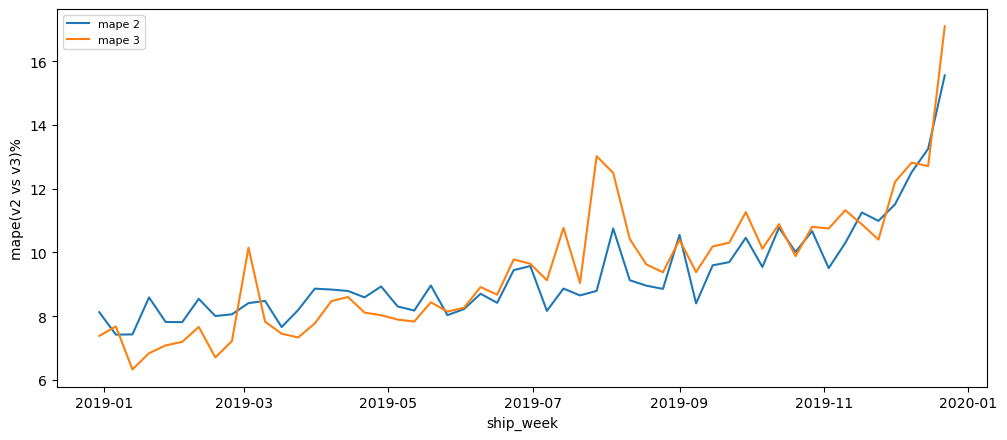

In [67]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v2, label='mape 2')
plt.plot(mape_v3, label='mape 3')
#plt.plot(mape_v2, label='mape v2')
#plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

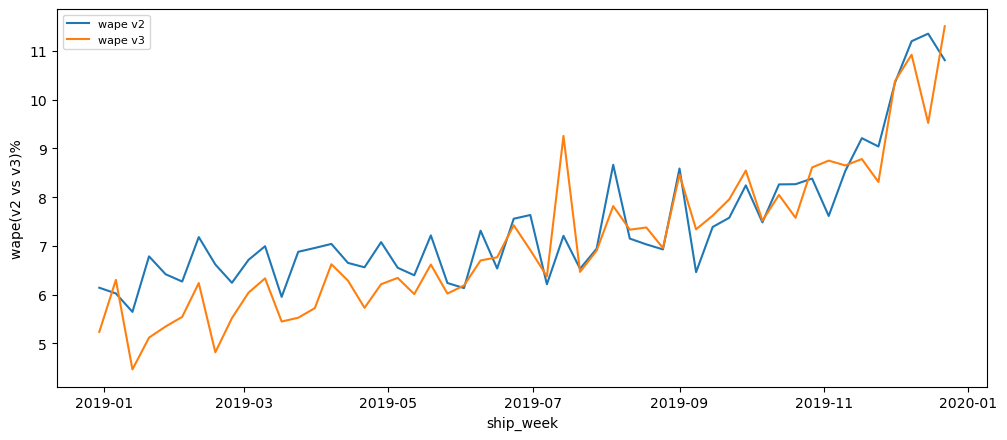

In [68]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v2, label='wape v2')
plt.plot(wape_v3, label='wape v3')
#plt.plot(mape_v2, label='mape v2')
#plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
plt.xlabel ('ship_week')
plt.ylabel ('wape(v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## V0 

In [70]:
mod_v0_rst = mod_df.reset_index()

In [66]:
# mask_v0 = (mod_v0_rst['ship_week'] >= '2017-07-21') & (mod_v0_rst['ship_week'] <= '2020-07-21')
# print(mod_v0_rst.loc[mask_v0])

In [71]:
mask_v0 = (mod_v0_rst['ship_week'] >= '2017-12-31') & (mod_v0_rst['ship_week'] <= '2018-12-23')
print(mod_v0_rst.loc[mask_v0])

        ship_week zipcode  pkgs
176554 2017-12-31     A0A   579
176555 2017-12-31     A0B   258
176556 2017-12-31     A0C   138
176557 2017-12-31     A0E   284
176558 2017-12-31     A0G   445
...           ...     ...   ...
261892 2018-12-23     X0G     3
261893 2018-12-23     X1A  1368
261894 2018-12-23     Y0A     5
261895 2018-12-23     Y0B    32
261896 2018-12-23     Y1A  1923

[85343 rows x 3 columns]


In [73]:
df_v0_new = mod_v0_rst.loc[mask_v0]
df_v0_new

,ship_week,zipcode,pkgs
176554,2017-12-31,A0A,579
176555,2017-12-31,A0B,258
176556,2017-12-31,A0C,138
176557,2017-12-31,A0E,284
176558,2017-12-31,A0G,445
...,...,...,...
261892,2018-12-23,X0G,3
261893,2018-12-23,X1A,1368
261894,2018-12-23,Y0A,5
261895,2018-12-23,Y0B,32


In [74]:
train_pct = df_v0_new.groupby(['ship_week','zipcode']).sum()/df_v0_new.groupby(['ship_week']).sum()
train_pct 

pkgs
ship_week  zipcode          
2017-12-31 A0A      0.000397
           A0B      0.000177
           A0C      0.000095
           A0E      0.000195
           A0G      0.000305
...                      ...
2018-12-23 X0G      0.000002
           X1A      0.000693
           Y0A      0.000003
           Y0B      0.000016
           Y1A      0.000974

[85343 rows x 1 columns]

In [75]:
train_pct_rst = train_pct.reset_index()
train_pct_rst

,ship_week,zipcode,pkgs
0,2017-12-31,A0A,0.000397
1,2017-12-31,A0B,0.000177
2,2017-12-31,A0C,0.000095
3,2017-12-31,A0E,0.000195
4,2017-12-31,A0G,0.000305
...,...,...,...
85338,2018-12-23,X0G,0.000002
85339,2018-12-23,X1A,0.000693
85340,2018-12-23,Y0A,0.000003
85341,2018-12-23,Y0B,0.000016


In [76]:
train_avg= train_pct.groupby(['zipcode'], sort=False).mean()
train_avg

,pkgs
zipcode,
A0A,0.000382
A0B,0.000192
A0C,0.000099
A0E,0.000210
A0G,0.000362
...,...
X0G,0.000002
X1A,0.000783
Y0A,0.000004


In [77]:
train_avg_rst = train_avg.reset_index()
train_avg_rst

,zipcode,pkgs
0,A0A,0.000382
1,A0B,0.000192
2,A0C,0.000099
3,A0E,0.000210
4,A0G,0.000362
...,...,...
1649,X0G,0.000002
1650,X1A,0.000783
1651,Y0A,0.000004
1652,Y0B,0.000019


In [78]:
#Percentage short form without 100
FSA = mod_df.groupby(['ship_week','zipcode']).sum()/mod_df.groupby(['ship_week']).sum()
FSA

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.000690
           A0B      0.000331
           A0C      0.000205
           A0E      0.000424
           A0G      0.000573
...                      ...
2019-12-22 X0G      0.000001
           X1A      0.000492
           Y0A      0.000004
           Y0B      0.000011
           Y1A      0.000646

[347671 rows x 1 columns]

In [79]:
#% volume distribution/week/FSA
pct2 = FSA.groupby(['ship_week','zipcode']).sum()/FSA.groupby(['ship_week']).sum()
pct2

pkgs
ship_week  zipcode          
2015-12-06 A0A      0.000690
           A0B      0.000331
           A0C      0.000205
           A0E      0.000424
           A0G      0.000573
...                      ...
2019-12-22 X0G      0.000001
           X1A      0.000492
           Y0A      0.000004
           Y0B      0.000011
           Y1A      0.000646

[347671 rows x 1 columns]

In [80]:
pct = pct2.reset_index()
pct.head(10)

,ship_week,zipcode,pkgs
0,2015-12-06,A0A,0.000690
1,2015-12-06,A0B,0.000331
2,2015-12-06,A0C,0.000205
3,2015-12-06,A0E,0.000424
4,2015-12-06,A0G,0.000573
5,2015-12-06,A0H,0.000320
6,2015-12-06,A0J,0.000187
7,2015-12-06,A0K,0.000325
8,2015-12-06,A0L,0.000194
9,2015-12-06,A0M,0.000145


In [81]:
#actual;pkgs_x and v0; pkgs_y
result_metric_train = pd.merge(pct, train_avg_rst, on=["zipcode"])
result_metric_train 

,ship_week,zipcode,pkgs_x,pkgs_y
0,2015-12-06,A0A,6.897416e-04,3.824471e-04
1,2015-12-13,A0A,4.330152e-04,3.824471e-04
2,2015-12-20,A0A,3.098622e-04,3.824471e-04
3,2015-12-27,A0A,5.181098e-04,3.824471e-04
4,2016-01-03,A0A,5.082297e-04,3.824471e-04
...,...,...,...,...
347561,2019-11-24,S7A,2.436109e-06,5.463272e-07
347562,2019-12-01,S7A,2.216011e-06,5.463272e-07
347563,2019-12-08,S7A,2.278118e-06,5.463272e-07
347564,2019-12-15,S7A,2.189399e-06,5.463272e-07


In [82]:
result_metric_train['APE_V0_new'] = result_metric_train ['pkgs_y'] - result_metric_train ['pkgs_x']

result_metric_train['APE_V0_new']= result_metric_train ['APE_V0_new'].abs()

result_metric_train.head()

,ship_week,zipcode,pkgs_x,pkgs_y,APE_V0_new
0,2015-12-06,A0A,0.000690,0.000382,0.000307
1,2015-12-13,A0A,0.000433,0.000382,0.000051
2,2015-12-20,A0A,0.000310,0.000382,0.000073
3,2015-12-27,A0A,0.000518,0.000382,0.000136
4,2016-01-03,A0A,0.000508,0.000382,0.000126


In [83]:
result_metric_train['APE_V0'] = result_metric_train['APE_V0_new'] / result_metric_train['pkgs_y']
result_metric_train

,ship_week,zipcode,pkgs_x,pkgs_y,APE_V0_new,APE_V0
0,2015-12-06,A0A,6.897416e-04,3.824471e-04,3.072945e-04,0.803495
1,2015-12-13,A0A,4.330152e-04,3.824471e-04,5.056802e-05,0.132222
2,2015-12-20,A0A,3.098622e-04,3.824471e-04,7.258493e-05,0.189791
3,2015-12-27,A0A,5.181098e-04,3.824471e-04,1.356627e-04,0.354723
4,2016-01-03,A0A,5.082297e-04,3.824471e-04,1.257826e-04,0.328889
...,...,...,...,...,...,...
347561,2019-11-24,S7A,2.436109e-06,5.463272e-07,1.889782e-06,3.459066
347562,2019-12-01,S7A,2.216011e-06,5.463272e-07,1.669684e-06,3.056198
347563,2019-12-08,S7A,2.278118e-06,5.463272e-07,1.731791e-06,3.169878
347564,2019-12-15,S7A,2.189399e-06,5.463272e-07,1.643071e-06,3.007486


In [84]:
#MAPE
mean_train_V0=result_metric_train.groupby(['ship_week'])[['APE_V0']].mean()*100
mean_train_V0

,APE_V0
ship_week,
2015-12-06,26.527230
2015-12-13,21.917740
2015-12-20,19.108972
2015-12-27,17.694881
2016-01-03,18.777784
...,...
2019-11-24,21.457228
2019-12-01,24.244823
2019-12-08,22.900208


In [85]:
mape_v0_upd = mean_train_V0[mean_train_V0.index >='2018-12-30']
mape_v0_upd

,APE_V0
ship_week,
2018-12-30,9.291951
2019-01-06,8.893992
2019-01-13,7.624181
2019-01-20,7.470828
2019-01-27,7.357911
2019-02-03,7.720974
2019-02-10,8.189785
2019-02-17,8.136027
2019-02-24,7.588094


In [135]:
mape_v0_upd_rst = mape_v0_upd.reset_index()

In [136]:
peak_mape_v0 = mape_v0_upd_rst[(mape_v0_upd_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_mape_v0

APE_V0    19.054011
dtype: float64

In [137]:
non_peak_mape_v0 = mape_v0_upd_rst[~(mape_v0_upd_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_mape_v0

APE_V0    11.150748
dtype: float64

In [87]:
def my_agg(y):
    names = {'weighted_train_V0': (y['pkgs_y'] * y['APE_V0']).sum()/y['pkgs_y'].sum()}
    return pd.Series(names, index=['weighted_train_V0'])

In [88]:
wape_V0_new = result_metric_train.groupby(["ship_week"]).apply(my_agg)*100
wape_V0_new

,weighted_train_V0
ship_week,
2015-12-06,21.532130
2015-12-13,18.623726
2015-12-20,15.442221
2015-12-27,13.681445
2016-01-03,14.874231
...,...
2019-11-24,13.742105
2019-12-01,16.074192
2019-12-08,16.420864


In [89]:
wape_v0_upd = wape_V0_new[wape_V0_new.index >='2018-12-30']
wape_v0_upd

,weighted_train_V0
ship_week,
2018-12-30,7.751290
2019-01-06,7.180879
2019-01-13,5.598156
2019-01-20,5.603560
2019-01-27,5.354024
2019-02-03,5.764624
2019-02-10,6.215838
2019-02-17,5.732210
2019-02-24,5.394016


In [129]:
wape_v0_upd_rst = wape_v0_upd.reset_index()

In [130]:
peak_wape_v0 = wape_v0_upd_rst[(wape_v0_upd_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_wape_v0

weighted_train_V0    13.990089
dtype: float64

In [131]:
non_peak_wape_v0 = wape_v0_upd_rst[~(wape_v0_upd_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_wape_v0

weighted_train_V0    7.53096
dtype: float64

In [ ]:
mape_v0_upd

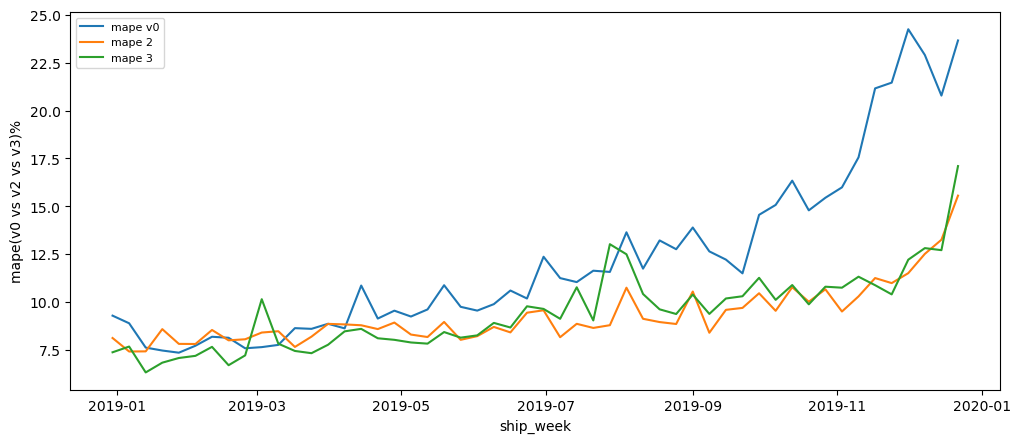

In [90]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mape_v2, label='mape 2')
plt.plot(mape_v3, label='mape 3')
#plt.plot(mape_v0_upd, label='mape v0')
#plt.title('MAPE across diffrent weeks(v0 vs v1 vs v2)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

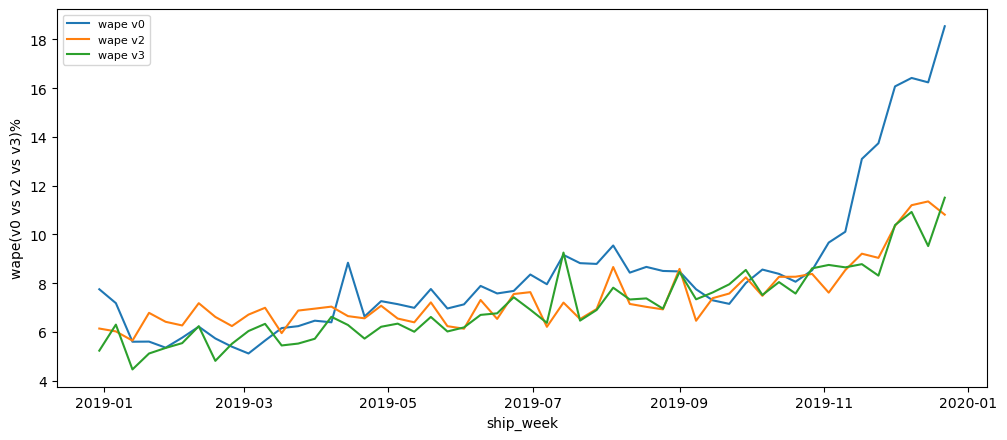

In [91]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_v2, label='wape v2')
plt.plot(wape_v3, label='wape v3')
#plt.plot(wape_v0_upd, label='wape v0')
#plt.title('MAPE across diffrent weeks(v0 vs v2 vs v3)')
plt.xlabel ('ship_week')
plt.ylabel ('wape(v0 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [92]:
# define function 
def run_V1_models(df):
    
        zipcode = df[0]
        df = df[1]

    
    #input from the model 
        try:
        
    #df = df.set_index('ship_week')
            train_data = df[-4*212:160]
            test_data = df[-52:]
            fcst_data = df[-3*52:]
    
    
            train_data1 = train_data.iloc[:,1]
            test_data1 = test_data.iloc[:,1]
            fcst = fcst_data.iloc[:,1]
        
         #model fit 
            model = ARIMA(train_data1, order=(1,1,3))
            model_fit = model.fit()
            #print(model_fit)
        
        
         #predict model
            pred_model = model_fit.predict(start=160, end=160+52-1)
            pred_model = pd.DataFrame(pred_model)
            pred_model.columns= ['pred']
            pred_model['zipcode'] = df['zipcode'].unique()[0]
           # print(pred_model)
        
         #forecast model
            fct_model = ARIMA(fcst, order=(1,1,3))  
            fct_fit = fct_model.fit()
           # print(fct_fit)
       
            forecast = fct_fit.predict(start=160, end=160+352-1)
            forecast = pd.DataFrame(forecast) 
            forecast.columns = ['pred']
            forecast['zipcode'] = df['zipcode'].unique()[0]
            #print(forecast)
            
        except:
            print(df['zipcode'].unique()[0])
            pred_model = np.full(len(test_data1), np.nan)
            pred_model = pd.DataFrame(pred_model)
            pred_model.columns= ['pred']
            pred_model['zipcode'] = df['zipcode'].unique()[0]
            forecast = np.full(len(fcst), np.nan)
            forecast = pd.DataFrame(forecast) 
            forecast.columns = ['pred']
            forecast['zipcode'] = df['zipcode'].unique()[0]
    
        return pred_model, forecast
            
            

In [93]:
p = mp.Pool(mp.cpu_count())

J5N
V0Y


In [94]:
results_v1 = p.map(run_V1_models, mod_df.groupby('zipcode'))

In [95]:
predictions=[]
forecasts=[]

for res in results_v1:
    
    pred_model = res[0]
    forecast = res[1]
    
    predictions.append(pred_model)
    forecasts.append(forecast)

In [96]:
df_pred = pd.DataFrame(columns=['index', 'pred', 'zipcode'])
df_pred
for i in range(len(predictions)):
    df_pred = df_pred.append([predictions[i].reset_index()])    
    

In [97]:
df_pred

,index,pred,zipcode
0,2018-12-30 00:00:00,842.318990,A0A
1,2019-01-06 00:00:00,842.592264,A0A
2,2019-01-13 00:00:00,828.629354,A0A
3,2019-01-20 00:00:00,819.039352,A0A
4,2019-01-27 00:00:00,812.452749,A0A
...,...,...,...
47,2019-11-24 00:00:00,2031.299260,Y1A
48,2019-12-01 00:00:00,2031.299260,Y1A
49,2019-12-08 00:00:00,2031.299260,Y1A
50,2019-12-15 00:00:00,2031.299260,Y1A


In [99]:
df_pred.to_csv('df_pre_v1.csv')

In [100]:
df_pred = pd.read_csv(r'Precovid_data/df_pre_v1.csv')
print(df_pred)

       Unnamed: 0                index         pred zipcode
0               0  2018-12-30 00:00:00   842.318990     A0A
1               1  2019-01-06 00:00:00   842.592264     A0A
2               2  2019-01-13 00:00:00   828.629354     A0A
3               3  2019-01-20 00:00:00   819.039352     A0A
4               4  2019-01-27 00:00:00   812.452749     A0A
...           ...                  ...          ...     ...
86184          47  2019-11-24 00:00:00  2031.299260     Y1A
86185          48  2019-12-01 00:00:00  2031.299260     Y1A
86186          49  2019-12-08 00:00:00  2031.299260     Y1A
86187          50  2019-12-15 00:00:00  2031.299260     Y1A
86188          51  2019-12-22 00:00:00  2031.299260     Y1A

[86189 rows x 4 columns]


In [101]:
df_pred_V1 = df_pred.drop(df_pred.columns[0], axis = 1) 
df_pred_V1

,index,pred,zipcode
0,2018-12-30 00:00:00,842.318990,A0A
1,2019-01-06 00:00:00,842.592264,A0A
2,2019-01-13 00:00:00,828.629354,A0A
3,2019-01-20 00:00:00,819.039352,A0A
4,2019-01-27 00:00:00,812.452749,A0A
...,...,...,...
86184,2019-11-24 00:00:00,2031.299260,Y1A
86185,2019-12-01 00:00:00,2031.299260,Y1A
86186,2019-12-08 00:00:00,2031.299260,Y1A
86187,2019-12-15 00:00:00,2031.299260,Y1A


In [102]:
df_pred_V1['index'] = pd.to_datetime(df_pred_V1['index'], errors='coerce')
df_pred_V1

,index,pred,zipcode
0,2018-12-30,842.318990,A0A
1,2019-01-06,842.592264,A0A
2,2019-01-13,828.629354,A0A
3,2019-01-20,819.039352,A0A
4,2019-01-27,812.452749,A0A
...,...,...,...
86184,2019-11-24,2031.299260,Y1A
86185,2019-12-01,2031.299260,Y1A
86186,2019-12-08,2031.299260,Y1A
86187,2019-12-15,2031.299260,Y1A


In [103]:
df_pred_V1.rename({'index': 'ship_week'}, axis=1, inplace=True)
df_pred_V1

,ship_week,pred,zipcode
0,2018-12-30,842.318990,A0A
1,2019-01-06,842.592264,A0A
2,2019-01-13,828.629354,A0A
3,2019-01-20,819.039352,A0A
4,2019-01-27,812.452749,A0A
...,...,...,...
86184,2019-11-24,2031.299260,Y1A
86185,2019-12-01,2031.299260,Y1A
86186,2019-12-08,2031.299260,Y1A
86187,2019-12-15,2031.299260,Y1A


In [104]:
df_pred_index = df_pred_V1.set_index('ship_week')
df_pred_index

,pred,zipcode
ship_week,,
2018-12-30,842.318990,A0A
2019-01-06,842.592264,A0A
2019-01-13,828.629354,A0A
2019-01-20,819.039352,A0A
2019-01-27,812.452749,A0A
...,...,...
2019-11-24,2031.299260,Y1A
2019-12-01,2031.299260,Y1A
2019-12-08,2031.299260,Y1A


In [105]:
# df_pred['index'] = pd.to_datetime(df_pred['index'], errors='coerce')
# df_pred

In [106]:
# df_pred.rename({'index': 'ship_week'}, axis=1, inplace=True)
# df_pred

In [107]:
# df_pred_index = df_pred.set_index('ship_week')
# df_pred_index

In [108]:
mod_reset = mod_df.reset_index()
mod_reset

,ship_week,zipcode,pkgs
0,2015-12-06,A0A,655
1,2015-12-06,A0B,314
2,2015-12-06,A0C,195
3,2015-12-06,A0E,403
4,2015-12-06,A0G,544
...,...,...,...
347666,2019-12-22,X0G,4
347667,2019-12-22,X1A,1519
347668,2019-12-22,Y0A,11
347669,2019-12-22,Y0B,34


In [109]:
pct_data2 = pct2.reset_index()
pct_data2.head(10)

,ship_week,zipcode,pkgs
0,2015-12-06,A0A,0.000690
1,2015-12-06,A0B,0.000331
2,2015-12-06,A0C,0.000205
3,2015-12-06,A0E,0.000424
4,2015-12-06,A0G,0.000573
5,2015-12-06,A0H,0.000320
6,2015-12-06,A0J,0.000187
7,2015-12-06,A0K,0.000325
8,2015-12-06,A0L,0.000194
9,2015-12-06,A0M,0.000145


In [111]:
prop = df_pred_index.groupby(['ship_week','zipcode']).sum()/df_pred_index.groupby(['ship_week']).sum()
prop

pred
ship_week  zipcode          
2018-12-30 A0A      0.000411
           A0B      0.000195
           A0C      0.000101
           A0E      0.000223
           A0G      0.000438
...                      ...
2023-08-20 R5P      0.204071
           R5R      0.572774
           R5T      0.223155
2023-08-27 R5P      0.262692
           R5R      0.737308

[84656 rows x 1 columns]

In [112]:
prop_rst = prop.reset_index()
prop_rst

,ship_week,zipcode,pred
0,2018-12-30,A0A,0.000411
1,2018-12-30,A0B,0.000195
2,2018-12-30,A0C,0.000101
3,2018-12-30,A0E,0.000223
4,2018-12-30,A0G,0.000438
...,...,...,...
84651,2023-08-20,R5P,0.204071
84652,2023-08-20,R5R,0.572774
84653,2023-08-20,R5T,0.223155
84654,2023-08-27,R5P,0.262692


In [113]:
mask = (prop_rst['ship_week'] > '2018-12-04') & (prop_rst['ship_week'] <= '2019-12-22')
print(prop_rst.loc[mask])

       ship_week zipcode      pred
0     2018-12-30     A0A  0.000411
1     2018-12-30     A0B  0.000195
2     2018-12-30     A0C  0.000101
3     2018-12-30     A0E  0.000223
4     2018-12-30     A0G  0.000438
...          ...     ...       ...
84183 2019-12-22     X0E  0.000042
84184 2019-12-22     X1A  0.000725
84185 2019-12-22     Y0A  0.000003
84186 2019-12-22     Y0B  0.000015
84187 2019-12-22     Y1A  0.000920

[84188 rows x 3 columns]


In [ ]:
# mask = (prop_rst['ship_week'] > '2020-07-05') & (prop_rst['ship_week'] <= '2021-07-04')
# print(prop_rst.loc[mask])

In [114]:
df_mask = (prop_rst.loc[mask])
df_mask

,ship_week,zipcode,pred
0,2018-12-30,A0A,0.000411
1,2018-12-30,A0B,0.000195
2,2018-12-30,A0C,0.000101
3,2018-12-30,A0E,0.000223
4,2018-12-30,A0G,0.000438
...,...,...,...
84183,2019-12-22,X0E,0.000042
84184,2019-12-22,X1A,0.000725
84185,2019-12-22,Y0A,0.000003
84186,2019-12-22,Y0B,0.000015


In [115]:
result_metric_prop = pd.merge(df_mask, pct_data2, on=["ship_week", "zipcode"])
result_metric_prop

,ship_week,zipcode,pred,pkgs
0,2018-12-30,A0A,0.000411,0.000397
1,2018-12-30,A0B,0.000195,0.000201
2,2018-12-30,A0C,0.000101,0.000109
3,2018-12-30,A0E,0.000223,0.000219
4,2018-12-30,A0G,0.000438,0.000361
...,...,...,...,...
84183,2019-12-22,X0E,0.000042,0.000047
84184,2019-12-22,X1A,0.000725,0.000492
84185,2019-12-22,Y0A,0.000003,0.000004
84186,2019-12-22,Y0B,0.000015,0.000011


In [116]:
#take the difference
result_metric_prop['diff_mix'] = result_metric_prop['pkgs'] - result_metric_prop['pred']

result_metric_prop['diff_mix']= result_metric_prop['diff_mix'].abs()

result_metric_prop

,ship_week,zipcode,pred,pkgs,diff_mix
0,2018-12-30,A0A,0.000411,0.000397,1.384448e-05
1,2018-12-30,A0B,0.000195,0.000201,5.986371e-06
2,2018-12-30,A0C,0.000101,0.000109,7.389377e-06
3,2018-12-30,A0E,0.000223,0.000219,3.911672e-06
4,2018-12-30,A0G,0.000438,0.000361,7.638813e-05
...,...,...,...,...,...
84183,2019-12-22,X0E,0.000042,0.000047,4.636453e-06
84184,2019-12-22,X1A,0.000725,0.000492,2.332256e-04
84185,2019-12-22,Y0A,0.000003,0.000004,4.436096e-07
84186,2019-12-22,Y0B,0.000015,0.000011,4.247752e-06


In [117]:
result_metric_prop['APE'] = result_metric_prop['diff_mix'] / result_metric_prop['pkgs']
result_metric_prop

,ship_week,zipcode,pred,pkgs,diff_mix,APE
0,2018-12-30,A0A,0.000411,0.000397,1.384448e-05,0.034903
1,2018-12-30,A0B,0.000195,0.000201,5.986371e-06,0.029819
2,2018-12-30,A0C,0.000101,0.000109,7.389377e-06,0.068080
3,2018-12-30,A0E,0.000223,0.000219,3.911672e-06,0.017874
4,2018-12-30,A0G,0.000438,0.000361,7.638813e-05,0.211391
...,...,...,...,...,...,...
84183,2019-12-22,X0E,0.000042,0.000047,4.636453e-06,0.099483
84184,2019-12-22,X1A,0.000725,0.000492,2.332256e-04,0.474399
84185,2019-12-22,Y0A,0.000003,0.000004,4.436096e-07,0.124604
84186,2019-12-22,Y0B,0.000015,0.000011,4.247752e-06,0.386016


In [118]:
#MAPE
mean_result_prop= result_metric_prop.groupby(['ship_week'])[['APE']].mean()*100
mean_result_prop

,APE
ship_week,
2018-12-30,15.106490
2019-01-06,16.266600
2019-01-13,13.440775
2019-01-20,12.245041
2019-01-27,11.738414
2019-02-03,10.957848
2019-02-10,11.360737
2019-02-17,9.732525
2019-02-24,10.637723


In [126]:
mape_V1_rst = mean_result_prop.reset_index()

In [127]:
peak_mape_v1 = mape_V1_rst[(mape_V1_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_mape_v1

APE    18.55457
dtype: float64

In [128]:
non_peak_mape_v1 = mape_V1_rst [~(mape_V1_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_mape_v1

APE    12.244904
dtype: float64

## WAPE V1

In [119]:
def my_agg(x):
    names = {'weighted_avg_mix': (x['pkgs'] * x['APE']).sum()/x['pkgs'].sum()}
    return pd.Series(names, index=['weighted_avg_mix'])

In [120]:
wape_V1 = result_metric_prop.groupby(["ship_week"]).apply(my_agg)*100
wape_V1

,weighted_avg_mix
ship_week,
2018-12-30,13.691692
2019-01-06,16.078356
2019-01-13,12.723959
2019-01-20,11.103367
2019-01-27,10.994400
2019-02-03,9.701934
2019-02-10,10.105353
2019-02-17,8.559191
2019-02-24,9.231423


In [123]:
wape_V1_rst = wape_V1.reset_index()

In [124]:
peak_wape_v1 = wape_V1_rst [(wape_V1_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
peak_wape_v1

weighted_avg_mix    16.908013
dtype: float64

In [125]:
non_peak_wape_v1 = wape_V1_rst [~(wape_V1_rst['ship_week'].isin(['2019-11-24','2019-12-01','2019-12-08', 
                                            '2019-12-15', '2019-12-22', '2019-07-14', '2018-12-30']))].mean()
non_peak_wape_v1

weighted_avg_mix    11.234418
dtype: float64

In [ ]:
first_20_weeks_v1 = wape_V1_rst [(wape_V1_rst['ship_week’]<=list(wape_V1_rst.sort_values(’ship_week’)[’ship_week’].unique())[19])].mean()
first_20_weeks_v1

In [ ]:
pct = pct1.groupby(['ship_week']).sum()
pct

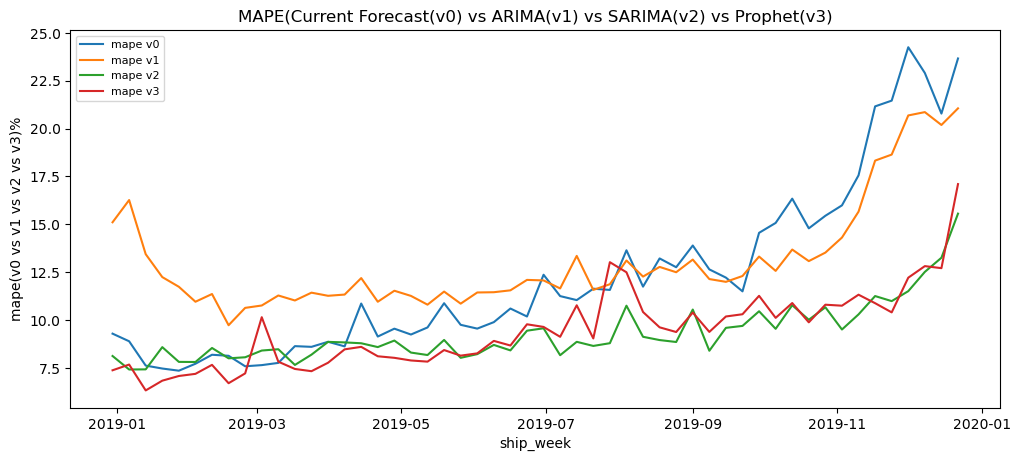

In [121]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(mape_v0_upd, label='mape v0')
plt.plot(mean_result_prop, label='mape v1')
plt.plot(mape_v2, label='mape v2')
plt.plot(mape_v3, label='mape v3')
#plt.plot(mape_v0_upd, label='mape v0')
plt.title('MAPE(Current Forecast(v0) vs ARIMA(v1) vs SARIMA(v2) vs Prophet(v3)')
plt.xlabel ('ship_week')
plt.ylabel ('mape(v0 vs v1 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()

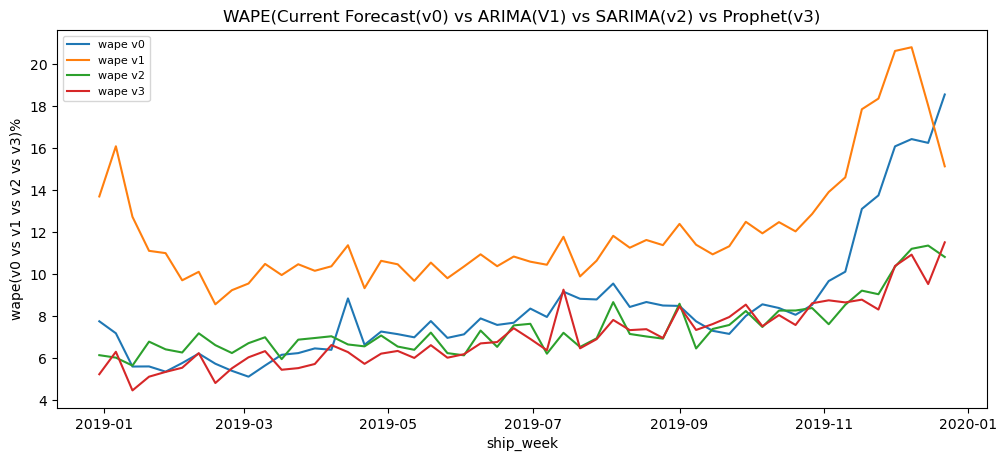

In [122]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(wape_v0_upd, label='wape v0')
plt.plot(wape_V1, label='wape v1')
plt.plot(wape_v2, label='wape v2')
plt.plot(wape_v3, label='wape v3')
#plt.plot(wape_v0_upd, label='wape v0')
#plt.title('WAPE across diffrent weeks(v0 vs v2 vs v3)')
plt.title('WAPE(Current Forecast(v0) vs ARIMA(V1) vs SARIMA(v2) vs Prophet(v3)')
plt.xlabel ('ship_week')
plt.ylabel ('wape(v0 vs v1 vs v2 vs v3)%')
plt.legend(loc='upper left', fontsize=8)
plt.show()